In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import gzip
from collections import Counter
import os
import seaborn as sns
import pybedtools
from pybedtools import BedTool
from scipy import io
from scipy import sparse
import matplotlib.backends.backend_pdf
#import scanpy as sc
from scipy import stats
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
from itertools import combinations
from tqdm.auto import tqdm
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

In [8]:
##This Cell loads the data for Figure 1B

import pandas as pd

# ——— 1) Load the split‐readcounts table
souper_star_CUTAC_Combined = pd.read_csv('souporcell_CUTAC_Combined_SplitReadCounts.csv.gz', compression='gzip')

# ——— 2) Define your four sample‐name groups
Old_Protocol = ['CUTAC_WC_Stnd_No', 'CUTAC_Nuc_Stnd_No']
New_Protocol = ['CUTAC_Nuc_PAGE_PK', 'CUTAC_WC_PAGE_PK']
New_Protocol_Multi = [
    'CUTAC_Multi_K4_D3-10_ConA_Exp4', 'CUTAC_Multi_K4_D3-10_WGA_Exp4',
    'CUTAC_Multi_K4_Female_ConA_Exp4', 'CUTAC_Multi_K4_Female_WGA_Exp4',
    'CUTAC_Multi_K4_D3-10_ConA_Exp5', 'CUTAC_Multi_K4_D3-10_WGA_Exp5',
    'CUTAC_Multi_K4_Female_ConA_Exp5', 'CUTAC_Multi_K4_Female_WGA_Exp5',
    'CUTAC_Multi_Female_Exp1', 'CUTAC_Multi_Female_Exp2',
    'CUTAC_Multi_K27_D3-10_ConA_Exp4','CUTAC_Multi_K27_D3-10_WGA_Exp4',
    'CUTAC_Multi_K27_Female_ConA_Exp4','CUTAC_Multi_K27_Female_WGA_Exp4',
    'CUTAC_Multi_K27_D3-10_ConA_Exp5','CUTAC_Multi_K27_D3-10_WGA_Exp5',
    'CUTAC_Multi_K27_Female_Exp5','CUTAC_Multi_K27_Female_WGA_Exp5',
    'CUTAC_K4me123_C1_240218','CUTAC_K27me3_C1_240218'
]

# ——— 3) Map each group to its list of barcodes from df1
group_barcodes = {
    'Old Protocol':             souper_star_CUTAC_Combined.loc[souper_star_CUTAC_Combined['sample'].isin(Old_Protocol), 'barcode'].tolist(),
    'New Protocol':             souper_star_CUTAC_Combined.loc[souper_star_CUTAC_Combined['sample'].isin(New_Protocol), 'barcode'].tolist(),
    'New Protocol Multi':       souper_star_CUTAC_Combined.loc[souper_star_CUTAC_Combined['sample'].isin(New_Protocol_Multi), 'barcode'].tolist(),
}

# ——— 4) Load the BED files
CUTAC_Batch3_Full = pd.read_csv(
    'Full_hg38_Aligned_BED_Files/Batch_Beds_CUTAC/CUTAC_Batch3_Full.bed.gz',
    sep='\t', header=None
)

CUTAC_Batch4_2in1_wK27me3_Full = pd.read_csv(
    'Full_hg38_Aligned_BED_Files/Batch_Beds_CUTAC/CUTAC_Batch4_2in1_wK27me3_Full.bed.gz',
    sep='\t', header=None
)

CUTAC_Batch7_2in1_wK4me123_Full = pd.read_csv(
    'Full_hg38_Aligned_BED_Files/Batch_Beds_CUTAC/CUTAC_Batch7_2in1_wK4me123_Full.bed.gz',
    sep='\t', header=None
)

CUTAC_Batch7_2in1_wK27me3_Full = pd.read_csv(
    'Full_hg38_Aligned_BED_Files/Batch_Beds_CUTAC/CUTAC_Batch7_2in1_wK27me3_Full.bed.gz',
    sep='\t', header=None
)

CUTAC_Batch8_2in1_wK4me123_Full = pd.read_csv(
    'Full_hg38_Aligned_BED_Files/Batch_Beds_CUTAC/CUTAC_Batch8_2in1_wK4me123_Full.bed.gz',
    sep='\t', header=None
)

CUTAC_Batch8_2in1_wK27me3_Full = pd.read_csv(
    'Full_hg38_Aligned_BED_Files/Batch_Beds_CUTAC/CUTAC_Batch8_2in1_wK27me3_Full.bed.gz',
    sep='\t', header=None
)

CUTAC_Batch9_2in1_wK4me123_Full = pd.read_csv(
    'Full_hg38_Aligned_BED_Files/Batch_Beds_CUTAC/CUTAC_Batch9_2in1_wK4me123_Full.bed.gz',
    sep='\t', header=None
)

CUTAC_Batch9_2in1_wK27me3_Full = pd.read_csv(
    'Full_hg38_Aligned_BED_Files/Batch_Beds_CUTAC/CUTAC_Batch9_2in1_wK27me3_Full.bed.gz',
    sep='\t', header=None
)

CUTAC_Batch10_Full = pd.read_csv(
    'Full_hg38_Aligned_BED_Files/Batch_Beds_CUTAC/CUTAC_Batch10_Full.bed.gz',
    sep='\t', header=None
)

no_split = pd.concat([CUTAC_Batch3_Full, CUTAC_Batch4_2in1_wK27me3_Full, CUTAC_Batch7_2in1_wK4me123_Full, CUTAC_Batch7_2in1_wK27me3_Full, 
                       CUTAC_Batch8_2in1_wK4me123_Full, CUTAC_Batch8_2in1_wK27me3_Full, CUTAC_Batch9_2in1_wK4me123_Full,
                       CUTAC_Batch9_2in1_wK27me3_Full, CUTAC_Batch10_Full], ignore_index=True)

CUTAC_Batch4_2in1_wK27me3_wSplit_Full = pd.read_csv(
    'Full_hg38_Aligned_BED_Files/Batch_Beds_CUTAC_wSplit_Combined/CUTAC_Batch4_2in1_wK27me3_wSplit_Full.bed.gz',
    sep='\t', header=None
)

CUTAC_Batch7_2in1_wK4me123_wSplit_Full = pd.read_csv(
    'Full_hg38_Aligned_BED_Files/Batch_Beds_CUTAC_wSplit_Combined/CUTAC_Batch7_2in1_wK4me123_wSplit_Full.bed.gz',
    sep='\t', header=None
)

CUTAC_Batch7_2in1_wK27me3_wSplit_Full = pd.read_csv(
    'Full_hg38_Aligned_BED_Files/Batch_Beds_CUTAC_wSplit_Combined/CUTAC_Batch7_2in1_wK27me3_wSplit_Full.bed.gz',
    sep='\t', header=None
)

CUTAC_Batch8_2in1_wK4me123_wSplit_Full = pd.read_csv(
    'Full_hg38_Aligned_BED_Files/Batch_Beds_CUTAC_wSplit_Combined/CUTAC_Batch8_2in1_wK4me123_wSplit_Full.bed.gz',
    sep='\t', header=None
)

CUTAC_Batch8_2in1_wK27me3_wSplit_Full = pd.read_csv(
    'Full_hg38_Aligned_BED_Files/Batch_Beds_CUTAC_wSplit_Combined/CUTAC_Batch8_2in1_wK27me3_wSplit_Full.bed.gz',
    sep='\t', header=None
)

CUTAC_Batch9_2in1_wK4me123_wSplit_Full = pd.read_csv(
    'Full_hg38_Aligned_BED_Files/Batch_Beds_CUTAC_wSplit_Combined/CUTAC_Batch9_2in1_wK4me123_wSplit_Full.bed.gz',
    sep='\t', header=None
)

CUTAC_Batch9_2in1_wK27me3_wSplit_Full = pd.read_csv(
    'Full_hg38_Aligned_BED_Files/Batch_Beds_CUTAC_wSplit_Combined/CUTAC_Batch9_2in1_wK27me3_wSplit_Full.bed.gz',
    sep='\t', header=None
)

split_combined = pd.concat([CUTAC_Batch4_2in1_wK27me3_wSplit_Full, CUTAC_Batch7_2in1_wK4me123_wSplit_Full, CUTAC_Batch7_2in1_wK27me3_wSplit_Full, 
                       CUTAC_Batch8_2in1_wK4me123_wSplit_Full, CUTAC_Batch8_2in1_wK27me3_wSplit_Full, CUTAC_Batch9_2in1_wK4me123_wSplit_Full,
                       CUTAC_Batch9_2in1_wK27me3_wSplit_Full], ignore_index=True)

# ——— 5) Count per‐barcode occurrences in each group
counts = {}
for grp, barcodes in group_barcodes.items():
    counts[grp] = no_split.loc[no_split[3].isin(barcodes), 3].value_counts()

# last group: New Protocol Multi + split reads
counts['New Protocol Multi+split reads'] = (
    split_combined.loc[split_combined[3].isin(group_barcodes['New Protocol Multi']), 3]
    .value_counts()
)

# ——— 6) Build a long‐form DataFrame for plotting
records = []
for grp, vc in counts.items():
    for cnt in vc.values:
        records.append({
            'Protocol_Group': grp,
            'actual_read_number': cnt
        })

df1_final = pd.DataFrame(records)

# The next two just split out reads into bed files for visualizing in a genome browser

In [9]:
import pandas as pd
import os

# 1. Load the cluster barcode file
cluster_barcode_file = "K27me3_Cluster_Barcodes.csv"
cluster_df = pd.read_csv(cluster_barcode_file, names=['barcode', 'cluster'], header=None)

# 2. Merge cluster labels onto split_combined using the barcode column (column 3 is barcode)
split_with_cluster = split_combined.merge(
    cluster_df,
    left_on=3,    # barcode column in split_combined
    right_on="barcode",
    how="inner"
)

# 3. Filter to canonical chromosomes only
canonical_chroms = [f"chr{i}" for i in range(1, 23)] + ["chrX", "chrY"]
split_with_cluster = split_with_cluster[split_with_cluster[0].isin(canonical_chroms)].copy()

# 4. Subset by cluster
mep_bed = split_with_cluster[split_with_cluster["cluster"] == "MEP"].iloc[:, :4]
hspc_bed = split_with_cluster[split_with_cluster["cluster"].isin(["HSC", "MPP", "LMPP"])].iloc[:, :4]

# 5. Sort by chromosome, start, end
mep_bed = mep_bed.sort_values(by=[0, 1, 2]).reset_index(drop=True)
hspc_bed = hspc_bed.sort_values(by=[0, 1, 2]).reset_index(drop=True)

# 6. Make sure output folder exists
outdir = "New_Bed_Files"
os.makedirs(outdir, exist_ok=True)

# 7. Save to BED files
mep_bed.to_csv(os.path.join(outdir, "MEP_CUTAC_wSplit_K27me3_Paired.bed"),
               sep="\t", header=False, index=False)

hspc_bed.to_csv(os.path.join(outdir, "HSPC_No_MEP_CUTAC_wSplit_K27me3_Paired.bed"),
                sep="\t", header=False, index=False)

print("[saved] MEP_CUTAC_wSplit_K27me3_Paired.bed (sorted, canonical only)")
print("[saved] HSPC_No_MEP_CUTAC_wSplit_K27me3_Paired.bed (sorted, canonical only)")


[saved] MEP_CUTAC_wSplit_K27me3_Paired.bed (sorted, canonical only)
[saved] HSPC_No_MEP_CUTAC_wSplit_K27me3_Paired.bed (sorted, canonical only)


In [10]:
import pandas as pd
import os

# 1. Load the cluster barcode file
cluster_barcode_file = "K4me123_Cluster_Barcodes.csv"
cluster_df = pd.read_csv(cluster_barcode_file, names=['barcode', 'cluster'], header=None)

# 2. Merge cluster labels onto split_combined using the barcode column
# Assuming split_combined has barcodes in column 3
split_with_cluster = split_combined.merge(
    cluster_df,
    left_on=3,    # barcode column in split_combined
    right_on="barcode",
    how="inner"
)

# 3. Filter to canonical chromosomes only
canonical_chroms = [f"chr{i}" for i in range(1, 23)] + ["chrX", "chrY"]
split_with_cluster = split_with_cluster[split_with_cluster[0].isin(canonical_chroms)].copy()

# 4. Subset by cluster
mep_bed = split_with_cluster[split_with_cluster["cluster"] == "MEP"].iloc[:, :4]
hspc_bed = split_with_cluster[split_with_cluster["cluster"].isin(["HSC", "MPP", "LMPP", "GMP", "CLP"])].iloc[:, :4]

# 5. Sort by chromosome, start, end
# Cast chromosome to string just in case
mep_bed = mep_bed.sort_values(by=[0, 1, 2]).reset_index(drop=True)
hspc_bed = hspc_bed.sort_values(by=[0, 1, 2]).reset_index(drop=True)

# 6. Make sure output folder exists
outdir = "New_Bed_Files"
os.makedirs(outdir, exist_ok=True)

# 7. Save to BED files
mep_bed.to_csv(os.path.join(outdir, "MEP_CUTAC_wSplit_K4me123_Paired.bed"),
               sep="\t", header=False, index=False)

hspc_bed.to_csv(os.path.join(outdir, "HSPC_No_MEP_CUTAC_wSplit_K4me123_Paired.bed"),
                sep="\t", header=False, index=False)

print("[saved] MEP_CUTAC_wSplit_K4me123_Paired.bed (sorted)")
print("[saved] HSPC_No_MEP_CUTAC_wSplit_K4me123_Paired.bed (sorted)")


[saved] MEP_CUTAC_wSplit_K4me123_Paired.bed (sorted)
[saved] HSPC_No_MEP_CUTAC_wSplit_K4me123_Paired.bed (sorted)


/tmp/ipykernel_84040/966137020.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


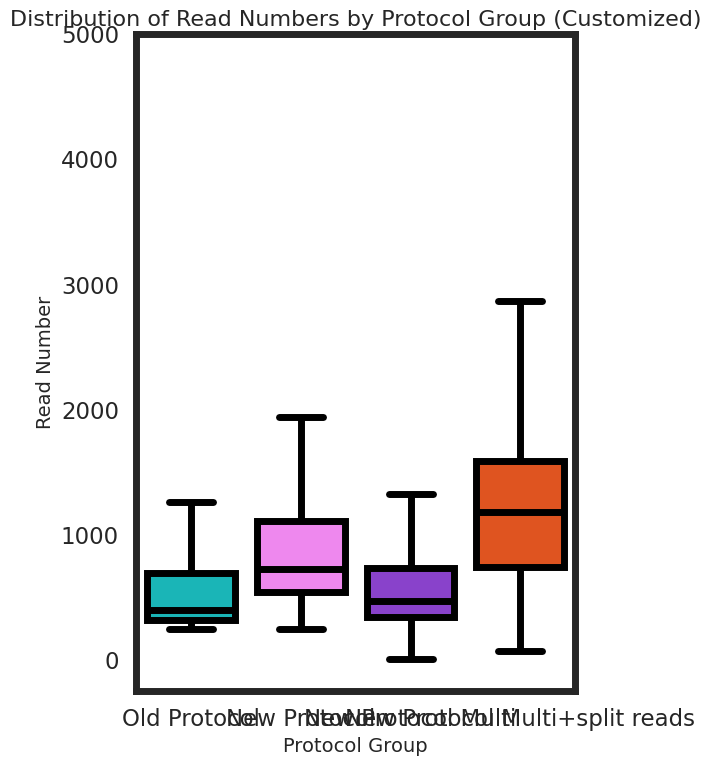

In [17]:
#This Cell generates the plot for Figure 1B

protocol_order = [
    'Old Protocol',
    'New Protocol',
    'New Protocol Multi',
    'New Protocol Multi+split reads'
]
protocol_colors = {
    'Old Protocol':                   '#00CED1',
    'New Protocol':                   '#FF77FF',
    'New Protocol Multi':             '#8A2BE2',
    'New Protocol Multi+split reads': '#FF4500'
}

sns.set_style('white')
sns.set_context('talk')

plt.figure(figsize=(7, 8))
ax = sns.boxplot(
    data=df1_final,
    x='Protocol_Group',
    y='actual_read_number',        # <-- use the correct column name here
    order=protocol_order,
    palette=protocol_colors,
    showfliers=False,
    linewidth=5.0
)

# Styling
for patch in ax.patches:
    patch.set_edgecolor('black')
    patch.set_linewidth(5.0)
    patch.set_hatch('')
for line in ax.lines:
    line.set_color('black')
    line.set_linewidth(5.0)
for spine in ax.spines.values():
    spine.set_linewidth(5.0)

# Axes & title
ax.set_ylim(-250, 5000)

plt.xlabel('Protocol Group', fontsize=14)
plt.ylabel('Read Number', fontsize=14)
plt.title('Distribution of Read Numbers by Protocol Group (Customized)', fontsize=16)

plt.tight_layout()

#plt.savefig(
#    '/location/for/figure/output/PolII_ReadCount_Boxplot.png',
#    dpi=300
#)

plt.show()


In [12]:
#This cell computes the a readcount summary for data from Figure 1B

import pandas as pd

# Ensure df1_final is in your namespace with columns 'Protocol_Group' and 'actual_read_number'

# 1) Compute the count (N), Q1, median, and Q3 per group
summary = df1_final.groupby('Protocol_Group')['actual_read_number'] \
    .agg(N='count',
         Q1=lambda x: x.quantile(0.25),
         Median='median',
         Q3=lambda x: x.quantile(0.75)) \
    .reset_index()

# 2) Display the table
print("Quartile summary for each Protocol_Group:\n")
print(summary.to_string(index=False))

Quartile summary for each Protocol_Group:

                Protocol_Group     N    Q1  Median      Q3
                  New Protocol  4439 546.0   723.0 1112.50
            New Protocol Multi 70546 342.0   472.0  736.00
New Protocol Multi+split reads 37780 739.0  1180.0 1590.00
                  Old Protocol  2940 315.0   399.0  693.25


In [13]:
#This cell computes the statistical comparisons between protocols for Figure 1B

# ——— 1) Make sure df1_final exists with columns:
#       'Protocol_Group' and 'actual_read_number'

# ——— 2) Define your four protocol groups and all pairwise comparisons
protocol_groups = [
    'Old Protocol',
    'New Protocol',
    'New Protocol Multi',
    'New Protocol Multi+split reads'
]
from itertools import combinations
comparison_pairs = list(combinations(protocol_groups, 2))

# ——— 3) Perform pairwise two‑sample t‑tests
results = []
for grp1, grp2 in comparison_pairs:
    x = df1_final.loc[df1_final['Protocol_Group'] == grp1, 'actual_read_number']
    y = df1_final.loc[df1_final['Protocol_Group'] == grp2, 'actual_read_number']
    n1, n2 = len(x), len(y)
    t_stat, p_val = ttest_ind(x, y, nan_policy='omit')
    results.append({
        'Comparison':    f"{grp1} vs {grp2}",
        'N1':            n1,
        'N2':            n2,
        't‑statistic':   t_stat,
        'p‑value':       p_val
    })

# ——— 4) Correct for multiple testing (Bonferroni)
p_vals = [r['p‑value'] for r in results]
reject, p_adj, _, _ = multipletests(p_vals, method='bonferroni')
for i, r in enumerate(results):
    r['Corrected p‑value'] = p_adj[i]
    r['Reject Null']      = reject[i]

# ——— 5) Build a DataFrame of results and display
stats_df = pd.DataFrame(results)
print(stats_df)


                                          Comparison     N1     N2  \
0                       Old Protocol vs New Protocol   2940   4439   
1                 Old Protocol vs New Protocol Multi   2940  70546   
2     Old Protocol vs New Protocol Multi+split reads   2940  37780   
3                 New Protocol vs New Protocol Multi   4439  70546   
4     New Protocol vs New Protocol Multi+split reads   4439  37780   
5  New Protocol Multi vs New Protocol Multi+split...  70546  37780   

   t‑statistic        p‑value  Corrected p‑value  Reject Null  
0   -13.729428   2.238912e-42       1.343347e-41         True  
1    -0.652884   5.138332e-01       1.000000e+00        False  
2   -36.846713  2.159392e-292      1.295635e-291         True  
3    31.329358  4.519143e-214      2.711486e-213         True  
4    -5.478602   4.311429e-08       2.586858e-07         True  
5  -100.355808   0.000000e+00       0.000000e+00         True  


In [14]:
#This cell generates the FRiP counts for Supplementary Figure 1B

# ——— 1) Load the split‐readcounts table
souper_star_CUTAC_Combined = pd.read_csv('souporcell_CUTAC_Combined_SplitReadCounts.csv.gz', compression='gzip')

# ——— 2) Define your four sample‐name groups
Old_Protocol = ['CUTAC_WC_Stnd_No', 'CUTAC_Nuc_Stnd_No']
New_Protocol = ['CUTAC_Nuc_PAGE_PK', 'CUTAC_WC_PAGE_PK']
New_Protocol_Multi = [
    'CUTAC_Multi_K4_D3-10_ConA_Exp4', 'CUTAC_Multi_K4_D3-10_WGA_Exp4',
    'CUTAC_Multi_K4_Female_ConA_Exp4', 'CUTAC_Multi_K4_Female_WGA_Exp4',
    'CUTAC_Multi_K4_D3-10_ConA_Exp5', 'CUTAC_Multi_K4_D3-10_WGA_Exp5',
    'CUTAC_Multi_K4_Female_ConA_Exp5', 'CUTAC_Multi_K4_Female_WGA_Exp5',
    'CUTAC_Multi_Female_Exp1', 'CUTAC_Multi_Female_Exp2',
    'CUTAC_Multi_K27_D3-10_ConA_Exp4','CUTAC_Multi_K27_D3-10_WGA_Exp4',
    'CUTAC_Multi_K27_Female_ConA_Exp4','CUTAC_Multi_K27_Female_WGA_Exp4',
    'CUTAC_Multi_K27_D3-10_ConA_Exp5','CUTAC_Multi_K27_D3-10_WGA_Exp5',
    'CUTAC_Multi_K27_Female_Exp5','CUTAC_Multi_K27_Female_WGA_Exp5',
    'CUTAC_K4me123_C1_240218','CUTAC_K27me3_C1_240218'
]

# ——— 3) Map each group to its list of barcodes from df1
group_barcodes = {
    'Old Protocol':             souper_star_CUTAC_Combined.loc[souper_star_CUTAC_Combined['sample'].isin(Old_Protocol), 'barcode'].tolist(),
    'New Protocol':             souper_star_CUTAC_Combined.loc[souper_star_CUTAC_Combined['sample'].isin(New_Protocol), 'barcode'].tolist(),
    'New Protocol Multi':       souper_star_CUTAC_Combined.loc[souper_star_CUTAC_Combined['sample'].isin(New_Protocol_Multi), 'barcode'].tolist(),
}

# Fourth group uses the same barcodes but from the split‐combined file
group_barcodes['New Protocol Multi+split reads'] = group_barcodes['New Protocol Multi']

# 4) Load your CUTAC read‐beds and stringent peakset
df_no_split = no_split.copy()

df_split_combined = split_combined.copy()

peakset = pybedtools.BedTool(
    'CUTAC_SEACR_Peaks.01.stringent.bed'
)

# 5) Compute FRiP per barcode per group
barcode_frip_data = []

for grp, barcodes in group_barcodes.items():
    # select the correct reads
    reads_df = (
        df_no_split[df_no_split[3].isin(barcodes)]
        if grp != 'New Protocol Multi+split reads'
        else df_split_combined[df_split_combined[3].isin(barcodes)]
    )
    # total reads per barcode
    total_counts = reads_df[3].value_counts()
    # convert to BedTool and intersect with peaks
    sample_bed = pybedtools.BedTool.from_dataframe(reads_df[[0,1,2,3]])
    intersected = sample_bed.intersect(peakset, wa=True)
    inter_df = intersected.to_dataframe(names=[0,1,2,3])
    in_peak_counts = inter_df[3].value_counts()
    
    # compute FRiP
    for bc, total in total_counts.items():
        in_peak = in_peak_counts.get(bc, 0)
        frip = in_peak / total if total > 0 else 0.0
        barcode_frip_data.append({
            'Protocol_Group': grp,
            'Barcode':        bc,
            'Total_Reads':    int(total),
            'Reads_in_Peaks': int(in_peak),
            'fRIP':           frip
        })

# 6) Build the DataFrame
barcode_frip_df = pd.DataFrame(barcode_frip_data)


/tmp/ipykernel_84040/1232284919.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


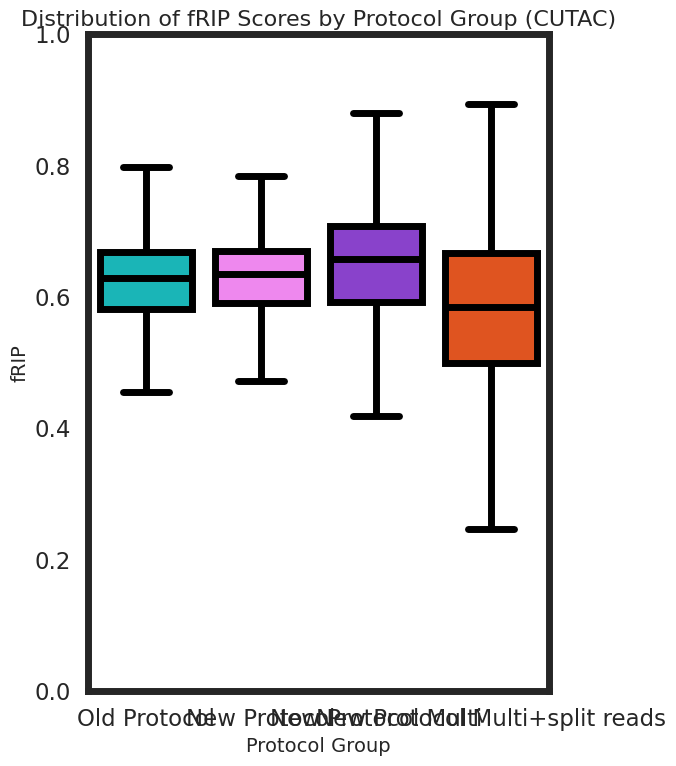

In [15]:
#This cell generates the boxplot of FRiP counts for Supplementary Figure 1B

protocol_order = [
    'Old Protocol',
    'New Protocol',
    'New Protocol Multi',
    'New Protocol Multi+split reads'
]
protocol_colors = {
    'Old Protocol':                   '#00CED1',
    'New Protocol':                   '#FF77FF',
    'New Protocol Multi':             '#8A2BE2',
    'New Protocol Multi+split reads': '#FF4500'
}

sns.set_style('white')
sns.set_context('talk')

plt.figure(figsize=(7, 8))
ax = sns.boxplot(
    data=barcode_frip_df,
    x='Protocol_Group',
    y='fRIP',
    order=protocol_order,
    palette=protocol_colors,
    showfliers=False,
    linewidth=5.0
)

# styling
for patch in ax.patches:
    patch.set_edgecolor('black')
    patch.set_linewidth(5.0)
for line in ax.lines:
    line.set_color('black')
    line.set_linewidth(5.0)
for spine in ax.spines.values():
    spine.set_linewidth(5.0)

plt.ylim(0, 1)
plt.xlabel('Protocol Group', fontsize=14)
plt.ylabel('fRIP', fontsize=14)
plt.title('Distribution of fRIP Scores by Protocol Group (CUTAC)', fontsize=16)
plt.tight_layout()

#plt.savefig(
#    '/location/for/figure/output/PolII_FRiP_Boxplot.png',
#    dpi=300
#)

plt.show()


In [16]:
#This cell computes a summary of the FRiP counts for Supplementary Figure 1B

# 1) Protocol groups as in the plot
protocol_order = [
    'Old Protocol',
    'New Protocol',
    'New Protocol Multi',
    'New Protocol Multi+split reads'
]

# 2) Build the summary
summary = []
for grp in protocol_order:
    vals = barcode_frip_df.loc[barcode_frip_df['Protocol_Group'] == grp, 'fRIP'].dropna().values
    n   = len(vals)
    q1  = np.quantile(vals, 0.25) if n > 0 else np.nan
    med = np.median(vals)         if n > 0 else np.nan
    q3  = np.quantile(vals, 0.75) if n > 0 else np.nan
    summary.append({
        'Protocol_Group': grp,
        'N':               n,
        'Q1 (25th)':       q1,
        'Median':          med,
        'Q3 (75th)':       q3
    })

summary_df = pd.DataFrame(summary)

# 3) Display
print("CUTAC fRIP Quartile Summary:")
print(summary_df.to_string(index=False))


CUTAC fRIP Quartile Summary:
                Protocol_Group     N  Q1 (25th)   Median  Q3 (75th)
                  Old Protocol  2940   0.582060 0.629284   0.668332
                  New Protocol  4439   0.590556 0.635204   0.670184
            New Protocol Multi 70546   0.592466 0.657412   0.707846
New Protocol Multi+split reads 37780   0.499255 0.584388   0.667358


In [26]:
#This cell computes the statistical comparisons of FRiP counts forbetween protocols for Supplementary Figure 1B


# ——— 1) Make sure barcode_frip_df exists with columns:
#       'Protocol_Group' and 'fRIP'

# ——— 2) Define your four protocol groups and all pairwise comparisons
protocol_groups = [
    'Old Protocol',
    'New Protocol',
    'New Protocol Multi',
    'New Protocol Multi+split reads'
]
comparison_pairs = list(combinations(protocol_groups, 2))

# ——— 3) Perform pairwise two‐sample t‐tests on the fRIP scores
results = []
for grp1, grp2 in comparison_pairs:
    x = barcode_frip_df.loc[barcode_frip_df['Protocol_Group'] == grp1, 'fRIP']
    y = barcode_frip_df.loc[barcode_frip_df['Protocol_Group'] == grp2, 'fRIP']
    n1, n2 = len(x), len(y)
    t_stat, p_val = ttest_ind(x, y, nan_policy='omit')
    results.append({
        'Comparison':   f"{grp1} vs {grp2}",
        'N1':           n1,
        'N2':           n2,
        't‑statistic':  t_stat,
        'p‑value':      p_val
    })

# ——— 4) Correct for multiple testing (Bonferroni) ———
p_vals = [r['p‑value'] for r in results]
reject, p_adj, _, _ = multipletests(p_vals, method='bonferroni')
for i, r in enumerate(results):
    r['Corrected p‑value'] = p_adj[i]
    r['Reject Null']      = reject[i]

# ——— 5) Build a DataFrame of results and display ———
stats_df = pd.DataFrame(results)
print(stats_df)


                                          Comparison     N1     N2  \
0                       Old Protocol vs New Protocol   2940   4439   
1                 Old Protocol vs New Protocol Multi   2940  70546   
2     Old Protocol vs New Protocol Multi+split reads   2940  37780   
3                 New Protocol vs New Protocol Multi   4439  70546   
4     New Protocol vs New Protocol Multi+split reads   4439  37780   
5  New Protocol Multi vs New Protocol Multi+split...  70546  37780   

   t‑statistic       p‑value  Corrected p‑value  Reject Null  
0    -1.942272  5.214214e-02       3.128528e-01        False  
1   -11.534068  9.443657e-31       5.666194e-30         True  
2    12.183854  4.344871e-34       2.606922e-33         True  
3   -11.415401  3.709861e-30       2.225916e-29         True  
4    17.459264  5.079060e-68       3.047436e-67         True  
5    69.996824  0.000000e+00       0.000000e+00         True  


In [ ]:
#This Cell loads the data for Figure 1C

# ——— 1) Load your “ReadCounts” tables ———
souper_star_H3K4me123_Combined = pd.read_csv(
    'souporcell_H3K4me1-2-3_Combined_ReadCounts.csv.gz',
    compression='gzip'
)
souper_star_H3K27me3_Combined = pd.read_csv(
    'souporcell_H3K27me3_Combined_ReadCounts.csv.gz',
    compression='gzip'
)

# ——— 2) Define your protocol‐group sample lists ———
K4me123_Old_Protocol = [ 
    'K4me123_D1-4', 'K4me123_D3-6', 'K4me123_3283', 'K4me123_3816', 
    'K4me123_D7-10', 'K4me123_D3-10', 'K4me123_D3-10_ConA', 'K4me123_D3-10_WGA', 
    'K4me123_3688', 'K4me123_3688_3773', 'K4me123_3703', 'K4me123_3724', 
    'K4me123_3891', 'K4me123_3956', 'K4me123_3956_2071', 'K4me123_3992', 
    'K4me123_Nuc_Stnd_No', 'K4me123_WC_Stnd_No'
]
K4me123_New_Protocol = [
    'K4me123_Nuc_PAGE_PK', 'K4me123_WC_PAGE_PK', 'K4me123_C1_240215'
]
K4me123_New_Protocol_Multi = [
    'K4me123_Multi_D3-10_ConA_Exp4', 'K4me123_Multi_D3-10_ConA_Exp5',
    'K4me123_Multi_D3-10_WGA_Exp4',  'K4me123_Multi_D3-10_WGA_Exp5',
    'K4me123_Multi_Female_ConA_Exp4','K4me123_Multi_Female_ConA_Exp5',
    'K4me123_Multi_Female_WGA_Exp4','K4me123_Multi_Female_WGA_Exp5',
    'K4me123_CUTAC_C1_240218'
]

K27me3_Old_Protocol = [
    'K27me3_D1-4','K27me3_Nuc_Stnd_No', 'K27me3_WC_Stnd_No',
    'K27me3_D7-10', 'K27me3_D3-6', 'K27me3_D3-10', 
    'K27me3_D3-10_ConA', 'K27me3_D3-10_WGA'
]
K27me3_New_Protocol = ['K27me3_Nuc_PAGE_PK', 'K27me3_WC_PAGE_PK']
K27me3_New_Protocol_Multi = [ 
    'K27me3_Multi_CUTAC_Female_Exp2','K27me3_Multi_D3-10_ConA_Exp4',
    'K27me3_Multi_D3-10_ConA_Exp5','K27me3_Multi_D3-10_WGA_Exp4',
    'K27me3_Multi_D3-10_WGA_Exp5','K27me3_Multi_Female_ConA_Exp4',
    'K27me3_Multi_Female_ConA_Exp5','K27me3_Multi_Female_WGA_Exp4',
    'K27me3_Multi_Female_WGA_Exp5','K27me3_CUTAC_C1_240218'
]

# ——— 3) Map each protocol group to its list of barcodes ———
k4_group_barcodes = {
    'K4 Old Protocol': souper_star_H3K4me123_Combined
        .loc[souper_star_H3K4me123_Combined['sample'].isin(K4me123_Old_Protocol), 'barcode']
        .tolist(),
    'K4 New Protocol': souper_star_H3K4me123_Combined
        .loc[souper_star_H3K4me123_Combined['sample'].isin(K4me123_New_Protocol), 'barcode']
        .tolist(),
    'K4 New Protocol Multi': souper_star_H3K4me123_Combined
        .loc[souper_star_H3K4me123_Combined['sample'].isin(K4me123_New_Protocol_Multi), 'barcode']
        .tolist(),
}

k27_group_barcodes = {
    'K27 Old Protocol': souper_star_H3K27me3_Combined
        .loc[souper_star_H3K27me3_Combined['sample'].isin(K27me3_Old_Protocol), 'barcode']
        .tolist(),
    'K27 New Protocol': souper_star_H3K27me3_Combined
        .loc[souper_star_H3K27me3_Combined['sample'].isin(K27me3_New_Protocol), 'barcode']
        .tolist(),
    'K27 New Protocol Multi': souper_star_H3K27me3_Combined
        .loc[souper_star_H3K27me3_Combined['sample'].isin(K27me3_New_Protocol_Multi), 'barcode']
        .tolist(),
}

# ——— 4) Load your BED files and concatenate for H3K4me1-2-3 ———
K4me123_Batch1_Full = pd.read_csv(
    'Full_hg38_Aligned_BED_Files/Batch_Beds_K4me123/K4me123_Batch1_Full.bed.gz',
    sep='\t', header=None, compression='gzip'
)
K4me123_Batch2_Full = pd.read_csv(
    'Full_hg38_Aligned_BED_Files/Batch_Beds_K4me123/K4me123_Batch2_Full.bed.gz',
    sep='\t', header=None, compression='gzip'
)
K4me123_Batch3_Full = pd.read_csv(
    'Full_hg38_Aligned_BED_Files/Batch_Beds_K4me123/K4me123_Batch3_Full.bed.gz',
    sep='\t', header=None, compression='gzip'
)
K4me123_Batch4_Full = pd.read_csv(
    'Full_hg38_Aligned_BED_Files/Batch_Beds_K4me123/K4me123_Batch4_Full.bed.gz',
    sep='\t', header=None, compression='gzip'
)
K4me123_Batch5_Full = pd.read_csv(
    'Full_hg38_Aligned_BED_Files/Batch_Beds_K4me123/K4me123_Batch5_Full.bed.gz',
    sep='\t', header=None, compression='gzip'
)
K4me123_Batch6_Full = pd.read_csv(
    'Full_hg38_Aligned_BED_Files/Batch_Beds_K4me123/K4me123_Batch6_Full.bed.gz',
    sep='\t', header=None, compression='gzip'
)
K4me123_Batch7_2in1_wCUTAC_Full = pd.read_csv(
    'Full_hg38_Aligned_BED_Files/Batch_Beds_K4me123/K4me123_Batch7_2in1_wCUTAC_Full.bed.gz',
    sep='\t', header=None, compression='gzip'
)
K4me123_Batch8_2in1_wCUTAC_Full = pd.read_csv(
    'Full_hg38_Aligned_BED_Files/Batch_Beds_K4me123/K4me123_Batch8_2in1_wCUTAC_Full.bed.gz',
    sep='\t', header=None, compression='gzip'
)
K4me123_Batch9_2in1_wCUTAC_Full = pd.read_csv(
    'Full_hg38_Aligned_BED_Files/Batch_Beds_K4me123/K4me123_Batch9_2in1_wCUTAC_Full.bed.gz',
    sep='\t', header=None, compression='gzip'
)
K4me123_Batch10_Full = pd.read_csv(
    'Full_hg38_Aligned_BED_Files/Batch_Beds_K4me123/K4me123_Batch10_Full.bed.gz',
    sep='\t', header=None, compression='gzip'
)
df_k4_bed = pd.concat([K4me123_Batch1_Full, K4me123_Batch2_Full, K4me123_Batch3_Full, K4me123_Batch4_Full, 
                       K4me123_Batch5_Full, K4me123_Batch6_Full, K4me123_Batch7_2in1_wCUTAC_Full,
                       K4me123_Batch8_2in1_wCUTAC_Full, K4me123_Batch9_2in1_wCUTAC_Full, K4me123_Batch10_Full], ignore_index=True)

# ——— 4) Load your BED files and concatenate for H3K27me3 ———
K27me3_Batch1_Full = pd.read_csv(
    'Full_hg38_Aligned_BED_Files/Batch_Beds_K27me3/K27me3_Batch1_Full.bed.gz',
    sep='\t', header=None, compression='gzip'
)
K27me3_Batch2_Full = pd.read_csv(
    'Full_hg38_Aligned_BED_Files/Batch_Beds_K27me3/K27me3_Batch2_Full.bed.gz',
    sep='\t', header=None, compression='gzip'
)
K27me3_Batch3_Full = pd.read_csv(
    'Full_hg38_Aligned_BED_Files/Batch_Beds_K27me3/K27me3_Batch3_Full.bed.gz',
    sep='\t', header=None, compression='gzip'
)
K27me3_Batch4_2in1_wCUTAC_Full = pd.read_csv(
    'Full_hg38_Aligned_BED_Files/Batch_Beds_K27me3/K27me3_Batch4_2in1_wCUTAC_Full.bed.gz',
    sep='\t', header=None, compression='gzip'
)
K27me3_Batch7_2in1_wCUTAC_Full = pd.read_csv(
    'Full_hg38_Aligned_BED_Files/Batch_Beds_K27me3/K27me3_Batch7_2in1_wCUTAC_Full.bed.gz',
    sep='\t', header=None, compression='gzip'
)
K27me3_Batch8_2in1_wCUTAC_Full = pd.read_csv(
    'Full_hg38_Aligned_BED_Files/Batch_Beds_K27me3/K27me3_Batch8_2in1_wCUTAC_Full.bed.gz',
    sep='\t', header=None, compression='gzip'
)
K27me3_Batch9_2in1_wCUTAC_Full = pd.read_csv(
    'Full_hg38_Aligned_BED_Files/Batch_Beds_K27me3/K27me3_Batch9_2in1_wCUTAC_Full.bed.gz',
    sep='\t', header=None, compression='gzip'
)
K27me3_Batch10_Full = pd.read_csv(
    'Full_hg38_Aligned_BED_Files/Batch_Beds_K27me3/K27me3_Batch10_Full.bed.gz',
    sep='\t', header=None, compression='gzip'
)

df_k27_bed = pd.concat([K27me3_Batch1_Full, K27me3_Batch2_Full, K27me3_Batch3_Full, K27me3_Batch4_2in1_wCUTAC_Full,
                       K27me3_Batch7_2in1_wCUTAC_Full, K27me3_Batch8_2in1_wCUTAC_Full, K27me3_Batch9_2in1_wCUTAC_Full,
                       K27me3_Batch10_Full], ignore_index=True)

# ——— 5) For each group, compute barcode‐wise counts from column 3 of the BEDs ———
counts_k4 = {
    grp: df_k4_bed.loc[df_k4_bed[3].isin(barcodes), 3].value_counts()
    for grp, barcodes in k4_group_barcodes.items()
}
counts_k27 = {
    grp: df_k27_bed.loc[df_k27_bed[3].isin(barcodes), 3].value_counts()
    for grp, barcodes in k27_group_barcodes.items()
}

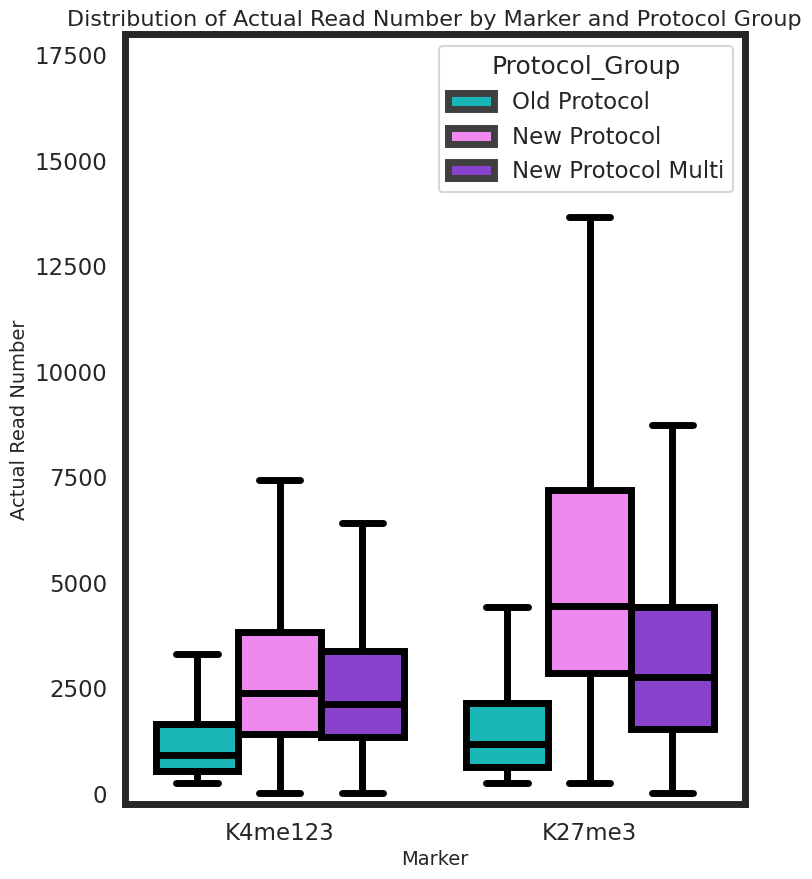

In [3]:
#This Cell generates the plot for Figure 1C


# ——— 1) Assuming you already have your counts_k4 and counts_k27 dicts ———
# counts_k4 = {'K4 Old Protocol': Series, 'K4 New Protocol': Series, 'K4 New Protocol Multi': Series}
# counts_k27 = {'K27 Old Protocol': Series, 'K27 New Protocol': Series, 'K27 New Protocol Multi': Series}

# -------------------------------------
# 2) Build a long‐form DataFrame for plotting
# -------------------------------------
records = []
# K4me123
for grp, series in counts_k4.items():
    proto = grp.split(' ', 1)[1]  # yields 'Old Protocol', etc.
    for cnt in series.values:
        records.append({
            'Marker': 'K4me123',
            'Protocol_Group': proto,
            'ReadCount': cnt
        })
# K27me3
for grp, series in counts_k27.items():
    proto = grp.split(' ', 1)[1]
    for cnt in series.values:
        records.append({
            'Marker': 'K27me3',
            'Protocol_Group': proto,
            'ReadCount': cnt
        })

df_plot = pd.DataFrame(records)

# -------------------------------------
# 3) Define plot order and colors exactly as in your example
# -------------------------------------
protocol_order  = ['Old Protocol', 'New Protocol', 'New Protocol Multi']
protocol_colors = {
    'Old Protocol':         '#00CED1',
    'New Protocol':         '#FF77FF',
    'New Protocol Multi':   '#8A2BE2'
}

# -------------------------------------
# 4) Draw the boxplot with heavy styling
# -------------------------------------
sns.set_style('white')    # no grid
sns.set_context('talk')

plt.figure(figsize=(8, 10))
ax = sns.boxplot(
    data=df_plot,
    x='Marker',
    y='ReadCount',
    hue='Protocol_Group',
    order=['K4me123', 'K27me3'],
    hue_order=protocol_order,
    palette=protocol_colors,
    showfliers=False,
    linewidth=5.0
)

# Apply custom styling to each box
for patch in ax.patches:
    patch.set_edgecolor('black')
    patch.set_linewidth(5.0)
    patch.set_hatch('')  # Remove any hatching

# Customize median lines, whiskers, etc.
for line in ax.lines:
    line.set_color('black')
    line.set_linewidth(5.0)

# Increase the frame (spine) thickness
for spine in ax.spines.values():
    spine.set_linewidth(5.0)

# Set y-axis limits
ax.set_ylim(-250, 18000)

# Set labels and title
plt.xlabel('Marker', fontsize=14)
plt.ylabel('Actual Read Number', fontsize=14)
plt.title('Distribution of Actual Read Number by Marker and Protocol Group', fontsize=16)

#plt.savefig(
#    '/location/for/figure/output/K4me123_K27me3_ReadCount_Boxplot.png',
#    dpi=300
#)

plt.show()


In [7]:
#This cell computes the a readcount summary for data from Figure 1C

# ——— 2) Compute N, Q1, Median, Q3 for each Marker × Protocol_Group
summary = (
    df_plot
    .groupby(['Marker', 'Protocol_Group'])['ReadCount']
    .agg(
        N='count',
        Q1=lambda x: x.quantile(0.25),
        Median='median',
        Q3=lambda x: x.quantile(0.75)
    )
    .reset_index()
)

# ——— 3) Display the results
print("Quartile summary for each Marker and Protocol_Group:")
print(summary.to_string(index=False))

# ——— 4) (Optional) Save to CSV
# summary.to_csv('ReadCount_Boxplot_Quartiles.csv', index=False)


Quartile summary for each Marker and Protocol_Group:
 Marker     Protocol_Group     N      Q1  Median     Q3
 K27me3       New Protocol  2900 2855.75  4435.5 7204.5
 K27me3 New Protocol Multi 68476 1537.00  2761.0 4416.0
 K27me3       Old Protocol 37295  638.00  1181.0 2150.0
K4me123       New Protocol 19329 1404.00  2378.0 3819.0
K4me123 New Protocol Multi 45335 1342.00  2133.0 3375.0
K4me123       Old Protocol 41273  526.00   903.0 1638.0


In [8]:
#This cell computes the statistical comparisons between protocols for Figure 1C

# Define the protocol groups and comparison pairs
protocol_groups = ['Old Protocol', 'New Protocol', 'New Protocol Multi']
comparison_pairs = [
    ('Old Protocol', 'New Protocol'),
    ('New Protocol', 'New Protocol Multi'),
    ('Old Protocol', 'New Protocol Multi')
]

results = []

# Loop over each marker (K4me123 and K27me3)
for marker in ['K4me123', 'K27me3']:
    df_sub = df_plot[df_plot['Marker'] == marker]
    
    for grp1, grp2 in comparison_pairs:
        sample1 = df_sub[df_sub['Protocol_Group'] == grp1]['ReadCount']
        sample2 = df_sub[df_sub['Protocol_Group'] == grp2]['ReadCount']
        
        n1, n2 = len(sample1), len(sample2)
        t_stat, p_val = ttest_ind(sample1, sample2, nan_policy='omit')
        
        results.append({
            'Marker': marker,
            'Comparison': f"{grp1} vs {grp2}",
            'N1': n1,
            'N2': n2,
            't‑statistic': t_stat,
            'p‑value': p_val
        })

# Extract p‑values and apply Bonferroni correction
p_vals = [r['p‑value'] for r in results]
reject, p_adj, _, _ = multipletests(p_vals, method='bonferroni')

# Attach corrected p‑values and decisions
for i, r in enumerate(results):
    r['Corrected p‑value'] = p_adj[i]
    r['Reject Null']     = reject[i]

# Build a DataFrame and save or display
stats_df = pd.DataFrame(results)
#output_path = "K4_K27_Protocol_Group_TTest_Results.csv"
#stats_df.to_csv(output_path, index=False)

#print(f"Results saved to {output_path}")
print(stats_df)



    Marker                          Comparison     N1     N2  t‑statistic  \
0  K4me123        Old Protocol vs New Protocol  41273  19329   -75.734536   
1  K4me123  New Protocol vs New Protocol Multi  19329  45335     1.595634   
2  K4me123  Old Protocol vs New Protocol Multi  41273  45335   -65.765430   
3   K27me3        Old Protocol vs New Protocol  37295   2900   -74.153079   
4   K27me3  New Protocol vs New Protocol Multi   2900  68476    23.560125   
5   K27me3  Old Protocol vs New Protocol Multi  37295  68476   -67.672684   

         p‑value  Corrected p‑value  Reject Null  
0   0.000000e+00       0.000000e+00         True  
1   1.105755e-01       6.634528e-01        False  
2   0.000000e+00       0.000000e+00         True  
3   0.000000e+00       0.000000e+00         True  
4  2.903789e-122      1.742273e-121         True  
5   0.000000e+00       0.000000e+00         True  


In [29]:
#This cell computes the H3K4me1-2-3 read numbers for Supplementray Figure 1A

# Load the initial data
souper_star_H3K4me123_Combined = pd.read_csv(
    'souporcell_H3K4me1-2-3_Combined_ReadCounts.csv.gz',
    compression='gzip'
)

# Define the sample strings
sample_strings = [
    'K4me123_Nuc_Stnd_No', 'K4me123_Nuc_Stnd_PK', 
    'K4me123_Nuc_PAGE_No', 'K4me123_Nuc_PAGE_PK',
    'K4me123_WC_Stnd_No', 'K4me123_WC_Stnd_PK', 
    'K4me123_WC_PAGE_No', 'K4me123_WC_PAGE_PK'
]

# Create a dictionary of barcodes for each sample
dict_barcodes = {
    sample: souper_star_H3K4me123_Combined[souper_star_H3K4me123_Combined['sample'] == sample]['barcode'].tolist()
    for sample in sample_strings
}

# Load the combined BED file
K4me123_all_data_combined = df_k4_bed.copy()

# Filter rows in the BED file by barcode
filtered_data = {
    sample: K4me123_all_data_combined[K4me123_all_data_combined[3].isin(barcodes)]
    for sample, barcodes in dict_barcodes.items()
}

# Count unique barcodes for each sample
barcode_counts = {
    sample: data[3].value_counts() for sample, data in filtered_data.items()
}

# Prepare data for box plot
boxplot_data = [counts.values for counts in barcode_counts.values()]

In [31]:
#This cell computes the H3K4me1-2-3 FRiPs for Supplementray Figure 1A

# Define the Peakset
peakset_bed = pybedtools.BedTool('H3K4me123_SEACR_Peaks.01.stringent.bed')

# Calculate fRIP for each barcode using `barcode_counts`
barcode_frip_data = []

for sample, counts in barcode_counts.items():
    # Create a PyBedTools object for the sample's barcodes
    sample_bed = pybedtools.BedTool.from_dataframe(filtered_data[sample][[0, 1, 2, 3]])
    
    # Intersect barcodes with peaks
    intersected = sample_bed.intersect(peakset_bed, wa=True)
    
    # Convert to a DataFrame for easier processing
    intersected_df = intersected.to_dataframe(header=None, names=[0, 1, 2, 3, 4, 5])
    
    # Count reads in peaks for each barcode
    reads_in_peaks = intersected_df[3].value_counts()
    
    # Calculate fRIP for each barcode using `barcode_counts`
    for barcode, total_reads in counts.items():  # Iterate through `barcode_counts`
        reads_in_peak = reads_in_peaks.get(barcode, 0)  # 0 if barcode not in peaks
        frip_score = reads_in_peak / total_reads if total_reads > 0 else 0
        
        # Store the fRIP and associated metadata
        barcode_frip_data.append({"Sample": sample, "Barcode": barcode, "fRIP": frip_score})

# Convert to a DataFrame
barcode_frip_df = pd.DataFrame(barcode_frip_data)

# Save or inspect the barcode-level fRIP DataFrame
print(barcode_frip_df.head())


                Sample                               Barcode      fRIP
0  K4me123_Nuc_Stnd_No  GGGAATGAAACATGATCGCTCATTTTCTCGTA-130  0.796523
1  K4me123_Nuc_Stnd_No  TCTTATTAAACATGATCGCTCATTTAATCTTA-130  0.802973
2  K4me123_Nuc_Stnd_No  TAGGCATGTCTGGCGACGCTCATTCAGGACGT-130  0.792340
3  K4me123_Nuc_Stnd_No  AAACGGTCCTTTAACACGCTCATTTTCTCGTA-130  0.810407
4  K4me123_Nuc_Stnd_No  TACTTGAAGGCACGGACGCTCATTTTCTCGTA-130  0.818644


/tmp/ipykernel_204566/4160215151.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


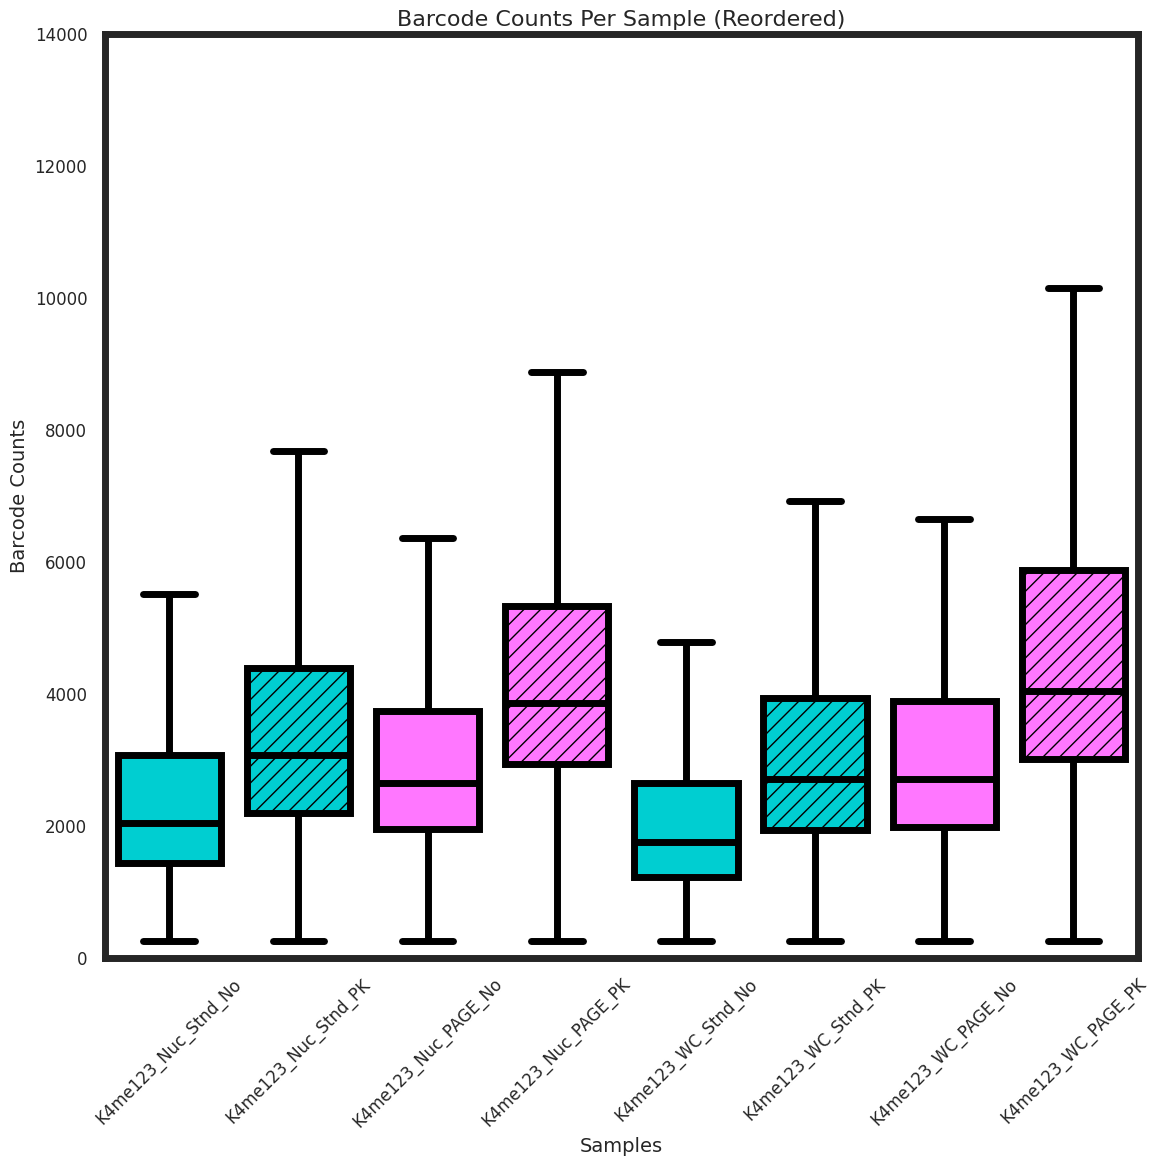

In [32]:
#This cell generates the H3K4me1-2-3 read number boxplot for Supplementray Figure 1A

sample_order = [
    'K4me123_Nuc_Stnd_No', 'K4me123_Nuc_Stnd_PK', 
    'K4me123_Nuc_PAGE_No', 'K4me123_Nuc_PAGE_PK',
    'K4me123_WC_Stnd_No', 'K4me123_WC_Stnd_PK', 
    'K4me123_WC_PAGE_No', 'K4me123_WC_PAGE_PK'
]
ordered_boxplot_data = [barcode_counts[sample] for sample in sample_order]

# Define box color mapping
white_boxes = ['K4me123_Nuc_Stnd_No', 'K4me123_Nuc_Stnd_PK', 'K4me123_WC_Stnd_No', 'K4me123_WC_Stnd_PK']
blue_boxes = ['K4me123_Nuc_PAGE_No', 'K4me123_Nuc_PAGE_PK', 'K4me123_WC_PAGE_No', 'K4me123_WC_PAGE_PK']
hashed_boxes = ['K4me123_Nuc_Stnd_PK', 'K4me123_Nuc_PAGE_PK', 'K4me123_WC_Stnd_PK', 'K4me123_WC_PAGE_PK']

# Assign colors to each individual sample
sample_colors = {sample: '#00CED1' if sample in white_boxes else '#FF77FF' for sample in sample_order}

# Prepare data for plotting
plot_data = []
for sample, counts in zip(sample_order, ordered_boxplot_data):
    for count in counts:
        plot_data.append({"Sample": sample, "Count": count})
plot_df = pd.DataFrame(plot_data)

# Create the figure and axes
fig, ax = plt.subplots(figsize=(12, 12))

# Create the box plot with manually applied colors
sns.boxplot(
    data=plot_df,
    x='Sample',
    y='Count',
    order=sample_order,
    linewidth=5.0,
    showfliers=False,
    ax=ax,
    palette=sample_colors,  # Map colors directly to samples
    dodge=False,
    legend=False  # Disable the legend
)

# Add diagonal hash lines for specific boxes
for patch, sample in zip(ax.patches, sample_order):
    if sample in hashed_boxes:
        # Add diagonal hash lines
        patch.set_hatch('//')
        patch.set_facecolor('#FF77FF' if sample in blue_boxes else '#00CED1')  # Restore correct color
        patch.set_edgecolor('black')  # Force box outline to black
        patch.set_linewidth(5.0)
    else:
        # Non-hashed boxes
        patch.set_facecolor('#FF77FF' if sample in blue_boxes else '#00CED1')
        patch.set_edgecolor('black')
        patch.set_linewidth(5.0)

# Final step: Add black outlines on top of all boxes
for patch in ax.patches:
    path = patch.get_path()
    trans = patch.get_transform()
    bbox = path.get_extents(trans)
    rect = plt.Rectangle(
        (bbox.xmin, bbox.ymin),  # Bottom-left corner
        bbox.width,              # Width of the box
        bbox.height,             # Height of the box
        facecolor="none",        # Transparent rectangle
        edgecolor="black",       # Black edge
        linewidth=5.0,           # Thickness of the black border
        zorder=10                # Place it on top of all elements
    )
    ax.add_patch(rect)

# Customize the box plot outlines, medians, and whiskers
for line in ax.lines:
    line.set_color('black')       # Set the color of the medians and whiskers
    line.set_linewidth(5.0)       # Set their line thickness

# Set axis labels and title
ax.set_ylim(0, 14000)
ax.set_ylabel('Barcode Counts', fontsize=14)
ax.set_xlabel('Samples', fontsize=14)
ax.set_title('Barcode Counts Per Sample (Reordered)', fontsize=16)
ax.tick_params(width=5.0, labelsize=12)
plt.xticks(rotation=45)

# Adjust frame thickness
for spine in ax.spines.values():
    spine.set_linewidth(5.0)

# Save the plot
plt.tight_layout()
#plt.savefig(
#    '/varidata/research/projects/janssens/Henikoff_Lab_Data/CD34_Experiments/Janssens_Lab_CD34_Data_Processing/Figure_Panels/K4me123_Rxn_Conditions_Boxplot_Customized.png',
#    dpi=300
#)
plt.show()


In [35]:
#This cell computes the H3K4me1-2-3 read number summary for Supplementray Figure 1A

# Compute quartiles for each sample
quartiles_results = []
for sample in sample_order:
    sample_counts = plot_df[plot_df['Sample'] == sample]['Count']
    Q1 = sample_counts.quantile(0.25)
    Q2 = sample_counts.median()  # Equivalent to Q2
    Q3 = sample_counts.quantile(0.75)
    
    quartiles_results.append({
        "Sample": sample,
        "Q1 (25th percentile)": Q1,
        "Q2 (Median)": Q2,
        "Q3 (75th percentile)": Q3
    })

# Convert results to a DataFrame and display
quartiles_df = pd.DataFrame(quartiles_results)

# Save quartiles as a CSV
#output_quartiles_path = "/varidata/research/projects/janssens/Henikoff_Lab_Data/CD34_Experiments/Janssens_Lab_CD34_Data_Processing/Figure_Panels/K4me123_Rxn_Conditions_Boxplot_Quartiles.csv"
#quartiles_df.to_csv(output_quartiles_path, index=False)

# Print quartile values
print("Quartile summary for each condition:")
print(quartiles_df)


Quartile summary for each condition:
                Sample  Q1 (25th percentile)  Q2 (Median)  \
0  K4me123_Nuc_Stnd_No               1434.50       2047.0   
1  K4me123_Nuc_Stnd_PK               2187.75       3071.0   
2  K4me123_Nuc_PAGE_No               1948.50       2653.0   
3  K4me123_Nuc_PAGE_PK               2932.50       3862.0   
4   K4me123_WC_Stnd_No               1229.50       1759.0   
5   K4me123_WC_Stnd_PK               1944.00       2709.0   
6   K4me123_WC_PAGE_No               1981.50       2705.0   
7   K4me123_WC_PAGE_PK               3019.75       4044.0   

   Q3 (75th percentile)  
0               3068.00  
1               4391.00  
2               3739.75  
3               5330.00  
4               2655.25  
5               3941.00  
6               3887.50  
7               5878.50  


In [33]:
#This cell computes the H3K4me1-2-3 read numbers summary statistics for Supplementray Figure 1A

# Define comparison groups
comparison_pairs = [
    ('K4me123_Nuc_Stnd_No', 'K4me123_Nuc_PAGE_No'),
    ('K4me123_Nuc_Stnd_PK', 'K4me123_Nuc_PAGE_PK'),
    ('K4me123_WC_Stnd_No', 'K4me123_WC_PAGE_No'),
    ('K4me123_WC_Stnd_PK', 'K4me123_WC_PAGE_PK'),
    ('K4me123_Nuc_Stnd_No', 'K4me123_Nuc_Stnd_PK'),
    ('K4me123_Nuc_PAGE_No', 'K4me123_Nuc_PAGE_PK'),
    ('K4me123_WC_Stnd_No', 'K4me123_WC_Stnd_PK'),
    ('K4me123_WC_PAGE_No', 'K4me123_WC_PAGE_PK'),
    ('K4me123_Nuc_Stnd_No', 'K4me123_WC_Stnd_No'),
    ('K4me123_Nuc_PAGE_No', 'K4me123_WC_PAGE_No'),
    ('K4me123_Nuc_Stnd_PK', 'K4me123_WC_Stnd_PK'),
    ('K4me123_Nuc_PAGE_PK', 'K4me123_WC_PAGE_PK')
]

# Perform t-tests and collect results
stats_results = []
for pair in comparison_pairs:
    # Extract fRIP scores for the two samples
    sample1 = barcode_frip_df[barcode_frip_df['Sample'] == pair[0]]['fRIP']
    sample2 = barcode_frip_df[barcode_frip_df['Sample'] == pair[1]]['fRIP']
    
    # Perform t-test
    t_stat, p_value = ttest_ind(sample1, sample2, equal_var=False)  # Welch's t-test
    
    # Collect results
    stats_results.append({
        "Comparison": f"{pair[0]} vs {pair[1]}",
        "t-statistic": t_stat,
        "p-value": p_value
    })

# Apply Bonferroni correction
p_values = [result['p-value'] for result in stats_results]
reject, pvals_corrected, _, _ = multipletests(p_values, method='bonferroni')

# Add corrected p-values and rejection decisions to the results
for i, result in enumerate(stats_results):
    result['Corrected p-value'] = pvals_corrected[i]
    result['Reject Null Hypothesis'] = reject[i]

# Save statistical results as a CSV
stats_df = pd.DataFrame(stats_results)
#stats_df.to_csv(
#    "/varidata/research/projects/janssens/Henikoff_Lab_Data/CD34_Experiments/Janssens_Lab_CD34_Data_Processing/Figure_Panels/K4me123_Rxn_Conditions_FRIP_Boxplot_Stats.csv", 
#    index=False
#)

/tmp/ipykernel_204566/2357694232.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


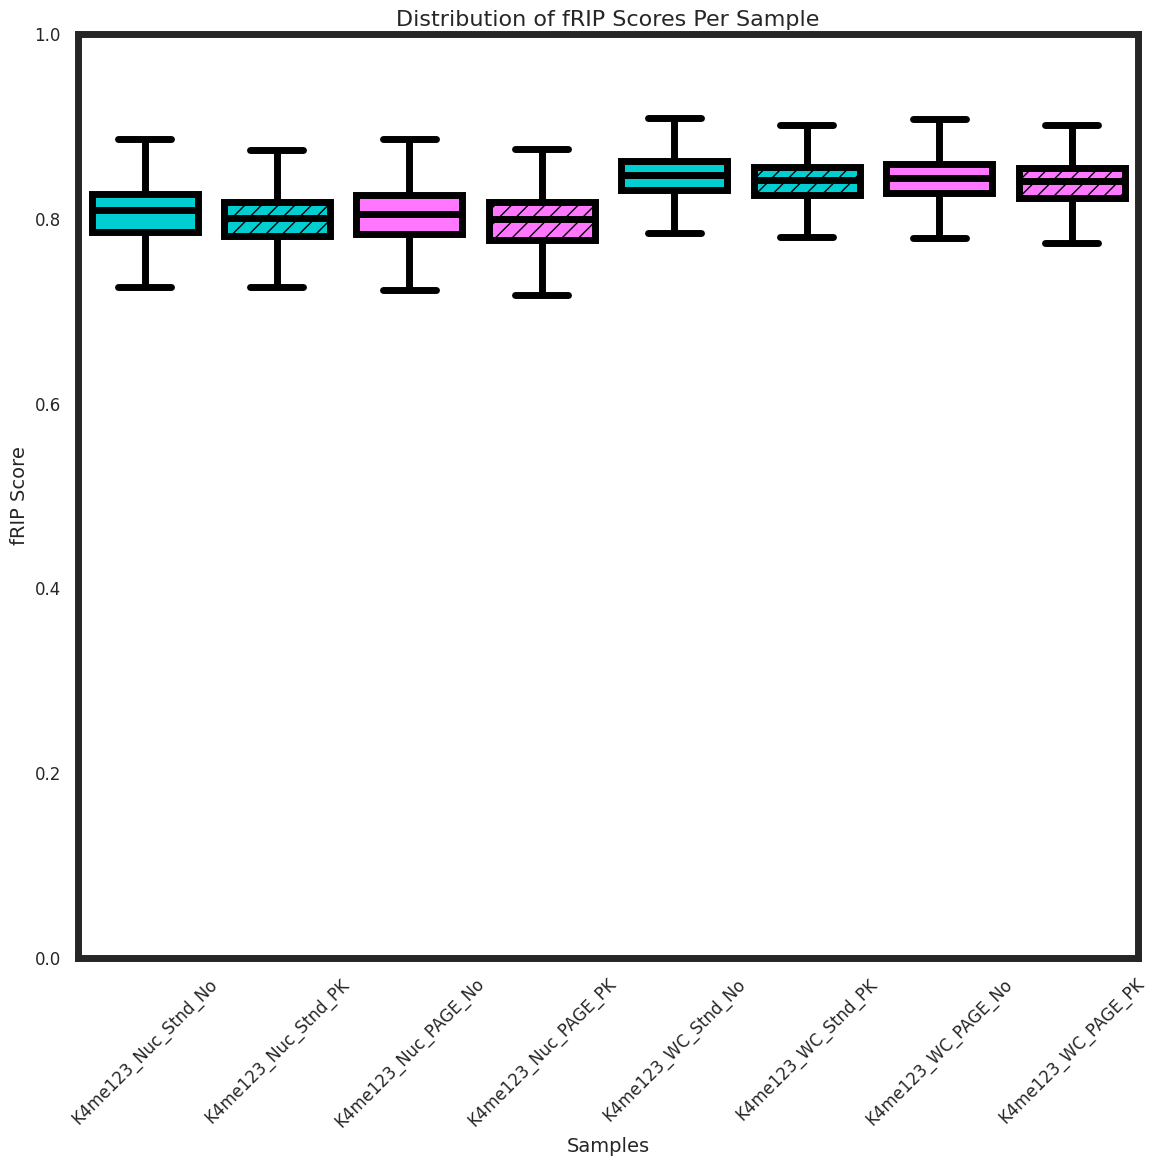

In [34]:
#This cell generates the H3K4me1-2-3 FRiP boxplot for Supplementray Figure 1A

# Define the reordered sample order and colors
sample_order = [
    'K4me123_Nuc_Stnd_No', 'K4me123_Nuc_Stnd_PK', 
    'K4me123_Nuc_PAGE_No', 'K4me123_Nuc_PAGE_PK',
    'K4me123_WC_Stnd_No', 'K4me123_WC_Stnd_PK', 
    'K4me123_WC_PAGE_No', 'K4me123_WC_PAGE_PK'
]

white_boxes = ['K4me123_Nuc_Stnd_No', 'K4me123_Nuc_Stnd_PK', 'K4me123_WC_Stnd_No', 'K4me123_WC_Stnd_PK']
blue_boxes = ['K4me123_Nuc_PAGE_No', 'K4me123_Nuc_PAGE_PK', 'K4me123_WC_PAGE_No', 'K4me123_WC_PAGE_PK']
hashed_boxes = ['K4me123_Nuc_Stnd_PK', 'K4me123_Nuc_PAGE_PK', 'K4me123_WC_Stnd_PK', 'K4me123_WC_PAGE_PK']

# Assign colors to each sample
sample_colors = {sample: '#00CED1' if sample in white_boxes else '#FF77FF' for sample in sample_order}

# Create the figure and axes
fig, ax = plt.subplots(figsize=(12, 12))

# Create the box plot to show the distribution of fRIP scores per sample
sns.boxplot(
    data=barcode_frip_df,  # Use barcode-level fRIP data
    x='Sample',
    y='fRIP',
    order=sample_order,
    linewidth=5.0,
    showfliers=False,
    ax=ax,
    palette=sample_colors,  # Apply custom sample colors
    dodge=False,
    legend=False
)

# Add diagonal hash lines for specific boxes
for patch, sample in zip(ax.patches, sample_order):
    if sample in hashed_boxes:
        patch.set_hatch('//')
        patch.set_facecolor('#FF77FF' if sample in blue_boxes else '#00CED1')
        patch.set_edgecolor('black')
        patch.set_linewidth(5.0)
    else:
        patch.set_facecolor('#FF77FF' if sample in blue_boxes else '#00CED1')
        patch.set_edgecolor('black')
        patch.set_linewidth(5.0)

# Add black outlines on all boxes
for patch in ax.patches:
    path = patch.get_path()
    trans = patch.get_transform()
    bbox = path.get_extents(trans)
    rect = plt.Rectangle(
        (bbox.xmin, bbox.ymin),
        bbox.width,
        bbox.height,
        facecolor="none",
        edgecolor="black",
        linewidth=5.0,
        zorder=10
    )
    ax.add_patch(rect)

# Customize the box plot outlines, medians, and whiskers
for line in ax.lines:
    line.set_color('black')       # Set the color of the medians and whiskers
    line.set_linewidth(5.0)       # Set their line thickness

# Customize the plot
ax.set_ylim(0, 1)  # fRIP scores are fractions
ax.set_ylabel('fRIP Score', fontsize=14)
ax.set_xlabel('Samples', fontsize=14)
ax.set_title('Distribution of fRIP Scores Per Sample', fontsize=16)
ax.tick_params(width=5.0, labelsize=12)
plt.xticks(rotation=45)

# Adjust frame thickness
for spine in ax.spines.values():
    spine.set_linewidth(5.0)

# Save the plot
plt.tight_layout()
#plt.savefig(
#    '/varidata/research/projects/janssens/Henikoff_Lab_Data/CD34_Experiments/Janssens_Lab_CD34_Data_Processing/Figure_Panels/K4me123_Rxn_Conditions_FRIP_Boxplot_Customized.png',
#    dpi=300
#)
plt.show()


In [36]:
#This cell computes the H3K27me3 read numberd for Supplementray Figure 1A

# Load the initial data
souper_star_H3K27me3_Combined = pd.read_csv(
    'souporcell_H3K27me3_Combined_ReadCounts.csv.gz',
    compression='gzip'
)

# Define the sample strings
sample_strings = [
    'K27me3_Nuc_Stnd_No', 'K27me3_Nuc_Stnd_PK', 
    'K27me3_Nuc_PAGE_No', 'K27me3_Nuc_PAGE_PK',
    'K27me3_WC_Stnd_No', 'K27me3_WC_Stnd_PK', 
    'K27me3_WC_PAGE_No', 'K27me3_WC_PAGE_PK'
]

# Create a dictionary of barcodes for each sample
dict_barcodes = {
    sample: souper_star_H3K27me3_Combined[souper_star_H3K27me3_Combined['sample'] == sample]['barcode'].tolist()
    for sample in sample_strings
}

# Load the combined BED file
K27me3_all_data_combined = df_k27_bed.copy()

# Filter rows in the BED file by barcode
filtered_data = {
    sample: K27me3_all_data_combined[K27me3_all_data_combined[3].isin(barcodes)]
    for sample, barcodes in dict_barcodes.items()
}

# Count unique barcodes for each sample
barcode_counts = {
    sample: data[3].value_counts() for sample, data in filtered_data.items()
}

# Prepare data for box plot
boxplot_data = [counts.values for counts in barcode_counts.values()]

In [37]:
#This cell computes the H3K27me3 FRiPs for Supplementray Figure 1A

# Define the peakset 
peakset_bed = pybedtools.BedTool('H3K27me3_SEACR_Peaks.01.stringent.bed')

# Calculate fRIP for each barcode using `barcode_counts`
barcode_frip_data = []

for sample, counts in barcode_counts.items():
    # Create a PyBedTools object for the sample's barcodes
    sample_bed = pybedtools.BedTool.from_dataframe(filtered_data[sample][[0, 1, 2, 3]])
    
    # Intersect barcodes with peaks
    intersected = sample_bed.intersect(peakset_bed, wa=True)
    
    # Convert to a DataFrame for easier processing
    intersected_df = intersected.to_dataframe(header=None, names=[0, 1, 2, 3, 4, 5])
    
    # Count reads in peaks for each barcode
    reads_in_peaks = intersected_df[3].value_counts()
    
    # Calculate fRIP for each barcode using `barcode_counts`
    for barcode, total_reads in counts.items():  # Iterate through `barcode_counts`
        reads_in_peak = reads_in_peaks.get(barcode, 0)  # 0 if barcode not in peaks
        frip_score = reads_in_peak / total_reads if total_reads > 0 else 0
        
        # Store the fRIP and associated metadata
        barcode_frip_data.append({"Sample": sample, "Barcode": barcode, "fRIP": frip_score})

# Convert to a DataFrame
barcode_frip_df = pd.DataFrame(barcode_frip_data)

# Save or inspect the barcode-level fRIP DataFrame
print(barcode_frip_df.head())


               Sample                              Barcode      fRIP
0  K27me3_Nuc_Stnd_No  TGGGTTTCAAGGAGTAATTCAGAATATAGCCT-28  0.610599
1  K27me3_Nuc_Stnd_No  GCTACGCTTGATTGTTATTCAGAACAGGACGT-28  0.503159
2  K27me3_Nuc_Stnd_No  GACTTAGTCTTTAACAATTCAGAATTCTCGTA-28  0.640642
3  K27me3_Nuc_Stnd_No  CGGTTCCCCGCCAGATATTCAGAACAGGACGT-28  0.707643
4  K27me3_Nuc_Stnd_No  TACACCTCCAGCAACGATTCAGAACCTATCCT-28  0.749121


/tmp/ipykernel_204566/1699658920.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


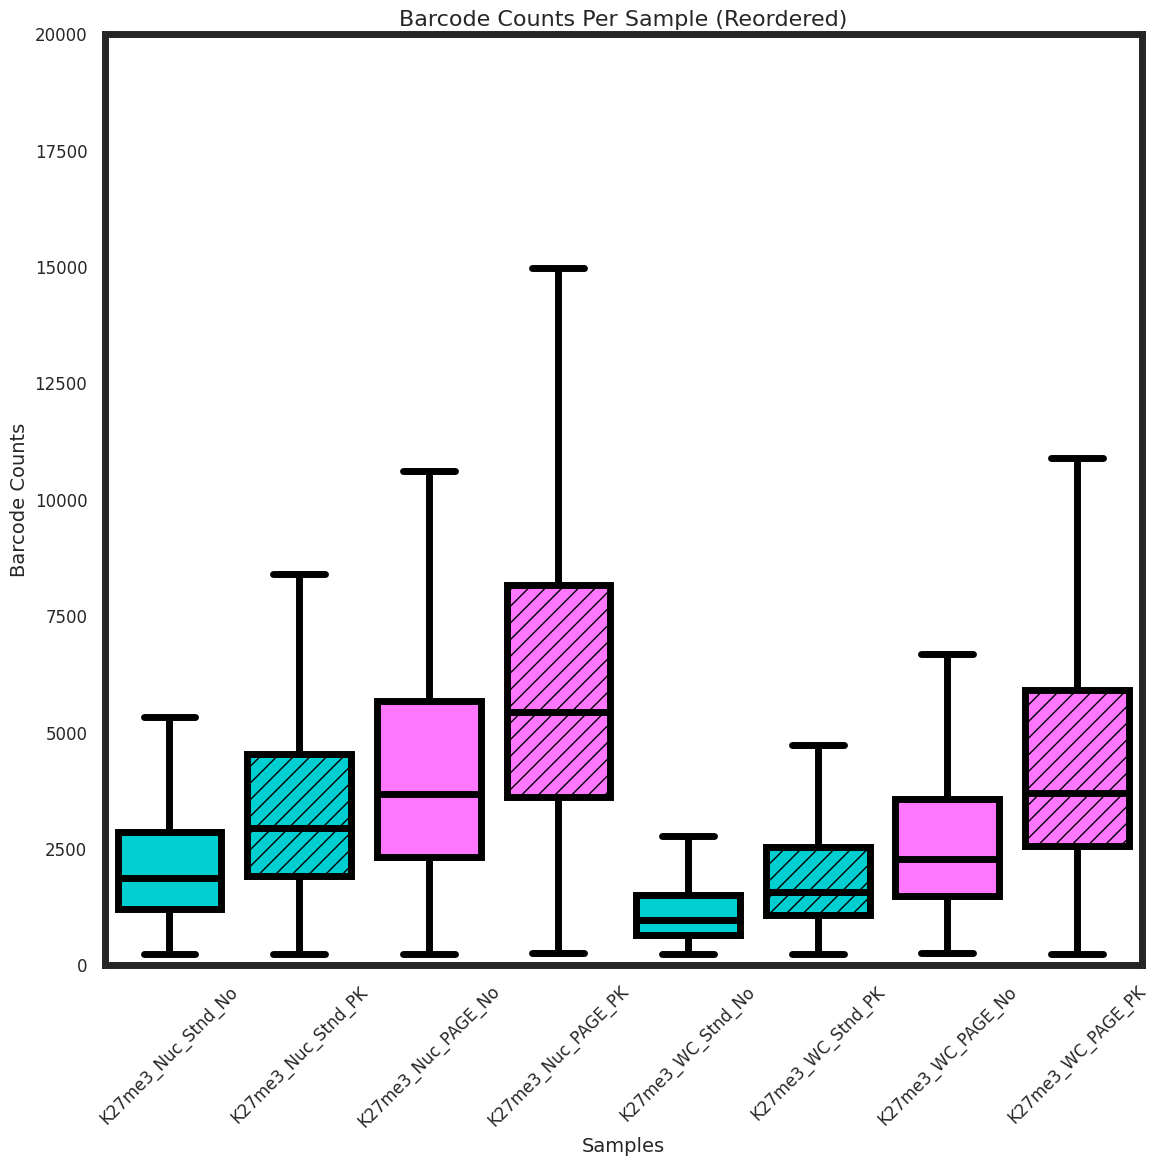

In [38]:
#This cell generates the H3K27me3 read number boxplot for Supplementray Figure 1A

# Define the reordered sample order
sample_order = [
    'K27me3_Nuc_Stnd_No', 'K27me3_Nuc_Stnd_PK', 
    'K27me3_Nuc_PAGE_No', 'K27me3_Nuc_PAGE_PK',
    'K27me3_WC_Stnd_No', 'K27me3_WC_Stnd_PK', 
    'K27me3_WC_PAGE_No', 'K27me3_WC_PAGE_PK'
]
ordered_boxplot_data = [barcode_counts[sample] for sample in sample_order]

# Define box color mapping
white_boxes = ['K27me3_Nuc_Stnd_No', 'K27me3_Nuc_Stnd_PK', 'K27me3_WC_Stnd_No', 'K27me3_WC_Stnd_PK']
blue_boxes = ['K27me3_Nuc_PAGE_No', 'K27me3_Nuc_PAGE_PK', 'K27me3_WC_PAGE_No', 'K27me3_WC_PAGE_PK']
hashed_boxes = ['K27me3_Nuc_Stnd_PK', 'K27me3_Nuc_PAGE_PK', 'K27me3_WC_Stnd_PK', 'K27me3_WC_PAGE_PK']

# Assign colors to each individual sample
sample_colors = {sample: '#00CED1' if sample in white_boxes else '#FF77FF' for sample in sample_order}

# Prepare data for plotting
plot_data = []
for sample, counts in zip(sample_order, ordered_boxplot_data):
    for count in counts:
        plot_data.append({"Sample": sample, "Count": count})
plot_df = pd.DataFrame(plot_data)

# Create the figure and axes
fig, ax = plt.subplots(figsize=(12, 12))

# Create the box plot with manually applied colors
sns.boxplot(
    data=plot_df,
    x='Sample',
    y='Count',
    order=sample_order,
    linewidth=5.0,
    showfliers=False,
    ax=ax,
    palette=sample_colors,  # Map colors directly to samples
    dodge=False,
    legend=False  # Disable the legend
)

# Add diagonal hash lines for specific boxes
for patch, sample in zip(ax.patches, sample_order):
    if sample in hashed_boxes:
        # Add diagonal hash lines
        patch.set_hatch('//')
        patch.set_facecolor('#FF77FF' if sample in blue_boxes else '#00CED1')  # Restore correct color
        patch.set_edgecolor('black')  # Force box outline to black
        patch.set_linewidth(5.0)
    else:
        # Non-hashed boxes
        patch.set_facecolor('#FF77FF' if sample in blue_boxes else '#00CED1')
        patch.set_edgecolor('black')
        patch.set_linewidth(5.0)

# Final step: Add black outlines on top of all boxes
for patch in ax.patches:
    path = patch.get_path()
    trans = patch.get_transform()
    bbox = path.get_extents(trans)
    rect = plt.Rectangle(
        (bbox.xmin, bbox.ymin),  # Bottom-left corner
        bbox.width,              # Width of the box
        bbox.height,             # Height of the box
        facecolor="none",        # Transparent rectangle
        edgecolor="black",       # Black edge
        linewidth=5.0,           # Thickness of the black border
        zorder=10                # Place it on top of all elements
    )
    ax.add_patch(rect)

# Customize the box plot outlines, medians, and whiskers
for line in ax.lines:
    line.set_color('black')       # Set the color of the medians and whiskers
    line.set_linewidth(5.0)       # Set their line thickness

# Set axis labels and title
ax.set_ylim(0, 20000)
ax.set_ylabel('Barcode Counts', fontsize=14)
ax.set_xlabel('Samples', fontsize=14)
ax.set_title('Barcode Counts Per Sample (Reordered)', fontsize=16)
ax.tick_params(width=5.0, labelsize=12)
plt.xticks(rotation=45)

# Adjust frame thickness
for spine in ax.spines.values():
    spine.set_linewidth(5.0)

# Save the plot
plt.tight_layout()
#plt.savefig(
#    '/varidata/research/projects/janssens/Henikoff_Lab_Data/CD34_Experiments/Janssens_Lab_CD34_Data_Processing/Figure_Panels/K27me3_Rxn_Conditions_Boxplot_Customized.png',
#    dpi=300
#)
plt.show()


In [39]:
#This cell computes the H3K27me3 read number summary for Supplementray Figure 1A

# Compute quartiles for each sample
quartiles_results = []
for sample in sample_order:
    sample_counts = plot_df[plot_df['Sample'] == sample]['Count']
    Q1 = sample_counts.quantile(0.25)
    Q2 = sample_counts.median()  # Equivalent to Q2
    Q3 = sample_counts.quantile(0.75)
    
    quartiles_results.append({
        "Sample": sample,
        "Q1 (25th percentile)": Q1,
        "Q2 (Median)": Q2,
        "Q3 (75th percentile)": Q3
    })

# Convert results to a DataFrame and display
quartiles_df = pd.DataFrame(quartiles_results)

# Save quartiles as a CSV
#output_quartiles_path = "/varidata/research/projects/janssens/Henikoff_Lab_Data/CD34_Experiments/Janssens_Lab_CD34_Data_Processing/Figure_Panels/K4me123_Rxn_Conditions_Boxplot_Quartiles.csv"
#quartiles_df.to_csv(output_quartiles_path, index=False)

# Print quartile values
print("Quartile summary for each condition:")
print(quartiles_df)


Quartile summary for each condition:
               Sample  Q1 (25th percentile)  Q2 (Median)  Q3 (75th percentile)
0  K27me3_Nuc_Stnd_No               1204.00       1869.0               2855.00
1  K27me3_Nuc_Stnd_PK               1908.00       2942.0               4542.00
2  K27me3_Nuc_PAGE_No               2326.50       3668.5               5685.75
3  K27me3_Nuc_PAGE_PK               3605.25       5445.0               8163.75
4   K27me3_WC_Stnd_No                656.00        978.0               1504.00
5   K27me3_WC_Stnd_PK               1074.50       1575.0               2542.50
6   K27me3_WC_PAGE_No               1490.75       2276.5               3572.25
7   K27me3_WC_PAGE_PK               2553.50       3703.0               5908.25


/tmp/ipykernel_204566/548142996.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


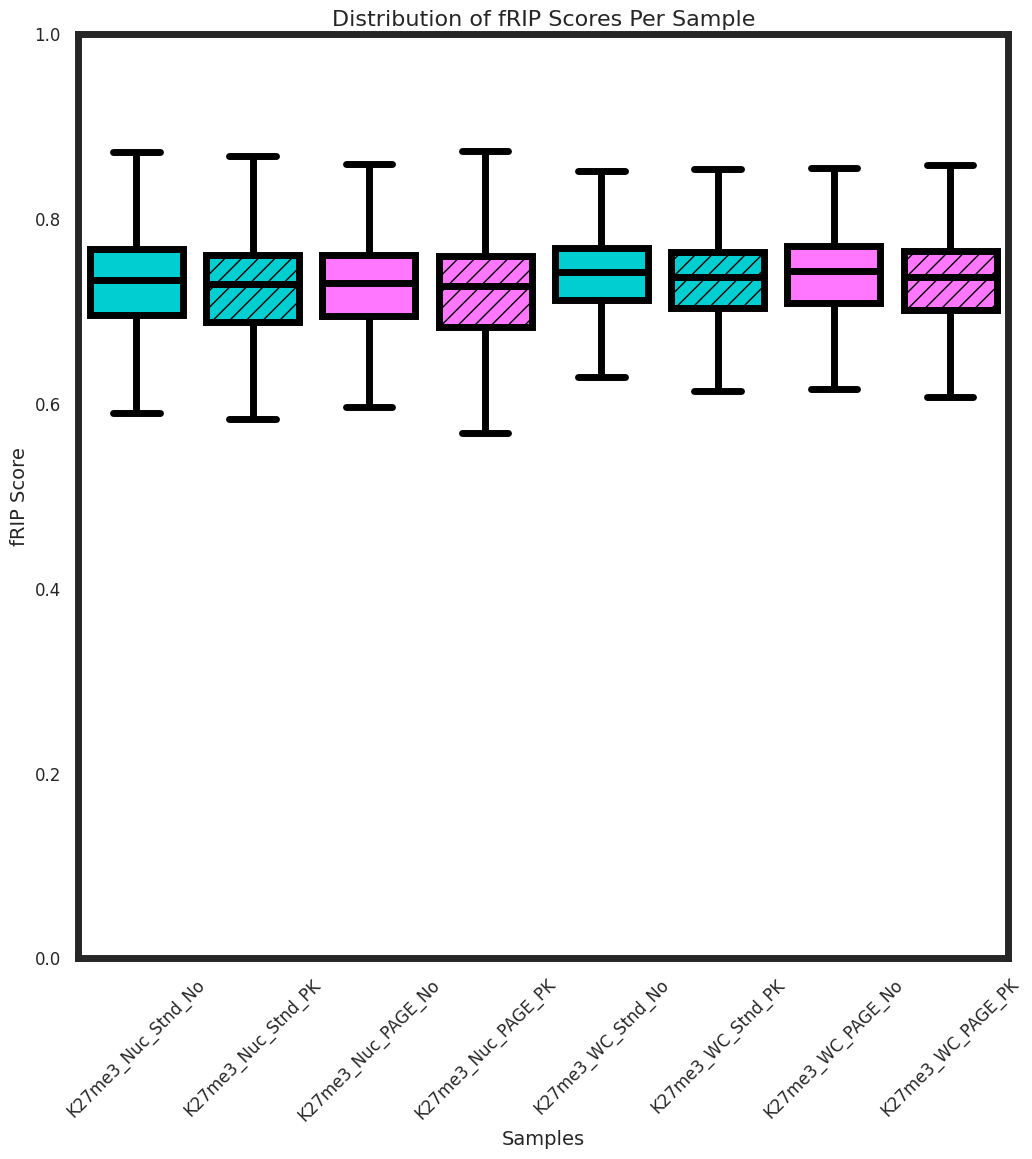

fRIP box plot saved successfully.


In [40]:
#This cell generates the H3K27me3 FRiPS boxplot for Supplementray Figure 1A

# Define the reordered sample order and colors
sample_order = [
    'K27me3_Nuc_Stnd_No', 'K27me3_Nuc_Stnd_PK', 
    'K27me3_Nuc_PAGE_No', 'K27me3_Nuc_PAGE_PK',
    'K27me3_WC_Stnd_No', 'K27me3_WC_Stnd_PK', 
    'K27me3_WC_PAGE_No', 'K27me3_WC_PAGE_PK'
]

# Define box color mapping
white_boxes = ['K27me3_Nuc_Stnd_No', 'K27me3_Nuc_Stnd_PK', 'K27me3_WC_Stnd_No', 'K27me3_WC_Stnd_PK']
blue_boxes = ['K27me3_Nuc_PAGE_No', 'K27me3_Nuc_PAGE_PK', 'K27me3_WC_PAGE_No', 'K27me3_WC_PAGE_PK']
hashed_boxes = ['K27me3_Nuc_Stnd_PK', 'K27me3_Nuc_PAGE_PK', 'K27me3_WC_Stnd_PK', 'K27me3_WC_PAGE_PK']

# Assign colors to each sample
sample_colors = {sample: '#00CED1' if sample in white_boxes else '#FF77FF' for sample in sample_order}

# Create the figure and axes
fig, ax = plt.subplots(figsize=(12, 12))

# Create the box plot to show the distribution of fRIP scores per sample
sns.boxplot(
    data=barcode_frip_df,  # Use barcode-level fRIP data
    x='Sample',
    y='fRIP',
    order=sample_order,
    linewidth=5.0,
    showfliers=False,
    ax=ax,
    palette=sample_colors,  # Apply custom sample colors
    dodge=False,
    legend=False
)

# Add diagonal hash lines for specific boxes
for patch, sample in zip(ax.patches, sample_order):
    if sample in hashed_boxes:
        patch.set_hatch('//')
        patch.set_facecolor('#FF77FF' if sample in blue_boxes else '#00CED1')
        patch.set_edgecolor('black')
        patch.set_linewidth(5.0)
    else:
        patch.set_facecolor('#FF77FF' if sample in blue_boxes else '#00CED1')
        patch.set_edgecolor('black')
        patch.set_linewidth(5.0)

# Add black outlines on all boxes
for patch in ax.patches:
    path = patch.get_path()
    trans = patch.get_transform()
    bbox = path.get_extents(trans)
    rect = plt.Rectangle(
        (bbox.xmin, bbox.ymin),
        bbox.width,
        bbox.height,
        facecolor="none",
        edgecolor="black",
        linewidth=5.0,
        zorder=10
    )
    ax.add_patch(rect)

# Customize the box plot outlines, medians, and whiskers
for line in ax.lines:
    line.set_color('black')       # Set the color of the medians and whiskers
    line.set_linewidth(5.0)       # Set their line thickness

# Customize the plot
ax.set_ylim(0, 1)  # fRIP scores are fractions
ax.set_ylabel('fRIP Score', fontsize=14)
ax.set_xlabel('Samples', fontsize=14)
ax.set_title('Distribution of fRIP Scores Per Sample', fontsize=16)
ax.tick_params(width=5.0, labelsize=12)
plt.xticks(rotation=45)

# Adjust frame thickness
for spine in ax.spines.values():
    spine.set_linewidth(5.0)

# Save the plot
#plt.tight_layout()
#plt.savefig(
#    '/varidata/research/projects/janssens/Henikoff_Lab_Data/CD34_Experiments/Janssens_Lab_CD34_Data_Processing/Figure_Panels/K27me3_Rxn_Conditions_FRIP_Boxplot_Customized.png',
#    dpi=300
#)
plt.show()

print("fRIP box plot saved successfully.")


In [9]:
#This cell generates the FRiP counts for Supplementary Figure 1C

# ——— 1) Load peakset BEDs as BedTools ———
peakset_k4  = pybedtools.BedTool('H3K4me123_SEACR_Peaks.01.stringent.bed')

peakset_k27 = pybedtools.BedTool('H3K27me3_SEACR_Peaks.01.stringent.bed')

# ——— 2) Calculate fRIP for each barcode in each group ———
barcode_frip_data = []

for marker, (group_counts, peakset, df_bed) in [
    ('K4me123', (counts_k4,  peakset_k4,  df_k4_bed)),
    ('K27me3', (counts_k27, peakset_k27, df_k27_bed))
]:
    for grp, counts in group_counts.items():
        # Build a BedTool of all reads for this group
        subset = df_bed[df_bed[3].isin(counts.index)][[0,1,2,3]]
        sample_bed = pybedtools.BedTool.from_dataframe(subset)

        # Intersect with peaks (keep sample entries)
        intersected = sample_bed.intersect(peakset, wa=True)
        # Convert to DataFrame; columns: chr, start, end, barcode
        inter_df = intersected.to_dataframe(names=['chr','start','end','barcode'])

        # Count reads in peaks by barcode
        reads_in_peaks = inter_df['barcode'].value_counts()

        # Compute FRiP per barcode
        for barcode, total_reads in counts.items():
            in_peak = reads_in_peaks.get(barcode, 0)
            frip = in_peak / total_reads if total_reads > 0 else 0.0
            barcode_frip_data.append({
                'Marker': marker,
                'Protocol_Group': grp,
                'Barcode': barcode,
                'Total_Reads': int(total_reads),
                'Reads_in_Peaks': int(in_peak),
                'fRIP': frip
            })

# ——— 3) Assemble into a DataFrame ———
barcode_frip_df = pd.DataFrame(barcode_frip_data)
print(barcode_frip_df.head())

    Marker   Protocol_Group                               Barcode  \
0  K4me123  K4 Old Protocol  AAACGGTCTCCGAGTTTCCGGAGACAGGACGT-145   
1  K4me123  K4 Old Protocol  TCAGCTATTTAACTTGTCCGGAGATAATCTTA-145   
2  K4me123  K4 Old Protocol    CTCTCTACGAACTCGAATTACTCGGTACTGAC-4   
3  K4me123  K4 Old Protocol  AAGAGGCAATTACCGTTCCGGAGACAGGACGT-165   
4  K4me123  K4 Old Protocol  GGGAATGAAACATGATCGCTCATTTTCTCGTA-130   

   Total_Reads  Reads_in_Peaks      fRIP  
0        56952           27138  0.476507  
1        52993           27692  0.522560  
2        45265           26725  0.590412  
3        44081           37350  0.847304  
4        41587           33125  0.796523  


NameError: name 'mpatches' is not defined

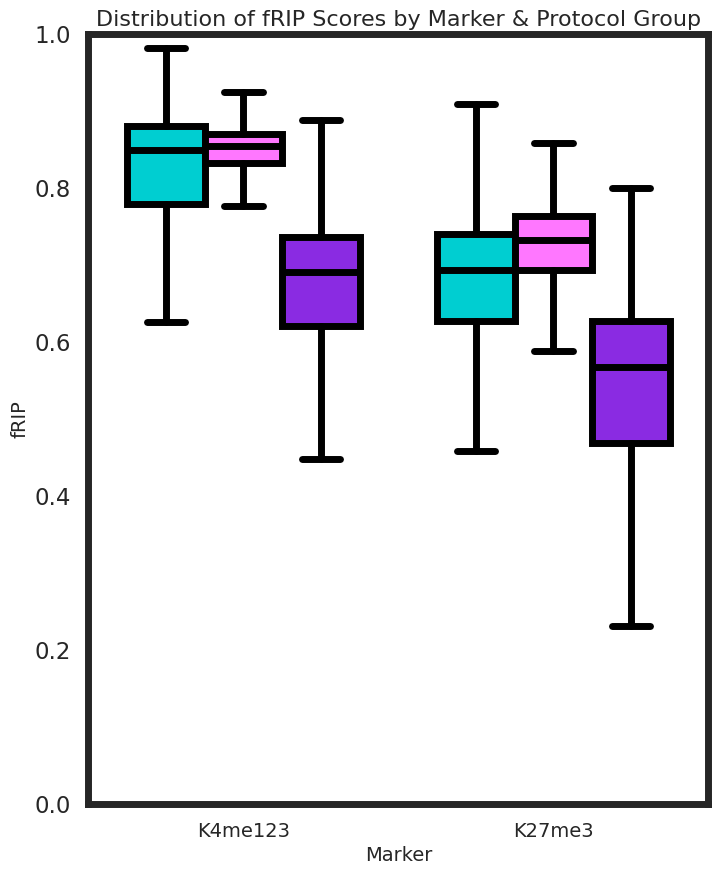

In [10]:
#This cell generates the boxplot of FRiP counts for Supplementary Figure 1C

# 1) Define the exact Protocol_Group values for K4 and K27
k4_groups  = ['K4 Old Protocol', 'K4 New Protocol', 'K4 New Protocol Multi']
k27_groups = ['K27 Old Protocol', 'K27 New Protocol', 'K27 New Protocol Multi']

# 2) Extract fRIP arrays in that order
arrays_k4  = [
    barcode_frip_df.loc[barcode_frip_df['Protocol_Group']==grp, 'fRIP'].values
    for grp in k4_groups
]
arrays_k27 = [
    barcode_frip_df.loc[barcode_frip_df['Protocol_Group']==grp, 'fRIP'].values
    for grp in k27_groups
]
data_arrays = arrays_k4 + arrays_k27

# 3) Compute x‑positions with wider spacing and narrower boxes
centers = [0.5, 2.5]
offset = 0.5               # increased offset for separation
positions = []
for c in centers:
    positions.extend([c - offset, c, c + offset])

width = 0.5                # narrower box width

# 4) Define colors
protocol_order  = ['Old Protocol', 'New Protocol', 'New Protocol Multi']
protocol_colors = {
    'Old Protocol':       '#00CED1',
    'New Protocol':       '#FF77FF',
    'New Protocol Multi': '#8A2BE2'
}
colors = [protocol_colors[g.split(' ',1)[1]] for g in k4_groups + k27_groups]

# 5) Plot
fig, ax = plt.subplots(figsize=(8, 10))

bp = ax.boxplot(
    data_arrays,
    positions=positions,
    widths=width,
    patch_artist=True,
    showfliers=False
)

# 6) Style
for box, fc in zip(bp['boxes'], colors):
    box.set(facecolor=fc, edgecolor='black', linewidth=5)
for whisker in bp['whiskers']:
    whisker.set(color='black', linewidth=5)
for cap in bp['caps']:
    cap.set(color='black', linewidth=5)
for median in bp['medians']:
    median.set(color='black', linewidth=5)

# 7) Y‑axis range
ax.set_ylim(0, 1)

# 8) Frame & ticks
for spine in ax.spines.values():
    spine.set_linewidth(5)
ax.set_xticks(centers)
ax.set_xticklabels(['K4me123', 'K27me3'], fontsize=14)

# 9) Labels & title
ax.set_xlabel('Marker', fontsize=14)
ax.set_ylabel('fRIP', fontsize=14)
ax.set_title('Distribution of fRIP Scores by Marker & Protocol Group', fontsize=16)

# 10) Manual legend
patches = [
    mpatches.Patch(facecolor=protocol_colors[g], edgecolor='black', label=g)
    for g in protocol_order
]
ax.legend(handles=patches, title='Protocol Group',
          fontsize=12, title_fontsize=14, loc='upper right')

plt.tight_layout()

#plt.savefig(
#    '/location/for/figure/output/K4me123_K27me3_FRiP_Boxplot.png',
#    dpi=300
#)
plt.show()

In [11]:
#This cell computes a summary of the FRiP counts for Supplementary Figure 1C

# 1) Re‑define your exact Protocol_Group values
k4_groups  = ['K4 Old Protocol', 'K4 New Protocol', 'K4 New Protocol Multi']
k27_groups = ['K27 Old Protocol','K27 New Protocol','K27 New Protocol Multi']

# 2) Pull out the fRIP arrays from barcode_frip_df
arrays_k4  = [barcode_frip_df.loc[barcode_frip_df['Protocol_Group']==grp, 'fRIP'].dropna().values
               for grp in k4_groups]
arrays_k27 = [barcode_frip_df.loc[barcode_frip_df['Protocol_Group']==grp, 'fRIP'].dropna().values
               for grp in k27_groups]

# 3) Combine names and arrays
groups = k4_groups + k27_groups
arrays = arrays_k4 + arrays_k27

# 4) Compute N, Q1, Median, Q3 for each group
summary = []
for grp, vals in zip(groups, arrays):
    n   = len(vals)
    q1  = np.quantile(vals, 0.25) if n>0 else np.nan
    med = np.median(vals)         if n>0 else np.nan
    q3  = np.quantile(vals, 0.75) if n>0 else np.nan
    summary.append({
        'Group': grp,
        'N': n,
        'Q1 (25th)': q1,
        'Median':    med,
        'Q3 (75th)': q3
    })

summary_df = pd.DataFrame(summary)

# 5) Print the table
print("Quartile summary for each fRIP box:")
print(summary_df.to_string(index=False))


Quartile summary for each fRIP box:
                 Group     N  Q1 (25th)   Median  Q3 (75th)
       K4 Old Protocol 41273   0.778824 0.849125   0.881048
       K4 New Protocol 19329   0.832917 0.854439   0.870222
 K4 New Protocol Multi 45335   0.621152 0.691216   0.736922
      K27 Old Protocol 37295   0.627140 0.693570   0.739889
      K27 New Protocol  2900   0.693153 0.733051   0.763409
K27 New Protocol Multi 68476   0.468759 0.567313   0.627094


In [12]:
#This cell computes the statistical comparisons of FRiP counts forbetween protocols for Supplementary Figure 1C

# ——— 1) Copy and clean your Protocol_Group labels ———
df_frip_plot = barcode_frip_df.copy()

# Remove the leading “K4 ” or “K27 ” from Protocol_Group:
df_frip_plot['Protocol_Group'] = df_frip_plot['Protocol_Group'] \
    .apply(lambda x: ' '.join(x.split(' ')[1:]))

# ——— 2) Define comparisons ———
protocol_groups = ['Old Protocol', 'New Protocol', 'New Protocol Multi']
comparison_pairs = [
    ('Old Protocol', 'New Protocol'),
    ('New Protocol', 'New Protocol Multi'),
    ('Old Protocol', 'New Protocol Multi')
]

results = []

# ——— 3) Run t‑tests on fRIP for each Marker and pair ———
for marker in ['K4me123', 'K27me3']:
    df_sub = df_frip_plot[df_frip_plot['Marker'] == marker]
    
    for grp1, grp2 in comparison_pairs:
        x = df_sub[df_sub['Protocol_Group'] == grp1]['fRIP']
        y = df_sub[df_sub['Protocol_Group'] == grp2]['fRIP']
        
        n1, n2 = len(x), len(y)
        t_stat, p_val = ttest_ind(x, y, nan_policy='omit')
        
        results.append({
            'Marker':       marker,
            'Comparison':   f"{grp1} vs {grp2}",
            'N1':           n1,
            'N2':           n2,
            't‑statistic':  t_stat,
            'p‑value':      p_val
        })

# ——— 4) Bonferroni correction across all 6 tests ———
p_vals = [r['p‑value'] for r in results]
reject, p_adj, _, _ = multipletests(p_vals, method='bonferroni')

for i, r in enumerate(results):
    r['Corrected p‑value'] = p_adj[i]
    r['Reject Null']      = reject[i]

# ——— 5) Display ———
stats_df = pd.DataFrame(results)
print(stats_df)


    Marker                          Comparison     N1     N2  t‑statistic  \
0  K4me123        Old Protocol vs New Protocol  41273  19329   -46.752963   
1  K4me123  New Protocol vs New Protocol Multi  19329  45335   174.637664   
2  K4me123  Old Protocol vs New Protocol Multi  41273  45335   155.210077   
3   K27me3        Old Protocol vs New Protocol  37295   2900   -24.812134   
4   K27me3  New Protocol vs New Protocol Multi   2900  68476    74.782622   
5   K27me3  Old Protocol vs New Protocol Multi  37295  68476   174.259981   

         p‑value  Corrected p‑value  Reject Null  
0   0.000000e+00       0.000000e+00         True  
1   0.000000e+00       0.000000e+00         True  
2   0.000000e+00       0.000000e+00         True  
3  6.892998e-135      4.135799e-134         True  
4   0.000000e+00       0.000000e+00         True  
5   0.000000e+00       0.000000e+00         True  


/tmp/ipykernel_204566/509230291.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['assignment_category'] = filtered_df['assignment'].apply(categorize_assignment)


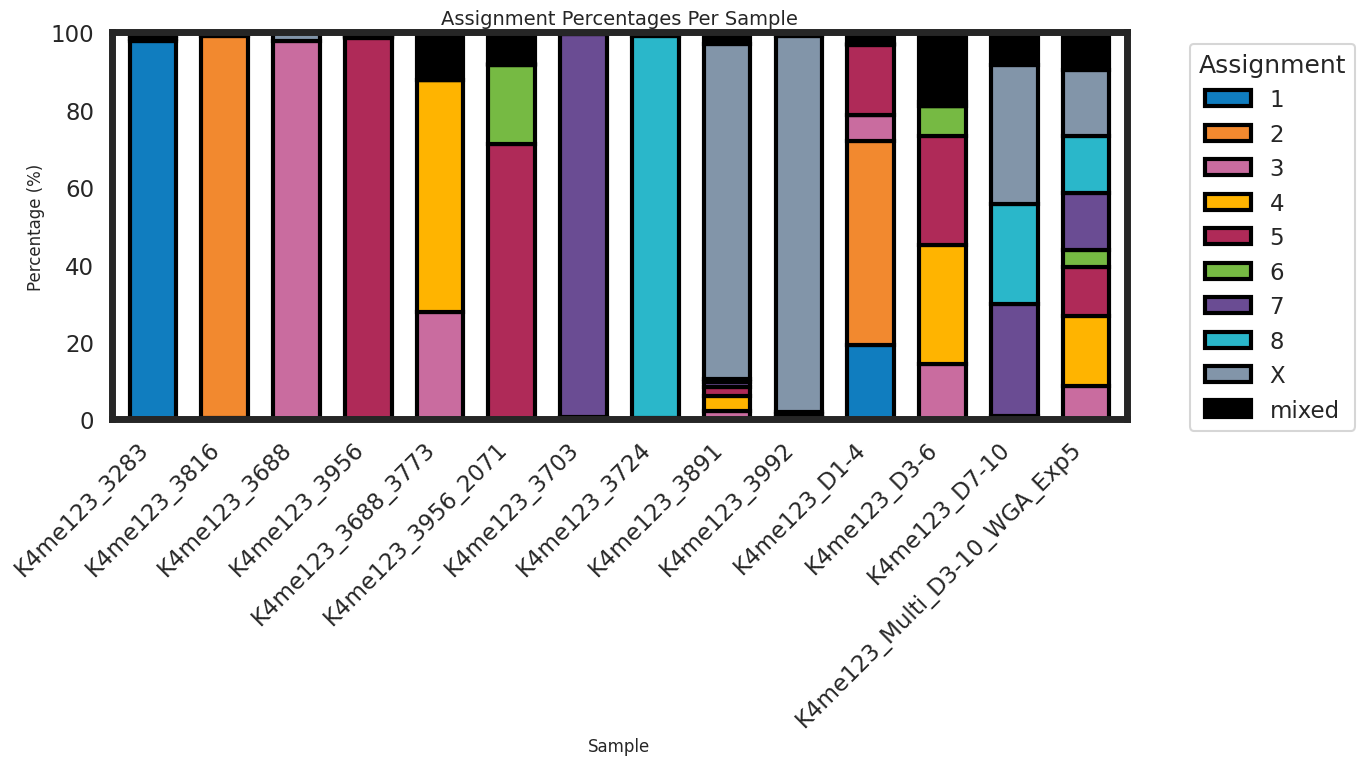

In [41]:
#This cell generates the stacked bar chart for Supplementary Figure 1D

# Load the initial data
souper_star_H3K4me123_Combined = pd.read_csv(
    'souporcell_H3K4me1-2-3_Combined_ReadCounts.csv.gz',
    compression='gzip'
)

# List of target samples
target_samples = [
    'K4me123_3283', 'K4me123_3816', 'K4me123_3688', 'K4me123_3956', 'K4me123_3688_3773', 'K4me123_3956_2071',
    'K4me123_3703', 'K4me123_3724', 'K4me123_3891', 'K4me123_3992', 'K4me123_D1-4',
    'K4me123_D3-6', 'K4me123_D7-10', 'K4me123_Multi_D3-10_WGA_Exp5'
]

# Filter rows that belong to the target samples
filtered_df = souper_star_H3K4me123_Combined[
    souper_star_H3K4me123_Combined['sample'].isin(target_samples)
]

# Define the mixed assignment values
mixed_values = [
    '2/3', '2/4', '2/5', '3/2', '1/5', 
    '1/2', '2/1', '3/1', '4/6', '2/6', '5/2', '4/1', '6/1', '5/1',
    '8/X', '8/5', '4/7', '7/6', '3/4', '8/7', '7/4', '4/5', 'X/8', 
    '4/3', '6/5', '7/3', '4/X', '7/5', '5/8', '3/8', 'X/7', '5/4', 
    '5/6', '3/7', '8/3', '3/5', '6/7', '5/7', '4/8', '7/8', 'X/5', 
    'X/3', '7/X', 'X/4', '3/X', '3/6', '5/3', '8/4', 'X/6', '4/6', 
    '8/6', 'X/X', '6/4', '6/8', '6/3', '6/X', '5/X'
]

# Map assignments into the relevant categories
def categorize_assignment(value):
    if value in mixed_values:
        return 'mixed'
    return value

filtered_df['assignment_category'] = filtered_df['assignment'].apply(categorize_assignment)

# Calculate the percentage of each assignment category for each sample
percentage_df = (
    filtered_df.groupby(['sample', 'assignment_category'])
    .size()
    .reset_index(name='count')
    .pivot(index='sample', columns='assignment_category', values='count')
    .fillna(0)
)

# Normalize to percentages
percentage_df = percentage_df.div(percentage_df.sum(axis=1), axis=0) * 100

# Reindex to ensure consistent order
percentage_df = percentage_df.reindex(target_samples, fill_value=0)

# Define the custom color palette
custom_colors = {
    '1': '#107DBF',
    '2': '#F2892F',
    '3': '#C96C9F',
    '4': '#FFB400',
    '5': '#AF2A58',
    '6': '#76BA43',
    '7': '#6A4C93',
    '8': '#2AB7CA',
    'X': '#8295A9',
    'mixed': 'black'
}

# Plot the stacked bar graph
fig, ax = plt.subplots(figsize=(14, 8))  # Increase figure width slightly for clarity

# Plot the data using custom colors
bars = percentage_df.plot(
    kind='bar',
    stacked=True,
    ax=ax,
    color=[custom_colors.get(col, '#000000') for col in percentage_df.columns],
    edgecolor='black',  # Black outlines
    linewidth=3.0,      # Slightly wider outlines
    width=0.65           # Increase bar width
)

# Customize the plot frame
for spine in ax.spines.values():
    spine.set_linewidth(5.0)  # Increase frame thickness

# Customize the plot
ax.set_ylabel('Percentage (%)', fontsize=12)
ax.set_xlabel('Sample', fontsize=12)
ax.set_title('Assignment Percentages Per Sample', fontsize=14)
ax.legend(title='Assignment', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust y-axis to stop at 100%
ax.set_ylim(0, 100)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Save the plot
#plt.savefig(
#    "/varidata/research/projects/janssens/Henikoff_Lab_Data/CD34_Experiments/Janssens_Lab_CD34_Data_Processing/Figure_Panels/K4me123_Assignment_Percentages_Stacked_Bargraph_Custom_Colors_Outlined.png",
#    dpi=300
#)

plt.show()

In [42]:
#This function determines the fraction of barcodes with a match in the paried dataset

def qc_function_with_sample_mapping(file1, file2, sample_mapping):
    # Load the first csv file
    df1 = pd.read_csv(file1, compression='gzip')

    # Load the second csv file
    df2 = pd.read_csv(file2, compression='gzip')

    results = []
    
    # Iterate over the sample mapping
    for sample1, sample2 in sample_mapping.items():
        print(f"Processing sample pair: {sample1} -> {sample2}")

        # Filter df1 and df2 based on the current sample values
        df1_sample = df1[df1['sample'] == sample1]
        df2_sample = df2[df2['sample'] == sample2]

        # Extract unique barcodes from df1 for the current sample
        CUTAC_barcodes = df1_sample['barcode'].unique().tolist()

        # Print the lengths of the filtered dataframes
        MARK_1_LENGTH = len(df1_sample)
        MARK_2_LENGTH = len(df2_sample)
        print(f"MARK_1_LENGTH ({sample1}): {MARK_1_LENGTH}")
        print(f"MARK_2_LENGTH ({sample2}): {MARK_2_LENGTH}")

        # Filter the second dataframe based on the barcodes from the first
        df2_filtered = df2_sample[df2_sample['barcode'].isin(CUTAC_barcodes)]
        
        # Print the length of the filtered dataframe
        PAIRED_BARCODE_LENGTH = len(df2_filtered)
        print(f"PAIRED_BARCODE_LENGTH ({sample2}): {PAIRED_BARCODE_LENGTH}")
        
        # Compute fractions
        fraction_mark_1 = PAIRED_BARCODE_LENGTH / MARK_1_LENGTH if MARK_1_LENGTH > 0 else 0
        fraction_mark_2 = PAIRED_BARCODE_LENGTH / MARK_2_LENGTH if MARK_2_LENGTH > 0 else 0
        
        results.append({'Sample': sample1, 'Fraction': fraction_mark_1, 'Mark': 'Mark_1'})
        results.append({'Sample': sample2, 'Fraction': fraction_mark_2, 'Mark': 'Mark_2'})
    
    return pd.DataFrame(results)

def qc_function_with_sample_mapping_2(file1, file2, sample_mapping):
    # Load the first csv file
    df1 = pd.read_csv(file1, compression='gzip')

    # Load the second csv file
    df2 = pd.read_csv(file2, compression='gzip')

    results = []
    
    # Iterate over the sample mapping
    for sample1, sample2 in sample_mapping.items():
        print(f"Processing sample pair: {sample1} -> {sample2}")

        # Filter df1 and df2 based on the current sample values
        df1_sample = df1[df1['sample'] == sample1]
        df2_sample = df2[df2['sample'] == sample2]

        # Extract unique barcodes from df1 for the current sample
        CUTAC_barcodes = df1_sample['barcode'].unique().tolist()

        # Print the lengths of the filtered dataframes
        MARK_1_LENGTH = len(df1_sample)
        MARK_2_LENGTH = len(df2_sample)
        print(f"MARK_1_LENGTH ({sample1}): {MARK_1_LENGTH}")
        print(f"MARK_2_LENGTH ({sample2}): {MARK_2_LENGTH}")

        # Filter the second dataframe based on the barcodes from the first
        df2_filtered = df2_sample[df2_sample['barcode'].isin(CUTAC_barcodes)]
        
        # Print the length of the filtered dataframe
        PAIRED_BARCODE_LENGTH = len(df2_filtered)
        print(f"PAIRED_BARCODE_LENGTH ({sample2}): {PAIRED_BARCODE_LENGTH}")
        
        # Compute fractions
        fraction_mark_1 = PAIRED_BARCODE_LENGTH / MARK_1_LENGTH if MARK_1_LENGTH > 0 else 0
        fraction_mark_2 = PAIRED_BARCODE_LENGTH / MARK_2_LENGTH if MARK_2_LENGTH > 0 else 0
        
        results.append({'Sample': sample1, 'Fraction': fraction_mark_1, 'Mark': 'Mark_3'})
        results.append({'Sample': sample2, 'Fraction': fraction_mark_2, 'Mark': 'Mark_4'})
    
    return pd.DataFrame(results)


In [43]:
sample_mapping = {
    "CUTAC_Multi_K4_D3-10_ConA_Exp4": "K4me123_Multi_D3-10_ConA_Exp4",
    "CUTAC_Multi_K4_D3-10_WGA_Exp4": "K4me123_Multi_D3-10_WGA_Exp4",
    "CUTAC_Multi_K4_Female_ConA_Exp4": "K4me123_Multi_Female_ConA_Exp4",
    "CUTAC_Multi_K4_Female_WGA_Exp4": "K4me123_Multi_Female_WGA_Exp4",
    "CUTAC_Multi_K4_D3-10_ConA_Exp5": "K4me123_Multi_D3-10_ConA_Exp5",
    "CUTAC_Multi_K4_D3-10_WGA_Exp5": "K4me123_Multi_D3-10_WGA_Exp5",
    "CUTAC_Multi_K4_Female_ConA_Exp5": "K4me123_Multi_Female_ConA_Exp5",
    "CUTAC_Multi_K4_Female_WGA_Exp5": "K4me123_Multi_Female_WGA_Exp5",
    "CUTAC_K4me123_C1_240218": "K4me123_CUTAC_C1_240218"
}

file1 = 'souporcell_CUTAC_Combined_SplitReadCounts.csv.gz'
file2 = 'souporcell_H3K4me1-2-3_Combined_ReadCounts.csv.gz'
results_df = qc_function_with_sample_mapping(file1, file2, sample_mapping)

Processing sample pair: CUTAC_Multi_K4_D3-10_ConA_Exp4 -> K4me123_Multi_D3-10_ConA_Exp4
MARK_1_LENGTH (CUTAC_Multi_K4_D3-10_ConA_Exp4): 2770
MARK_2_LENGTH (K4me123_Multi_D3-10_ConA_Exp4): 4008
PAIRED_BARCODE_LENGTH (K4me123_Multi_D3-10_ConA_Exp4): 2755
Processing sample pair: CUTAC_Multi_K4_D3-10_WGA_Exp4 -> K4me123_Multi_D3-10_WGA_Exp4
MARK_1_LENGTH (CUTAC_Multi_K4_D3-10_WGA_Exp4): 4847
MARK_2_LENGTH (K4me123_Multi_D3-10_WGA_Exp4): 6318
PAIRED_BARCODE_LENGTH (K4me123_Multi_D3-10_WGA_Exp4): 4806
Processing sample pair: CUTAC_Multi_K4_Female_ConA_Exp4 -> K4me123_Multi_Female_ConA_Exp4
MARK_1_LENGTH (CUTAC_Multi_K4_Female_ConA_Exp4): 3107
MARK_2_LENGTH (K4me123_Multi_Female_ConA_Exp4): 3673
PAIRED_BARCODE_LENGTH (K4me123_Multi_Female_ConA_Exp4): 3076
Processing sample pair: CUTAC_Multi_K4_Female_WGA_Exp4 -> K4me123_Multi_Female_WGA_Exp4
MARK_1_LENGTH (CUTAC_Multi_K4_Female_WGA_Exp4): 1067
MARK_2_LENGTH (K4me123_Multi_Female_WGA_Exp4): 2492
PAIRED_BARCODE_LENGTH (K4me123_Multi_Female_WGA_

In [44]:
sample_mapping = {
    "CUTAC_Multi_K4_D3-10_ConA_Exp4": "K4me123_Multi_D3-10_ConA_Exp5",
    "CUTAC_Multi_K4_D3-10_WGA_Exp4": "K4me123_Multi_D3-10_WGA_Exp5",
    "CUTAC_Multi_K4_Female_ConA_Exp4": "K4me123_Multi_Female_ConA_Exp5",
    "CUTAC_Multi_K4_Female_WGA_Exp4": "K4me123_Multi_Female_WGA_Exp5",
    "CUTAC_Multi_K4_D3-10_ConA_Exp5": "K4me123_Multi_D3-10_ConA_Exp4",
    "CUTAC_Multi_K4_D3-10_WGA_Exp5": "K4me123_Multi_D3-10_WGA_Exp4",
    "CUTAC_Multi_K4_Female_ConA_Exp5": "K4me123_Multi_Female_ConA_Exp4", 
    "CUTAC_Multi_K4_Female_WGA_Exp5": "K4me123_Multi_Female_WGA_Exp4"
}

file1 = "souporcell_CUTAC_Combined_SplitReadCounts.csv.gz"
file2 = "souporcell_H3K4me1-2-3_MISMATCH.csv.gz"
results_df_2 = qc_function_with_sample_mapping_2(file1, file2, sample_mapping)

Processing sample pair: CUTAC_Multi_K4_D3-10_ConA_Exp4 -> K4me123_Multi_D3-10_ConA_Exp5
MARK_1_LENGTH (CUTAC_Multi_K4_D3-10_ConA_Exp4): 2770
MARK_2_LENGTH (K4me123_Multi_D3-10_ConA_Exp5): 4190
PAIRED_BARCODE_LENGTH (K4me123_Multi_D3-10_ConA_Exp5): 218
Processing sample pair: CUTAC_Multi_K4_D3-10_WGA_Exp4 -> K4me123_Multi_D3-10_WGA_Exp5
MARK_1_LENGTH (CUTAC_Multi_K4_D3-10_WGA_Exp4): 4847
MARK_2_LENGTH (K4me123_Multi_D3-10_WGA_Exp5): 6490
PAIRED_BARCODE_LENGTH (K4me123_Multi_D3-10_WGA_Exp5): 575
Processing sample pair: CUTAC_Multi_K4_Female_ConA_Exp4 -> K4me123_Multi_Female_ConA_Exp5
MARK_1_LENGTH (CUTAC_Multi_K4_Female_ConA_Exp4): 3107
MARK_2_LENGTH (K4me123_Multi_Female_ConA_Exp5): 3669
PAIRED_BARCODE_LENGTH (K4me123_Multi_Female_ConA_Exp5): 204
Processing sample pair: CUTAC_Multi_K4_Female_WGA_Exp4 -> K4me123_Multi_Female_WGA_Exp5
MARK_1_LENGTH (CUTAC_Multi_K4_Female_WGA_Exp4): 1067
MARK_2_LENGTH (K4me123_Multi_Female_WGA_Exp5): 2471
PAIRED_BARCODE_LENGTH (K4me123_Multi_Female_WGA_Exp

In [45]:
import numpy as np
import pandas as pd

def probability_of_duplicate_barcodes(total_barcodes, selected_1, selected_2):
    """
    Calculate the probability that a barcode appears in both selections.
    
    Parameters:
    total_barcodes (int): Total number of unique barcode possibilities.
    selected_1 (int): Number of barcodes selected in the first draw.
    selected_2 (int): Number of barcodes selected in the second draw.
    
    Returns:
    tuple: (Fraction of barcodes selected in both draws relative to selected_1, 
            Fraction of barcodes selected in both draws relative to selected_2)
    """
    # Simulate two random draws
    draw_1 = set(np.random.choice(total_barcodes, selected_1, replace=False))
    draw_2 = set(np.random.choice(total_barcodes, selected_2, replace=False))
    
    # Find intersection (common barcodes between the two draws)
    common_barcodes = len(draw_1 & draw_2)
    
    # Calculate the fractions relative to each selection
    fraction_common_1 = common_barcodes / selected_1
    fraction_common_2 = common_barcodes / selected_2
    
    return common_barcodes, fraction_common_1, fraction_common_2

# Define barcode space
barcode_space = 12 * 5048

# Define sample numbers
sample_numbers = {
    2770: 4190,
    4847: 6490,
    3107: 3669,
    1067: 2471,
    2933: 4008,
    4924: 6318,
    3110: 3673,
    1106: 2492
}

# Compute results
results = []
for i, (selected_1, selected_2) in enumerate(sample_numbers.items(), start=1):
    common_barcodes, fraction_1, fraction_2 = probability_of_duplicate_barcodes(barcode_space, selected_1, selected_2)
    results.append({'Sample': i, 'Fraction': fraction_1, 'Mark': 'Mark_5'})
    results.append({'Sample': i, 'Fraction': fraction_2, 'Mark': 'Mark_6'})

# Convert to DataFrame
results_df_3 = pd.DataFrame(results)

# Display results
print(results_df_3)

    Sample  Fraction    Mark
0        1  0.070758  Mark_5
1        1  0.046778  Mark_6
2        2  0.105839  Mark_5
3        2  0.079045  Mark_6
4        3  0.063405  Mark_5
5        3  0.053693  Mark_6
6        4  0.034677  Mark_5
7        4  0.014974  Mark_6
8        5  0.070917  Mark_5
9        5  0.051896  Mark_6
10       6  0.095045  Mark_5
11       6  0.074074  Mark_6
12       7  0.065273  Mark_5
13       7  0.055268  Mark_6
14       8  0.039783  Mark_5
15       8  0.017657  Mark_6


In [47]:
combined_df = pd.concat([results_df, results_df_2, results_df_3], ignore_index=True)

/tmp/ipykernel_204566/3339603733.py:21: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  barplot = sns.barplot(
/tmp/ipykernel_204566/3339603733.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(


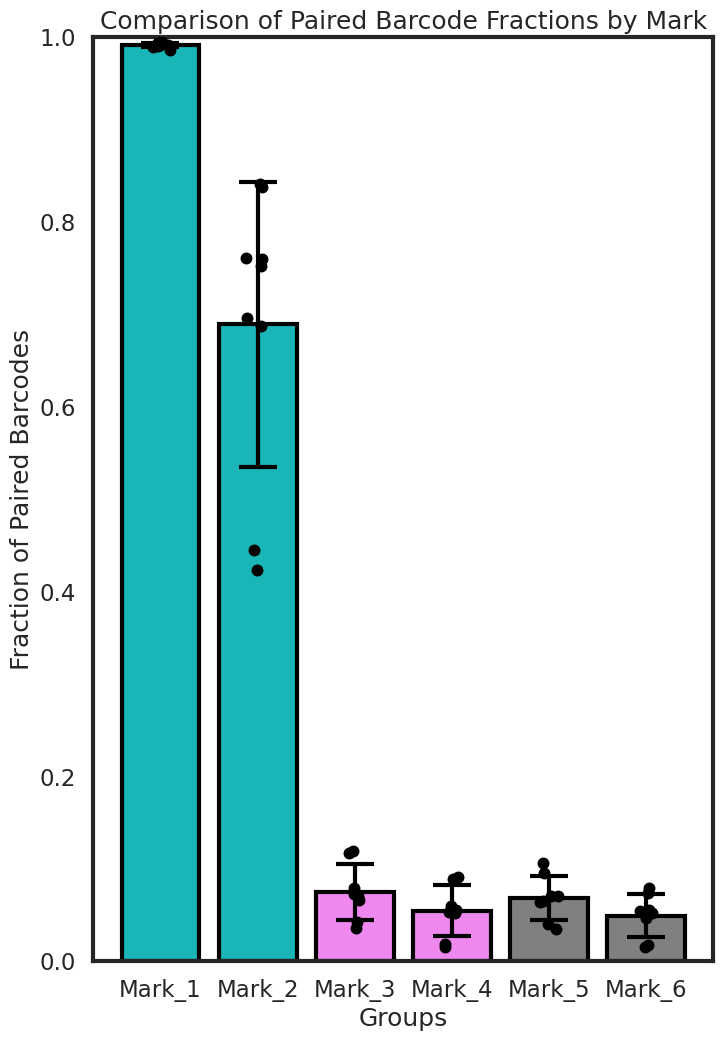

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_paired_barcode_fractions(results_df):
    # Aggregate only the numeric 'Fraction' column
    grouped_data = results_df.groupby('Mark')['Fraction'].agg(['mean', 'std']).reset_index()
    grouped_data.columns = ['Mark', 'Fraction_mean', 'Fraction_std']
    
    plt.figure(figsize=(8, 12))
    
    # Define the colors for each bar (make sure length matches number of unique Marks)
    bar_colors = ['#00CED1', '#00CED1', '#FF77FF', '#FF77FF', 'grey', 'grey']
    
    # Bar plot...
    # (rest of your plotting code stays the same)

    
    # Create the bar plot grouped by 'Mark' with error bars
    barplot = sns.barplot(
        data=grouped_data, 
        x='Mark', 
        y='Fraction_mean', 
        palette=bar_colors,  # Assign custom colors
        edgecolor='black', 
        linewidth=3.0,
        ci=None  # Disable default confidence intervals
    )
    
    # Adjust the x positions of the bars for error bars
    bar_width = barplot.patches[0].get_width()  # Width of a single bar
    for i, mark in enumerate(grouped_data['Mark']):
        mean_val = grouped_data.loc[i, 'Fraction_mean']
        std_val = grouped_data.loc[i, 'Fraction_std']
        plt.errorbar(i, mean_val, yerr=std_val, fmt='none', ecolor='black', capsize=14, elinewidth=3.0, capthick=3.0)  # Increase error bar thickness and cap size
    
    # Overlay all data points as black dots with jitter
    jittered_x = np.random.normal(loc=results_df['Mark'].astype('category').cat.codes, scale=0.05, size=len(results_df))
    plt.scatter(jittered_x, results_df['Fraction'], color='black', s=50, zorder=3)
    
    plt.ylim(0, 1)  # Set y-axis limit for fractions
    plt.ylabel('Fraction of Paired Barcodes')
    plt.xlabel('Groups')
    plt.title('Comparison of Paired Barcode Fractions by Mark')
    
    # Increase the frame and tick thickness
    ax = plt.gca()
    for spine in ax.spines.values():
        spine.set_linewidth(3.0)  # Thicker frame
    ax.tick_params(width=3.0)  # Thicker tick marks
    
    # Save the figure
    #plt.tight_layout()
    #plt.savefig('/varidata/research/projects/janssens/Henikoff_Lab_Data/CD34_Experiments/Janssens_Lab_CD34_Data_Processing/Figure_Panels/K4me123_Paired_n_Mismatch_Barcode_Fraction_Barplot.png', dpi=300)
    #plt.show()

plot_paired_barcode_fractions(combined_df)

In [53]:
sample_mapping = {
    #"CUTAC_Multi_Female_Exp1": "K27me3_Multi_Female_Exp1",
    "CUTAC_Multi_Female_Exp2": "K27me3_Multi_CUTAC_Female_Exp2",
    "CUTAC_Multi_K27_D3-10_ConA_Exp4": "K27me3_Multi_D3-10_ConA_Exp4",
    "CUTAC_Multi_K27_D3-10_WGA_Exp4": "K27me3_Multi_D3-10_WGA_Exp4",
    "CUTAC_Multi_K27_Female_ConA_Exp4": "K27me3_Multi_Female_ConA_Exp4",
    "CUTAC_Multi_K27_Female_WGA_Exp4": "K27me3_Multi_Female_WGA_Exp4",
    "CUTAC_Multi_K27_D3-10_ConA_Exp5": "K27me3_Multi_D3-10_ConA_Exp5",
    "CUTAC_Multi_K27_D3-10_WGA_Exp5": "K27me3_Multi_D3-10_WGA_Exp5",
    "CUTAC_Multi_K27_Female_ConA_Exp5": "K27me3_Multi_Female_ConA_Exp5",
    "CUTAC_Multi_K27_Female_WGA_Exp5": "K27me3_Multi_Female_WGA_Exp5",
    "CUTAC_K27me3_C1_240218": "K27me3_CUTAC_C1_240218",
}

file1 = "souporcell_CUTAC_Combined_SplitReadCounts.csv.gz"
file2 = "souporcell_H3K27me3_Combined_ReadCounts.csv.gz"
results_df = qc_function_with_sample_mapping(file1, file2, sample_mapping)

Processing sample pair: CUTAC_Multi_Female_Exp2 -> K27me3_Multi_CUTAC_Female_Exp2
MARK_1_LENGTH (CUTAC_Multi_Female_Exp2): 6288
MARK_2_LENGTH (K27me3_Multi_CUTAC_Female_Exp2): 18293
PAIRED_BARCODE_LENGTH (K27me3_Multi_CUTAC_Female_Exp2): 6260
Processing sample pair: CUTAC_Multi_K27_D3-10_ConA_Exp4 -> K27me3_Multi_D3-10_ConA_Exp4
MARK_1_LENGTH (CUTAC_Multi_K27_D3-10_ConA_Exp4): 4304
MARK_2_LENGTH (K27me3_Multi_D3-10_ConA_Exp4): 5240
PAIRED_BARCODE_LENGTH (K27me3_Multi_D3-10_ConA_Exp4): 4279
Processing sample pair: CUTAC_Multi_K27_D3-10_WGA_Exp4 -> K27me3_Multi_D3-10_WGA_Exp4
MARK_1_LENGTH (CUTAC_Multi_K27_D3-10_WGA_Exp4): 3527
MARK_2_LENGTH (K27me3_Multi_D3-10_WGA_Exp4): 7200
PAIRED_BARCODE_LENGTH (K27me3_Multi_D3-10_WGA_Exp4): 3503
Processing sample pair: CUTAC_Multi_K27_Female_ConA_Exp4 -> K27me3_Multi_Female_ConA_Exp4
MARK_1_LENGTH (CUTAC_Multi_K27_Female_ConA_Exp4): 3162
MARK_2_LENGTH (K27me3_Multi_Female_ConA_Exp4): 4449
PAIRED_BARCODE_LENGTH (K27me3_Multi_Female_ConA_Exp4): 3140
P

In [54]:
sample_mapping = {
    #"CUTAC_Multi_Female_Exp1": "K27me3_Multi_CUTAC_Female_Exp2",
    #"CUTAC_Multi_Female_Exp2": "K27me3_Multi_Female_Exp1",
    "CUTAC_Multi_K27_D3-10_ConA_Exp4": "K27me3_Multi_D3-10_ConA_Exp5",
    "CUTAC_Multi_K27_D3-10_WGA_Exp4": "K27me3_Multi_D3-10_WGA_Exp5",
    "CUTAC_Multi_K27_Female_ConA_Exp4": "K27me3_Multi_Female_ConA_Exp5",
    "CUTAC_Multi_K27_Female_WGA_Exp4": "K27me3_Multi_Female_WGA_Exp5",
    "CUTAC_Multi_K27_D3-10_ConA_Exp5": "K27me3_Multi_D3-10_ConA_Exp4",
    "CUTAC_Multi_K27_D3-10_WGA_Exp5":  "K27me3_Multi_D3-10_WGA_Exp4",
    "CUTAC_Multi_K27_Female_ConA_Exp5": "K27me3_Multi_Female_ConA_Exp4",
    "CUTAC_Multi_K27_Female_WGA_Exp5": "K27me3_Multi_Female_WGA_Exp4",
}

file1 = "souporcell_CUTAC_Combined_SplitReadCounts.csv.gz"
file2 = "souporcell_H3K27me3_MISMATCH.csv.gz"
results_df_2 = qc_function_with_sample_mapping_2(file1, file2, sample_mapping)

Processing sample pair: CUTAC_Multi_K27_D3-10_ConA_Exp4 -> K27me3_Multi_D3-10_ConA_Exp5
MARK_1_LENGTH (CUTAC_Multi_K27_D3-10_ConA_Exp4): 4304
MARK_2_LENGTH (K27me3_Multi_D3-10_ConA_Exp5): 5275
PAIRED_BARCODE_LENGTH (K27me3_Multi_D3-10_ConA_Exp5): 386
Processing sample pair: CUTAC_Multi_K27_D3-10_WGA_Exp4 -> K27me3_Multi_D3-10_WGA_Exp5
MARK_1_LENGTH (CUTAC_Multi_K27_D3-10_WGA_Exp4): 3527
MARK_2_LENGTH (K27me3_Multi_D3-10_WGA_Exp5): 7140
PAIRED_BARCODE_LENGTH (K27me3_Multi_D3-10_WGA_Exp5): 453
Processing sample pair: CUTAC_Multi_K27_Female_ConA_Exp4 -> K27me3_Multi_Female_ConA_Exp5
MARK_1_LENGTH (CUTAC_Multi_K27_Female_ConA_Exp4): 3162
MARK_2_LENGTH (K27me3_Multi_Female_ConA_Exp5): 4254
PAIRED_BARCODE_LENGTH (K27me3_Multi_Female_ConA_Exp5): 256
Processing sample pair: CUTAC_Multi_K27_Female_WGA_Exp4 -> K27me3_Multi_Female_WGA_Exp5
MARK_1_LENGTH (CUTAC_Multi_K27_Female_WGA_Exp4): 1668
MARK_2_LENGTH (K27me3_Multi_Female_WGA_Exp5): 2759
PAIRED_BARCODE_LENGTH (K27me3_Multi_Female_WGA_Exp5): 

In [55]:
import numpy as np
import pandas as pd

def probability_of_duplicate_barcodes(total_barcodes, selected_1, selected_2):
    """
    Calculate the probability that a barcode appears in both selections.
    
    Parameters:
    total_barcodes (int): Total number of unique barcode possibilities.
    selected_1 (int): Number of barcodes selected in the first draw.
    selected_2 (int): Number of barcodes selected in the second draw.
    
    Returns:
    tuple: (Fraction of barcodes selected in both draws relative to selected_1, 
            Fraction of barcodes selected in both draws relative to selected_2)
    """
    # Simulate two random draws
    draw_1 = set(np.random.choice(total_barcodes, selected_1, replace=False))
    draw_2 = set(np.random.choice(total_barcodes, selected_2, replace=False))
    
    # Find intersection (common barcodes between the two draws)
    common_barcodes = len(draw_1 & draw_2)
    
    # Calculate the fractions relative to each selection
    fraction_common_1 = common_barcodes / selected_1
    fraction_common_2 = common_barcodes / selected_2
    
    return common_barcodes, fraction_common_1, fraction_common_2

# Define barcode space
barcode_space = 12 * 5048

# Define sample numbers
sample_numbers = {
    4304: 5275,
    3527: 7140,
    3162: 4254,
    1668: 2759,
    4372: 5240,
    3489: 7200,
    3036: 4449,
    1754: 2741
}

# Compute results
results = []
for i, (selected_1, selected_2) in enumerate(sample_numbers.items(), start=1):
    common_barcodes, fraction_1, fraction_2 = probability_of_duplicate_barcodes(barcode_space, selected_1, selected_2)
    results.append({'Sample': i, 'Fraction': fraction_1, 'Mark': 'Mark_5'})
    results.append({'Sample': i, 'Fraction': fraction_2, 'Mark': 'Mark_6'})

# Convert to DataFrame
results_df_3 = pd.DataFrame(results)

# Display results
print(results_df_3)


    Sample  Fraction    Mark
0        1  0.092007  Mark_5
1        1  0.075071  Mark_6
2        2  0.113127  Mark_5
3        2  0.055882  Mark_6
4        3  0.079380  Mark_5
5        3  0.059003  Mark_6
6        4  0.043765  Mark_5
7        4  0.026459  Mark_6
8        5  0.085316  Mark_5
9        5  0.071183  Mark_6
10       6  0.110060  Mark_5
11       6  0.053333  Mark_6
12       7  0.076416  Mark_5
13       7  0.052147  Mark_6
14       8  0.043900  Mark_5
15       8  0.028092  Mark_6


In [56]:
combined_df = pd.concat([results_df, results_df_2, results_df_3], ignore_index=True)

/tmp/ipykernel_204566/3339603733.py:21: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  barplot = sns.barplot(
/tmp/ipykernel_204566/3339603733.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(


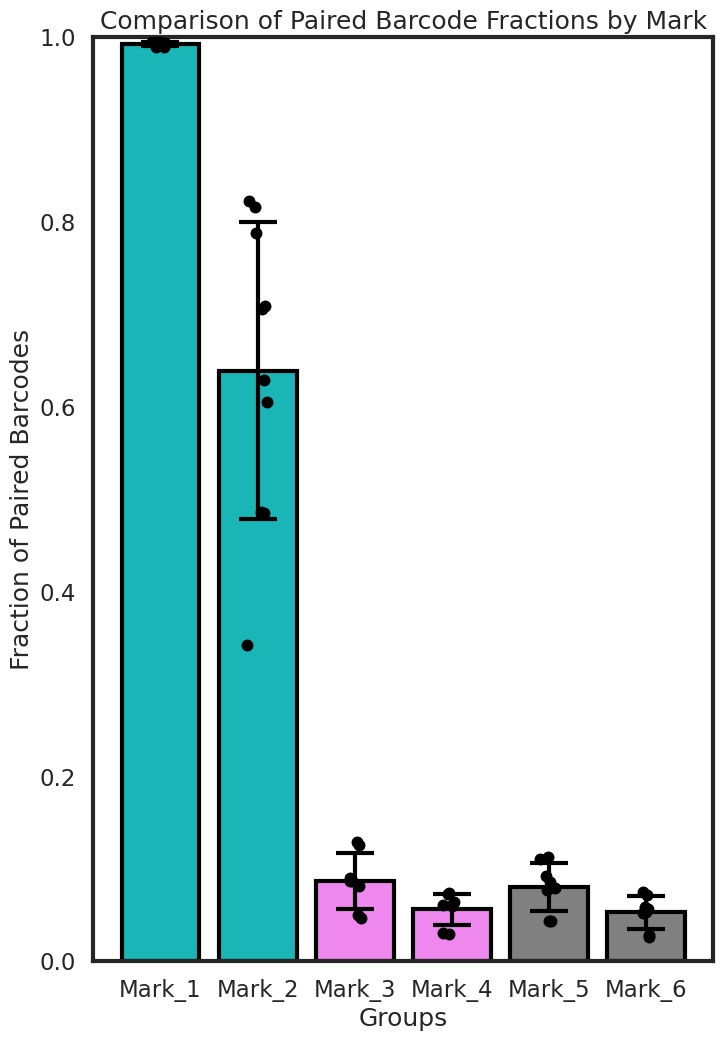

In [57]:
plot_paired_barcode_fractions(combined_df)

In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def qc_function_general(file1, file2, sample_mapping, label):
    df1 = pd.read_csv(file1, compression='gzip')
    df2 = pd.read_csv(file2, compression='gzip')

    results = []
    for sample1, sample2 in sample_mapping.items():
        print(f"Processing sample pair: {sample1} -> {sample2}")

        df1_sample = df1[df1['sample'] == sample1]
        df2_sample = df2[df2['sample'] == sample2]

        cutac_barcodes = df1_sample['barcode'].unique()
        df2_filtered = df2_sample[df2_sample['barcode'].isin(cutac_barcodes)]
        paired_barcodes = df2_filtered['barcode'].unique()

        mark2 = df2_filtered[['barcode', 'assignment']].rename(columns={'assignment': 'Mark_2_assignment'})
        mark1 = df1_sample[df1_sample['barcode'].isin(paired_barcodes)][['barcode', 'assignment']].rename(columns={'assignment': 'Mark_1_assignment'})

        merged = pd.merge(mark1, mark2, on='barcode')
        if len(merged) > 0:
            percent_match = (merged['Mark_1_assignment'] == merged['Mark_2_assignment']).mean() * 100
        else:
            percent_match = 0

        results.append({
            'Sample_1': sample1,
            'Sample_2': sample2,
            'Fraction_Matched': percent_match,
            'Dataset': label
        })

    return pd.DataFrame(results)

def plot_fraction_matched_bargraph_fixed(combined_df, output_path):
    dataset_order = ['K4me123_Paired', 'K4me123_Mismatched', 'K27me3_Paired', 'K27me3_Mismatched']
    bar_colors = ['#00CED1', '#FF77FF', '#00CED1', '#FF77FF']

    combined_df['Dataset'] = pd.Categorical(combined_df['Dataset'], categories=dataset_order, ordered=True)
    grouped = combined_df.groupby('Dataset', observed=True)['Fraction_Matched'].agg(['mean', 'std']).reset_index()

    plt.figure(figsize=(8, 12))
    sns.barplot(data=grouped, x='Dataset', y='mean', order=dataset_order, palette=bar_colors, edgecolor='black', linewidth=3.0, errorbar=None)

    for i, row in grouped.iterrows():
        plt.errorbar(i, row['mean'], yerr=row['std'], fmt='none', ecolor='black', capsize=14, elinewidth=3, capthick=3)

    jitter_x = np.random.normal(loc=[dataset_order.index(d) for d in combined_df['Dataset']], scale=0.05)
    plt.scatter(jitter_x, combined_df['Fraction_Matched'], color='black', s=50, zorder=3)

    plt.ylim(0, 100)
    plt.ylabel('Fraction Matched (%)')
    plt.xlabel('Dataset')
    plt.title('Comparison of Fraction Matched by Dataset')
    ax = plt.gca()
    for spine in ax.spines.values():
        spine.set_linewidth(3.0)
    ax.tick_params(width=3.0)
    plt.xticks(rotation=45)
    plt.grid(False)
    plt.tight_layout()
    plt.savefig(output_path, dpi=300)
    plt.show()
    print(f"Plot saved as '{output_path}'.")


Processing sample pair: CUTAC_Multi_K4_D3-10_ConA_Exp4 -> K4me123_Multi_D3-10_ConA_Exp4
Processing sample pair: CUTAC_Multi_K4_D3-10_WGA_Exp4 -> K4me123_Multi_D3-10_WGA_Exp4
Processing sample pair: CUTAC_Multi_K4_Female_ConA_Exp4 -> K4me123_Multi_Female_ConA_Exp4
Processing sample pair: CUTAC_Multi_K4_Female_WGA_Exp4 -> K4me123_Multi_Female_WGA_Exp4
Processing sample pair: CUTAC_Multi_K4_D3-10_ConA_Exp5 -> K4me123_Multi_D3-10_ConA_Exp5
Processing sample pair: CUTAC_Multi_K4_D3-10_WGA_Exp5 -> K4me123_Multi_D3-10_WGA_Exp5
Processing sample pair: CUTAC_Multi_K4_Female_ConA_Exp5 -> K4me123_Multi_Female_ConA_Exp5
Processing sample pair: CUTAC_Multi_K4_Female_WGA_Exp5 -> K4me123_Multi_Female_WGA_Exp5
Processing sample pair: CUTAC_K4me123_C1_240218 -> K4me123_CUTAC_C1_240218
Processing sample pair: CUTAC_Multi_K4_D3-10_ConA_Exp4 -> K4me123_Multi_D3-10_ConA_Exp5
Processing sample pair: CUTAC_Multi_K4_D3-10_WGA_Exp4 -> K4me123_Multi_D3-10_WGA_Exp5
Processing sample pair: CUTAC_Multi_K4_Female_C

/tmp/ipykernel_204566/2678288969.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=grouped, x='Dataset', y='mean', order=dataset_order, palette=bar_colors, edgecolor='black', linewidth=3.0, errorbar=None)


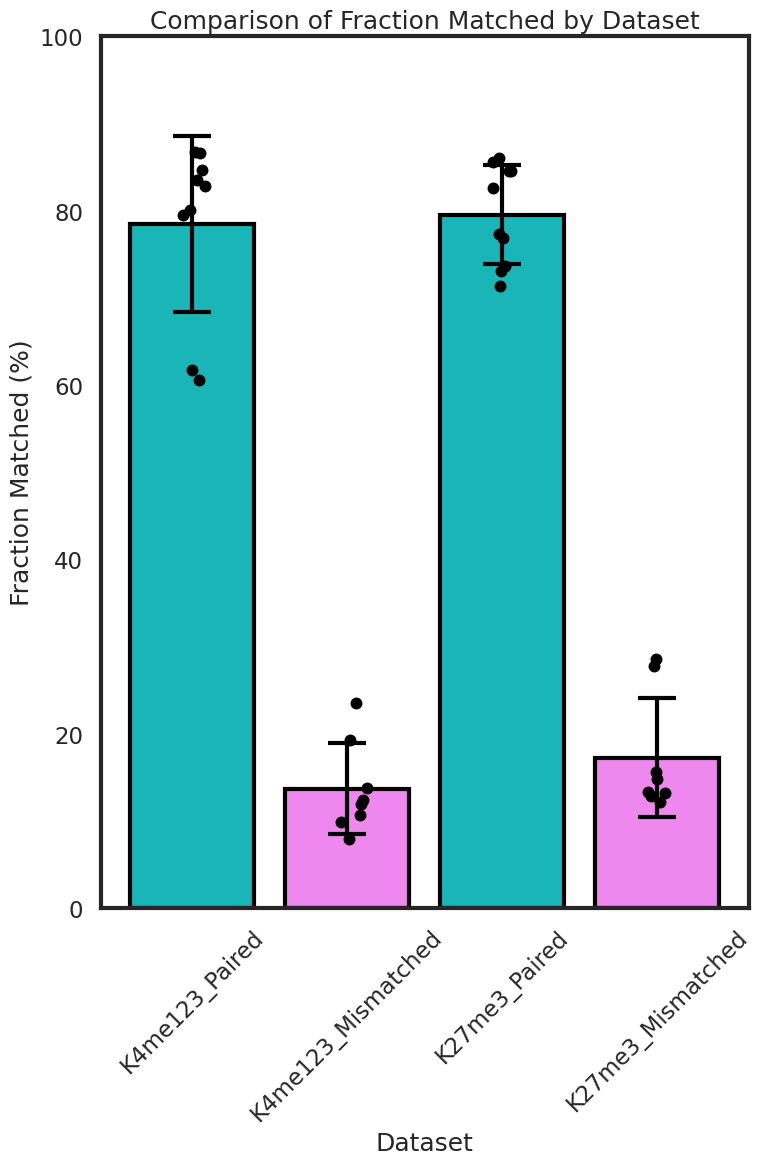

Plot saved as 'K4me123_K27me3_Paired_n_Mismatch_Donor_Match_Fraction_Barplot.png'.


In [60]:
sample_mapping = {
    "CUTAC_Multi_K4_D3-10_ConA_Exp4": "K4me123_Multi_D3-10_ConA_Exp4",
    "CUTAC_Multi_K4_D3-10_WGA_Exp4": "K4me123_Multi_D3-10_WGA_Exp4",
    "CUTAC_Multi_K4_Female_ConA_Exp4": "K4me123_Multi_Female_ConA_Exp4",
    "CUTAC_Multi_K4_Female_WGA_Exp4": "K4me123_Multi_Female_WGA_Exp4",
    "CUTAC_Multi_K4_D3-10_ConA_Exp5": "K4me123_Multi_D3-10_ConA_Exp5",
    "CUTAC_Multi_K4_D3-10_WGA_Exp5": "K4me123_Multi_D3-10_WGA_Exp5",
    "CUTAC_Multi_K4_Female_ConA_Exp5": "K4me123_Multi_Female_ConA_Exp5",
    "CUTAC_Multi_K4_Female_WGA_Exp5": "K4me123_Multi_Female_WGA_Exp5",
    "CUTAC_K4me123_C1_240218": "K4me123_CUTAC_C1_240218"
}

file1 = 'souporcell_CUTAC_Combined_SplitReadCounts.csv.gz'
file2 = 'souporcell_H3K4me1-2-3_Combined_ReadCounts.csv.gz'

results_df_1 = qc_function_general(file1, file2, sample_mapping, "K4me123_Paired")

sample_mapping = {
    "CUTAC_Multi_K4_D3-10_ConA_Exp4": "K4me123_Multi_D3-10_ConA_Exp5",
    "CUTAC_Multi_K4_D3-10_WGA_Exp4": "K4me123_Multi_D3-10_WGA_Exp5",
    "CUTAC_Multi_K4_Female_ConA_Exp4": "K4me123_Multi_Female_ConA_Exp5",
    "CUTAC_Multi_K4_Female_WGA_Exp4": "K4me123_Multi_Female_WGA_Exp5",
    "CUTAC_Multi_K4_D3-10_ConA_Exp5": "K4me123_Multi_D3-10_ConA_Exp4",
    "CUTAC_Multi_K4_D3-10_WGA_Exp5": "K4me123_Multi_D3-10_WGA_Exp4",
    "CUTAC_Multi_K4_Female_ConA_Exp5": "K4me123_Multi_Female_ConA_Exp4", 
    "CUTAC_Multi_K4_Female_WGA_Exp5": "K4me123_Multi_Female_WGA_Exp4"
}

file1 = "souporcell_CUTAC_Combined_SplitReadCounts.csv.gz"
file2 = "souporcell_H3K4me1-2-3_MISMATCH.csv.gz"

results_df_2 = qc_function_general(file1, file2, sample_mapping, "K4me123_Mismatched")

sample_mapping = {
    #"CUTAC_Multi_Female_Exp1": "K27me3_Multi_Female_Exp1",
    "CUTAC_Multi_Female_Exp2": "K27me3_Multi_CUTAC_Female_Exp2",
    "CUTAC_Multi_K27_D3-10_ConA_Exp4": "K27me3_Multi_D3-10_ConA_Exp4",
    "CUTAC_Multi_K27_D3-10_WGA_Exp4": "K27me3_Multi_D3-10_WGA_Exp4",
    "CUTAC_Multi_K27_Female_ConA_Exp4": "K27me3_Multi_Female_ConA_Exp4",
    "CUTAC_Multi_K27_Female_WGA_Exp4": "K27me3_Multi_Female_WGA_Exp4",
    "CUTAC_Multi_K27_D3-10_ConA_Exp5": "K27me3_Multi_D3-10_ConA_Exp5",
    "CUTAC_Multi_K27_D3-10_WGA_Exp5": "K27me3_Multi_D3-10_WGA_Exp5",
    "CUTAC_Multi_K27_Female_ConA_Exp5": "K27me3_Multi_Female_ConA_Exp5",
    "CUTAC_Multi_K27_Female_WGA_Exp5": "K27me3_Multi_Female_WGA_Exp5",
    "CUTAC_K27me3_C1_240218": "K27me3_CUTAC_C1_240218",
}

file1 = "souporcell_CUTAC_Combined_SplitReadCounts.csv.gz"
file2 = "souporcell_H3K27me3_Combined_ReadCounts.csv.gz"

results_df_3 = qc_function_general(file1, file2, sample_mapping, "K27me3_Paired")


sample_mapping = {
    #"CUTAC_Multi_Female_Exp1": "K27me3_Multi_CUTAC_Female_Exp2",
    #"CUTAC_Multi_Female_Exp2": "K27me3_Multi_Female_Exp1",
    "CUTAC_Multi_K27_D3-10_ConA_Exp4": "K27me3_Multi_D3-10_ConA_Exp5",
    "CUTAC_Multi_K27_D3-10_WGA_Exp4": "K27me3_Multi_D3-10_WGA_Exp5",
    "CUTAC_Multi_K27_Female_ConA_Exp4": "K27me3_Multi_Female_ConA_Exp5",
    "CUTAC_Multi_K27_Female_WGA_Exp4": "K27me3_Multi_Female_WGA_Exp5",
    "CUTAC_Multi_K27_D3-10_ConA_Exp5": "K27me3_Multi_D3-10_ConA_Exp4",
    "CUTAC_Multi_K27_D3-10_WGA_Exp5":  "K27me3_Multi_D3-10_WGA_Exp4",
    "CUTAC_Multi_K27_Female_ConA_Exp5": "K27me3_Multi_Female_ConA_Exp4",
    "CUTAC_Multi_K27_Female_WGA_Exp5": "K27me3_Multi_Female_WGA_Exp4",
}

file1 = "souporcell_CUTAC_Combined_SplitReadCounts.csv.gz"
file2 = "souporcell_H3K27me3_MISMATCH.csv.gz"
results_df_4 = qc_function_general(file1, file2, sample_mapping, "K27me3_Mismatched")

combined_df = pd.concat([results_df_1, results_df_2, results_df_3, results_df_4], ignore_index=True)

plot_fraction_matched_bargraph_fixed(
    combined_df,
    output_path="K4me123_K27me3_Paired_n_Mismatch_Donor_Match_Fraction_Barplot.png"
)


In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def normalize_assignment(assignment):
    # Split assignments, sort, and join back to normalize inverse pairs
    parts = assignment.split('/')
    return '/'.join(sorted(parts))  # e.g., '4/5' and '5/4' become '4/5'

def qc_function(file1, file2, output_filename):
    """
    Reads two CSV files, processes mismatches, and generates a heatmap.
    
    Parameters:
    - file1 (str): Path to the first CSV file (CUTAC barcodes).
    - file2 (str): Path to the second CSV file (paired barcode assignments).
    - output_filename (str): Path to save the heatmap image.
    """
    # Load the first csv file
    df1 = pd.read_csv(file1, compression='gzip')

    # Extract unique barcodes
    CUTAC_barcodes = df1['barcode'].unique().tolist()

    # Load the second csv file
    df2 = pd.read_csv(file2, compression='gzip')

    # Filter the second dataframe based on the barcodes from the first
    df2_filtered = df2[df2['barcode'].isin(CUTAC_barcodes)]

    # Create the MARK_2_PAIRED_DONORS dataframe and normalize assignments
    MARK_2_PAIRED_DONORS = df2_filtered[['barcode', 'assignment']]
    MARK_2_PAIRED_DONORS['Mark_2_assignment'] = MARK_2_PAIRED_DONORS['assignment'].apply(normalize_assignment)
    MARK_2_PAIRED_DONORS = MARK_2_PAIRED_DONORS[['barcode', 'Mark_2_assignment']]

    # Extract unique barcodes from the filtered dataframe
    Paired_barcodes = MARK_2_PAIRED_DONORS['barcode'].unique().tolist()

    # Filter the first dataframe based on the Paired_barcodes and normalize assignments
    df1_filtered = df1[df1['barcode'].isin(Paired_barcodes)]
    MARK_1_PAIRED_DONORS = df1_filtered[['barcode', 'assignment']]
    MARK_1_PAIRED_DONORS['Mark_1_assignment'] = MARK_1_PAIRED_DONORS['assignment'].apply(normalize_assignment)
    MARK_1_PAIRED_DONORS = MARK_1_PAIRED_DONORS[['barcode', 'Mark_1_assignment']]

    # Merge the two dataframes on the barcode
    merged_df = pd.merge(MARK_1_PAIRED_DONORS, MARK_2_PAIRED_DONORS, on='barcode')

    # Identify mismatches
    merged_df['is_mismatch'] = merged_df['Mark_1_assignment'] != merged_df['Mark_2_assignment']

    # Filter only mismatched rows
    mismatch_df = merged_df[merged_df['is_mismatch']]

    # Group by Mark_1 and Mark_2 assignment to get mismatch counts
    mismatch_counts = mismatch_df.groupby(['Mark_1_assignment', 'Mark_2_assignment']).size().unstack(fill_value=0)

    # Remove 'X/X' from x-axis and y-axis if present
    if 'X/X' in mismatch_counts.index:
        mismatch_counts = mismatch_counts.drop(index='X/X')
    if 'X/X' in mismatch_counts.columns:
        mismatch_counts = mismatch_counts.drop(columns='X/X')

    # Normalize to percentages by row
    mismatch_percentages = (mismatch_counts.T / mismatch_counts.sum(axis=1)).T * 100

    # Set upper limit for color scale
    vmin, vmax = 0, 25  # Ensures the maximum color is capped at 50

    # Plotting the heatmap for mismatch distribution
    plt.figure(figsize=(12, 8))
    heatmap = plt.pcolor(mismatch_percentages, cmap='viridis', edgecolors='w', linewidths=1, vmin=vmin, vmax=vmax)
    
    # Add colorbar with adjusted limits
    cbar = plt.colorbar(heatmap)
    cbar.set_label("Percentage of Mismatches")
    cbar.set_ticks(np.linspace(vmin, vmax, num=6))  # Adjust ticks for readability

    # Set x and y axis labels with adjusted ticks
    plt.xticks(np.arange(len(mismatch_percentages.columns)) + 0.5, mismatch_percentages.columns, rotation=45, ha='right')
    plt.yticks(np.arange(len(mismatch_percentages.index)) + 0.5, mismatch_percentages.index)

    plt.xlabel("Mismatched Assignment")
    plt.ylabel("Assignment")
    plt.title("Distribution of Mismatches for Each Assignment")

    plt.tight_layout()
    
    # Save the figure
    plt.savefig(output_filename, dpi=300)
    plt.show()

    print(f"Heatmap saved as {output_filename}")


/tmp/ipykernel_204566/175839015.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MARK_2_PAIRED_DONORS['Mark_2_assignment'] = MARK_2_PAIRED_DONORS['assignment'].apply(normalize_assignment)
/tmp/ipykernel_204566/175839015.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MARK_1_PAIRED_DONORS['Mark_1_assignment'] = MARK_1_PAIRED_DONORS['assignment'].apply(normalize_assignment)


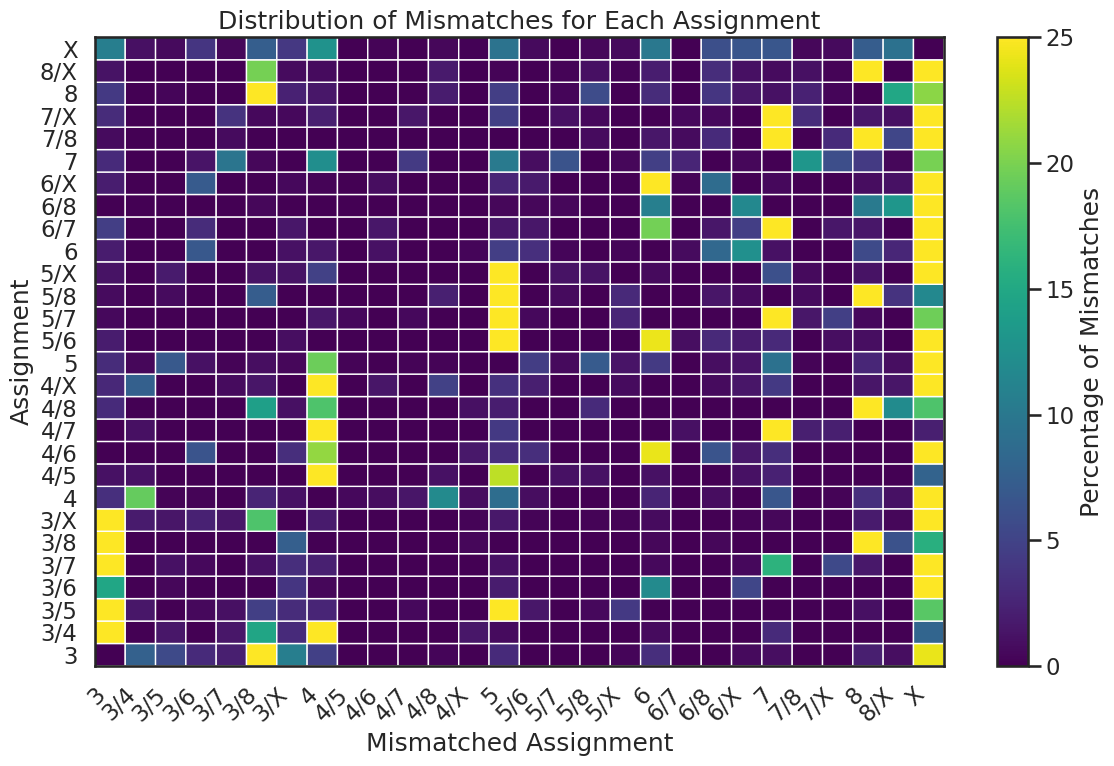

Heatmap saved as CUTAC_K27me3_Donor_MisMatch_Values_Heatmap_viridis.png


In [62]:
# Use the function
file1 = "souporcell_CUTAC_Combined_SplitReadCounts.csv.gz"
file2 = "souporcell_H3K27me3_Combined_ReadCounts.csv.gz"
output = 'CUTAC_K27me3_Donor_MisMatch_Values_Heatmap_viridis.png'
qc_function(file1, file2, output)

/tmp/ipykernel_204566/1737115563.py:71: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


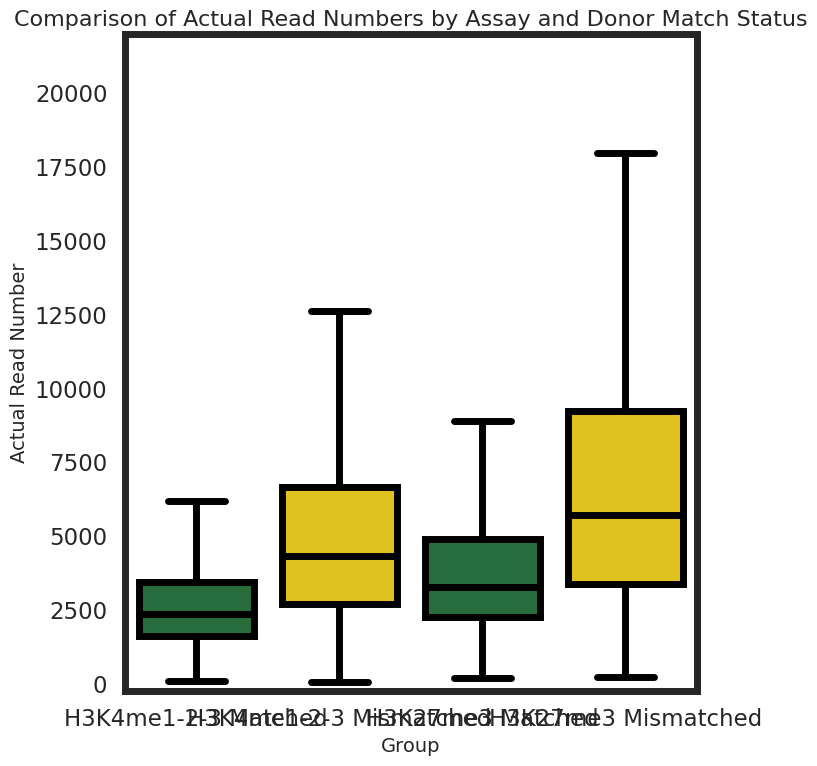

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def get_mismatch_data(file1, file2, assay_label):
    """
    Loads file1 (e.g., H3K4me1-2-3 or H3K27me3) and file2 (CUTAC),
    merges them on barcodes, and returns a DataFrame with the assay label,
    the actual read numbers from file1, and a group label that combines the assay
    and the match status.
    """
    # Load the CSV files (assuming gzip compression)
    df1 = pd.read_csv(file1, compression='gzip')
    df2 = pd.read_csv(file2, compression='gzip')
    
    # Only keep barcodes that exist in file1 for merging
    barcodes_df1 = df1['barcode'].unique().tolist()
    df2_filtered = df2[df2['barcode'].isin(barcodes_df1)]
    
    # Prepare the primary dataframe (file1) for plotting actual read numbers.
    MARK_1 = df1[['barcode', 'assignment', 'actual_read_number']].copy()
    MARK_1.rename(columns={'assignment': 'Mark_1_assignment'}, inplace=True)
    
    # Prepare the CUTAC dataframe for donor assignment.
    MARK_2 = df2_filtered[['barcode', 'assignment']].copy()
    MARK_2.rename(columns={'assignment': 'Mark_2_assignment'}, inplace=True)
    
    # Merge on barcode
    merged_df = pd.merge(MARK_1, MARK_2, on='barcode')
    
    # Create a new column indicating if the donor assignments match.
    merged_df['Mismatch_status'] = np.where(
        merged_df['Mark_1_assignment'] == merged_df['Mark_2_assignment'],
        'Matched', 'Mismatched'
    )
    
    # Add the assay label (e.g., "H3K4me1-2-3" or "H3K27me3") and create a combined group column.
    merged_df['Assay'] = assay_label
    merged_df['Group'] = assay_label + " " + merged_df['Mismatch_status']
    
    # Return only the needed columns.
    return merged_df[['Group', 'actual_read_number']]

# File paths (update if necessary)
cutac_file  = "souporcell_CUTAC_Combined_SplitReadCounts.csv.gz"
h3k4me_file = 'souporcell_H3K4me1-2-3_Combined_ReadCounts.csv.gz'
h3k27me_file = "souporcell_H3K27me3_Combined_ReadCounts.csv.gz"

# Process each assay.
df_h3k4 = get_mismatch_data(h3k4me_file, cutac_file, "H3K4me1-2-3")
df_h3k27 = get_mismatch_data(h3k27me_file, cutac_file, "H3K27me3")

# Combine the data from both assays.
df_all = pd.concat([df_h3k4, df_h3k27], axis=0)

# Define the order of the groups.
group_order = ["H3K4me1-2-3 Matched", "H3K4me1-2-3 Mismatched",
               "H3K27me3 Matched", "H3K27me3 Mismatched"]

# Define a palette: using a dark green for matched and yellow for mismatched.
palette = {
    "H3K4me1-2-3 Matched": "#1b7837",  # dark green
    "H3K4me1-2-3 Mismatched": "gold",
    "H3K27me3 Matched": "#1b7837",      # dark green
    "H3K27me3 Mismatched": "gold"
}

# Create the combined boxplot.
plt.figure(figsize=(8, 8))
ax = sns.boxplot(
    data=df_all,
    x="Group",
    y="actual_read_number",
    order=group_order,
    palette=palette,
    showfliers=False,
    linewidth=5.0  # Thick lines for boxes
)

# Enforce thick, black outlines for each box.
for patch in ax.patches:
    patch.set_edgecolor("black")
    patch.set_linewidth(5.0)
    patch.set_hatch("")  # Remove any hatching if present

# Thicken the median lines and whiskers.
for line in ax.lines:
    line.set_color("black")
    line.set_linewidth(5.0)

# Increase the frame (spine) thickness.
for spine in ax.spines.values():
    spine.set_linewidth(5.0)

# Set the y-axis maximum to 20,000.
ax.set_ylim(-250, 22000)

# Set labels and title.
plt.xlabel("Group", fontsize=14)
plt.ylabel("Actual Read Number", fontsize=14)
plt.title("Comparison of Actual Read Numbers by Assay and Donor Match Status", fontsize=16)
plt.tight_layout()
#plt.savefig('/varidata/research/projects/janssens/Henikoff_Lab_Data/CD34_Experiments/Janssens_Lab_CD34_Data_Processing/Figure_Panels/Donor_Match_Mismatch_Reads_Boxplot.png', dpi=300)
plt.show()


In [65]:
import pandas as pd

# --- 1. Load input files ---
# Path to souporcell file
souporcell_file = "souporcell_H3K27me3_Combined_ReadCounts.csv.gz"

# Path to cluster barcode file: column 0 = barcode, column 1 = cluster
cluster_barcode_file = "K27me3_Cluster_Barcodes.csv"

# Read souporcell file
souporcell_df = pd.read_csv(souporcell_file)

# Read cluster barcode file (assumes no header)
cluster_df = pd.read_csv(cluster_barcode_file, names=['barcode', 'cluster'], header=None)


# --- 2. Define sample groups based on 'sample' column in souporcell_df ---
H3K27me3_only = set([
    'K27me3_D1-4','K27me3_D3-6','K27me3_D3-10','K27me3_D3-10_ConA','K27me3_D3-10_WGA','K27me3_D7-10','K27me3_Nuc_PAGE_No',
    'K27me3_Nuc_PAGE_PK','K27me3_Nuc_Stnd_No','K27me3_Nuc_Stnd_PK','K27me3_WC_PAGE_No','K27me3_WC_PAGE_PK','K27me3_WC_Stnd_No',
    'K27me3_WC_Stnd_PK','K27me3_C1_240215',
])

H3K27me3_CUTAC_paired = set([
    'K27me3_Multi_CUTAC_Female_Exp2','K27me3_Multi_D3-10_ConA_Exp4','K27me3_Multi_D3-10_WGA_Exp4', 'K27me3_Multi_Female_ConA_Exp4',
    'K27me3_Multi_Female_WGA_Exp4','K27me3_Multi_D3-10_ConA_Exp5','K27me3_Multi_D3-10_WGA_Exp5','K27me3_Multi_Female_ConA_Exp5',
    'K27me3_Multi_Female_WGA_Exp5','K27me3_CUTAC_C1_240218'
])

# Assign group labels
souporcell_df['group'] = souporcell_df['sample'].apply(
    lambda x: 'H3K27me3_only' if x in H3K27me3_only else (
        'H3K27me3_CUTAC_paired' if x in H3K27me3_CUTAC_paired else 'Other'
    )
)


# --- 3. Filter for barcodes present in the cluster assignment table ---
filtered_df = souporcell_df[souporcell_df['barcode'].isin(cluster_df['barcode'])]


# --- 4. Merge cluster info into souporcell table ---
filtered_df = filtered_df.merge(cluster_df, on='barcode', how='inner')


# --- 5. Calculate proportion of each cluster within each group ---
results = {}

for group in ['H3K27me3_only', 'H3K27me3_CUTAC_paired']:
    group_df = filtered_df[filtered_df['group'] == group]
    total = len(group_df)

    cluster_props = (
        group_df['cluster'].value_counts(normalize=True) if total > 0 else pd.Series()
    )

    results[group] = cluster_props.to_dict()


# --- 6. Convert results to tidy DataFrame ---
results_df = pd.DataFrame(results).fillna(0).reset_index().rename(columns={'index': 'cluster'})


# --- 7. Display the output ---
print("\nCluster Proportions by Group:")
print(results_df)

# Optional: Save to CSV
#results_df.to_csv("K27me3_cluster_proportions_by_group.csv", index=False)



Cluster Proportions by Group:
  cluster  H3K27me3_only  H3K27me3_CUTAC_paired
0    LMPP       0.494879               0.430623
1     MPP       0.356505               0.433171
2     MEP       0.060984               0.065786
3     HSC       0.057689               0.046602
4   PBMC1       0.018983               0.010024
5   PBMC2       0.010959               0.013793


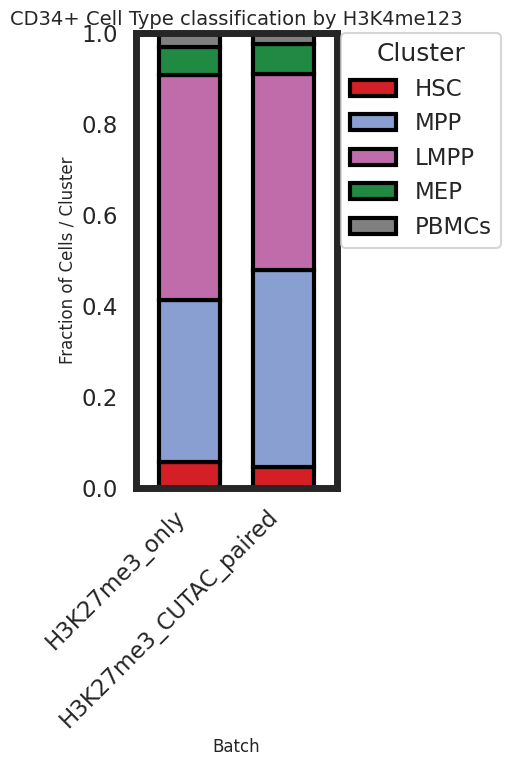

In [71]:
import matplotlib.pyplot as plt
import pandas as pd

# 1. Combine PBMC1 and PBMC2 into "PBMCs"
df_plot = results_df.copy()
df_plot['cluster'] = df_plot['cluster'].replace({'PBMC1': 'PBMCs', 'PBMC2': 'PBMCs'})

# 2. Aggregate the combined PBMCs
df_plot = df_plot.groupby('cluster', as_index=False).sum()


# 3. Set the desired cluster stack order
cluster_order = ['HSC', 'MPP', 'LMPP', 'MEP', 'PBMCs']
df_plot = df_plot[df_plot['cluster'].isin(cluster_order)]
df_plot['cluster'] = pd.Categorical(df_plot['cluster'], categories=cluster_order, ordered=True)
df_plot = df_plot.sort_values('cluster')

# 4. Reformat for plotting (rows = dataset group, columns = cluster)
df_results = df_plot.set_index('cluster').T  # now rows: group, columns: clusters
df_results = df_results[cluster_order]  # ensure correct column (stack) order

# 5. Set custom colors in order
colors = ["#D51F26", "#8A9FD1", "#C06CAB", "#208A42", "grey"]  # Must match cluster_order

# 6. Plot the stacked bar chart
fig, ax = plt.subplots(figsize=(5, 8))  # <- Your requested size
df_results.plot(
    kind='bar',
    stacked=True,
    ax=ax,
    color=colors,
    edgecolor='black',
    linewidth=3.0,
    width=0.65
)

# 7. Customize plot frame
for spine in ax.spines.values():
    spine.set_linewidth(5.0)

# 8. Labels and formatting
ax.set_xlabel('Batch', fontsize=12)
ax.set_ylabel('Fraction of Cells / Cluster', fontsize=12)
ax.set_title('CD34+ Cell Type classification by H3K4me123', fontsize=14)
ax.legend(
    bbox_to_anchor=(1.02, 1),
    loc='upper left',
    borderaxespad=0,
    title='Cluster'
)

ax.set_ylim(0, 1)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# 9. Save and show
#plt.savefig(
#    "/varidata/research/projects/janssens/Henikoff_Lab_Data/CD34_Experiments/Janssens_Lab_CD34_Data_Processing/Figure_Panels/K27me3_HSPC_Single_Vs_Paired_Percentages_Stacked_Bargraph_Redo.png",
#    dpi=300
#)
plt.show()


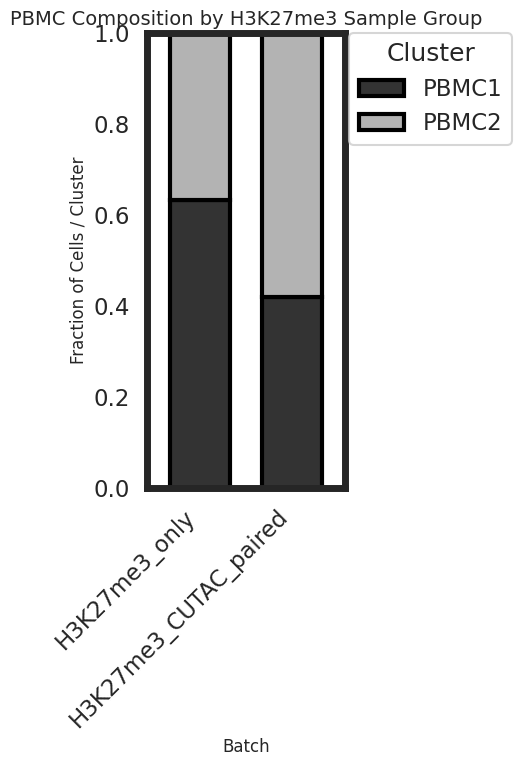

In [75]:
import pandas as pd
import matplotlib.pyplot as plt

# --- 1. Load input files ---
souporcell_file = "souporcell_H3K27me3_Combined_ReadCounts.csv.gz"
cluster_barcode_file = "K27me3_Cluster_Barcodes.csv"

souporcell_df = pd.read_csv(souporcell_file)
cluster_df = pd.read_csv(cluster_barcode_file, names=['barcode', 'cluster'], header=None)

# --- 2. Define sample groups ---
H3K27me3_only = {
    'K27me3_D1-4','K27me3_D3-6','K27me3_D3-10','K27me3_D3-10_ConA','K27me3_D3-10_WGA','K27me3_D7-10','K27me3_Nuc_PAGE_No',
    'K27me3_Nuc_PAGE_PK','K27me3_Nuc_Stnd_No','K27me3_Nuc_Stnd_PK','K27me3_WC_PAGE_No','K27me3_WC_PAGE_PK',
    'K27me3_WC_Stnd_No','K27me3_WC_Stnd_PK','K27me3_C1_240215'
}

H3K27me3_CUTAC_paired = {
    'K27me3_Multi_CUTAC_Female_Exp2','K27me3_Multi_D3-10_ConA_Exp4','K27me3_Multi_D3-10_WGA_Exp4','K27me3_Multi_Female_ConA_Exp4',
    'K27me3_Multi_Female_WGA_Exp4','K27me3_Multi_D3-10_ConA_Exp5','K27me3_Multi_D3-10_WGA_Exp5','K27me3_Multi_Female_ConA_Exp5',
    'K27me3_Multi_Female_WGA_Exp5','K27me3_CUTAC_C1_240218'
}

# Assign group labels
souporcell_df['group'] = souporcell_df['sample'].apply(
    lambda x: 'H3K27me3_only' if x in H3K27me3_only else (
        'H3K27me3_CUTAC_paired' if x in H3K27me3_CUTAC_paired else 'Other')
)

# --- 3. Filter for PBMC1 and PBMC2 only ---
pbmc_df = cluster_df[cluster_df['cluster'].isin(['PBMC1', 'PBMC2'])]

# --- 4. Merge cluster info with souporcell ---
merged_df = souporcell_df.merge(pbmc_df, on='barcode', how='inner')

# --- 5. Compute fractions per group ---
results = []

for group in ['H3K27me3_only', 'H3K27me3_CUTAC_paired']:
    group_df = merged_df[merged_df['group'] == group]
    total = len(group_df)
    
    pbmc1_frac = len(group_df[group_df['cluster'] == 'PBMC1']) / total if total > 0 else 0
    pbmc2_frac = len(group_df[group_df['cluster'] == 'PBMC2']) / total if total > 0 else 0
    
    results.append({
        'group': group,
        'PBMC1': pbmc1_frac,
        'PBMC2': pbmc2_frac
        
    })

# --- 6. Convert to DataFrame for plotting ---
df_results = pd.DataFrame(results).set_index('group')[['PBMC1', 'PBMC2']]

# --- 7. Plot ---
colors = ["#333333", "#B3B3B3"]  # PBMC1, PBMC2

fig, ax = plt.subplots(figsize=(5, 8))  # Requested dimensions

df_results.plot(
    kind='bar',
    stacked=True,
    ax=ax,
    color=colors,
    edgecolor='black',
    linewidth=3.0,
    width=0.65
)

# --- 8. Customize plot ---
for spine in ax.spines.values():
    spine.set_linewidth(5.0)

ax.set_xlabel('Batch', fontsize=12)
ax.set_ylabel('Fraction of Cells / Cluster', fontsize=12)
ax.set_title('PBMC Composition by H3K27me3 Sample Group', fontsize=14)
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, title='Cluster')

ax.set_ylim(0, 1)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# --- 9. Save and show ---
# plt.savefig("K27me3_PBMC1_vs_PBMC2_stack_by_group.png", dpi=300)
plt.show()


In [76]:
import pandas as pd

# --- 1. Load input files ---
souporcell_file = "souporcell_H3K4me1-2-3_Combined_ReadCounts.csv.gz"
cluster_barcode_file = "K4me123_Cluster_Barcodes.csv"

souporcell_df = pd.read_csv(souporcell_file)
cluster_df = pd.read_csv(cluster_barcode_file, names=['barcode', 'cluster'], header=None)

# --- 2. Define sample groups based on 'sample' column in souporcell_df ---
H3K4me123_only = set([
    'K4me123_3283', 'K4me123_3816', 'K4me123_D1-4', 'K4me123_3688', 'K4me123_3688_3773', 'K4me123_3956',
    'K4me123_3956_2071', 'K4me123_3703', 'K4me123_3724', 'K4me123_3891', 'K4me123_3992', 'K4me123_D3-6',
    'K4me123_D3-10', 'K4me123_D3-10_ConA', 'K4me123_D3-10_WGA', 'K4me123_D7-10', 'K4me123_Nuc_PAGE_No',
    'K4me123_Nuc_PAGE_PK', 'K4me123_Nuc_Stnd_No', 'K4me123_Nuc_Stnd_PK', 'K4me123_WC_PAGE_No', 'K4me123_WC_PAGE_PK',
    'K4me123_WC_Stnd_No', 'K4me123_WC_Stnd_PK', 'K4me123_C1_240215'
])

H3K4me123_CUTAC_paired = set([
    'K4me123_Multi_Female_Exp1', 'K4me123_Multi_Female_Exp2', 'K4me123_Multi_Female_Exp3',
    'K4me123_Multi_D3-10_ConA_Exp4', 'K4me123_Multi_D3-10_WGA_Exp4', 'K4me123_Multi_Female_ConA_Exp4',
    'K4me123_Multi_Female_WGA_Exp4', 'K4me123_Multi_D3-10_ConA_Exp5', 'K4me123_Multi_D3-10_WGA_Exp5',
    'K4me123_Multi_Female_ConA_Exp5', 'K4me123_Multi_Female_WGA_Exp5', 'K4me123_CUTAC_C1_240218'
])

# Assign group labels
souporcell_df['group'] = souporcell_df['sample'].apply(
    lambda x: 'H3K4me123_only' if x in H3K4me123_only else (
        'H3K4me123_CUTAC_paired' if x in H3K4me123_CUTAC_paired else 'Other'
    )
)

# --- 3. Filter for barcodes present in the cluster assignment table ---
filtered_df = souporcell_df[souporcell_df['barcode'].isin(cluster_df['barcode'])]

# --- 4. Merge cluster info into souporcell table ---
filtered_df = filtered_df.merge(cluster_df, on='barcode', how='inner')

# --- 5. Calculate proportion of each cluster within each group ---
results = {}

for group in ['H3K4me123_only', 'H3K4me123_CUTAC_paired']:
    group_df = filtered_df[filtered_df['group'] == group]
    total = len(group_df)

    cluster_props = (
        group_df['cluster'].value_counts(normalize=True) if total > 0 else pd.Series()
    )

    results[group] = cluster_props.to_dict()

# --- 6. Convert results to tidy DataFrame ---
results_df = pd.DataFrame(results).fillna(0).reset_index().rename(columns={'index': 'cluster'})

# --- 7. Display the output ---
print("\nCluster Proportions by Group:")
print(results_df)

# Optional: Save to CSV
# results_df.to_csv("K4me123_cluster_proportions_by_group.csv", index=False)



Cluster Proportions by Group:
    cluster  H3K4me123_only  H3K4me123_CUTAC_paired
0       MPP        0.494223                0.482328
1      LMPP        0.256560                0.259914
2       MEP        0.125635                0.127982
3       HSC        0.039152                0.033581
4       GMP        0.035985                0.033156
5       CLP        0.029790                0.034163
6      proB        0.007865                0.011047
7  Monocyte        0.005464                0.010512
8     Bcell        0.005325                0.007317


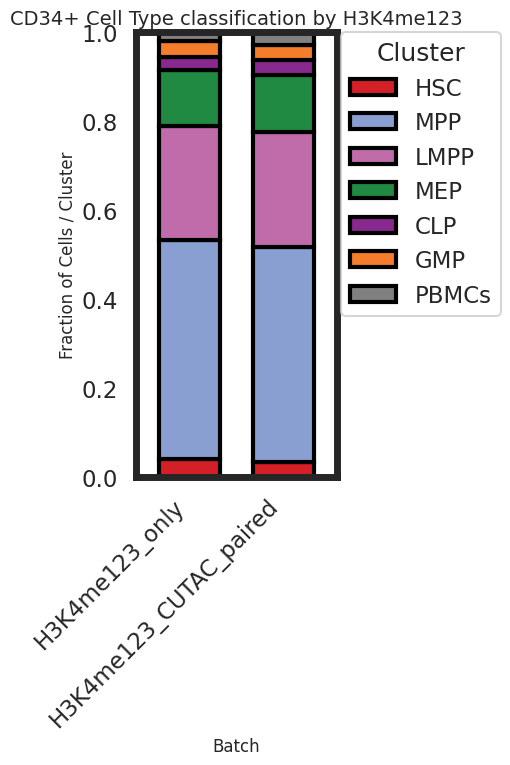

In [79]:
import pandas as pd
import matplotlib.pyplot as plt

# --- 1. Prepare and clean plotting DataFrame ---
df_plot = results_df.copy()

# Combine PBMC1, PBMC2, and PBMC3 into 'PBMCs'
df_plot['cluster'] = df_plot['cluster'].replace({'proB': 'PBMCs', 'Monocyte': 'PBMCs', 'Bcell': 'PBMCs'})

# Aggregate any duplicated cluster rows (like multiple PBMCs)
df_plot = df_plot.groupby('cluster', as_index=False).sum()

# --- 2. Define and apply cluster stacking order ---
cluster_order = ['HSC', 'MPP', 'LMPP', 'MEP', 'CLP', 'GMP', 'PBMCs']
df_plot = df_plot[df_plot['cluster'].isin(cluster_order)]  # Filter valid clusters
df_plot['cluster'] = pd.Categorical(df_plot['cluster'], categories=cluster_order, ordered=True)
df_plot = df_plot.sort_values('cluster')

# --- 3. Reformat for plotting (index = group, columns = cluster) ---
df_results = df_plot.set_index('cluster').T
df_results = df_results[cluster_order]  # Ensure correct stacking order

# --- 4. Define colors in same order as cluster_order ---
colors = ["#D51F26", "#8A9FD1", "#C06CAB", "#208A42", "#89288F", "#F47D2B", "grey"]

# --- 5. Plot the stacked bar chart ---
fig, ax = plt.subplots(figsize=(5, 8))  # Your preferred figure size

df_results.plot(
    kind='bar',
    stacked=True,
    ax=ax,
    color=colors,
    edgecolor='black',
    linewidth=3.0,
    width=0.65
)

# --- 6. Customize plot appearance ---
for spine in ax.spines.values():
    spine.set_linewidth(5.0)

ax.set_xlabel('Batch', fontsize=12)
ax.set_ylabel('Fraction of Cells / Cluster', fontsize=12)
ax.set_title('CD34+ Cell Type classification by H3K4me123', fontsize=14)

ax.legend(
    bbox_to_anchor=(1.02, 1),
    loc='upper left',
    borderaxespad=0,
    title='Cluster'
)

ax.set_ylim(0, 1)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# --- 7. Save and show plot ---
#plt.savefig(
#    "/varidata/research/projects/janssens/Henikoff_Lab_Data/CD34_Experiments/Janssens_Lab_CD34_Data_Processing/Figure_Panels/K4me123_HSPC_Single_Vs_Paired_Percentages_Stacked_Bargraph.png",
#    dpi=300
#)

plt.show()


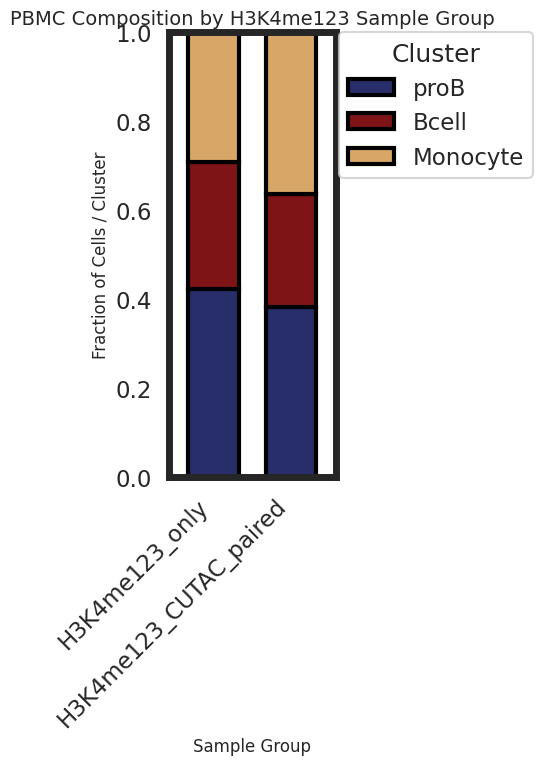

In [80]:
import pandas as pd
import matplotlib.pyplot as plt

# --- 1. Load input files ---
souporcell_file = "souporcell_H3K4me1-2-3_Combined_ReadCounts.csv.gz"
cluster_barcode_file = "K4me123_Cluster_Barcodes.csv"

souporcell_df = pd.read_csv(souporcell_file)
cluster_df = pd.read_csv(cluster_barcode_file, names=['barcode', 'cluster'], header=None)

# --- 2. Define sample groups ---
H3K4me123_only = {
    'K4me123_3283', 'K4me123_3816', 'K4me123_D1-4', 'K4me123_3688', 'K4me123_3688_3773', 'K4me123_3956',
    'K4me123_3956_2071', 'K4me123_3703', 'K4me123_3724', 'K4me123_3891', 'K4me123_3992', 'K4me123_D3-6',
    'K4me123_D3-10', 'K4me123_D3-10_ConA', 'K4me123_D3-10_WGA', 'K4me123_D7-10', 'K4me123_Nuc_PAGE_No',
    'K4me123_Nuc_PAGE_PK', 'K4me123_Nuc_Stnd_No', 'K4me123_Nuc_Stnd_PK', 'K4me123_WC_PAGE_No', 'K4me123_WC_PAGE_PK',
    'K4me123_WC_Stnd_No', 'K4me123_WC_Stnd_PK', 'K4me123_C1_240215'
}

H3K4me123_CUTAC_paired = {
    'K4me123_Multi_Female_Exp1', 'K4me123_Multi_Female_Exp2', 'K4me123_Multi_Female_Exp3',
    'K4me123_Multi_D3-10_ConA_Exp4', 'K4me123_Multi_D3-10_WGA_Exp4', 'K4me123_Multi_Female_ConA_Exp4',
    'K4me123_Multi_Female_WGA_Exp4', 'K4me123_Multi_D3-10_ConA_Exp5', 'K4me123_Multi_D3-10_WGA_Exp5',
    'K4me123_Multi_Female_ConA_Exp5', 'K4me123_Multi_Female_WGA_Exp5', 'K4me123_CUTAC_C1_240218'
}

# --- 3. Assign sample group labels ---
souporcell_df['group'] = souporcell_df['sample'].apply(
    lambda x: 'H3K4me123_only' if x in H3K4me123_only else (
        'H3K4me123_CUTAC_paired' if x in H3K4me123_CUTAC_paired else 'Other')
)

# --- 4. Filter for relevant clusters ---
valid_clusters = ['proB', 'Bcell', 'Monocyte']
cluster_df = cluster_df[cluster_df['cluster'].isin(valid_clusters)]

# --- 5. Merge souporcell + cluster info ---
merged_df = souporcell_df.merge(cluster_df, on='barcode', how='inner')

# --- 6. Compute cluster fractions per group ---
results = []
for group in ['H3K4me123_only', 'H3K4me123_CUTAC_paired']:
    group_df = merged_df[merged_df['group'] == group]
    total = len(group_df)
    
    counts = group_df['cluster'].value_counts(normalize=True).to_dict()
    row = {'group': group}
    for clus in valid_clusters:
        row[clus] = counts.get(clus, 0)
    results.append(row)

# --- 7. Format for plotting ---
df_results = pd.DataFrame(results).set_index('group')[valid_clusters]

# --- 8. Plot ---
colors = ["#272E6A", "#7E1416", "#D8A767"]  # proB, Bcell, Monocyte

fig, ax = plt.subplots(figsize=(5, 8))
df_results.plot(
    kind='bar',
    stacked=True,
    ax=ax,
    color=colors,
    edgecolor='black',
    linewidth=3.0,
    width=0.65
)

# Style plot
for spine in ax.spines.values():
    spine.set_linewidth(5.0)

ax.set_xlabel('Sample Group', fontsize=12)
ax.set_ylabel('Fraction of Cells / Cluster', fontsize=12)
ax.set_title('PBMC Composition by H3K4me123 Sample Group', fontsize=14)
ax.legend(
    bbox_to_anchor=(1.02, 1),
    loc='upper left',
    borderaxespad=0,
    title='Cluster'
)

ax.set_ylim(0, 1)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# --- 9. Save & show ---
# plt.savefig("K4me123_proB_Bcell_Monocyte_StackedBar.png", dpi=300)
plt.show()


In [86]:
ArchR_hg38_Gene_List =  pd.read_csv('rowDataGSM_hg38.csv', sep=',')
ArchR_hg38_Gene_List = ArchR_hg38_Gene_List.iloc[:, [1, 2, 3, 4, 5]]
ArchR_hg38_Gene_List.columns = ['chr', 'start', 'stop', 'strand','gene']
ArchR_hg38_Gene_List_1 = ArchR_hg38_Gene_List[ArchR_hg38_Gene_List['strand'].isin([1])]
ArchR_hg38_Gene_List_2 = ArchR_hg38_Gene_List[ArchR_hg38_Gene_List['strand'].isin([2])]
ArchR_hg38_Gene_List_2 = ArchR_hg38_Gene_List_2.iloc[:, [0, 2, 1, 3, 4]]
ArchR_hg38_Gene_List_2.columns = ['chr', 'start', 'stop', 'strand','gene' ]
hg38_Gene_List = pd.concat([ArchR_hg38_Gene_List_1, ArchR_hg38_Gene_List_2])
hg38_Gene_List = hg38_Gene_List.sort_values(['chr', 'start'], ascending = [True, True])
hg38_Gene_List['Real'] = [1 if (x - y)<2500000 else 0 for x,y in zip(hg38_Gene_List['stop'], hg38_Gene_List['start'])]
hg38_Bad_Gene_List = hg38_Gene_List[hg38_Gene_List['Real'].isin([0])]
hg38_Gene_List = hg38_Gene_List[hg38_Gene_List['Real'].isin([1])]

hg38_Gene_List = hg38_Gene_List.iloc[:, [0, 1, 2, 4]]
hg38_Gene_List = hg38_Gene_List.sort_values(by = ['chr', 'start'], ascending = [True, True])
#hg38_Gene_List_bed = BedTool.from_dataframe(hg38_Gene_List_1)

# Add the IL3RA gene
new_row = {
    'chr': 'chrX',
    'start': 1334785,
    'stop': 1384689,
    'gene': 'IL3RA'
}

# Append the new row to the dataframe
hg38_Gene_List = pd.concat([hg38_Gene_List, pd.DataFrame([new_row])], ignore_index=True)


# Sort the dataframe by 'chromosome' and 'start'
hg38_Gene_List = hg38_Gene_List.sort_values(by=['chr', 'start']).reset_index(drop=True)


hg38_Gene_List.head(5)

chr   start    stop          gene
0  chr1   69091   70008         OR4F5
1  chr1  139790  140339     LOC729737
2  chr1  585990  629010  LOC101928626
3  chr1  817371  819837        FAM87B
4  chr1  825138  859446     LINC01128

In [87]:
# 1. Define the list of genes to keep
S_Phase_Genes = [
    'HIST1H2BC', 'HIST1H1E', 'HIST1H2BD','HIST2H2AC','HIST1H2BE','HIST1H2AE','HIST1H2AG','HIST1H1D','HIST1H2BG','HIST1H4I','HIST1H2BJ',
    'HIST1H4E','HIST1H3C','HIST1H4D','HIST1H2AI','HIST1H3D','HIST1H3H','HIST1H2BL','HIST1H2BN','HIST1H2BB','HIST1H4F'
] #'H1FX-AS1', 'RAB4B-EGLN2'

# 2. Filter the DataFrame
S_Phase_Gene_Regions = hg38_Gene_List[hg38_Gene_List['gene'].isin(S_Phase_Genes)]

In [ ]:
CUTAC_Batch3_Full = pd.read_csv(
    'Full_hg38_Aligned_BED_Files/Batch_Beds_CUTAC/CUTAC_Batch3_Full.bed.gz',
    sep='\t', header=None
)

CUTAC_Batch4_2in1_wK27me3_wSplit_Full = pd.read_csv(
    'Full_hg38_Aligned_BED_Files/Batch_Beds_CUTAC_wSplit_Combined/CUTAC_Batch4_2in1_wK27me3_wSplit_Full.bed.gz',
    sep='\t', header=None
)

CUTAC_Batch7_2in1_wK4me123_wSplit_Full = pd.read_csv(
    'Full_hg38_Aligned_BED_Files/Batch_Beds_CUTAC_wSplit_Combined/CUTAC_Batch7_2in1_wK4me123_wSplit_Full.bed.gz',
    sep='\t', header=None
)

CUTAC_Batch7_2in1_wK27me3_wSplit_Full = pd.read_csv(
    'Full_hg38_Aligned_BED_Files/Batch_Beds_CUTAC_wSplit_Combined/CUTAC_Batch7_2in1_wK27me3_wSplit_Full.bed.gz',
    sep='\t', header=None
)

CUTAC_Batch8_2in1_wK4me123_wSplit_Full = pd.read_csv(
    'Full_hg38_Aligned_BED_Files/Batch_Beds_CUTAC_wSplit_Combined/CUTAC_Batch8_2in1_wK4me123_wSplit_Full.bed.gz',
    sep='\t', header=None
)

CUTAC_Batch8_2in1_wK27me3_wSplit_Full = pd.read_csv(
    'Full_hg38_Aligned_BED_Files/Batch_Beds_CUTAC_wSplit_Combined/CUTAC_Batch8_2in1_wK27me3_wSplit_Full.bed.gz',
    sep='\t', header=None
)

CUTAC_Batch9_2in1_wK4me123_wSplit_Full = pd.read_csv(
    'Full_hg38_Aligned_BED_Files/Batch_Beds_CUTAC_wSplit_Combined/CUTAC_Batch9_2in1_wK4me123_wSplit_Full.bed.gz',
    sep='\t', header=None
)

CUTAC_Batch9_2in1_wK27me3_wSplit_Full = pd.read_csv(
    'Full_hg38_Aligned_BED_Files/Batch_Beds_CUTAC_wSplit_Combined/CUTAC_Batch9_2in1_wK27me3_wSplit_Full.bed.gz',
    sep='\t', header=None
)

CUTAC_Batch10_Full = pd.read_csv(
    'Full_hg38_Aligned_BED_Files/Batch_Beds_CUTAC/CUTAC_Batch10_Full.bed.gz',
    sep='\t', header=None
)

CUTAC_combined  = pd.concat([CUTAC_Batch3_Full, CUTAC_Batch4_2in1_wK27me3_wSplit_Full, CUTAC_Batch7_2in1_wK4me123_wSplit_Full, CUTAC_Batch7_2in1_wK27me3_wSplit_Full, 
                       CUTAC_Batch8_2in1_wK4me123_wSplit_Full, CUTAC_Batch8_2in1_wK27me3_wSplit_Full, CUTAC_Batch9_2in1_wK4me123_wSplit_Full,
                       CUTAC_Batch9_2in1_wK27me3_wSplit_Full, CUTAC_Batch10_Full], ignore_index=True)

In [90]:
# Convert the CUTAC DataFrame to a BedTool object.
cutac_bed = BedTool.from_dataframe(CUTAC_combined)

# ------------------------------------------------------
# 2. Convert Gene Region DataFrames to BedTool Objects
# ------------------------------------------------------
# It is assumed that the following DataFrames are already defined:
# S_Phase_Gene_Regions, 
# G2M_Phase_Gene_Promoters, G2M_Phase_Gene_GBodies, 
# G1S_Phase_Gene_Promoters, G1S_Phase_Gene_GBodies

S_Phase_bed = BedTool.from_dataframe(S_Phase_Gene_Regions)

# ------------------------------------------------------
# 3. Define a Function to Calculate Read Counts in Regions
# ------------------------------------------------------
def calculate_frip_reads(cutac_bed_obj, gene_bed_obj):
    """
    Intersect the CUTAC bed with a gene region bed and return a DataFrame with the count of 
    reads (per barcode) that overlap the gene regions.
    """
    # Perform the intersection with the -wao option (reporting overlap length)
    intersection = cutac_bed_obj.intersect(gene_bed_obj, wao=True)
    
    # The intersection output contains:
    # [chrom, start, stop, barcode, gene_chr, gene_start, gene_stop, gene, overlap]
    cols = ["chrom", "start", "stop", "barcode", "gene_chr", "gene_start", "gene_stop", "gene", "overlap"]
    inter_df = pd.read_csv(intersection.fn, sep="\t", header=None, names=cols)
    
    # Keep only entries with an overlap > 0 (i.e. reads that fall inside a gene region).
    overlap_df = inter_df[inter_df["overlap"] > 0]
    
    # Count the number of reads per barcode in this gene set.
    reads_per_barcode = overlap_df["barcode"].value_counts().reset_index()
    reads_per_barcode.columns = ["barcode", "reads_in_genes"]
    
    return reads_per_barcode

# ------------------------------------------------------
# 4. Calculate Read Counts for Each Region Set
# ------------------------------------------------------
# For S phase gene regions.
s_phase_reads = calculate_frip_reads(cutac_bed, S_Phase_bed)
s_phase_reads.rename(columns={"reads_in_genes": "s_reads"}, inplace=True)

In [93]:
s_phase_reads.head(5)

barcode  s_reads
0  TGGGTTTCCTAGAAGTAGCGATAGTATAGCCT-266       30
1  GGCGTCGATCTGGCGAAGCGATAGTAATCTTA-266       27
2   AGGTTGGGAGAGTAGAGTTATCCGTTACGCCG-30       23
3  GGAGTAAGCGTAGACCAGCGATAGGTACTGAC-266       21
4   CAATCTTATGATGAAACATTGTGGGCGGTTAA-38       18

In [94]:
split_combined.head(5)

0      1      2                                     3
0  chr1  10002  10066  AGACCAGCAGGTTGCCTCCGGAGATTCTCGTA-126
1  chr1  10003  10096   AGTAGATTAGTCCGAGGTTATCCGCGGCGACA-30
2  chr1  10003  10143   AGTAGATTCGATAGGGGTTATCCGAATAACGT-30
3  chr1  10003  10172   AAATACAGGGCACGGAGTTATCCGAATAACGT-30
4  chr1  10003  10233   CTTGGGTCACCGGCCCTCCGGAGAGTACTGAC-15

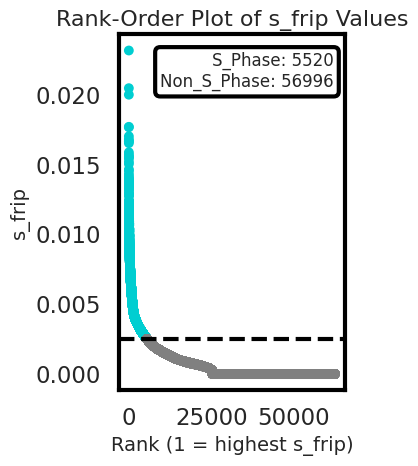

In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pybedtools import BedTool

# ------------------------------------------------------
# 1. Convert the CUTAC DataFrame to BedTool
# ------------------------------------------------------
cutac_bed = BedTool.from_dataframe(split_combined)

# ------------------------------------------------------
# 2. Convert S-Phase Region DataFrame to BedTool
# ------------------------------------------------------
S_Phase_bed = BedTool.from_dataframe(S_Phase_Gene_Regions)

# ------------------------------------------------------
# 3. Define function to count reads overlapping gene regions
# ------------------------------------------------------
def calculate_frip_reads(cutac_bed_obj, gene_bed_obj):
    intersection = cutac_bed_obj.intersect(gene_bed_obj, wao=True)
    cols = ["chrom", "start", "stop", "barcode", "gene_chr", "gene_start", "gene_stop", "gene", "overlap"]
    inter_df = pd.read_csv(intersection.fn, sep="\t", header=None, names=cols)
    overlap_df = inter_df[inter_df["overlap"] > 0]
    reads_per_barcode = overlap_df["barcode"].value_counts().reset_index()
    reads_per_barcode.columns = ["barcode", "s_reads"]
    return reads_per_barcode

# ------------------------------------------------------
# 4. Calculate S-phase read counts per barcode
# ------------------------------------------------------
s_phase_reads = calculate_frip_reads(cutac_bed, S_Phase_bed)

# ------------------------------------------------------
# 5. Get total reads per barcode from split_combined
# ------------------------------------------------------
split_combined.columns = ["chrom", "start", "end", "barcode"]

total_reads = (
    split_combined[["barcode"]]
    .assign(total_reads=1)
    .groupby("barcode")
    .sum()
    .reset_index()
)

# ------------------------------------------------------
# 6. Merge and compute s_frip
# ------------------------------------------------------
merged_df = pd.merge(total_reads, s_phase_reads, on="barcode", how="left")
merged_df["s_reads"] = merged_df["s_reads"].fillna(0)
merged_df["s_frip"] = merged_df["s_reads"] / merged_df["total_reads"]

# ------------------------------------------------------
# 7. Rank-order and threshold
# ------------------------------------------------------
s_rank = merged_df["s_frip"].sort_values(ascending=False).reset_index(drop=True)
values = s_rank.values
ranks = np.arange(1, len(values) + 1)

threshold = 0.0025
colors = ['#00CED1' if v > threshold else 'grey' for v in values]

n_s = int((values > threshold).sum())
n_non_s = len(values) - n_s

# ------------------------------------------------------
# 8. Plot
# ------------------------------------------------------
fig, ax = plt.subplots(figsize=(4, 5))

ax.scatter(
    ranks,
    values,
    c=colors,
    s=50,
    edgecolors='none'
)

ax.axhline(
    y=threshold,
    color='black',
    linestyle='--',
    linewidth=3
)

ax.text(
    0.95, 0.95,
    f"S_Phase: {n_s}\nNon_S_Phase: {n_non_s}",
    transform=ax.transAxes,
    ha='right',
    va='top',
    fontsize=12,
    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='black', linewidth=3)
)

for spine in ax.spines.values():
    spine.set_color('black')
    spine.set_linewidth(3)

ax.set_xlabel('Rank (1 = highest s_frip)', fontsize=14)
ax.set_ylabel('s_frip', fontsize=14)
ax.set_title('Rank‐Order Plot of s_frip Values', fontsize=16)

plt.tight_layout()

# Save figure
#plt.savefig(
#    '/varidata/research/projects/janssens/Henikoff_Lab_Data/CD34_Experiments/Janssens_Lab_CD34_Data_Processing/Figure_Panels/RNA_Pol2_SPhase_FRIP_Cutoff.png',
#    dpi=300,
#    bbox_inches='tight'
#)

plt.show()


/tmp/ipykernel_204566/1671720930.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


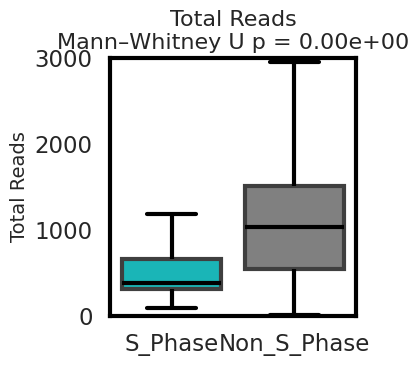

In [97]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# ------------------------------------------------------
# 1. Define groups from s_frip threshold
# ------------------------------------------------------
cutoff = 0.0025
merged_df['Group'] = np.where(merged_df['s_frip'] > cutoff, 'S_Phase', 'Non_S_Phase')

# ------------------------------------------------------
# 2. Plotting style
# ------------------------------------------------------
palette = {'S_Phase': '#00CED1', 'Non_S_Phase': 'grey'}
sns.set_style('white')
sns.set_context('talk')

# ------------------------------------------------------
# 3. Prepare and plot total_reads comparison
# ------------------------------------------------------
g1 = merged_df.loc[merged_df['Group'] == 'S_Phase', 'total_reads'].dropna()
g2 = merged_df.loc[merged_df['Group'] == 'Non_S_Phase', 'total_reads'].dropna()
stat, p = stats.mannwhitneyu(g1, g2, alternative='two-sided')

fig, ax = plt.subplots(figsize=(4, 4))

sns.boxplot(
    data=merged_df,
    x='Group',
    y='total_reads',
    order=['S_Phase', 'Non_S_Phase'],
    palette=palette,
    showfliers=False,
    linewidth=3.0,
    ax=ax
)

# Style the plot
ax.grid(False)
for patch in ax.artists:
    patch.set_facecolor('white')
    patch.set_edgecolor('black')
    patch.set_linewidth(3.0)
for line in ax.lines:
    line.set_color('black')
    line.set_linewidth(3.0)
for spine in ax.spines.values():
    spine.set_color('black')
    spine.set_linewidth(3.0)

ax.set_ylim(0, 3000)
ax.set_xlabel('')
ax.set_ylabel('Total Reads', fontsize=14)
ax.set_title(f"Total Reads\nMann–Whitney U p = {p:.2e}", fontsize=16)

plt.tight_layout()

# Optional: save
# plt.savefig("S_Phase_vs_Non_S_TotalReads.png", dpi=300)

plt.show()


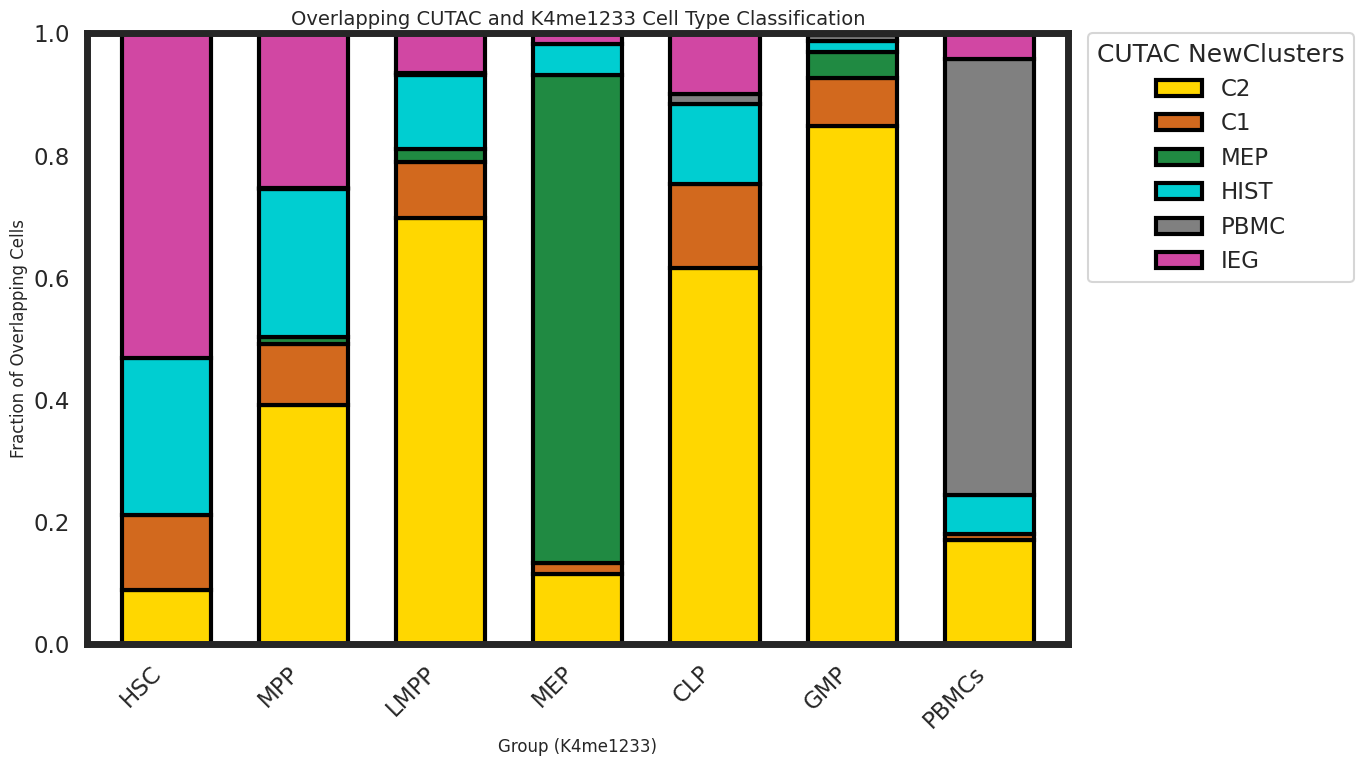

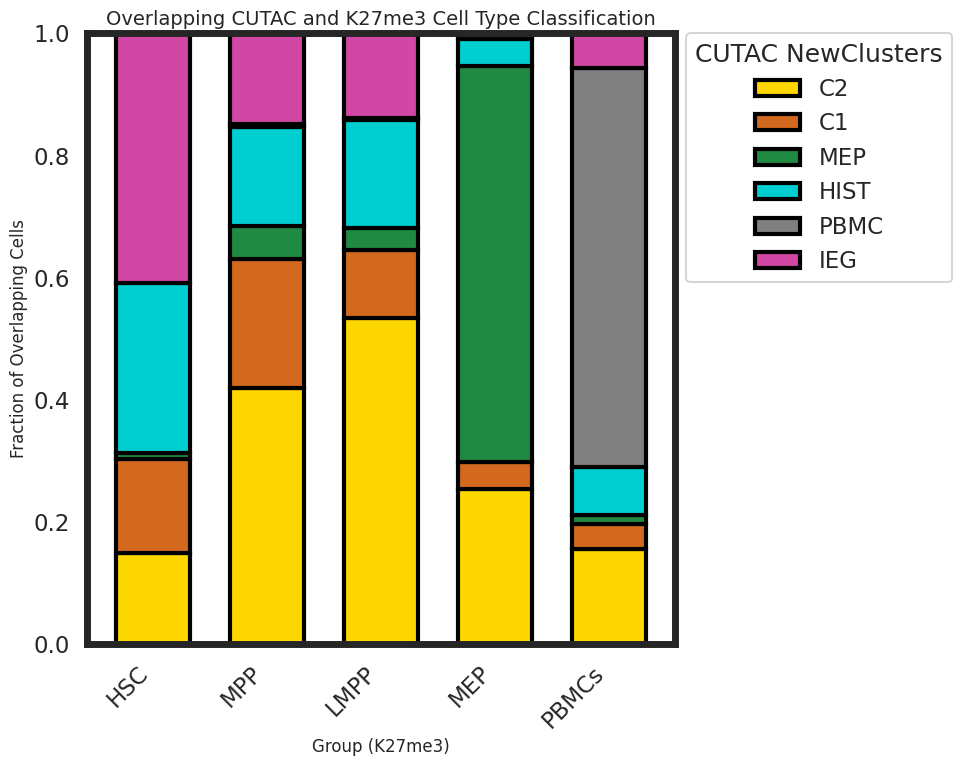

In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Read the CSV files
cutac_path = "CUTAC_UMAP_table.csv"
k4_path    = "K4me123_UMAP_table.csv"
k27_path   = "K27me3_UMAP_table.csv"

cutac = pd.read_csv(cutac_path)
k4    = pd.read_csv(k4_path)
k27   = pd.read_csv(k27_path)

# 2. Filter k4 and k27 to include only barcodes present in CUTAC
cutac_barcodes = set(cutac['Barcode'])
k4  = k4[k4['Barcode'].isin(cutac_barcodes)]
k27 = k27[k27['Barcode'].isin(cutac_barcodes)]

# 3. In k27, collapse 'GMP' and 'CLP' into 'LMPP'
k27['NewClusters'] = k27['NewClusters'].replace({'GMP': 'LMPP', 'CLP': 'LMPP'})

# 4. Combine PBMC1, PBMC2, PBMC3 into one group ("PBMCs") in k4 and k27
k4_pbmc_map = {'proB': 'PBMCs', 'Monocyte': 'PBMCs', 'Bcell': 'PBMCs'}
k27_pbmc_map = {"PBMC1": "PBMCs", "PBMC2": "PBMCs"}
k4['NewClusters']  = k4['NewClusters'].replace(k4_pbmc_map)
k27['NewClusters'] = k27['NewClusters'].replace(k27_pbmc_map)


# 5. Merge k4 and k27 with CUTAC to bring in the CUTAC NewClusters info
k4_merged  = pd.merge(k4,  cutac[['Barcode', 'NewClusters']], on='Barcode', suffixes=('_k4',  '_cutac'))
k27_merged = pd.merge(k27, cutac[['Barcode', 'NewClusters']], on='Barcode', suffixes=('_k27', '_cutac'))

# 6. For each dataset, group by the table-specific cluster and CUTAC category, then count and compute percentages.

# For K4me1233:
k4_counts = (
    k4_merged
    .groupby(['NewClusters_k4','NewClusters_cutac'])
    .size()
    .reset_index(name='count')
)
k4_totals = (
    k4_counts
    .groupby('NewClusters_k4')['count']
    .sum()
    .reset_index(name='total')
)
k4_counts = pd.merge(k4_counts, k4_totals, on='NewClusters_k4')
k4_counts['percentage'] = 100 * k4_counts['count'] / k4_counts['total']
k4_counts = k4_counts.rename(columns={
    'NewClusters_k4':'Group',
    'NewClusters_cutac':'CUTAC_Group'
})

# For K27me3:
k27_counts = (
    k27_merged
    .groupby(['NewClusters_k27','NewClusters_cutac'])
    .size()
    .reset_index(name='count')
)
k27_totals = (
    k27_counts
    .groupby('NewClusters_k27')['count']
    .sum()
    .reset_index(name='total')
)
k27_counts = pd.merge(k27_counts, k27_totals, on='NewClusters_k27')
k27_counts['percentage'] = 100 * k27_counts['count'] / k27_counts['total']
k27_counts = k27_counts.rename(columns={
    'NewClusters_k27':'Group',
    'NewClusters_cutac':'CUTAC_Group'
})

# 7. Define the desired ordering
group_order = ["HSC","MPP","LMPP","MEP","CLP","GMP","PBMCs"]
cutac_order = ["C2","C1","MEP","HIST","PBMC","IEG"]

# 8. Pivot the data separately for each dataset.
pivot_k4 = (
    k4_counts
    .pivot_table(index='Group', columns='CUTAC_Group', values='percentage', fill_value=0)
    .reindex(index=group_order, columns=cutac_order, fill_value=0)
)
pivot_k27 = (
    k27_counts
    .pivot_table(index='Group', columns='CUTAC_Group', values='percentage', fill_value=0)
    .reindex(index=group_order, columns=cutac_order, fill_value=0)
)

# 9. Convert percentages to fractions (0–1) for plotting
pivot_k4_fraction  = pivot_k4  / 100
pivot_k27_fraction = pivot_k27 / 100

# 10. Define colors for the CUTAC groups in the desired order
cutac_colors = {
    "C2": "#FFD700",
    "C1": "#D2691E",
    "MEP": "#208A42",
    "HIST": "#00CED1",
    "PBMC": "grey",
    "IEG": "#D147A3"
}
colors_order = [cutac_colors[c] for c in cutac_order]

# 11. Plot for K4me1233
fig, ax = plt.subplots(figsize=(14, 8))
pivot_k4_fraction.plot(
    kind='bar', stacked=True, ax=ax, color=colors_order,
    edgecolor='black', linewidth=3.0, width=0.65
)
ax.set_xlabel('Group (K4me1233)', fontsize=12)
ax.set_ylabel('Fraction of Overlapping Cells', fontsize=12)
ax.set_title('Overlapping CUTAC and K4me1233 Cell Type Classification', fontsize=14)
ax.legend(
    bbox_to_anchor=(1.02, 1), loc='upper left',
    borderaxespad=0, title='CUTAC NewClusters'
)
ax.set_ylim(0, 1)
plt.xticks(rotation=45, ha='right')
for spine in ax.spines.values():
    spine.set_linewidth(5.0)
plt.tight_layout()
#plt.savefig(
#    "/varidata/research/projects/janssens/Henikoff_Lab_Data/CD34_Experiments/Janssens_Lab_CD34_Data_Processing/Figure_Panels/K4me123_Cluster_Distribution_CUTAC_Clusters_Stacked_Bargraph.png",
#    dpi=300
#)
plt.show()

# 12. Plot for K27me3

pivot_k27_fraction = pivot_k27_fraction.drop(index=['CLP','GMP'], errors='ignore')

fig, ax = plt.subplots(figsize=(10, 8))
pivot_k27_fraction.plot(
    kind='bar', stacked=True, ax=ax, color=colors_order,
    edgecolor='black', linewidth=3.0, width=0.65
)
ax.set_xlabel('Group (K27me3)', fontsize=12)
ax.set_ylabel('Fraction of Overlapping Cells', fontsize=12)
ax.set_title('Overlapping CUTAC and K27me3 Cell Type Classification', fontsize=14)
ax.legend(
    bbox_to_anchor=(1.02, 1), loc='upper left',
    borderaxespad=0, title='CUTAC NewClusters'
)
ax.set_ylim(0, 1)
plt.xticks(rotation=45, ha='right')
for spine in ax.spines.values():
    spine.set_linewidth(5.0)
plt.tight_layout()
#plt.savefig(
#    "/varidata/research/projects/janssens/Henikoff_Lab_Data/CD34_Experiments/Janssens_Lab_CD34_Data_Processing/Figure_Panels/K27me3_Cluster_Distribution_CUTAC_Clusters_Stacked_Bargraph_Redo.png",
#    dpi=300
#)
plt.show()


# This series Identifies the TSS with the highes CUTAC signal in our dataset

In [87]:
CUTAC_Batch3_Full = pd.read_csv(
    'Full_hg38_Aligned_BED_Files/Batch_Beds_CUTAC/CUTAC_Batch3_Full.bed.gz',
    sep='\t', header=None
)

CUTAC_Batch4_2in1_wK27me3_wSplit_Full = pd.read_csv(
    'Full_hg38_Aligned_BED_Files/Batch_Beds_CUTAC_wSplit_Combined/CUTAC_Batch4_2in1_wK27me3_wSplit_Full.bed.gz',
    sep='\t', header=None
)

CUTAC_Batch7_2in1_wK4me123_wSplit_Full = pd.read_csv(
    'Full_hg38_Aligned_BED_Files/Batch_Beds_CUTAC_wSplit_Combined/CUTAC_Batch7_2in1_wK4me123_wSplit_Full.bed.gz',
    sep='\t', header=None
)

CUTAC_Batch7_2in1_wK27me3_wSplit_Full = pd.read_csv(
    'Full_hg38_Aligned_BED_Files/Batch_Beds_CUTAC_wSplit_Combined/CUTAC_Batch7_2in1_wK27me3_wSplit_Full.bed.gz',
    sep='\t', header=None
)

CUTAC_Batch8_2in1_wK4me123_wSplit_Full = pd.read_csv(
    'Full_hg38_Aligned_BED_Files/Batch_Beds_CUTAC_wSplit_Combined/CUTAC_Batch8_2in1_wK4me123_wSplit_Full.bed.gz',
    sep='\t', header=None
)

CUTAC_Batch8_2in1_wK27me3_wSplit_Full = pd.read_csv(
    'Full_hg38_Aligned_BED_Files/Batch_Beds_CUTAC_wSplit_Combined/CUTAC_Batch8_2in1_wK27me3_wSplit_Full.bed.gz',
    sep='\t', header=None
)

CUTAC_Batch9_2in1_wK4me123_wSplit_Full = pd.read_csv(
    'Full_hg38_Aligned_BED_Files/Batch_Beds_CUTAC_wSplit_Combined/CUTAC_Batch9_2in1_wK4me123_wSplit_Full.bed.gz',
    sep='\t', header=None
)

CUTAC_Batch9_2in1_wK27me3_wSplit_Full = pd.read_csv(
    'Full_hg38_Aligned_BED_Files/Batch_Beds_CUTAC_wSplit_Combined/CUTAC_Batch9_2in1_wK27me3_wSplit_Full.bed.gz',
    sep='\t', header=None
)

CUTAC_Batch10_Full = pd.read_csv(
    'Full_hg38_Aligned_BED_Files/Batch_Beds_CUTAC/CUTAC_Batch10_Full.bed.gz',
    sep='\t', header=None
)

CUTAC_combined  = pd.concat([CUTAC_Batch3_Full, CUTAC_Batch4_2in1_wK27me3_wSplit_Full, CUTAC_Batch7_2in1_wK4me123_wSplit_Full, CUTAC_Batch7_2in1_wK27me3_wSplit_Full, 
                       CUTAC_Batch8_2in1_wK4me123_wSplit_Full, CUTAC_Batch8_2in1_wK27me3_wSplit_Full, CUTAC_Batch9_2in1_wK4me123_wSplit_Full,
                       CUTAC_Batch9_2in1_wK27me3_wSplit_Full, CUTAC_Batch10_Full], ignore_index=True)

In [88]:
import pandas as pd
import re

# Read GTF file into a DataFrame
gtf_file = 'gencode.v38.annotation.gtf.gz'

# Define column names based on the GTF format
columns = ["seqname", "source", "feature", "start", "end", "score", "strand", "frame", "attribute"]

# Read the file (ignoring comment lines that start with "#")
hg38_annotation = pd.read_csv(gtf_file, sep="\t", comment="#", names=columns, compression="gzip")

def parse_attributes(attribute_string):
    """
    Parses the GTF attribute column into a dictionary of key-value pairs.
    """
    attributes = {}
    for attr in attribute_string.strip().split(";"):
        if attr.strip():
            key_value = re.match(r'(\S+) "([^"]+)"', attr.strip())
            if key_value:
                key, value = key_value.groups()
                attributes[key] = value
    return attributes

# Apply parsing function
parsed_attributes = hg38_annotation["attribute"].apply(parse_attributes)

# Convert list of dictionaries to DataFrame
attributes_df = pd.DataFrame(parsed_attributes.tolist())

# Merge parsed attributes with the original DataFrame (drop old 'attribute' column)
hg38_annotation = hg38_annotation.drop(columns=["attribute"]).join(attributes_df)

print(hg38_annotation.head(5))

  seqname  source     feature  start    end score strand frame  \
0    chr1  HAVANA        gene  11869  14409     .      +     .   
1    chr1  HAVANA  transcript  11869  14409     .      +     .   
2    chr1  HAVANA        exon  11869  12227     .      +     .   
3    chr1  HAVANA        exon  12613  12721     .      +     .   
4    chr1  HAVANA        exon  13221  14409     .      +     .   

             gene_id                           gene_type  ...  \
0  ENSG00000223972.5  transcribed_unprocessed_pseudogene  ...   
1  ENSG00000223972.5  transcribed_unprocessed_pseudogene  ...   
2  ENSG00000223972.5  transcribed_unprocessed_pseudogene  ...   
3  ENSG00000223972.5  transcribed_unprocessed_pseudogene  ...   
4  ENSG00000223972.5  transcribed_unprocessed_pseudogene  ...   

       transcript_id       transcript_type transcript_name  \
0                NaN                   NaN             NaN   
1  ENST00000456328.2  processed_transcript     DDX11L1-202   
2  ENST00000456328.2  proc

In [89]:
pd.set_option("display.max_columns", None)  # Show all columns
pd.set_option("display.expand_frame_repr", False)  # Prevent wrapping to multiple lines
pd.set_option("display.max_colwidth", None)  # Show full content of each column

# Display first 50 rows without truncation
hg38_annotation.head(5)


seqname  source     feature  start    end score strand frame            gene_id                           gene_type gene_name     hgnc_id           havana_gene      transcript_id       transcript_type transcript_name transcript_support_level    tag     havana_transcript            exon_id  ont protein_id ccdsid
0    chr1  HAVANA        gene  11869  14409     .      +     .  ENSG00000223972.5  transcribed_unprocessed_pseudogene   DDX11L1  HGNC:37102  OTTHUMG00000000961.2                NaN                   NaN             NaN                      NaN    NaN                   NaN                NaN  NaN        NaN    NaN
1    chr1  HAVANA  transcript  11869  14409     .      +     .  ENSG00000223972.5  transcribed_unprocessed_pseudogene   DDX11L1  HGNC:37102  OTTHUMG00000000961.2  ENST00000456328.2  processed_transcript     DDX11L1-202                        1  basic  OTTHUMT00000362751.1                NaN  NaN        NaN    NaN
2    chr1  HAVANA        exon  11869  12227     .      +     .  ENSG00000223972.5  transcribed_unprocessed_pseudogene   DDX11L1  HGNC:37102  OTTHUMG00000000961.2  ENST00000456328.2  processed_transcript     DDX11L1-202                        1  basic  OTTHUMT00000362751.1  ENSE00002234944.1  NaN        NaN    NaN
3    chr1  HAVANA        exon  12613  12721     .      +     .  ENSG00000223972.5  transcribed_unprocessed_pseudogene   DDX11L1  HGNC:37102  OTTHUMG00000000961.2  ENST00000456328.2  processed_transcript     DDX11L1-202                        1  basic  OTTHUMT00000362751.1  ENSE00003582793.1  NaN        NaN    NaN
4    chr1  HAVANA        exon  13221  14409     .      +     .  ENSG00000223972.5  transcribed_unprocessed_pseudogene   DDX11L1  HGNC:37102  OTTHUMG00000000961.2  ENST00000456328.2  processed_transcript     DDX11L1-202                        1  basic  OTTHUMT00000362751.1  ENSE00002312635.1  NaN        NaN    NaN

In [90]:
import pandas as pd

# Filter rows where 'gene_name' is in CD34_Marker_Genes and 'feature' is 'transcript'
filtered_df = hg38_annotation[
    #(hg38_annotation['gene_name'].isin(CD34_Marker_Genes)) & 
    (hg38_annotation['feature'] == 'transcript')
]

# Create BED format
def create_bed_row(row):
    """
    Converts GTF row to BED format based on strand direction.
    """
    if row['strand'] == '+':
        start = max(0, row['start'] - 3000)  # Ensure start is not negative
        end = row['start'] + 3000
    else:
        start = max(0, row['end'] - 3000)
        end = row['end'] + 3000
    
    return [row['seqname'], start, end, row['gene_name']]

# Apply function to each row
bed_data = filtered_df.apply(create_bed_row, axis=1)

# Convert to DataFrame
bed_df = pd.DataFrame(bed_data.tolist(), columns=['chrom', 'start', 'end', 'name'])
bed_df = bed_df.drop_duplicates()

bed_df.head(10)

chrom  start    end         name
0  chr1   8869  14869      DDX11L1
1  chr1   9010  15010      DDX11L1
2  chr1  26570  32570       WASH7P
3  chr1  14436  20436    MIR6859-1
4  chr1  26554  32554  MIR1302-2HG
5  chr1  27267  33267  MIR1302-2HG
6  chr1  27366  33366    MIR1302-2
7  chr1  33081  39081      FAM138A
8  chr1  33073  39073      FAM138A
9  chr1  49473  55473       OR4G4P

In [91]:
import pandas as pd
import pybedtools
import time

# Load BED files
cutac_bed = pybedtools.BedTool.from_dataframe(CUTAC_combined)

# Convert merged_df to BedTool object
promoter_intervals_bed = pybedtools.BedTool.from_dataframe(bed_df)
bed_tool = pybedtools.BedTool(cutac_bed)

# Compute overlap
start_time = time.time()
overlap = promoter_intervals_bed.intersect(bed_tool, wao=True)
overlap_df = pd.read_csv(overlap.fn, sep='\t', header=None)

# Assign column names
overlap_df.columns = ['chrom', 'start', 'stop', 'gene', 'chrom2', 'start2', 'stop2', 'barcode', 'overlap']
overlap_df['counts'] = (overlap_df['overlap'] > 0).astype(int)

# Summarize overlaps
summarized = overlap_df.groupby(['chrom', 'start', 'stop', 'gene']).agg({'counts': 'sum'}).reset_index()
summarized['norm_counts'] = summarized['counts']/(summarized['stop'] - summarized['start'])*10000

# Print processing time
print(f"Processing CUTAC signal took {time.time() - start_time:.2f} seconds")

top_CD34_promoters = summarized.loc[summarized.groupby("gene")["norm_counts"].idxmax()].reset_index(drop=True)

Processing CUTAC signal took 322.22 seconds


In [92]:
top_CD34_promoters.head(5)

chrom     start      stop       gene  counts  norm_counts
0   chr6  15519300  15525300    5S_rRNA     873  1455.000000
1  chr21   8253781   8259781  5_8S_rRNA    5505  9175.000000
2   chr6  52992620  52998620        7SK    1256  2093.333333
3  chr19  58344657  58350657       A1BG    1218  2030.000000
4  chr19  58344751  58350751   A1BG-AS1    1218  2030.000000

# This series of code will scale the promoter size based on gene size

In [93]:
ArchR_hg38_Gene_List =  pd.read_csv('rowDataGSM_hg38.csv', sep=',')
ArchR_hg38_Gene_List = ArchR_hg38_Gene_List.iloc[:, [1, 2, 3, 4, 5]]
ArchR_hg38_Gene_List.columns = ['chr', 'start', 'stop', 'strand','gene']
ArchR_hg38_Gene_List_1 = ArchR_hg38_Gene_List[ArchR_hg38_Gene_List['strand'].isin([1])]
ArchR_hg38_Gene_List_2 = ArchR_hg38_Gene_List[ArchR_hg38_Gene_List['strand'].isin([2])]
ArchR_hg38_Gene_List_2 = ArchR_hg38_Gene_List_2.iloc[:, [0, 2, 1, 3, 4]]
ArchR_hg38_Gene_List_2.columns = ['chr', 'start', 'stop', 'strand','gene' ]
hg38_Gene_List = pd.concat([ArchR_hg38_Gene_List_1, ArchR_hg38_Gene_List_2])
hg38_Gene_List = hg38_Gene_List.sort_values(['chr', 'start'], ascending = [True, True])
hg38_Gene_List['Real'] = [1 if (x - y)<2500000 else 0 for x,y in zip(hg38_Gene_List['stop'], hg38_Gene_List['start'])]
hg38_Bad_Gene_List = hg38_Gene_List[hg38_Gene_List['Real'].isin([0])]
hg38_Gene_List = hg38_Gene_List[hg38_Gene_List['Real'].isin([1])]

hg38_Gene_List = hg38_Gene_List.iloc[:, [0, 1, 2, 4]]
hg38_Gene_List = hg38_Gene_List.sort_values(by = ['chr', 'start'], ascending = [True, True])
#hg38_Gene_List_bed = BedTool.from_dataframe(hg38_Gene_List_1)

# Define the new row as a dictionary
new_row = {
    'chr': 'chrX',
    'start': 1334785,
    'stop': 1384689,
    'gene': 'IL3RA'
}

# Create a one-row DataFrame from the new row
new_row_df = pd.DataFrame([new_row])

# Concatenate the new row with the existing DataFrame
hg38_Gene_List = pd.concat([hg38_Gene_List, new_row_df], ignore_index=True)

# Sort the dataframe by 'chr' and 'start'
ArchR_hg38_Gene_Annotation = hg38_Gene_List.sort_values(by=['chr', 'start']).reset_index(drop=True)

ArchR_hg38_Gene_Annotation.head(5)

chr   start    stop          gene
0  chr1   69091   70008         OR4F5
1  chr1  139790  140339     LOC729737
2  chr1  585990  629010  LOC101928626
3  chr1  817371  819837        FAM87B
4  chr1  825138  859446     LINC01128

In [115]:
ArchR_hg38_Gene_List = ArchR_hg38_Gene_Annotation.gene.tolist()
top_CD34_promoters_6kb_ArchR_genes = top_CD34_promoters[top_CD34_promoters['gene'].isin(ArchR_hg38_Gene_List)]
len(top_CD34_promoters_6kb_ArchR_genes)

ArchR_hg38_Gene_Annotation['gene_size'] = ArchR_hg38_Gene_Annotation['stop'] - ArchR_hg38_Gene_Annotation['start']


# Keep only the 'gene' and 'gene_size' columns in the annotation DataFrame
ArchR_hg38_Gene_Annotation_subset = ArchR_hg38_Gene_Annotation[['gene', 'gene_size']]

# Merge the two DataFrames on the 'gene' column using an inner join
combined_df = pd.merge(top_CD34_promoters_6kb_ArchR_genes, 
                       ArchR_hg38_Gene_Annotation_subset, 
                       on='gene', 
                       how='inner')

# Sample DataFrame structure
# df = pd.read_csv("your_combined_file.csv") 
# or however you obtain the DataFrame with columns:
# ['chrom', 'start', 'stop', 'gene', 'counts', 'norm_counts', 'gene_size']

def adjust_coordinates(row):
    """
    Adjusts the 'start' and 'stop' coordinates based on gene_size.
    """
    # Get current start and stop positions
    start, stop = row['start'], row['stop']
    gene_size = row['gene_size']
    
    # Apply conditions based on gene_size
    if gene_size > 30000:
        # No change
        return start, stop
    elif 20000 < gene_size <= 30000:
        return start + 1000, stop - 1000
    elif 10000 < gene_size <= 20000:
        return start + 1500, stop - 1500
    elif gene_size <= 10000:
        return start + 2000, stop - 2000
    else:
        # This should not occur, return original values
        return start, stop

# Apply the function to each row and update the 'start' and 'stop' columns
combined_df[['start', 'stop']] = combined_df.apply(lambda row: pd.Series(adjust_coordinates(row)), axis=1)

top_CD34_promoters_scaled = combined_df.copy()

top_CD34_promoters_scaled.head(5)


chrom     start      stop      gene  counts  norm_counts  gene_size
0  chr19  58346157  58349157      A1BG    1218  2030.000000      17573
1  chr19  58346751  58348751  A1BG-AS1    1218  2030.000000       7432
2  chr10  50882675  50888675      A1CF      46    76.666667      86266
3  chr12   9112860   9118860       A2M    1105  1841.666667      48565
4  chr12   9064202   9066202   A2M-AS1     613  1021.666667       2883

In [116]:
# We found the genes ERCC1, SNORA70, SNORA72 have issues in the ArchR annotation

# Remove rows where 'gene' is in the specified list
top_CD34_promoters_scaled_ArchR_genes = top_CD34_promoters_scaled[~top_CD34_promoters_scaled['gene'].isin(['ERCC1', 'SNORA70', 'SNORA72'])] #, 'CRIP2', 'FOSB'

# Display the first 5 rows of the filtered DataFrame
print(len(top_CD34_promoters_scaled_ArchR_genes))

23453


In [117]:
top_CD34_promoters_scaled_ArchR_genes = pybedtools.BedTool.from_dataframe(top_CD34_promoters_scaled_ArchR_genes[['chrom', 'start', 'stop', 'gene', 'norm_counts']])

# Ensure sorting before saving
top_CD34_promoters_scaled_ArchR_genes = top_CD34_promoters_scaled_ArchR_genes.sort()

# Assuming top_CD34_promoters_bed is your BedTool object.
output_file = "top_CD34_promoters_scaled_ArchR_genes.bed"

# Save the BedTool object as a BED file.
top_CD34_promoters_scaled_ArchR_genes.saveas(output_file)


<BedTool(top_CD34_promoters_scaled_ArchR_genes.bed)>

# This series of code will use the defined promoters to pull out the downstream gene bodies

In [14]:
top_CD34_promoters_scaled_ArchR_genes =  pd.read_csv('top_CD34_promoters_scaled_ArchR_genes.bed', sep='\t', header=None)

#top_CD34_promoters_scaled_ArchR_genes = pd.read_csv(top_CD34_promoters_scaled_ArchR_genes.fn, sep='\t', header=None)
top_CD34_promoters_scaled_ArchR_genes.columns = 'chrom', 'start', 'stop', 'gene', 'norm_counts'

top_CD34_promoters_scaled_ArchR_genes.head(5)

chrom   start    stop       gene  norm_counts
0  chr1   64419   66419      OR4F5    96.666667
1  chr1  816371  818371     FAM87B   483.333333
2  chr1  822138  828138  LINC01128  1916.666667
3  chr1  826522  828522  LINC00115  1841.666667
4  chr1  869201  871201     FAM41C   651.666667

In [15]:
ArchR_hg38_Gene_List =  pd.read_csv('rowDataGSM_hg38.csv', sep=',')
ArchR_hg38_Gene_List = ArchR_hg38_Gene_List.iloc[:, [1, 2, 3, 4, 5]]
ArchR_hg38_Gene_List.columns = ['chr', 'start', 'stop', 'strand','gene']

new_row = {
    'chr': 'chrX',
    'start': 1334785,
    'stop': 1384689,
    'strand': 1,
    'gene': 'IL3RA'
}

# Create a one-row DataFrame from the new row
new_row_df = pd.DataFrame([new_row])

# Concatenate the new row with the existing DataFrame
ArchR_hg38_Gene_List = pd.concat([ArchR_hg38_Gene_List, new_row_df], ignore_index=True)


ArchR_hg38_Gene_List = ArchR_hg38_Gene_List.sort_values(['chr', 'start'], ascending = [True, True])
ArchR_hg38_Gene_List['Real'] = [1 if (x - y)<2500000 else 0 for x,y in zip(ArchR_hg38_Gene_List['stop'], ArchR_hg38_Gene_List['start'])]
ArchR_hg38_Gene_List = ArchR_hg38_Gene_List[ArchR_hg38_Gene_List['Real'].isin([1])]

ArchR_hg38_Gene_List.columns = 'GBchr', 'GBstart', 'GBstop', 'strand', 'gene', 'Real'
ArchR_hg38_Gene_Annotation_subset = ArchR_hg38_Gene_List[['GBchr', 'GBstart', 'GBstop', 'strand', 'gene',]]

# Merge the two DataFrames on the 'gene' column using an inner join
combined_df = pd.merge(top_CD34_promoters_scaled_ArchR_genes, 
                      ArchR_hg38_Gene_Annotation_subset, 
                       on='gene', 
                       how='inner')

combined_df_1 = combined_df[combined_df['strand'].isin([1])]

combined_df_1.head(5)
CD34_GBodies_ArchR_genes_1 = combined_df_1[['chrom', 'stop', 'GBstop', 'gene',]]
CD34_GBodies_ArchR_genes_1.columns = 'chrom', 'start', 'stop', 'gene'


combined_df_2 = combined_df[combined_df['strand'].isin([2])]
CD34_GBodies_ArchR_genes_2 = combined_df_2[['chrom', 'GBstop', 'start', 'gene']]
CD34_GBodies_ArchR_genes_2.columns = 'chrom', 'start', 'stop', 'gene'

CD34_GBodies_ArchR_genes = pd.concat([CD34_GBodies_ArchR_genes_1, CD34_GBodies_ArchR_genes_2])

CD34_GBodies_ArchR_genes.head(5)

chrom   start    stop       gene
0  chr1   66419   70008      OR4F5
1  chr1  818371  819837     FAM87B
2  chr1  828138  859446  LINC01128
6  chr1  941846  944581     SAMD11
8  chr1  962449  965715     KLHL17

In [16]:
import pandas as pd

# Assuming CD34_GBodies_ArchR_genes is already loaded as a DataFrame
# For example:
# CD34_GBodies_ArchR_genes = pd.read_csv('path/to/your_file.csv')

# Filter for entries where 'stop' is less than 'start'
invalid_entries = CD34_GBodies_ArchR_genes[CD34_GBodies_ArchR_genes['stop'] < CD34_GBodies_ArchR_genes['start']]
# Assume CD34_GBodies_ArchR_genes is already loaded, for example:
# CD34_GBodies_ArchR_genes = pd.read_csv('path/to/your_file.csv')

# Create a new DataFrame that only contains rows where stop is greater than or equal to start
valid_entries = CD34_GBodies_ArchR_genes[CD34_GBodies_ArchR_genes['stop'] >= CD34_GBodies_ArchR_genes['start']].copy()


# If you want to save the new DataFrame to a CSV file, uncomment the following line:
# valid_entries.to_csv('path/to/valid_entries.csv', index=False)
# Print the number of invalid entries

print("Number of entries:", len(CD34_GBodies_ArchR_genes))
print("Number of valid entries:", len(valid_entries))
print("Number of entries where stop < start:", len(invalid_entries))


# Optionally, print the DataFrame
print(invalid_entries)

# Now you have a new DataFrame called 'invalid_entries' containing those rows


Number of entries: 23453
Number of valid entries: 20761
Number of entries where stop < start: 2692
      chrom      start       stop      gene
17     chr1    1168104    1167202   MIR200B
18     chr1    1168863    1167956   MIR200A
19     chr1    1170005    1169087    MIR429
56     chr1    1700942    1634651    MMP23A
154    chr1    9968381    9967458   MIR5697
...     ...        ...        ...       ...
23362  chrX  151959607  151958712    MIR452
23367  chrX  152392219  152391299  MIR105-1
23368  chrX  152393413  152392529    MIR767
23369  chrX  152394412  152393492  MIR105-2
23410  chrX  154019920  154018989    MIR718

[2692 rows x 4 columns]


In [32]:
CD34_GBodies_ArchR_valid_genes = pybedtools.BedTool.from_dataframe(valid_entries[['chrom', 'start', 'stop', 'gene']])

# Ensure sorting before merging
CD34_GBodies_ArchR_valid_genes = CD34_GBodies_ArchR_valid_genes.sort()

# Assuming top_CD34_promoters_bed is your BedTool object.
output_file = "CD34_GBodies_ArchR_genes.bed"

# Save the BedTool object as a BED file.
CD34_GBodies_ArchR_valid_genes.saveas(output_file)

print(f"BED file saved as: {output_file}")

BED file saved as: CD34_GBodies_ArchR_genes.bed


In [17]:
CD34_GBodies_ArchR_genes =  pd.read_csv('CD34_GBodies_ArchR_genes.bed', sep='\t', header=None)

#top_CD34_promoters_scaled_ArchR_genes = pd.read_csv(top_CD34_promoters_scaled_ArchR_genes.fn, sep='\t', header=None)
CD34_GBodies_ArchR_genes.columns = 'chrom', 'start', 'stop', 'gene'

CD34_GBodies_ArchR_genes.head(5)

chrom   start    stop       gene
0  chr1   66419   70008      OR4F5
1  chr1  818371  819837     FAM87B
2  chr1  826206  826522  LINC00115
3  chr1  828138  859446  LINC01128
4  chr1  868071  869201     FAM41C

In [18]:
filtered_df = CD34_GBodies_ArchR_genes[CD34_GBodies_ArchR_genes['gene'].isin(['ERCC1', 'SNORA70', 'SNORA72'])]
print(filtered_df)

Empty DataFrame
Columns: [chrom, start, stop, gene]
Index: []


In [19]:
#This Cell Defines the Promoter and GBody Dataframe and Bedfiles that will be used for subsequent quantifications

# Promoters
promoters = top_CD34_promoters_scaled_ArchR_genes.copy()
promoters_bed = BedTool.from_dataframe(promoters[['chrom', 'start', 'stop']])

# GBodies
# Assuming CD34_GBodies_ArchR_valid_genes is already a BedTool with 4 columns: chrom, start, stop, gene
gbody_df = CD34_GBodies_ArchR_genes.copy()
gbody_bed = BedTool.from_dataframe(gbody_df[['chrom', 'start', 'stop']])


# This Section Identifies Promoters and Gene Bodies that are Enriched for CUTAC signal in Specific Clusters

In [36]:
from pybedtools import BedTool
from statsmodels.stats.multitest import fdrcorrection
from joblib import Parallel, delayed
from scipy import stats
import numpy as np
import pandas as pd

def Count_Cluster_vs_Aggregate(Sample_bed_loaded, Sample_bed_2, Sample_peaks_loaded, samples=1_000, seed=789947, cname='', log_fold_change_cutoff=2, pval_cutoff=.01):
    # Step 1: Overlap Sample 1 with peaks
    bed_counts_1 = Sample_peaks_loaded.intersect(Sample_bed_loaded, c=True)

    # Step 2: Overlap Sample 2 with the result
    df2 = bed_counts_1.intersect(Sample_bed_2, c=True).to_dataframe()
    df2.columns = ['chrom', 'start', 'stop', 'Cterm_counts', 'Nterm_counts']

    # Step 3: Dirichlet resampling & statistics
    output_df = get_N_over_C_zscores(
        df2,
        samples=samples,
        seed=seed,
        cname=cname,
        log_fold_change_cutoff=log_fold_change_cutoff,
        pval_cutoff=pval_cutoff,
    )

    return output_df

def compute_log2_ratios(Cterm_counts, Nterm_counts, seed):
    np.random.seed(seed)
    sampsn = np.random.dirichlet(Nterm_counts + 1, 1)
    sampsc = np.random.dirichlet(Cterm_counts + 1, 1)
    return np.log2(sampsn) - np.log2(sampsc)

def get_N_over_C_zscores(df, samples=1_000, seed=789947, cname='', log_fold_change_cutoff=2, pval_cutoff=.01):
    Cterm_counts = df['Cterm_counts'].values
    Nterm_counts = df['Nterm_counts'].values

    log2_ratios = Parallel(n_jobs=12)(
        delayed(compute_log2_ratios)(Cterm_counts, Nterm_counts, seed + i)
        for i in range(samples)
    )
    log2_ratios = np.vstack(log2_ratios)
    means = log2_ratios.mean(axis=0)
    stds = log2_ratios.std(axis=0, ddof=2)
    zscores = means / stds

    df['log2_ratio_mean'] = means
    df['log2_ratio_std'] = stds
    df['log2_ratio_zscore'] = zscores
    df['log2_ratio_pvalue'] = stats.norm.cdf(-zscores)
    df['null_rejected'], df['p_values_adjusted'] = fdrcorrection(df['log2_ratio_pvalue'], alpha=pval_cutoff)
    df = pval_after_fold_change_filter(df, log_fold_change_cutoff=log_fold_change_cutoff, pval_cutoff=pval_cutoff)
    df.index = df['chrom'] + ':' + df['start'].astype(str) + '-' + df['stop'].astype(str)

    print(f'Found {np.sum(df["enriched"]):,} peaks with significant enrichment for {cname}.')
    return df

def pval_after_fold_change_filter(df, log_fold_change_cutoff=2, pval_cutoff=.01):
    idx = df['log2_ratio_mean'] > log_fold_change_cutoff
    df['p_values_adjusted_after_filter'] = np.nan
    df['null_rejected_after_filter'] = False

    null_rejected, pvals = fdrcorrection(df.loc[idx, 'log2_ratio_pvalue'], alpha=pval_cutoff)
    df.loc[idx, 'null_rejected_after_filter'] = null_rejected
    df.loc[idx, 'p_values_adjusted_after_filter'] = pvals
    df['enriched'] = df['null_rejected'] & idx
    return df

def reapply_cutoffs(df, log_fold_change_cutoff, pval_cutoff):
    df['null_rejected'], df['p_values_adjusted'] = fdrcorrection(df['log2_ratio_pvalue'], alpha=pval_cutoff)
    df = pval_after_fold_change_filter(df, log_fold_change_cutoff=log_fold_change_cutoff, pval_cutoff=pval_cutoff)
    print(f'Found {np.sum(df["enriched"]):,} peaks with significant enrichment after reapplying cutoffs.')
    return df

def compute_gene_enrichments(
    test_bed,
    control_bed,
    cname="Sample"
):
    """
    Computes promoter and GBody enrichment between test and control BedTools.
    Uses globally defined promoters_bed, gbody_bed, promoters, gbody_df.
    
    Returns:
    - merged: Merged and annotated DataFrame
    """

    # Promoter enrichment
    df_prom = Count_Cluster_vs_Aggregate(
        Sample_bed_loaded=control_bed,
        Sample_bed_2=test_bed,
        Sample_peaks_loaded=promoters_bed,
        cname=f"{cname} - Promoters"
    )

    # GBody enrichment
    df_gbody = Count_Cluster_vs_Aggregate(
        Sample_bed_loaded=control_bed,
        Sample_bed_2=test_bed,
        Sample_peaks_loaded=gbody_bed,
        cname=f"{cname} - GBodies"
    )

    # Merge with gene names
    df_prom = pd.merge(df_prom, promoters[['chrom', 'start', 'stop', 'gene']], on=['chrom', 'start', 'stop'], how='inner')
    df_gbody = pd.merge(df_gbody, gbody_df[['chrom', 'start', 'stop', 'gene']], on=['chrom', 'start', 'stop'], how='inner')

    # Identify top 50 genes per type
    top_prom_genes = df_prom.nsmallest(50, 'p_values_adjusted')['gene'].unique()
    top_gbody_genes = df_gbody.nsmallest(50, 'p_values_adjusted')['gene'].unique()

    df_prom['Promoter_50'] = df_prom['gene'].isin(top_prom_genes).map({True: 'Yes', False: 'No'})
    df_gbody['GBody_50'] = df_gbody['gene'].isin(top_gbody_genes).map({True: 'Yes', False: 'No'})

    # Merge both tables by gene
    merged = pd.merge(df_prom, df_gbody, on='gene', suffixes=('_Prom', '_GBody'), how='inner')

    # Assign gene enrichment category
    def assign_gene_type(row):
        if row['Promoter_50'] == 'Yes' and row['GBody_50'] == 'Yes':
            return 'Both'
        elif row['Promoter_50'] == 'Yes':
            return 'Prom'
        elif row['GBody_50'] == 'Yes':
            return 'GBody'
        return 'None'

    merged['Gene_Type'] = merged.apply(assign_gene_type, axis=1)

    print(f"✓ Combined enrichment complete for {cname}: {merged.shape[0]} shared genes")
    return merged


In [37]:
import pandas as pd
import numpy as np
from pybedtools import BedTool
from statsmodels.stats.multitest import fdrcorrection
from joblib import Parallel, delayed
from scipy import stats
import matplotlib.pyplot as plt
from adjustText import adjust_text

# Load cluster barcode table
K4me123_cluster_barcodes = pd.read_csv("K4me123_Cluster_Barcodes.csv")
K4me123_cluster_barcodes_dict = {
    k: set(K4me123_cluster_barcodes.loc[K4me123_cluster_barcodes["cluster_name"] == k, "barcode"])
    for k in ['HSC', 'LMPP', 'MPP', 'MEP', 'GMP', 'CLP']
}

# Load CUTAC files and combine
cutac_file_paths = {
    'Rep1': 'Full_hg38_Aligned_BED_Files/Batch_Beds_CUTAC_wSplit_Combined/CUTAC_Batch7_2in1_wK4me123_wSplit_Full.bed.gz',
    'Rep2': 'Full_hg38_Aligned_BED_Files/Batch_Beds_CUTAC_wSplit_Combined/CUTAC_Batch8_2in1_wK4me123_wSplit_Full.bed.gz',
    'Rep3': 'Full_hg38_Aligned_BED_Files/Batch_Beds_CUTAC_wSplit_Combined/CUTAC_Batch9_2in1_wK4me123_wSplit_Full.bed.gz',
}

CUTAC_wK4me123_Combined  = pd.concat([
    pd.read_csv(p, sep='\t', header=None) for p in cutac_file_paths.values()
])
CUTAC_wK4me123_Combined.columns = ['chrom', 'start', 'stop', 'barcode']

# Separate HSC and progenitor barcodes
test_barcodes = K4me123_cluster_barcodes_dict['HSC']
control_barcodes = set().union(*[K4me123_cluster_barcodes_dict[k] for k in ['LMPP', 'MPP', 'MEP', 'GMP', 'CLP']])

CUTAC_wK4me123_HSC_BED = BedTool.from_dataframe(CUTAC_wK4me123_Combined[CUTAC_wK4me123_Combined['barcode'].isin(test_barcodes)].iloc[:, :3])
CUTAC_wK4me123_PROG_NO_HSC_BED = BedTool.from_dataframe(CUTAC_wK4me123_Combined[CUTAC_wK4me123_Combined['barcode'].isin(control_barcodes)].iloc[:, :3])


In [38]:
# Run the function using test and control beds
CUTAC_wK4me123_HSC_Enrichments = compute_gene_enrichments(
    test_bed=CUTAC_wK4me123_HSC_BED,
    control_bed=CUTAC_wK4me123_PROG_NO_HSC_BED,
    cname="CUTAC_wK4me123_HSC"
)

Found 1 peaks with significant enrichment for CUTAC_wK4me123_HSC - Promoters.
Found 12 peaks with significant enrichment for CUTAC_wK4me123_HSC - GBodies.
✓ Combined enrichment complete for CUTAC_wK4me123_HSC: 20769 shared genes


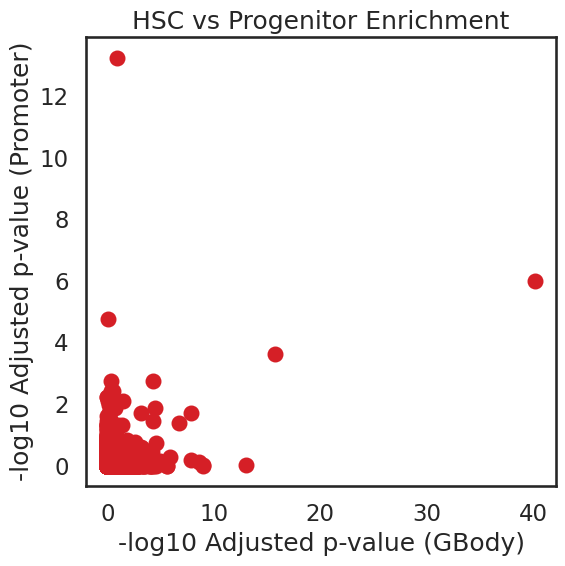

In [39]:
plot_df = CUTAC_wK4me123_HSC_Enrichments.copy()

# Volcano-style scatter plot
plt.figure(figsize=(6, 6))
color_map = {'Prom': '#D51F26', 'GBody': '#D51F26', 'Both': '#D51F26', 'None': '#D51F26'}

for group in ['None', 'Prom', 'Both', 'GBody']:
    sub = plot_df[plot_df['Gene_Type'] == group]
    plt.scatter(
        np.clip(-np.log10(sub['p_values_adjusted_GBody']), 0, 200),
        np.clip(-np.log10(sub['p_values_adjusted_Prom']), 0, 200),
        s=100, alpha=1, label=group, color=color_map.get(group, 'black')
    )

plt.xlabel('-log10 Adjusted p-value (GBody)')
plt.ylabel('-log10 Adjusted p-value (Promoter)')
plt.title('HSC vs Progenitor Enrichment')
#plt.legend(title='Gene_Type')
plt.tight_layout()
#plt.savefig('HSC_Prom_vs_GBody_pvalues_plot.png', dpi=300)
plt.show()


Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


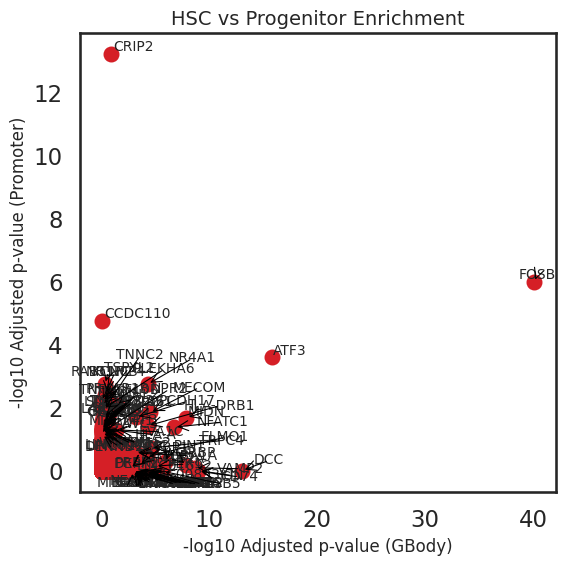

In [40]:
from adjustText import adjust_text

# Compute clipped -log10 p-values
plot_df['log10p_prom'] = np.clip(-np.log10(plot_df['p_values_adjusted_Prom']), 0, 200)
plot_df['log10p_gbody'] = np.clip(-np.log10(plot_df['p_values_adjusted_GBody']), 0, 200)

# Color map and plotting order
color_map = {'Prom': '#D51F26', 'GBody': '#D51F26', 'Both': '#D51F26', 'None': '#D51F26'}
plot_order = ['None', 'Prom', 'Both', 'GBody']

# Plotting
plt.figure(figsize=(6, 6))
for gene_type in plot_order:
    group = plot_df[plot_df['Gene_Type'] == gene_type]
    if not group.empty:
        plt.scatter(
            group['log10p_gbody'],
            group['log10p_prom'],
            label=gene_type,
            s=100,
            alpha=1,
            color=color_map.get(gene_type, 'black')
        )

# Add gene name labels for all non-'None' Gene_Type
texts = []
label_df = plot_df[plot_df['Gene_Type'].isin(['Prom', 'GBody', 'Both'])]

for _, row in label_df.iterrows():
    txt = plt.text(
        row['log10p_gbody'],
        row['log10p_prom'],
        row['gene'],
        fontsize=10,
        alpha=1
    )
    texts.append(txt)

# Adjust label positions to reduce overlaps
adjust_text(
    texts,
    arrowprops=dict(arrowstyle='->', color='black', lw=0.8),
    expand_points=(2.0, 2.0),
    expand_text=(2.0, 2.0)
)

# Axis labels and formatting
plt.xlabel('-log10 Adjusted p-value (GBody)', fontsize=12)
plt.ylabel('-log10 Adjusted p-value (Promoter)', fontsize=12)
plt.title('HSC vs Progenitor Enrichment', fontsize=14)
#plt.legend(title='Gene_Type', fontsize='small', markerscale=1)
plt.tight_layout()

# Save and show
#plt.savefig('HSC_Prom_vs_GBody_pvalues_plot_with_Labeled_Genes.png', dpi=300)
plt.show()


In [41]:
import pandas as pd
import numpy as np
from pybedtools import BedTool
from statsmodels.stats.multitest import fdrcorrection
from joblib import Parallel, delayed
from scipy import stats
import matplotlib.pyplot as plt
from adjustText import adjust_text

# Load cluster barcode table
K27me3_cluster_barcodes = pd.read_csv("K27me3_Cluster_Barcodes.csv")
K27me3_cluster_barcodes_dict = {
    k: set(K27me3_cluster_barcodes.loc[K27me3_cluster_barcodes["cluster_name"] == k, "barcode"])
    for k in ['HSC', 'LMPP', 'MPP', 'MEP']
}

# Load CUTAC files and combine
cutac_file_paths = {
    'Rep1': 'Full_hg38_Aligned_BED_Files/Batch_Beds_CUTAC_wSplit_Combined/CUTAC_Batch4_2in1_wK27me3_wSplit_Full.bed.gz',
    'Rep2': 'Full_hg38_Aligned_BED_Files/Batch_Beds_CUTAC_wSplit_Combined/CUTAC_Batch7_2in1_wK27me3_wSplit_Full.bed.gz',
    'Rep3': 'Full_hg38_Aligned_BED_Files/Batch_Beds_CUTAC_wSplit_Combined/CUTAC_Batch8_2in1_wK27me3_wSplit_Full.bed.gz',
    'Rep4': 'Full_hg38_Aligned_BED_Files/Batch_Beds_CUTAC_wSplit_Combined/CUTAC_Batch9_2in1_wK27me3_wSplit_Full.bed.gz'
}

CUTAC_wK27me3_Combined = pd.concat([
    pd.read_csv(p, sep='\t', header=None) for p in cutac_file_paths.values()
])
CUTAC_wK27me3_Combined.columns = ['chrom', 'start', 'stop', 'barcode']

# Separate HSC and progenitor barcodes
test_barcodes = K27me3_cluster_barcodes_dict['HSC']
control_barcodes = set().union(*[K27me3_cluster_barcodes_dict[k] for k in ['LMPP', 'MPP', 'MEP']])

CUTAC_wK27me3_HSC_BED = BedTool.from_dataframe(CUTAC_wK27me3_Combined[CUTAC_wK27me3_Combined['barcode'].isin(test_barcodes)].iloc[:, :3])
CUTAC_wK27me3_PROG_NO_HSC_BED = BedTool.from_dataframe(CUTAC_wK27me3_Combined[CUTAC_wK27me3_Combined['barcode'].isin(control_barcodes)].iloc[:, :3])


In [42]:
# Run the function using test and control beds
CUTAC_wK27me3_HSC_Enrichments = compute_gene_enrichments(
    test_bed=CUTAC_wK27me3_HSC_BED,
    control_bed=CUTAC_wK27me3_PROG_NO_HSC_BED,
    cname="CUTAC_wK27me3_HSC"
)

Found 3 peaks with significant enrichment for CUTAC_wK27me3_HSC - Promoters.
Found 14 peaks with significant enrichment for CUTAC_wK27me3_HSC - GBodies.
✓ Combined enrichment complete for CUTAC_wK27me3_HSC: 20769 shared genes


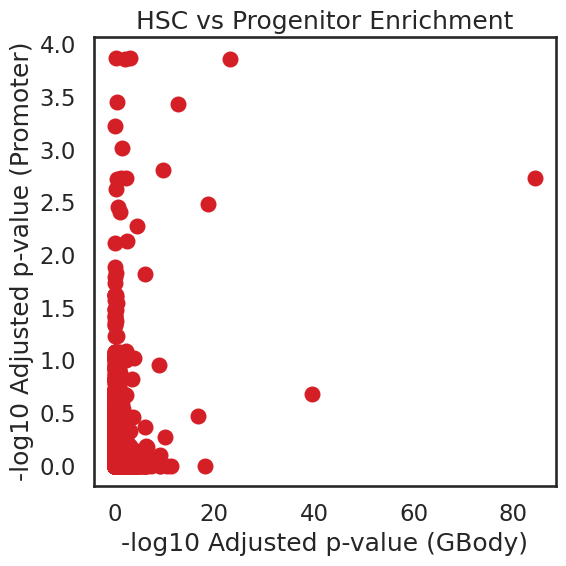

In [43]:
plot_df = CUTAC_wK27me3_HSC_Enrichments.copy()

# Volcano-style scatter plot
plt.figure(figsize=(6, 6))
color_map = {'Prom': '#D51F26', 'GBody': '#D51F26', 'Both': '#D51F26', 'None': '#D51F26'}

for group in ['None', 'Prom', 'Both', 'GBody']:
    sub = plot_df[plot_df['Gene_Type'] == group]
    plt.scatter(
        np.clip(-np.log10(sub['p_values_adjusted_GBody']), 0, 200),
        np.clip(-np.log10(sub['p_values_adjusted_Prom']), 0, 200),
        s=100, alpha=1, label=group, color=color_map.get(group, 'black')
    )

plt.xlabel('-log10 Adjusted p-value (GBody)')
plt.ylabel('-log10 Adjusted p-value (Promoter)')
plt.title('HSC vs Progenitor Enrichment')
#plt.legend(title='Gene_Type')
plt.tight_layout()
#plt.savefig('HSC_Prom_vs_GBody_pvalues_plot.png', dpi=300)
plt.show()


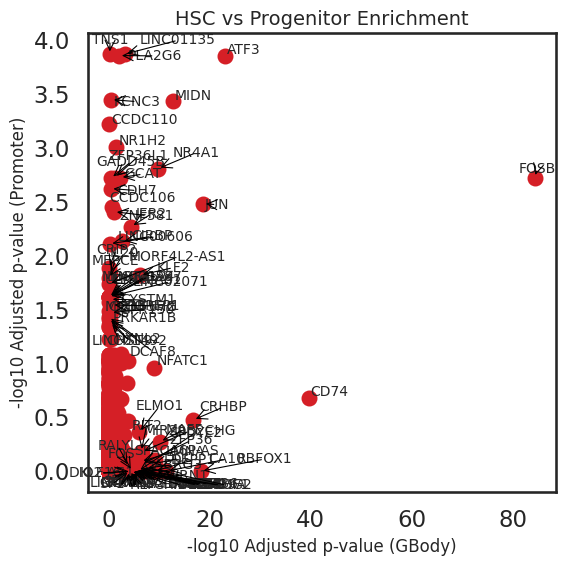

In [44]:
from adjustText import adjust_text

# Compute clipped -log10 p-values
plot_df['log10p_prom'] = np.clip(-np.log10(plot_df['p_values_adjusted_Prom']), 0, 200)
plot_df['log10p_gbody'] = np.clip(-np.log10(plot_df['p_values_adjusted_GBody']), 0, 200)

# Color map and plotting order
color_map = {'Prom': '#D51F26', 'GBody': '#D51F26', 'Both': '#D51F26', 'None': '#D51F26'}
plot_order = ['None', 'Prom', 'Both', 'GBody']

# Plotting
plt.figure(figsize=(6, 6))
for gene_type in plot_order:
    group = plot_df[plot_df['Gene_Type'] == gene_type]
    if not group.empty:
        plt.scatter(
            group['log10p_gbody'],
            group['log10p_prom'],
            label=gene_type,
            s=100,
            alpha=1,
            color=color_map.get(gene_type, 'black')
        )

# Add gene name labels for all non-'None' Gene_Type
texts = []
label_df = plot_df[plot_df['Gene_Type'].isin(['Prom', 'GBody', 'Both'])]

for _, row in label_df.iterrows():
    txt = plt.text(
        row['log10p_gbody'],
        row['log10p_prom'],
        row['gene'],
        fontsize=10,
        alpha=1
    )
    texts.append(txt)

# Adjust label positions to reduce overlaps
adjust_text(
    texts,
    arrowprops=dict(arrowstyle='->', color='black', lw=0.8),
    expand_points=(2.0, 2.0),
    expand_text=(2.0, 2.0)
)

# Axis labels and formatting
plt.xlabel('-log10 Adjusted p-value (GBody)', fontsize=12)
plt.ylabel('-log10 Adjusted p-value (Promoter)', fontsize=12)
plt.title('HSC vs Progenitor Enrichment', fontsize=14)
#plt.legend(title='Gene_Type', fontsize='small', markerscale=1)
plt.tight_layout()

# Save and show
#plt.savefig('HSC_Prom_vs_GBody_pvalues_plot_with_Labeled_Genes.png', dpi=300)
plt.show()


In [45]:
# Make CUTAC_wK4me123 MEP and Progenitor Control Bed files
test_barcodes = K4me123_cluster_barcodes_dict['MEP']
control_barcodes = set().union(*[K4me123_cluster_barcodes_dict[k] for k in ['LMPP', 'MPP', 'HSC', 'GMP', 'CLP']])

CUTAC_wK4me123_MEP_BED = BedTool.from_dataframe(CUTAC_wK4me123_Combined[CUTAC_wK4me123_Combined['barcode'].isin(test_barcodes)].iloc[:, :3])
CUTAC_wK4me123_PROG_NO_MEP_BED = BedTool.from_dataframe(CUTAC_wK4me123_Combined[CUTAC_wK4me123_Combined['barcode'].isin(control_barcodes)].iloc[:, :3])


In [46]:
# Run the function using test and control beds
CUTAC_wK4me123_MEP_Enrichments = compute_gene_enrichments(
    test_bed=CUTAC_wK4me123_MEP_BED,
    control_bed=CUTAC_wK4me123_PROG_NO_MEP_BED,
    cname="CUTAC_wK4me123_MEP"
)

Found 22 peaks with significant enrichment for CUTAC_wK4me123_MEP - Promoters.
Found 9 peaks with significant enrichment for CUTAC_wK4me123_MEP - GBodies.
✓ Combined enrichment complete for CUTAC_wK4me123_MEP: 20769 shared genes


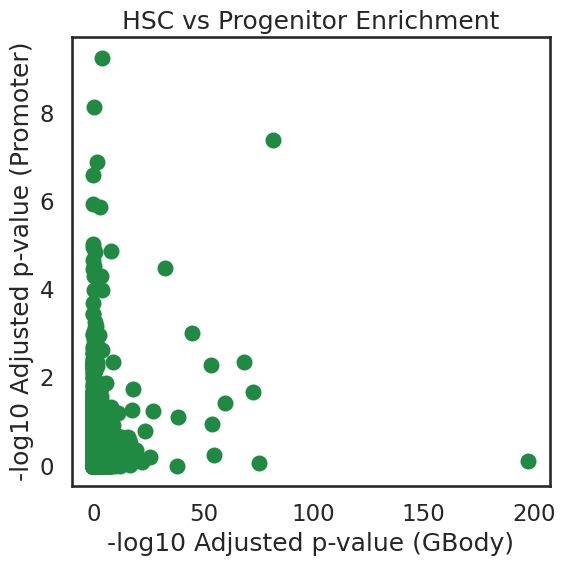

In [47]:
plot_df = CUTAC_wK4me123_MEP_Enrichments.copy()

# Volcano-style scatter plot
plt.figure(figsize=(6, 6))
color_map = {'Prom': '#208A42', 'GBody': '#208A42', 'Both': '#208A42', 'None': '#208A42'}

for group in ['None', 'Prom', 'Both', 'GBody']:
    sub = plot_df[plot_df['Gene_Type'] == group]
    plt.scatter(
        np.clip(-np.log10(sub['p_values_adjusted_GBody']), 0, 200),
        np.clip(-np.log10(sub['p_values_adjusted_Prom']), 0, 200),
        s=100, alpha=1, label=group, color=color_map.get(group, 'black')
    )

plt.xlabel('-log10 Adjusted p-value (GBody)')
plt.ylabel('-log10 Adjusted p-value (Promoter)')
plt.title('HSC vs Progenitor Enrichment')
#plt.legend(title='Gene_Type')
plt.tight_layout()
#plt.savefig('HSC_Prom_vs_GBody_pvalues_plot.png', dpi=300)
plt.show()


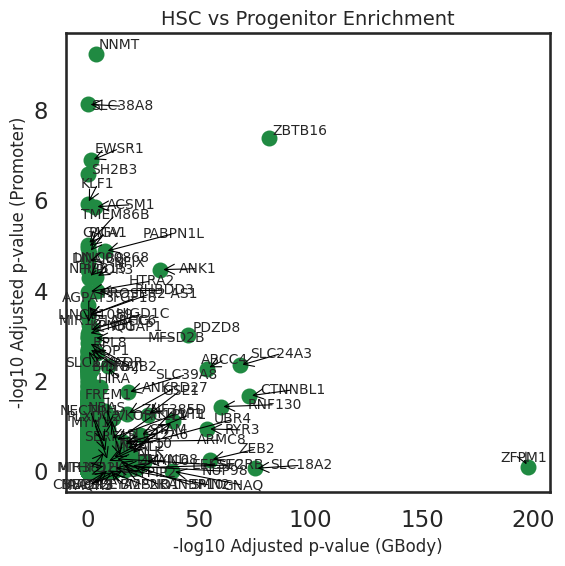

In [48]:
from adjustText import adjust_text

# Compute clipped -log10 p-values
plot_df['log10p_prom'] = np.clip(-np.log10(plot_df['p_values_adjusted_Prom']), 0, 200)
plot_df['log10p_gbody'] = np.clip(-np.log10(plot_df['p_values_adjusted_GBody']), 0, 200)

# Color map and plotting order
color_map = {'Prom': '#208A42', 'GBody': '#208A42', 'Both': '#208A42', 'None': '#208A42'}
plot_order = ['None', 'Prom', 'Both', 'GBody']

# Plotting
plt.figure(figsize=(6, 6))
for gene_type in plot_order:
    group = plot_df[plot_df['Gene_Type'] == gene_type]
    if not group.empty:
        plt.scatter(
            group['log10p_gbody'],
            group['log10p_prom'],
            label=gene_type,
            s=100,
            alpha=1,
            color=color_map.get(gene_type, 'black')
        )

# Add gene name labels for all non-'None' Gene_Type
texts = []
label_df = plot_df[plot_df['Gene_Type'].isin(['Prom', 'GBody', 'Both'])]

for _, row in label_df.iterrows():
    txt = plt.text(
        row['log10p_gbody'],
        row['log10p_prom'],
        row['gene'],
        fontsize=10,
        alpha=1
    )
    texts.append(txt)

# Adjust label positions to reduce overlaps
adjust_text(
    texts,
    arrowprops=dict(arrowstyle='->', color='black', lw=0.8),
    expand_points=(2.0, 2.0),
    expand_text=(2.0, 2.0)
)

# Axis labels and formatting
plt.xlabel('-log10 Adjusted p-value (GBody)', fontsize=12)
plt.ylabel('-log10 Adjusted p-value (Promoter)', fontsize=12)
plt.title('HSC vs Progenitor Enrichment', fontsize=14)
#plt.legend(title='Gene_Type', fontsize='small', markerscale=1)
plt.tight_layout()

# Save and show
#plt.savefig('HSC_Prom_vs_GBody_pvalues_plot_with_Labeled_Genes.png', dpi=300)
plt.show()


In [49]:
# Make CUTAC_wK27me3 MEP and Progenitor Control Bed files
test_barcodes = K27me3_cluster_barcodes_dict['MEP']
control_barcodes = set().union(*[K27me3_cluster_barcodes_dict[k] for k in ['LMPP', 'MPP', 'HSC']])

CUTAC_wK27me3_MEP_BED = BedTool.from_dataframe(CUTAC_wK27me3_Combined[CUTAC_wK27me3_Combined['barcode'].isin(test_barcodes)].iloc[:, :3])
CUTAC_wK27me3_PROG_NO_MEP_BED = BedTool.from_dataframe(CUTAC_wK27me3_Combined[CUTAC_wK27me3_Combined['barcode'].isin(control_barcodes)].iloc[:, :3])


In [50]:
# Run the function using test and control beds
CUTAC_wK27me3_MEP_Enrichments = compute_gene_enrichments(
    test_bed=CUTAC_wK27me3_MEP_BED,
    control_bed=CUTAC_wK27me3_PROG_NO_MEP_BED,
    cname="CUTAC_wK27me3_MEP"
)

Found 14 peaks with significant enrichment for CUTAC_wK27me3_MEP - Promoters.
Found 10 peaks with significant enrichment for CUTAC_wK27me3_MEP - GBodies.
✓ Combined enrichment complete for CUTAC_wK27me3_MEP: 20769 shared genes


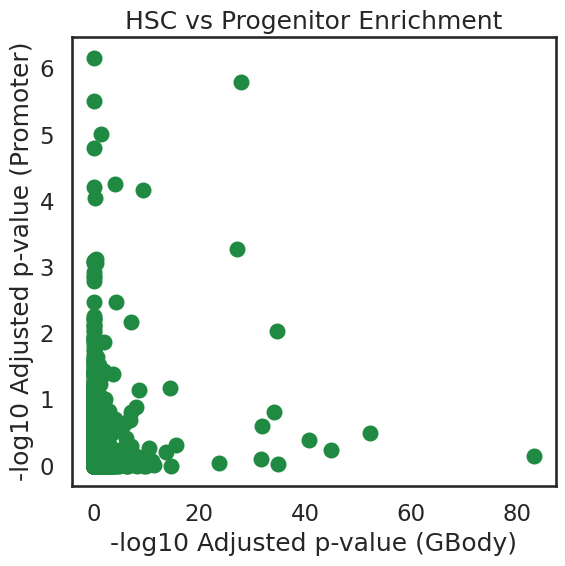

In [51]:
plot_df = CUTAC_wK27me3_MEP_Enrichments.copy()

# Volcano-style scatter plot
plt.figure(figsize=(6, 6))
color_map = {'Prom': '#208A42', 'GBody': '#208A42', 'Both': '#208A42', 'None': '#208A42'}

for group in ['None', 'Prom', 'Both', 'GBody']:
    sub = plot_df[plot_df['Gene_Type'] == group]
    plt.scatter(
        np.clip(-np.log10(sub['p_values_adjusted_GBody']), 0, 200),
        np.clip(-np.log10(sub['p_values_adjusted_Prom']), 0, 200),
        s=100, alpha=1, label=group, color=color_map.get(group, 'black')
    )

plt.xlabel('-log10 Adjusted p-value (GBody)')
plt.ylabel('-log10 Adjusted p-value (Promoter)')
plt.title('HSC vs Progenitor Enrichment')
#plt.legend(title='Gene_Type')
plt.tight_layout()
#plt.savefig('HSC_Prom_vs_GBody_pvalues_plot.png', dpi=300)
plt.show()


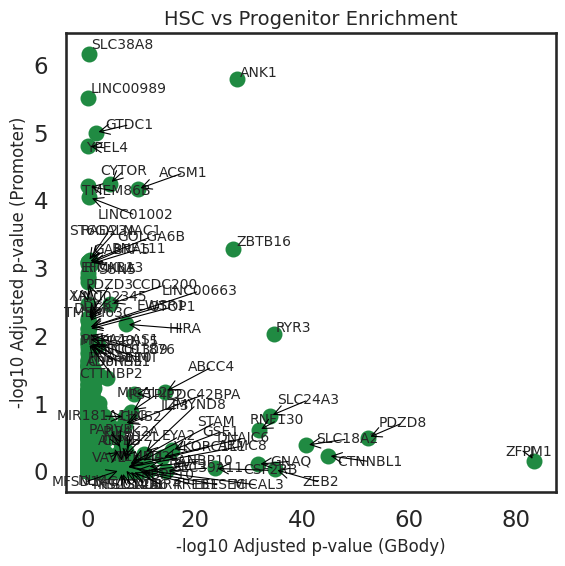

In [52]:
from adjustText import adjust_text

# Compute clipped -log10 p-values
plot_df['log10p_prom'] = np.clip(-np.log10(plot_df['p_values_adjusted_Prom']), 0, 200)
plot_df['log10p_gbody'] = np.clip(-np.log10(plot_df['p_values_adjusted_GBody']), 0, 200)

# Color map and plotting order
color_map = {'Prom': '#208A42', 'GBody': '#208A42', 'Both': '#208A42', 'None': '#208A42'}
plot_order = ['None', 'Prom', 'Both', 'GBody']

# Plotting
plt.figure(figsize=(6, 6))
for gene_type in plot_order:
    group = plot_df[plot_df['Gene_Type'] == gene_type]
    if not group.empty:
        plt.scatter(
            group['log10p_gbody'],
            group['log10p_prom'],
            label=gene_type,
            s=100,
            alpha=1,
            color=color_map.get(gene_type, 'black')
        )

# Add gene name labels for all non-'None' Gene_Type
texts = []
label_df = plot_df[plot_df['Gene_Type'].isin(['Prom', 'GBody', 'Both'])]

for _, row in label_df.iterrows():
    txt = plt.text(
        row['log10p_gbody'],
        row['log10p_prom'],
        row['gene'],
        fontsize=10,
        alpha=1
    )
    texts.append(txt)

# Adjust label positions to reduce overlaps
adjust_text(
    texts,
    arrowprops=dict(arrowstyle='->', color='black', lw=0.8),
    expand_points=(2.0, 2.0),
    expand_text=(2.0, 2.0)
)

# Axis labels and formatting
plt.xlabel('-log10 Adjusted p-value (GBody)', fontsize=12)
plt.ylabel('-log10 Adjusted p-value (Promoter)', fontsize=12)
plt.title('HSC vs Progenitor Enrichment', fontsize=14)
#plt.legend(title='Gene_Type', fontsize='small', markerscale=1)
plt.tight_layout()

# Save and show
#plt.savefig('HSC_Prom_vs_GBody_pvalues_plot_with_Labeled_Genes.png', dpi=300)
plt.show()


In [53]:
# Make CUTAC_wK4me123 MEP and Progenitor Control Bed files
test_barcodes = K4me123_cluster_barcodes_dict['GMP']
control_barcodes = set().union(*[K4me123_cluster_barcodes_dict[k] for k in ['LMPP', 'MPP', 'HSC', 'MEP', 'CLP']])

CUTAC_wK4me123_GMP_BED = BedTool.from_dataframe(CUTAC_wK4me123_Combined[CUTAC_wK4me123_Combined['barcode'].isin(test_barcodes)].iloc[:, :3])
CUTAC_wK4me123_PROG_NO_GMP_BED = BedTool.from_dataframe(CUTAC_wK4me123_Combined[CUTAC_wK4me123_Combined['barcode'].isin(control_barcodes)].iloc[:, :3])


In [54]:
# Run the function using test and control beds
CUTAC_wK4me123_GMP_Enrichments = compute_gene_enrichments(
    test_bed=CUTAC_wK4me123_GMP_BED,
    control_bed=CUTAC_wK4me123_PROG_NO_GMP_BED,
    cname="CUTAC_wK4me123_GMP"
)

Found 6 peaks with significant enrichment for CUTAC_wK4me123_GMP - Promoters.
Found 4 peaks with significant enrichment for CUTAC_wK4me123_GMP - GBodies.
✓ Combined enrichment complete for CUTAC_wK4me123_GMP: 20769 shared genes


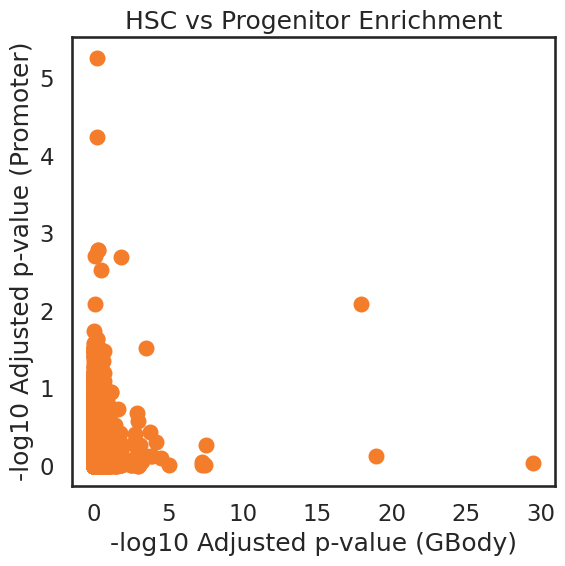

In [55]:
plot_df = CUTAC_wK4me123_GMP_Enrichments.copy()

# Volcano-style scatter plot
plt.figure(figsize=(6, 6))
color_map = {'Prom': '#F47D2B', 'GBody': '#F47D2B', 'Both': '#F47D2B', 'None': '#F47D2B'}

for group in ['None', 'Prom', 'Both', 'GBody']:
    sub = plot_df[plot_df['Gene_Type'] == group]
    plt.scatter(
        np.clip(-np.log10(sub['p_values_adjusted_GBody']), 0, 200),
        np.clip(-np.log10(sub['p_values_adjusted_Prom']), 0, 200),
        s=100, alpha=1, label=group, color=color_map.get(group, 'black')
    )

plt.xlabel('-log10 Adjusted p-value (GBody)')
plt.ylabel('-log10 Adjusted p-value (Promoter)')
plt.title('HSC vs Progenitor Enrichment')
#plt.legend(title='Gene_Type')
plt.tight_layout()
#plt.savefig('HSC_Prom_vs_GBody_pvalues_plot.png', dpi=300)
plt.show()


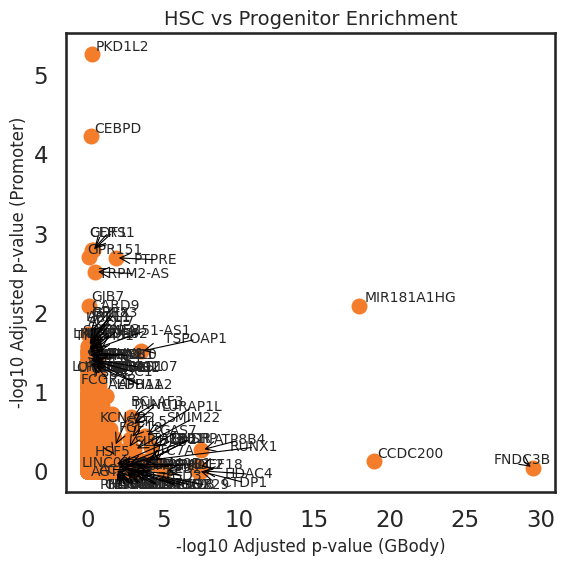

In [56]:
from adjustText import adjust_text

# Compute clipped -log10 p-values
plot_df['log10p_prom'] = np.clip(-np.log10(plot_df['p_values_adjusted_Prom']), 0, 200)
plot_df['log10p_gbody'] = np.clip(-np.log10(plot_df['p_values_adjusted_GBody']), 0, 200)

# Color map and plotting order
color_map = {'Prom': '#F47D2B', 'GBody': '#F47D2B', 'Both': '#F47D2B', 'None': '#F47D2B'}
plot_order = ['None', 'Prom', 'Both', 'GBody']

# Plotting
plt.figure(figsize=(6, 6))
for gene_type in plot_order:
    group = plot_df[plot_df['Gene_Type'] == gene_type]
    if not group.empty:
        plt.scatter(
            group['log10p_gbody'],
            group['log10p_prom'],
            label=gene_type,
            s=100,
            alpha=1,
            color=color_map.get(gene_type, 'black')
        )

# Add gene name labels for all non-'None' Gene_Type
texts = []
label_df = plot_df[plot_df['Gene_Type'].isin(['Prom', 'GBody', 'Both'])]

for _, row in label_df.iterrows():
    txt = plt.text(
        row['log10p_gbody'],
        row['log10p_prom'],
        row['gene'],
        fontsize=10,
        alpha=1
    )
    texts.append(txt)

# Adjust label positions to reduce overlaps
adjust_text(
    texts,
    arrowprops=dict(arrowstyle='->', color='black', lw=0.8),
    expand_points=(2.0, 2.0),
    expand_text=(2.0, 2.0)
)

# Axis labels and formatting
plt.xlabel('-log10 Adjusted p-value (GBody)', fontsize=12)
plt.ylabel('-log10 Adjusted p-value (Promoter)', fontsize=12)
plt.title('HSC vs Progenitor Enrichment', fontsize=14)
#plt.legend(title='Gene_Type', fontsize='small', markerscale=1)
plt.tight_layout()

# Save and show
#plt.savefig('HSC_Prom_vs_GBody_pvalues_plot_with_Labeled_Genes.png', dpi=300)
plt.show()


In [57]:
# Make CUTAC_wK4me123 MEP and Progenitor Control Bed files
test_barcodes = K4me123_cluster_barcodes_dict['CLP']
control_barcodes = set().union(*[K4me123_cluster_barcodes_dict[k] for k in ['LMPP', 'MPP', 'HSC', 'GMP', 'MEP']])

CUTAC_wK4me123_CLP_BED = BedTool.from_dataframe(CUTAC_wK4me123_Combined[CUTAC_wK4me123_Combined['barcode'].isin(test_barcodes)].iloc[:, :3])
CUTAC_wK4me123_PROG_NO_CLP_BED = BedTool.from_dataframe(CUTAC_wK4me123_Combined[CUTAC_wK4me123_Combined['barcode'].isin(control_barcodes)].iloc[:, :3])


In [58]:
# Run the function using test and control beds
CUTAC_wK4me123_CLP_Enrichments = compute_gene_enrichments(
    test_bed=CUTAC_wK4me123_CLP_BED,
    control_bed=CUTAC_wK4me123_PROG_NO_CLP_BED,
    cname="CUTAC_wK4me123_CLP"
)

Found 4 peaks with significant enrichment for CUTAC_wK4me123_CLP - Promoters.
Found 13 peaks with significant enrichment for CUTAC_wK4me123_CLP - GBodies.
✓ Combined enrichment complete for CUTAC_wK4me123_CLP: 20769 shared genes


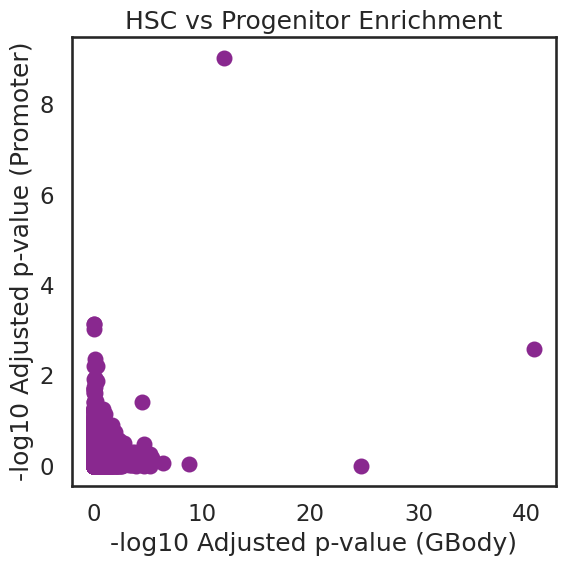

In [59]:
plot_df = CUTAC_wK4me123_CLP_Enrichments.copy()

# Volcano-style scatter plot
plt.figure(figsize=(6, 6))
color_map = {'Prom': '#89288F', 'GBody': '#89288F', 'Both': '#89288F', 'None': '#89288F'}

for group in ['None', 'Prom', 'Both', 'GBody']:
    sub = plot_df[plot_df['Gene_Type'] == group]
    plt.scatter(
        np.clip(-np.log10(sub['p_values_adjusted_GBody']), 0, 200),
        np.clip(-np.log10(sub['p_values_adjusted_Prom']), 0, 200),
        s=100, alpha=1, label=group, color=color_map.get(group, 'black')
    )

plt.xlabel('-log10 Adjusted p-value (GBody)')
plt.ylabel('-log10 Adjusted p-value (Promoter)')
plt.title('HSC vs Progenitor Enrichment')
#plt.legend(title='Gene_Type')
plt.tight_layout()
#plt.savefig('HSC_Prom_vs_GBody_pvalues_plot.png', dpi=300)
plt.show()


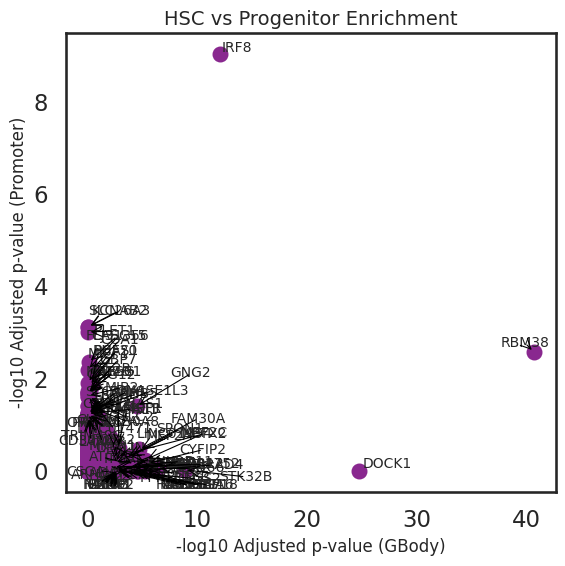

In [60]:
from adjustText import adjust_text

# Compute clipped -log10 p-values
plot_df['log10p_prom'] = np.clip(-np.log10(plot_df['p_values_adjusted_Prom']), 0, 200)
plot_df['log10p_gbody'] = np.clip(-np.log10(plot_df['p_values_adjusted_GBody']), 0, 200)

# Color map and plotting order
color_map = {'Prom': '#89288F', 'GBody': '#89288F', 'Both': '#89288F', 'None': '#89288F'}
plot_order = ['None', 'Prom', 'Both', 'GBody']

# Plotting
plt.figure(figsize=(6, 6))
for gene_type in plot_order:
    group = plot_df[plot_df['Gene_Type'] == gene_type]
    if not group.empty:
        plt.scatter(
            group['log10p_gbody'],
            group['log10p_prom'],
            label=gene_type,
            s=100,
            alpha=1,
            color=color_map.get(gene_type, 'black')
        )

# Add gene name labels for all non-'None' Gene_Type
texts = []
label_df = plot_df[plot_df['Gene_Type'].isin(['Prom', 'GBody', 'Both'])]

for _, row in label_df.iterrows():
    txt = plt.text(
        row['log10p_gbody'],
        row['log10p_prom'],
        row['gene'],
        fontsize=10,
        alpha=1
    )
    texts.append(txt)

# Adjust label positions to reduce overlaps
adjust_text(
    texts,
    arrowprops=dict(arrowstyle='->', color='black', lw=0.8),
    expand_points=(2.0, 2.0),
    expand_text=(2.0, 2.0)
)

# Axis labels and formatting
plt.xlabel('-log10 Adjusted p-value (GBody)', fontsize=12)
plt.ylabel('-log10 Adjusted p-value (Promoter)', fontsize=12)
plt.title('HSC vs Progenitor Enrichment', fontsize=14)
#plt.legend(title='Gene_Type', fontsize='small', markerscale=1)
plt.tight_layout()

# Save and show
#plt.savefig('HSC_Prom_vs_GBody_pvalues_plot_with_Labeled_Genes.png', dpi=300)
plt.show()


# This section defines the PnR and InR genes and quantifies H3K27me3 over these groups. 

In [61]:
CUTAC_wK4me123_MEP_Enrichments.head(5)

chrom_Prom  start_Prom  stop_Prom  Cterm_counts_Prom  Nterm_counts_Prom  \
0       chr1       64419      66419                  2                  3   
1       chr1      816371     818371                 46                  8   
2       chr1      822138     828138                312                 38   
3       chr1      826522     828522                264                 34   
4       chr1      869201     871201                100                 12   

   log2_ratio_mean_Prom  log2_ratio_std_Prom  log2_ratio_zscore_Prom  \
0              3.412737             1.179760                2.892738   
1              0.407065             0.546308                0.745120   
2             -0.142179             0.249931               -0.568874   
3             -0.056891             0.268230               -0.212096   
4             -0.133686             0.432171               -0.309335   

   log2_ratio_pvalue_Prom  null_rejected_Prom  ...  log2_ratio_std_GBody  \
0                0.001910               False  ...              1.005688   
1                0.228100               False  ...              0.743733   
2                0.715279               False  ...              0.279890   
3                0.583984               False  ...              1.449812   
4                0.621467               False  ...              1.474854   

   log2_ratio_zscore_GBody  log2_ratio_pvalue_GBody  null_rejected_GBody  \
0                 0.888537                 0.187126                False   
1                 0.785842                 0.215980                False   
2                -0.245820                 0.597089                False   
3                 1.313236                 0.094552                False   
4                 1.266965                 0.102584                False   

  p_values_adjusted_GBody p_values_adjusted_after_filter_GBody  \
0                0.644479                                  NaN   
1                0.686677                                  NaN   
2                0.990861                                  NaN   
3                0.482188                                  NaN   
4                0.503248                                  NaN   

  null_rejected_after_filter_GBody  enriched_GBody  GBody_50  Gene_Type  
0                            False           False        No       None  
1                            False           False        No       None  
2                            False           False        No       None  
3                            False           False        No       None  
4                            False           False        No       None  

[5 rows x 32 columns]

There are 20,769 peaks.
✅ Number of currently enriched promoter peaks: 8


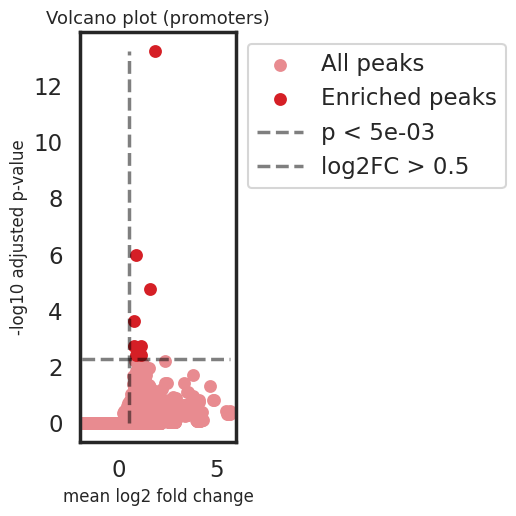

Cutoff: p < 5.00e-03 → -log10(p) = 2.30


In [62]:
import numpy as np
import matplotlib.pyplot as plt

# Copy and prepare data
df = CUTAC_wK4me123_HSC_Enrichments.copy()
log_fold_change_cutoff = 0.5
pval_cutoff = 0.005

# Compute -log10 adjusted p-values
df['-log10_pval'] = -np.log10(df['p_values_adjusted_Prom'].clip(lower=1e-300))

# Define enrichment status
df['current_enriched'] = (df['log2_ratio_mean_Prom'] > log_fold_change_cutoff) & (df['p_values_adjusted_Prom'] < pval_cutoff)

# Report summary
print(f'There are {df.shape[0]:,} peaks.')
print(f"✅ Number of currently enriched promoter peaks: {df['current_enriched'].sum()}")

# Set up plot
plt.figure(figsize=(5.5, 5.5))  # Bigger plot

# Colors
highlight_color = '#D51F26'   # Enriched peaks
background_color = '#E88B90'  # Slightly darker light green for other peaks



# Point size
point_size = 60

# Plot non-enriched points
plt.scatter(
    df.loc[~df['current_enriched'], 'log2_ratio_mean_Prom'],
    df.loc[~df['current_enriched'], '-log10_pval'],
    label='All peaks',
    s=point_size,
    color=background_color
)

# Plot enriched points
plt.scatter(
    df.loc[df['current_enriched'], 'log2_ratio_mean_Prom'],
    df.loc[df['current_enriched'], '-log10_pval'],
    label='Enriched peaks',
    s=point_size,
    color=highlight_color
)

# Draw cutoff lines
lb, ub = df['log2_ratio_mean_Prom'].min(), df['log2_ratio_mean_Prom'].max()
plt.hlines(
    -np.log10(pval_cutoff),
    lb,
    ub,
    color='black',
    alpha=0.5,
    linestyles='dashed',
    linewidth=2.5,    # Thicker
    label=f'p < {pval_cutoff:.0e}'
)

plt.vlines(
    log_fold_change_cutoff,
    0,
    df['-log10_pval'].max(),
    color='black',
    alpha=0.5,
    linewidth=2.5,    # Thicker
    linestyles='dashed',
    label=f'log2FC > {log_fold_change_cutoff}'
)

# Formatting
plt.xlim(-2, 6)
plt.xlabel('mean log2 fold change', fontsize=12)
plt.ylabel('-log10 adjusted p-value', fontsize=12)
plt.title('Volcano plot (promoters)', fontsize=13)

# Thicker black outline (axes)
for spine in plt.gca().spines.values():
    spine.set_linewidth(2.5)

plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()

plt.savefig('HSC_K4me123_Prom_FC_pvalues_scatterplot.png', dpi=300)

plt.show()

# Print effective cutoff
print(f'Cutoff: p < {pval_cutoff:.2e} → -log10(p) = {-np.log10(pval_cutoff):.2f}')


There are 20,769 peaks.
✅ Number of currently enriched promoter peaks: 8


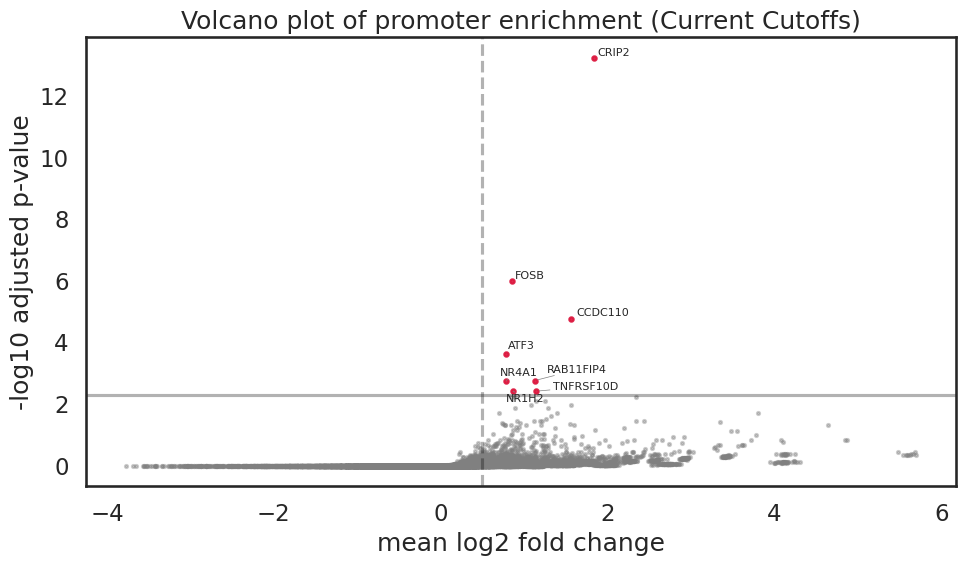

Current p-value threshold drawn at: 5.00e-03 (-log10 = 2.30)


In [63]:
import numpy as np
import matplotlib.pyplot as plt
from adjustText import adjust_text

# Copy base dataframe
df = CUTAC_wK4me123_HSC_Enrichments.copy()
log_fold_change_cutoff = 0.5
pval_cutoff = 0.005

# Compute -log10 adjusted p-values
df['-log10_pval'] = -np.log10(df['p_values_adjusted_Prom'].clip(lower=1e-300))  # avoid log(0)

# Define enrichment status based on current thresholds
df['current_enriched'] = (df['log2_ratio_mean_Prom'] > log_fold_change_cutoff) & (df['p_values_adjusted_Prom'] < pval_cutoff)

# Report
print(f'There are {df.shape[0]:,} peaks.')
print(f"✅ Number of currently enriched promoter peaks: {df['current_enriched'].sum()}")

# Volcano plot
plt.figure(figsize=(10, 6))

# Plot all
plt.scatter(df.loc[~df['current_enriched'], 'log2_ratio_mean_Prom'],
            df.loc[~df['current_enriched'], '-log10_pval'],
            label='All peaks', s=5, alpha=0.4, color='gray')

# Plot enriched
plt.scatter(df.loc[df['current_enriched'], 'log2_ratio_mean_Prom'],
            df.loc[df['current_enriched'], '-log10_pval'],
            label='Enriched peaks', s=10, alpha=0.9, color='crimson')

# Draw cutoffs
plt.axhline(-np.log10(pval_cutoff), color='black', alpha=.3, label=f'p < {pval_cutoff:.0e}')
plt.axvline(log_fold_change_cutoff, color='black', alpha=.3, linestyle='dashed', label=f'log2FC > {log_fold_change_cutoff}')

# Label enriched genes
texts = []
for _, row in df[df['current_enriched']].iterrows():
    texts.append(plt.text(row['log2_ratio_mean_Prom'], row['-log10_pval'], row['gene'], fontsize=8))

adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))

# Final formatting
plt.xlabel('mean log2 fold change')
plt.ylabel('-log10 adjusted p-value')
plt.title('Volcano plot of promoter enrichment (Current Cutoffs)')
#plt.legend()
plt.tight_layout()
plt.show()

# Report effective cutoff
print(f'Current p-value threshold drawn at: {pval_cutoff:.2e} (-log10 = {-np.log10(pval_cutoff):.2f})')


There are 20,769 peaks.
✅ Number of currently enriched GBody peaks: 9


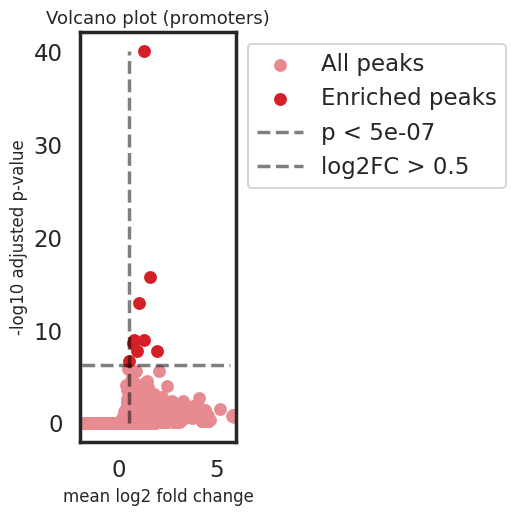

Cutoff: p < 5.00e-07 → -log10(p) = 6.30


In [64]:
import numpy as np
import matplotlib.pyplot as plt

# Copy and prepare data
df = CUTAC_wK4me123_HSC_Enrichments.copy()
log_fold_change_cutoff = 0.5
pval_cutoff = 0.0000005  # Stricter p-value threshold for GBody

# Compute -log10 adjusted p-values
df['-log10_pval'] = -np.log10(df['p_values_adjusted_GBody'].clip(lower=1e-300))

# Define enrichment status
df['current_enriched'] = (
    (df['log2_ratio_mean_GBody'] > log_fold_change_cutoff) &
    (df['p_values_adjusted_GBody'] < pval_cutoff)
)

# Report summary
print(f'There are {df.shape[0]:,} peaks.')
print(f"✅ Number of currently enriched GBody peaks: {df['current_enriched'].sum()}")

# Set up plot
plt.figure(figsize=(5.5, 5.5))  # Same size as promoter plot

# Colors
highlight_color = '#D51F26'   # Enriched peaks
background_color = '#E88B90'  # Slightly darker light green for other peaks

# Point size
point_size = 60

# Plot non-enriched points
plt.scatter(
    df.loc[~df['current_enriched'], 'log2_ratio_mean_GBody'],
    df.loc[~df['current_enriched'], '-log10_pval'],
    label='All peaks',
    s=point_size,
    color=background_color
)

# Plot enriched points
plt.scatter(
    df.loc[df['current_enriched'], 'log2_ratio_mean_GBody'],
    df.loc[df['current_enriched'], '-log10_pval'],
    label='Enriched peaks',
    s=point_size,
    color=highlight_color
)

# Draw cutoff lines
lb, ub = df['log2_ratio_mean_Prom'].min(), df['log2_ratio_mean_Prom'].max()
plt.hlines(
    -np.log10(pval_cutoff),
    lb,
    ub,
    color='black',
    alpha=0.5,
    linestyles='dashed',
    linewidth=2.5,    # Thicker
    label=f'p < {pval_cutoff:.0e}'
)

plt.vlines(
    log_fold_change_cutoff,
    0,
    df['-log10_pval'].max(),
    color='black',
    alpha=0.5,
    linewidth=2.5,    # Thicker
    linestyles='dashed',
    label=f'log2FC > {log_fold_change_cutoff}'
)

# Formatting
plt.xlim(-2, 6)
plt.xlabel('mean log2 fold change', fontsize=12)
plt.ylabel('-log10 adjusted p-value', fontsize=12)
plt.title('Volcano plot (promoters)', fontsize=13)

# Thicker black outline (axes)
for spine in plt.gca().spines.values():
    spine.set_linewidth(2.5)
    
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()

plt.savefig('HSC_K4me123_GBodies_FC_pvalues_scatterplot.png', dpi=300)

plt.show()

# Report effective cutoff
print(f'Cutoff: p < {pval_cutoff:.2e} → -log10(p) = {-np.log10(pval_cutoff):.2f}')


There are 20,769 peaks.
✅ Number of currently enriched promoter peaks: 9


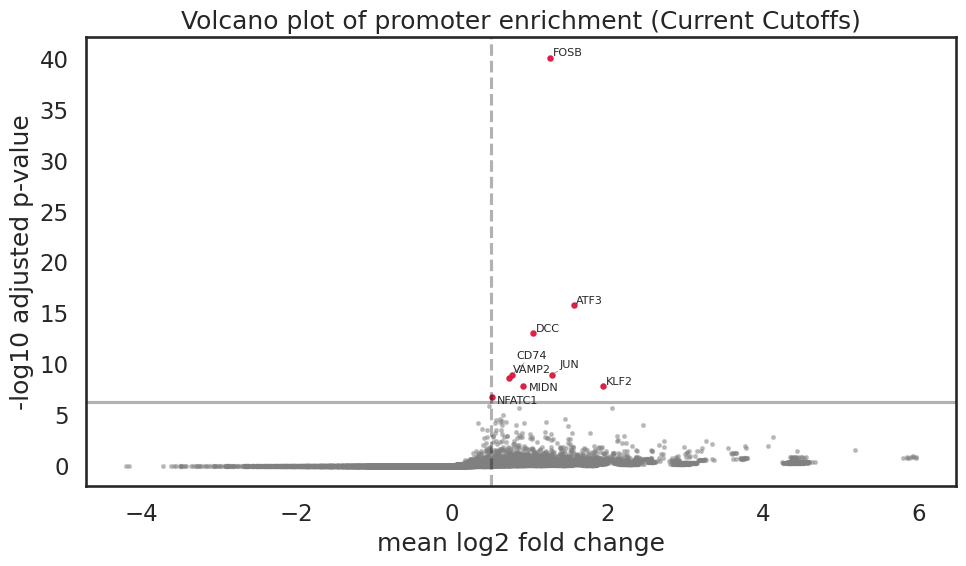

Current p-value threshold drawn at: 5.00e-07 (-log10 = 6.30)


In [65]:
import numpy as np
import matplotlib.pyplot as plt
from adjustText import adjust_text

# Copy base dataframe
df = CUTAC_wK4me123_HSC_Enrichments.copy()
log_fold_change_cutoff = 0.5
pval_cutoff = 0.0000005

# Compute -log10 adjusted p-values
df['-log10_pval'] = -np.log10(df['p_values_adjusted_GBody'].clip(lower=1e-300))  # avoid log(0)

# Define enrichment status based on current thresholds
df['current_enriched'] = (df['log2_ratio_mean_GBody'] > log_fold_change_cutoff) & (df['p_values_adjusted_GBody'] < pval_cutoff)

# Report
print(f'There are {df.shape[0]:,} peaks.')
print(f"✅ Number of currently enriched promoter peaks: {df['current_enriched'].sum()}")

# Volcano plot
plt.figure(figsize=(10, 6))

# Plot all
plt.scatter(df.loc[~df['current_enriched'], 'log2_ratio_mean_GBody'],
            df.loc[~df['current_enriched'], '-log10_pval'],
            label='All peaks', s=5, alpha=0.4, color='gray')

# Plot enriched
plt.scatter(df.loc[df['current_enriched'], 'log2_ratio_mean_GBody'],
            df.loc[df['current_enriched'], '-log10_pval'],
            label='Enriched peaks', s=10, alpha=0.9, color='crimson')

# Draw cutoffs
plt.axhline(-np.log10(pval_cutoff), color='black', alpha=.3, label=f'p < {pval_cutoff:.0e}')
plt.axvline(log_fold_change_cutoff, color='black', alpha=.3, linestyle='dashed', label=f'log2FC > {log_fold_change_cutoff}')

# Label enriched genes
texts = []
for _, row in df[df['current_enriched']].iterrows():
    texts.append(plt.text(row['log2_ratio_mean_GBody'], row['-log10_pval'], row['gene'], fontsize=8))

adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))

# Final formatting
plt.xlabel('mean log2 fold change')
plt.ylabel('-log10 adjusted p-value')
plt.title('Volcano plot of promoter enrichment (Current Cutoffs)')
#plt.legend()
plt.tight_layout()
plt.show()

# Report effective cutoff
print(f'Current p-value threshold drawn at: {pval_cutoff:.2e} (-log10 = {-np.log10(pval_cutoff):.2f})')


There are 20,769 peaks.
✅ Number of currently enriched promoter peaks: 15


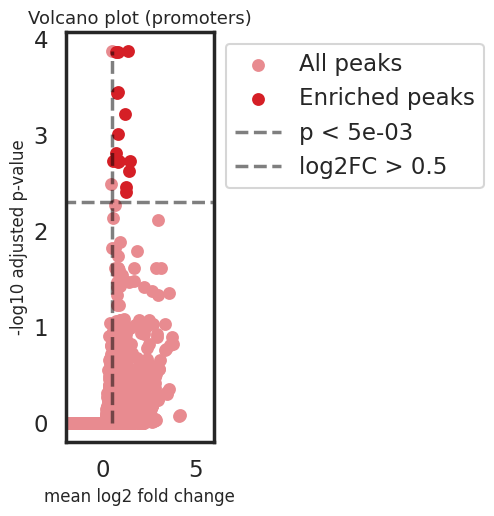

Cutoff: p < 5.00e-03 → -log10(p) = 2.30


In [66]:
import numpy as np
import matplotlib.pyplot as plt

# Copy and prepare data
df = CUTAC_wK27me3_HSC_Enrichments.copy()
log_fold_change_cutoff = 0.5
pval_cutoff = 0.005

# Compute -log10 adjusted p-values
df['-log10_pval'] = -np.log10(df['p_values_adjusted_Prom'].clip(lower=1e-300))

# Define enrichment status
df['current_enriched'] = (df['log2_ratio_mean_Prom'] > log_fold_change_cutoff) & (df['p_values_adjusted_Prom'] < pval_cutoff)

# Report summary
print(f'There are {df.shape[0]:,} peaks.')
print(f"✅ Number of currently enriched promoter peaks: {df['current_enriched'].sum()}")

# Set up plot
plt.figure(figsize=(5.5, 5.5))  # Bigger plot

# Colors
highlight_color = '#D51F26'   # Enriched peaks
background_color = '#E88B90'  # Slightly darker light green for other peaks



# Point size
point_size = 60

# Plot non-enriched points
plt.scatter(
    df.loc[~df['current_enriched'], 'log2_ratio_mean_Prom'],
    df.loc[~df['current_enriched'], '-log10_pval'],
    label='All peaks',
    s=point_size,
    color=background_color
)

# Plot enriched points
plt.scatter(
    df.loc[df['current_enriched'], 'log2_ratio_mean_Prom'],
    df.loc[df['current_enriched'], '-log10_pval'],
    label='Enriched peaks',
    s=point_size,
    color=highlight_color
)

# Draw cutoff lines
lb, ub = df['log2_ratio_mean_Prom'].min(), df['log2_ratio_mean_Prom'].max()
plt.hlines(
    -np.log10(pval_cutoff),
    lb,
    ub,
    color='black',
    alpha=0.5,
    linestyles='dashed',
    linewidth=2.5,    # Thicker
    label=f'p < {pval_cutoff:.0e}'
)

plt.vlines(
    log_fold_change_cutoff,
    0,
    df['-log10_pval'].max(),
    color='black',
    alpha=0.5,
    linewidth=2.5,    # Thicker
    linestyles='dashed',
    label=f'log2FC > {log_fold_change_cutoff}'
)

# Formatting
plt.xlim(-2, 6)
plt.xlabel('mean log2 fold change', fontsize=12)
plt.ylabel('-log10 adjusted p-value', fontsize=12)
plt.title('Volcano plot (promoters)', fontsize=13)

# Thicker black outline (axes)
for spine in plt.gca().spines.values():
    spine.set_linewidth(2.5)

plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()

plt.savefig('HSC_K27me3_Prom_FC_pvalues_scatterplot.png', dpi=300)

plt.show()

# Print effective cutoff
print(f'Cutoff: p < {pval_cutoff:.2e} → -log10(p) = {-np.log10(pval_cutoff):.2f}')


There are 20,769 peaks.
✅ Number of currently enriched promoter peaks: 15


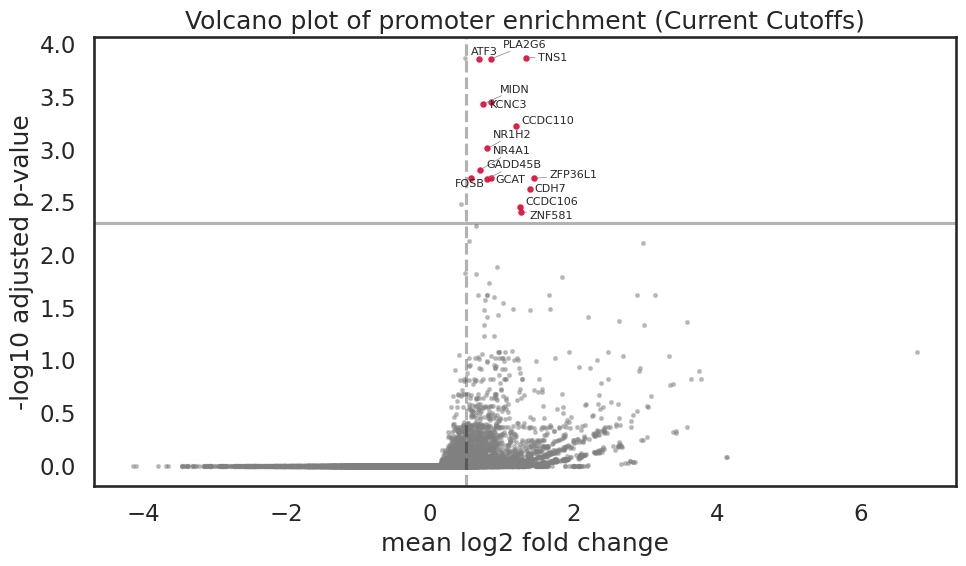

Current p-value threshold drawn at: 5.00e-03 (-log10 = 2.30)


In [67]:
import numpy as np
import matplotlib.pyplot as plt
from adjustText import adjust_text

# Copy base dataframe
df = CUTAC_wK27me3_HSC_Enrichments.copy()
log_fold_change_cutoff = 0.5
pval_cutoff = 0.005

# Compute -log10 adjusted p-values
df['-log10_pval'] = -np.log10(df['p_values_adjusted_Prom'].clip(lower=1e-300))  # avoid log(0)

# Define enrichment status based on current thresholds
df['current_enriched'] = (df['log2_ratio_mean_Prom'] > log_fold_change_cutoff) & (df['p_values_adjusted_Prom'] < pval_cutoff)

# Report
print(f'There are {df.shape[0]:,} peaks.')
print(f"✅ Number of currently enriched promoter peaks: {df['current_enriched'].sum()}")

# Volcano plot
plt.figure(figsize=(10, 6))

# Plot all
plt.scatter(df.loc[~df['current_enriched'], 'log2_ratio_mean_Prom'],
            df.loc[~df['current_enriched'], '-log10_pval'],
            label='All peaks', s=5, alpha=0.4, color='gray')

# Plot enriched
plt.scatter(df.loc[df['current_enriched'], 'log2_ratio_mean_Prom'],
            df.loc[df['current_enriched'], '-log10_pval'],
            label='Enriched peaks', s=10, alpha=0.9, color='crimson')

# Draw cutoffs
plt.axhline(-np.log10(pval_cutoff), color='black', alpha=.3, label=f'p < {pval_cutoff:.0e}')
plt.axvline(log_fold_change_cutoff, color='black', alpha=.3, linestyle='dashed', label=f'log2FC > {log_fold_change_cutoff}')

# Label enriched genes
texts = []
for _, row in df[df['current_enriched']].iterrows():
    texts.append(plt.text(row['log2_ratio_mean_Prom'], row['-log10_pval'], row['gene'], fontsize=8))

adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))

# Final formatting
plt.xlabel('mean log2 fold change')
plt.ylabel('-log10 adjusted p-value')
plt.title('Volcano plot of promoter enrichment (Current Cutoffs)')
#plt.legend()
plt.tight_layout()
plt.show()

# Report effective cutoff
print(f'Current p-value threshold drawn at: {pval_cutoff:.2e} (-log10 = {-np.log10(pval_cutoff):.2f})')


There are 20,769 peaks.
✅ Number of currently enriched GBody peaks: 24


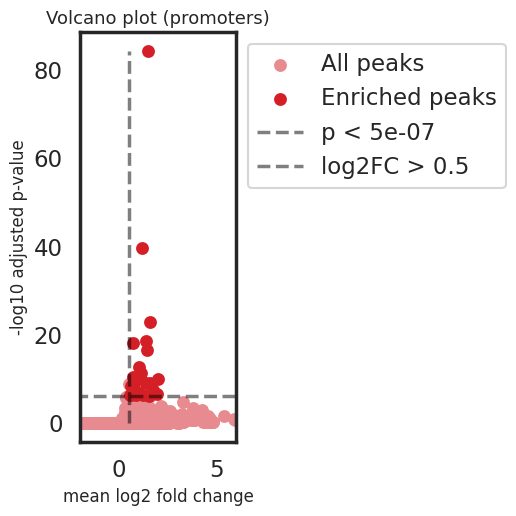

Cutoff: p < 5.00e-07 → -log10(p) = 6.30


In [68]:
import numpy as np
import matplotlib.pyplot as plt

# Copy and prepare data
df = CUTAC_wK27me3_HSC_Enrichments.copy()
log_fold_change_cutoff = 0.5
pval_cutoff = 0.0000005  # Stricter p-value threshold for GBody

# Compute -log10 adjusted p-values
df['-log10_pval'] = -np.log10(df['p_values_adjusted_GBody'].clip(lower=1e-300))

# Define enrichment status
df['current_enriched'] = (
    (df['log2_ratio_mean_GBody'] > log_fold_change_cutoff) &
    (df['p_values_adjusted_GBody'] < pval_cutoff)
)

# Report summary
print(f'There are {df.shape[0]:,} peaks.')
print(f"✅ Number of currently enriched GBody peaks: {df['current_enriched'].sum()}")

# Set up plot
plt.figure(figsize=(5.5, 5.5))  # Same size as promoter plot

# Colors
highlight_color = '#D51F26'   # Enriched peaks
background_color = '#E88B90'  # Slightly darker light green for other peaks

# Point size
point_size = 60

# Plot non-enriched points
plt.scatter(
    df.loc[~df['current_enriched'], 'log2_ratio_mean_GBody'],
    df.loc[~df['current_enriched'], '-log10_pval'],
    label='All peaks',
    s=point_size,
    color=background_color
)

# Plot enriched points
plt.scatter(
    df.loc[df['current_enriched'], 'log2_ratio_mean_GBody'],
    df.loc[df['current_enriched'], '-log10_pval'],
    label='Enriched peaks',
    s=point_size,
    color=highlight_color
)

# Draw cutoff lines
lb, ub = df['log2_ratio_mean_Prom'].min(), df['log2_ratio_mean_Prom'].max()
plt.hlines(
    -np.log10(pval_cutoff),
    lb,
    ub,
    color='black',
    alpha=0.5,
    linestyles='dashed',
    linewidth=2.5,    # Thicker
    label=f'p < {pval_cutoff:.0e}'
)

plt.vlines(
    log_fold_change_cutoff,
    0,
    df['-log10_pval'].max(),
    color='black',
    alpha=0.5,
    linewidth=2.5,    # Thicker
    linestyles='dashed',
    label=f'log2FC > {log_fold_change_cutoff}'
)

# Formatting
plt.xlim(-2, 6)
plt.xlabel('mean log2 fold change', fontsize=12)
plt.ylabel('-log10 adjusted p-value', fontsize=12)
plt.title('Volcano plot (promoters)', fontsize=13)

# Thicker black outline (axes)
for spine in plt.gca().spines.values():
    spine.set_linewidth(2.5)
    
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()

plt.savefig('HSC_K27me3_GBodies_FC_pvalues_scatterplot.png', dpi=300)

plt.show()

# Report effective cutoff
print(f'Cutoff: p < {pval_cutoff:.2e} → -log10(p) = {-np.log10(pval_cutoff):.2f}')


There are 20,769 peaks.
✅ Number of currently enriched promoter peaks: 30


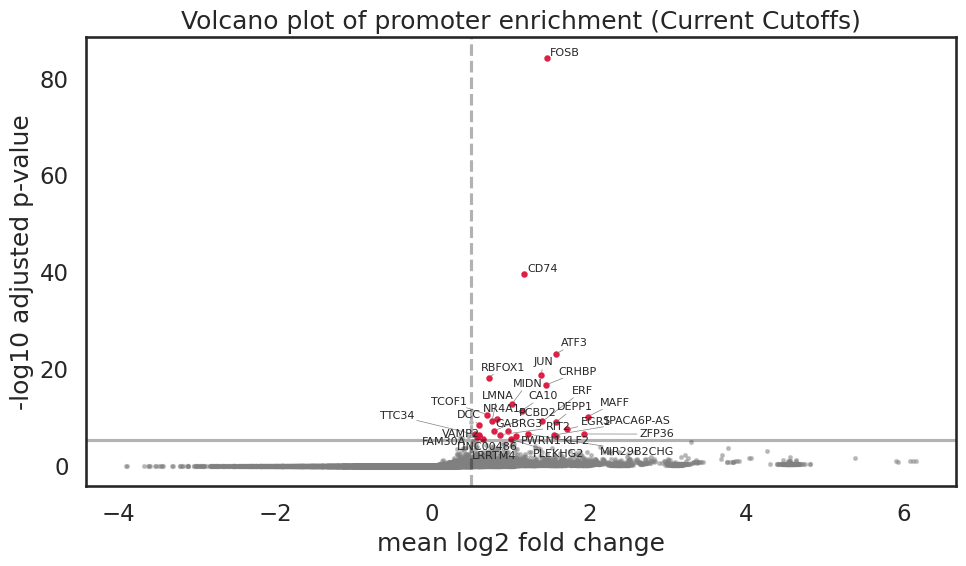

Current p-value threshold drawn at: 5.00e-06 (-log10 = 5.30)


In [69]:
import numpy as np
import matplotlib.pyplot as plt
from adjustText import adjust_text

# Copy base dataframe
df = CUTAC_wK27me3_HSC_Enrichments.copy()
log_fold_change_cutoff = 0.5
pval_cutoff = 0.000005

# Compute -log10 adjusted p-values
df['-log10_pval'] = -np.log10(df['p_values_adjusted_GBody'].clip(lower=1e-300))  # avoid log(0)

# Define enrichment status based on current thresholds
df['current_enriched'] = (df['log2_ratio_mean_GBody'] > log_fold_change_cutoff) & (df['p_values_adjusted_GBody'] < pval_cutoff)

# Report
print(f'There are {df.shape[0]:,} peaks.')
print(f"✅ Number of currently enriched promoter peaks: {df['current_enriched'].sum()}")

# Volcano plot
plt.figure(figsize=(10, 6))

# Plot all
plt.scatter(df.loc[~df['current_enriched'], 'log2_ratio_mean_GBody'],
            df.loc[~df['current_enriched'], '-log10_pval'],
            label='All peaks', s=5, alpha=0.4, color='gray')

# Plot enriched
plt.scatter(df.loc[df['current_enriched'], 'log2_ratio_mean_GBody'],
            df.loc[df['current_enriched'], '-log10_pval'],
            label='Enriched peaks', s=10, alpha=0.9, color='crimson')

# Draw cutoffs
plt.axhline(-np.log10(pval_cutoff), color='black', alpha=.3, label=f'p < {pval_cutoff:.0e}')
plt.axvline(log_fold_change_cutoff, color='black', alpha=.3, linestyle='dashed', label=f'log2FC > {log_fold_change_cutoff}')

# Label enriched genes
texts = []
for _, row in df[df['current_enriched']].iterrows():
    texts.append(plt.text(row['log2_ratio_mean_GBody'], row['-log10_pval'], row['gene'], fontsize=8))

adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))

# Final formatting
plt.xlabel('mean log2 fold change')
plt.ylabel('-log10 adjusted p-value')
plt.title('Volcano plot of promoter enrichment (Current Cutoffs)')
#plt.legend()
plt.tight_layout()
plt.show()

# Report effective cutoff
print(f'Current p-value threshold drawn at: {pval_cutoff:.2e} (-log10 = {-np.log10(pval_cutoff):.2f})')


There are 20,769 peaks.
✅ Number of currently enriched promoter peaks: 11


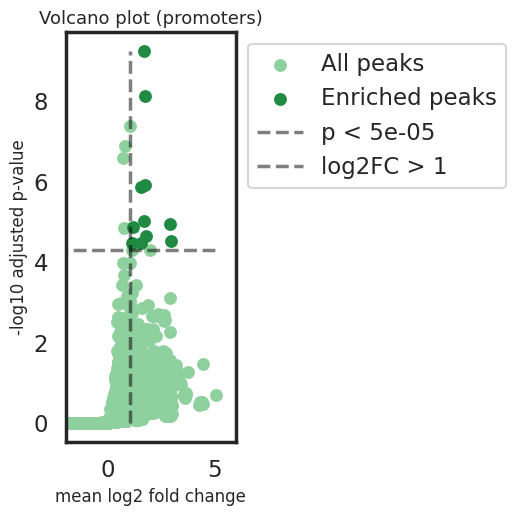

Cutoff: p < 5.00e-05 → -log10(p) = 4.30


In [70]:
import numpy as np
import matplotlib.pyplot as plt

# Copy and prepare data
df = CUTAC_wK4me123_MEP_Enrichments.copy()
log_fold_change_cutoff = 1
pval_cutoff = 0.00005

# Compute -log10 adjusted p-values
df['-log10_pval'] = -np.log10(df['p_values_adjusted_Prom'].clip(lower=1e-300))

# Define enrichment status
df['current_enriched'] = (df['log2_ratio_mean_Prom'] > log_fold_change_cutoff) & (df['p_values_adjusted_Prom'] < pval_cutoff)

# Report summary
print(f'There are {df.shape[0]:,} peaks.')
print(f"✅ Number of currently enriched promoter peaks: {df['current_enriched'].sum()}")

# Set up plot
plt.figure(figsize=(5.5, 5.5))  # Bigger plot

# Colors
highlight_color = '#208A42'   # Enriched peaks
background_color = '#8FD19E'  # Slightly darker light green for other peaks

# Point size
point_size = 60

# Plot non-enriched points
plt.scatter(
    df.loc[~df['current_enriched'], 'log2_ratio_mean_Prom'],
    df.loc[~df['current_enriched'], '-log10_pval'],
    label='All peaks',
    s=point_size,
    color=background_color
)

# Plot enriched points
plt.scatter(
    df.loc[df['current_enriched'], 'log2_ratio_mean_Prom'],
    df.loc[df['current_enriched'], '-log10_pval'],
    label='Enriched peaks',
    s=point_size,
    color=highlight_color
)

# Draw cutoff lines
lb, ub = df['log2_ratio_mean_Prom'].min(), df['log2_ratio_mean_Prom'].max()
plt.hlines(
    -np.log10(pval_cutoff),
    lb,
    ub,
    color='black',
    alpha=0.5,
    linestyles='dashed',
    linewidth=2.5,    # Thicker
    label=f'p < {pval_cutoff:.0e}'
)

plt.vlines(
    log_fold_change_cutoff,
    0,
    df['-log10_pval'].max(),
    color='black',
    alpha=0.5,
    linewidth=2.5,    # Thicker
    linestyles='dashed',
    label=f'log2FC > {log_fold_change_cutoff}'
)

# Formatting
plt.xlim(-2, 6)
plt.xlabel('mean log2 fold change', fontsize=12)
plt.ylabel('-log10 adjusted p-value', fontsize=12)
plt.title('Volcano plot (promoters)', fontsize=13)

# Thicker black outline (axes)
for spine in plt.gca().spines.values():
    spine.set_linewidth(2.5)

plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()

plt.savefig('MEP_Prom_FC_pvalues_scatterplot.png', dpi=300)

plt.show()

# Print effective cutoff
print(f'Cutoff: p < {pval_cutoff:.2e} → -log10(p) = {-np.log10(pval_cutoff):.2f}')


There are 20,769 peaks.
✅ Number of currently enriched promoter peaks: 11


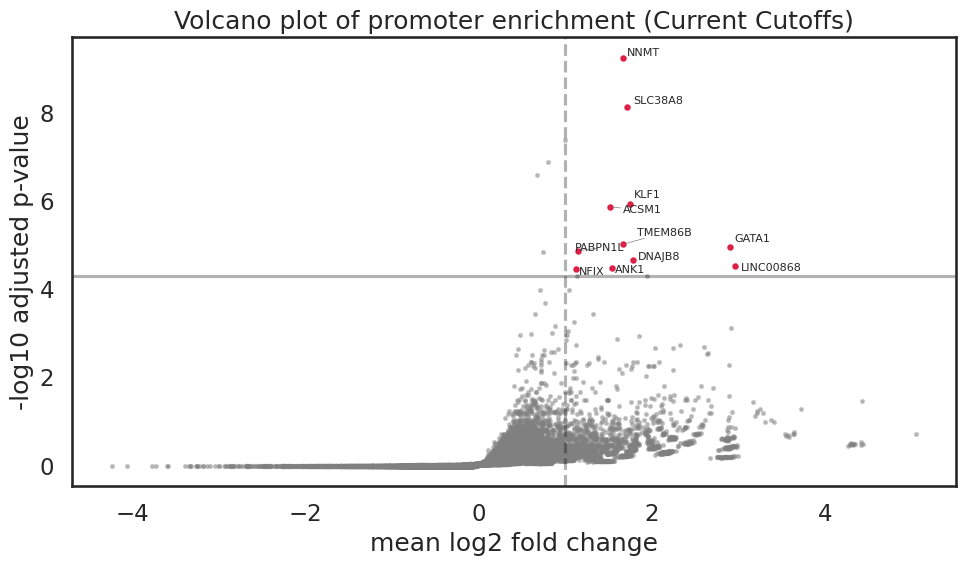

Current p-value threshold drawn at: 5.00e-05 (-log10 = 4.30)


In [91]:
import numpy as np
import matplotlib.pyplot as plt
from adjustText import adjust_text

# Copy base dataframe
df = CUTAC_wK4me123_MEP_Enrichments.copy()
log_fold_change_cutoff = 1
pval_cutoff = 0.00005

# Compute -log10 adjusted p-values
df['-log10_pval'] = -np.log10(df['p_values_adjusted_Prom'].clip(lower=1e-300))  # avoid log(0)

# Define enrichment status based on current thresholds
df['current_enriched'] = (df['log2_ratio_mean_Prom'] > log_fold_change_cutoff) & (df['p_values_adjusted_Prom'] < pval_cutoff)

# Report
print(f'There are {df.shape[0]:,} peaks.')
print(f"✅ Number of currently enriched promoter peaks: {df['current_enriched'].sum()}")

# Volcano plot
plt.figure(figsize=(10, 6))

# Plot all
plt.scatter(df.loc[~df['current_enriched'], 'log2_ratio_mean_Prom'],
            df.loc[~df['current_enriched'], '-log10_pval'],
            label='All peaks', s=5, alpha=0.4, color='gray')

# Plot enriched
plt.scatter(df.loc[df['current_enriched'], 'log2_ratio_mean_Prom'],
            df.loc[df['current_enriched'], '-log10_pval'],
            label='Enriched peaks', s=10, alpha=0.9, color='crimson')

# Draw cutoffs
plt.axhline(-np.log10(pval_cutoff), color='black', alpha=.3, label=f'p < {pval_cutoff:.0e}')
plt.axvline(log_fold_change_cutoff, color='black', alpha=.3, linestyle='dashed', label=f'log2FC > {log_fold_change_cutoff}')

# Label enriched genes
texts = []
for _, row in df[df['current_enriched']].iterrows():
    texts.append(plt.text(row['log2_ratio_mean_Prom'], row['-log10_pval'], row['gene'], fontsize=8))

adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))

# Final formatting
plt.xlabel('mean log2 fold change')
plt.ylabel('-log10 adjusted p-value')
plt.title('Volcano plot of promoter enrichment (Current Cutoffs)')
#plt.legend()
plt.tight_layout()
plt.show()

# Report effective cutoff
print(f'Current p-value threshold drawn at: {pval_cutoff:.2e} (-log10 = {-np.log10(pval_cutoff):.2f})')


In [85]:
CUTAC_wK4me123_MEP_Enrichments.head(5)

chrom_Prom  start_Prom  stop_Prom  Cterm_counts_Prom  Nterm_counts_Prom  \
0       chr1       64419      66419                  2                  3   
1       chr1      816371     818371                 46                  8   
2       chr1      822138     828138                312                 38   
3       chr1      826522     828522                264                 34   
4       chr1      869201     871201                100                 12   

   log2_ratio_mean_Prom  log2_ratio_std_Prom  log2_ratio_zscore_Prom  \
0              3.412737             1.179760                2.892738   
1              0.407065             0.546308                0.745120   
2             -0.142179             0.249931               -0.568874   
3             -0.056891             0.268230               -0.212096   
4             -0.133686             0.432171               -0.309335   

   log2_ratio_pvalue_Prom  null_rejected_Prom  ...  log2_ratio_std_GBody  \
0                0.001910               False  ...              1.005688   
1                0.228100               False  ...              0.743733   
2                0.715279               False  ...              0.279890   
3                0.583984               False  ...              1.449812   
4                0.621467               False  ...              1.474854   

   log2_ratio_zscore_GBody  log2_ratio_pvalue_GBody  null_rejected_GBody  \
0                 0.888537                 0.187126                False   
1                 0.785842                 0.215980                False   
2                -0.245820                 0.597089                False   
3                 1.313236                 0.094552                False   
4                 1.266965                 0.102584                False   

  p_values_adjusted_GBody p_values_adjusted_after_filter_GBody  \
0                0.644479                                  NaN   
1                0.686677                                  NaN   
2                0.990861                                  NaN   
3                0.482188                                  NaN   
4                0.503248                                  NaN   

  null_rejected_after_filter_GBody  enriched_GBody  GBody_50  Gene_Type  
0                            False           False        No       None  
1                            False           False        No       None  
2                            False           False        No       None  
3                            False           False        No       None  
4                            False           False        No       None  

[5 rows x 32 columns]

In [86]:
# Subset enriched peaks
enriched_df = df[df['current_enriched']].copy()

# Print summary
print("\n=== Enriched promoter peaks ===")
print(enriched_df[['chrom_Prom','start_Prom','stop_Prom','gene', 'log2_ratio_mean_Prom', 'p_values_adjusted_Prom']])

# Optionally, save to CSV
enriched_df.to_csv("Enriched_promoter_peaks.csv", index=False)

print(f"\nSaved {enriched_df.shape[0]} enriched peaks to 'Enriched_promoter_peaks.csv'")



=== Enriched promoter peaks ===
      chrom_Prom  start_Prom  stop_Prom       gene  log2_ratio_mean_Prom  \
3948       chr11   114254831  114260831       NNMT              1.668672   
7304       chr16    20688256   20694256      ACSM1              1.517510   
7774       chr16    84013756   84019756    SLC38A8              1.716189   
7834       chr16    88865660   88867660    PABPN1L              1.147230   
8932       chr17    76848340   76851340  LINC00868              2.955457   
9736       chr19    12886201   12888201       KLF1              1.746229   
9744       chr19    13067003   13073003       NFIX              1.118997   
10647      chr19    55227763   55229763    TMEM86B              1.668941   
14225       chr3   128466248  128468248     DNAJB8              1.775303   
18706       chr8    41794622   41800622       ANK1              1.536726   
20197       chrX    48785562   48787562      GATA1              2.905816   

       p_values_adjusted_Prom  
3948             5.733

There are 20,769 peaks.
✅ Number of currently enriched GBody peaks: 21


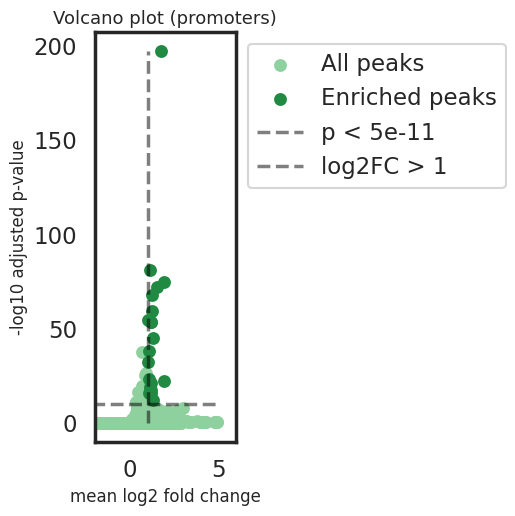

Cutoff: p < 5.00e-11 → -log10(p) = 10.30


In [72]:
import numpy as np
import matplotlib.pyplot as plt

# Copy and prepare data
df = CUTAC_wK4me123_MEP_Enrichments.copy()
log_fold_change_cutoff = 1
pval_cutoff = 5e-11  # Stricter p-value threshold for GBody

# Compute -log10 adjusted p-values
df['-log10_pval'] = -np.log10(df['p_values_adjusted_GBody'].clip(lower=1e-300))

# Define enrichment status
df['current_enriched'] = (
    (df['log2_ratio_mean_GBody'] > log_fold_change_cutoff) &
    (df['p_values_adjusted_GBody'] < pval_cutoff)
)

# Report summary
print(f'There are {df.shape[0]:,} peaks.')
print(f"✅ Number of currently enriched GBody peaks: {df['current_enriched'].sum()}")

# Set up plot
plt.figure(figsize=(5.5, 5.5))  # Same size as promoter plot

# Colors
highlight_color = '#208A42'   # Enriched peaks
background_color = '#8FD19E'  # Non-enriched peaks

# Point size
point_size = 60

# Plot non-enriched points
plt.scatter(
    df.loc[~df['current_enriched'], 'log2_ratio_mean_GBody'],
    df.loc[~df['current_enriched'], '-log10_pval'],
    label='All peaks',
    s=point_size,
    color=background_color
)

# Plot enriched points
plt.scatter(
    df.loc[df['current_enriched'], 'log2_ratio_mean_GBody'],
    df.loc[df['current_enriched'], '-log10_pval'],
    label='Enriched peaks',
    s=point_size,
    color=highlight_color
)

# Draw cutoff lines
lb, ub = df['log2_ratio_mean_Prom'].min(), df['log2_ratio_mean_Prom'].max()
plt.hlines(
    -np.log10(pval_cutoff),
    lb,
    ub,
    color='black',
    alpha=0.5,
    linestyles='dashed',
    linewidth=2.5,    # Thicker
    label=f'p < {pval_cutoff:.0e}'
)

plt.vlines(
    log_fold_change_cutoff,
    0,
    df['-log10_pval'].max(),
    color='black',
    alpha=0.5,
    linewidth=2.5,    # Thicker
    linestyles='dashed',
    label=f'log2FC > {log_fold_change_cutoff}'
)

# Formatting
plt.xlim(-2, 6)
plt.xlabel('mean log2 fold change', fontsize=12)
plt.ylabel('-log10 adjusted p-value', fontsize=12)
plt.title('Volcano plot (promoters)', fontsize=13)

# Thicker black outline (axes)
for spine in plt.gca().spines.values():
    spine.set_linewidth(2.5)
    
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()

plt.savefig('MEP_GBodies_FC_pvalues_scatterplot.png', dpi=300)

plt.show()

# Report effective cutoff
print(f'Cutoff: p < {pval_cutoff:.2e} → -log10(p) = {-np.log10(pval_cutoff):.2f}')


There are 20,769 peaks.
✅ Number of currently enriched promoter peaks: 21


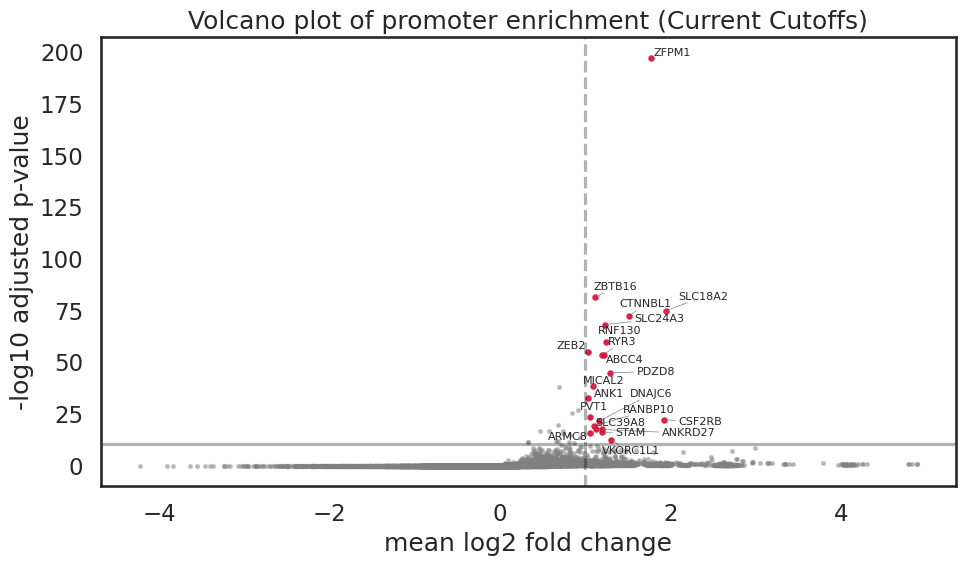

Current p-value threshold drawn at: 5.00e-11 (-log10 = 10.30)


In [73]:
import numpy as np
import matplotlib.pyplot as plt
from adjustText import adjust_text

# Copy base dataframe
df = CUTAC_wK4me123_MEP_Enrichments.copy()
log_fold_change_cutoff = 1
pval_cutoff = 0.00000000005

# Compute -log10 adjusted p-values
df['-log10_pval'] = -np.log10(df['p_values_adjusted_GBody'].clip(lower=1e-300))  # avoid log(0)

# Define enrichment status based on current thresholds
df['current_enriched'] = (df['log2_ratio_mean_GBody'] > log_fold_change_cutoff) & (df['p_values_adjusted_GBody'] < pval_cutoff)

# Report
print(f'There are {df.shape[0]:,} peaks.')
print(f"✅ Number of currently enriched promoter peaks: {df['current_enriched'].sum()}")

# Volcano plot
plt.figure(figsize=(10, 6))

# Plot all
plt.scatter(df.loc[~df['current_enriched'], 'log2_ratio_mean_GBody'],
            df.loc[~df['current_enriched'], '-log10_pval'],
            label='All peaks', s=5, alpha=0.4, color='gray')

# Plot enriched
plt.scatter(df.loc[df['current_enriched'], 'log2_ratio_mean_GBody'],
            df.loc[df['current_enriched'], '-log10_pval'],
            label='Enriched peaks', s=10, alpha=0.9, color='crimson')

# Draw cutoffs
plt.axhline(-np.log10(pval_cutoff), color='black', alpha=.3, label=f'p < {pval_cutoff:.0e}')
plt.axvline(log_fold_change_cutoff, color='black', alpha=.3, linestyle='dashed', label=f'log2FC > {log_fold_change_cutoff}')

# Label enriched genes
texts = []
for _, row in df[df['current_enriched']].iterrows():
    texts.append(plt.text(row['log2_ratio_mean_GBody'], row['-log10_pval'], row['gene'], fontsize=8))

adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))

# Final formatting
plt.xlabel('mean log2 fold change')
plt.ylabel('-log10 adjusted p-value')
plt.title('Volcano plot of promoter enrichment (Current Cutoffs)')
#plt.legend()
plt.tight_layout()
plt.show()

# Report effective cutoff
print(f'Current p-value threshold drawn at: {pval_cutoff:.2e} (-log10 = {-np.log10(pval_cutoff):.2f})')


There are 20,769 peaks.
✅ Number of currently enriched GMP promoter peaks: 7


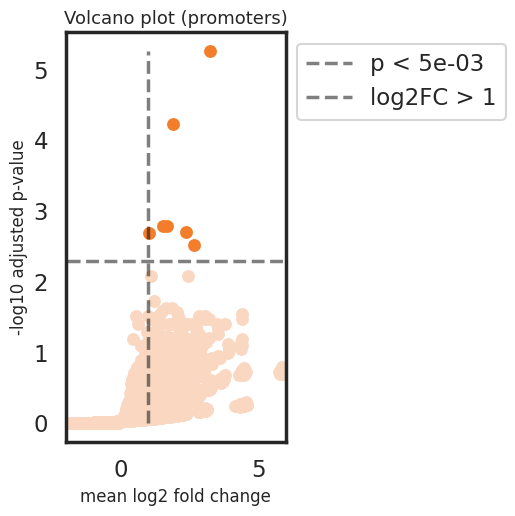

Cutoff: p < 5.00e-03 → -log10(p) = 2.30


In [93]:
import numpy as np
import matplotlib.pyplot as plt

# Copy and prepare data
df = CUTAC_wK4me123_GMP_Enrichments.copy()
log_fold_change_cutoff = 1
pval_cutoff = 0.005

# Compute -log10 adjusted p-values
df['-log10_pval'] = -np.log10(df['p_values_adjusted_Prom'].clip(lower=1e-300))

# Define enrichment status
df['current_enriched'] = (
    (df['log2_ratio_mean_Prom'] > log_fold_change_cutoff) &
    (df['p_values_adjusted_Prom'] < pval_cutoff)
)

# Report summary
print(f'There are {df.shape[0]:,} peaks.')
print(f"✅ Number of currently enriched GMP promoter peaks: {df['current_enriched'].sum()}")

# Set up plot
plt.figure(figsize=(5.5, 5.5))

# Colors
highlight_color = '#F47D2B'   # Enriched peaks
background_color = '#F9D7C1'  # Non-enriched peaks

# Point size
point_size = 60

# Plot non-enriched points
plt.scatter(
    df.loc[~df['current_enriched'], 'log2_ratio_mean_Prom'],
    df.loc[~df['current_enriched'], '-log10_pval'],
    s=point_size,
    color=background_color
)

# Plot enriched points
plt.scatter(
    df.loc[df['current_enriched'], 'log2_ratio_mean_Prom'],
    df.loc[df['current_enriched'], '-log10_pval'],
    s=point_size,
    color=highlight_color
)

# Draw cutoff lines
lb, ub = df['log2_ratio_mean_Prom'].min(), df['log2_ratio_mean_Prom'].max()
plt.hlines(
    -np.log10(pval_cutoff),
    lb,
    ub,
    color='black',
    alpha=0.5,
    linestyles='dashed',
    linewidth=2.5,    # Thicker
    label=f'p < {pval_cutoff:.0e}'
)

plt.vlines(
    log_fold_change_cutoff,
    0,
    df['-log10_pval'].max(),
    color='black',
    alpha=0.5,
    linewidth=2.5,    # Thicker
    linestyles='dashed',
    label=f'log2FC > {log_fold_change_cutoff}'
)

# Formatting
plt.xlim(-2, 6)
plt.xlabel('mean log2 fold change', fontsize=12)
plt.ylabel('-log10 adjusted p-value', fontsize=12)
plt.title('Volcano plot (promoters)', fontsize=13)

# Thicker black outline (axes)
for spine in plt.gca().spines.values():
    spine.set_linewidth(2.5)
    
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()

plt.savefig('GMP_Prom_FC_pvalues_scatterplot.png', dpi=300)

plt.show()

# Report effective cutoff
print(f'Cutoff: p < {pval_cutoff:.2e} → -log10(p) = {-np.log10(pval_cutoff):.2f}')


There are 20,769 peaks.
✅ Number of currently enriched promoter peaks: 7


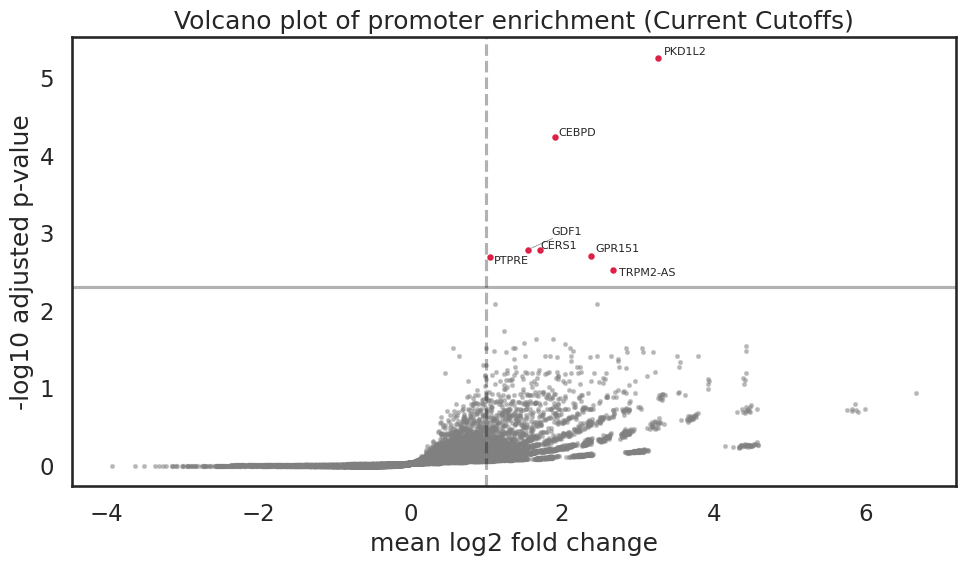

Current p-value threshold drawn at: 5.00e-03 (-log10 = 2.30)


In [75]:
import numpy as np
import matplotlib.pyplot as plt
from adjustText import adjust_text

# Copy base dataframe
df = CUTAC_wK4me123_GMP_Enrichments.copy()
log_fold_change_cutoff = 1
pval_cutoff = 0.005

# Compute -log10 adjusted p-values
df['-log10_pval'] = -np.log10(df['p_values_adjusted_Prom'].clip(lower=1e-300))  # avoid log(0)

# Define enrichment status based on current thresholds
df['current_enriched'] = (df['log2_ratio_mean_Prom'] > log_fold_change_cutoff) & (df['p_values_adjusted_Prom'] < pval_cutoff)

# Report
print(f'There are {df.shape[0]:,} peaks.')
print(f"✅ Number of currently enriched promoter peaks: {df['current_enriched'].sum()}")

# Volcano plot
plt.figure(figsize=(10, 6))

# Plot all
plt.scatter(df.loc[~df['current_enriched'], 'log2_ratio_mean_Prom'],
            df.loc[~df['current_enriched'], '-log10_pval'],
            label='All peaks', s=5, alpha=0.4, color='gray')

# Plot enriched
plt.scatter(df.loc[df['current_enriched'], 'log2_ratio_mean_Prom'],
            df.loc[df['current_enriched'], '-log10_pval'],
            label='Enriched peaks', s=10, alpha=0.9, color='crimson')

# Draw cutoffs
plt.axhline(-np.log10(pval_cutoff), color='black', alpha=.3, label=f'p < {pval_cutoff:.0e}')
plt.axvline(log_fold_change_cutoff, color='black', alpha=.3, linestyle='dashed', label=f'log2FC > {log_fold_change_cutoff}')

# Label enriched genes
texts = []
for _, row in df[df['current_enriched']].iterrows():
    texts.append(plt.text(row['log2_ratio_mean_Prom'], row['-log10_pval'], row['gene'], fontsize=8))

adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))

# Final formatting
plt.xlabel('mean log2 fold change')
plt.ylabel('-log10 adjusted p-value')
plt.title('Volcano plot of promoter enrichment (Current Cutoffs)')
#plt.legend()
plt.tight_layout()
plt.show()

# Report effective cutoff
print(f'Current p-value threshold drawn at: {pval_cutoff:.2e} (-log10 = {-np.log10(pval_cutoff):.2f})')


There are 20,769 peaks.
✅ Number of currently enriched GMP GBody peaks: 3


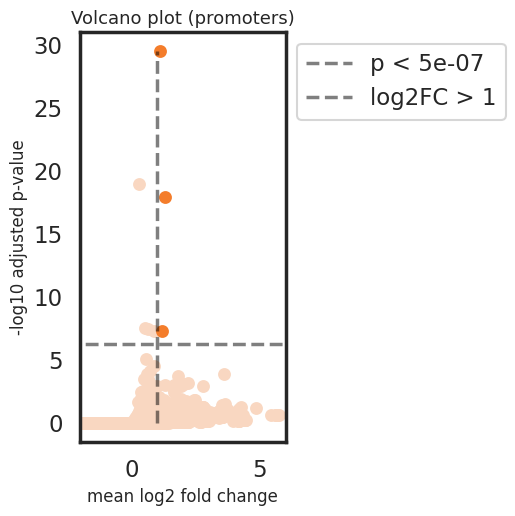

Cutoff: p < 5.00e-07 → -log10(p) = 6.30


In [76]:
import numpy as np
import matplotlib.pyplot as plt

# Copy and prepare data
df = CUTAC_wK4me123_GMP_Enrichments.copy()
log_fold_change_cutoff = 1
pval_cutoff = 0.0000005  # Stricter cutoff for GBody

# Compute -log10 adjusted p-values
df['-log10_pval'] = -np.log10(df['p_values_adjusted_GBody'].clip(lower=1e-300))

# Define enrichment status
df['current_enriched'] = (
    (df['log2_ratio_mean_GBody'] > log_fold_change_cutoff) &
    (df['p_values_adjusted_GBody'] < pval_cutoff)
)

# Report summary
print(f'There are {df.shape[0]:,} peaks.')
print(f"✅ Number of currently enriched GMP GBody peaks: {df['current_enriched'].sum()}")

# Set up plot
plt.figure(figsize=(5.5, 5.5))

# Colors
highlight_color = '#F47D2B'   # Enriched peaks (orange)
background_color = '#F9D7C1'  # Non-enriched peaks (soft peach)

# Point size
point_size = 60

# Plot non-enriched points
plt.scatter(
    df.loc[~df['current_enriched'], 'log2_ratio_mean_GBody'],
    df.loc[~df['current_enriched'], '-log10_pval'],
    s=point_size,
    color=background_color
)

# Plot enriched points
plt.scatter(
    df.loc[df['current_enriched'], 'log2_ratio_mean_GBody'],
    df.loc[df['current_enriched'], '-log10_pval'],
    s=point_size,
    color=highlight_color
)

# Draw cutoff lines
lb, ub = df['log2_ratio_mean_Prom'].min(), df['log2_ratio_mean_Prom'].max()
plt.hlines(
    -np.log10(pval_cutoff),
    lb,
    ub,
    color='black',
    alpha=0.5,
    linestyles='dashed',
    linewidth=2.5,    # Thicker
    label=f'p < {pval_cutoff:.0e}'
)

plt.vlines(
    log_fold_change_cutoff,
    0,
    df['-log10_pval'].max(),
    color='black',
    alpha=0.5,
    linewidth=2.5,    # Thicker
    linestyles='dashed',
    label=f'log2FC > {log_fold_change_cutoff}'
)

# Formatting
plt.xlim(-2, 6)
plt.xlabel('mean log2 fold change', fontsize=12)
plt.ylabel('-log10 adjusted p-value', fontsize=12)
plt.title('Volcano plot (promoters)', fontsize=13)

# Thicker black outline (axes)
for spine in plt.gca().spines.values():
    spine.set_linewidth(2.5)
    
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()

plt.savefig('GMP_GBodies_FC_pvalues_scatterplot.png', dpi=300)

plt.show()

# Report effective cutoff
print(f'Cutoff: p < {pval_cutoff:.2e} → -log10(p) = {-np.log10(pval_cutoff):.2f}')


There are 20,769 peaks.
✅ Number of currently enriched promoter peaks: 3


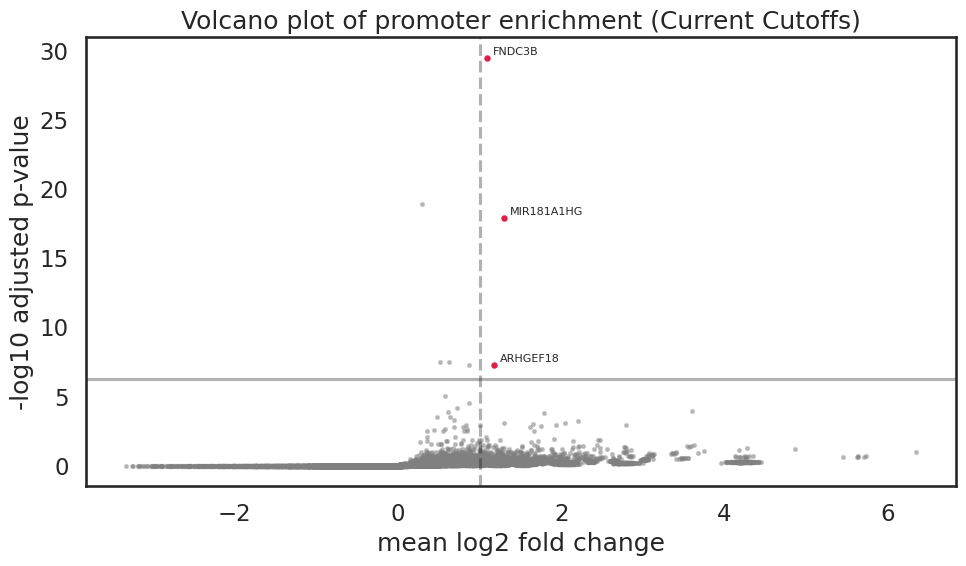

Current p-value threshold drawn at: 5.00e-07 (-log10 = 6.30)


In [77]:
import numpy as np
import matplotlib.pyplot as plt
from adjustText import adjust_text

# Copy base dataframe
df = CUTAC_wK4me123_GMP_Enrichments.copy()
log_fold_change_cutoff = 1
pval_cutoff = 0.0000005

# Compute -log10 adjusted p-values
df['-log10_pval'] = -np.log10(df['p_values_adjusted_GBody'].clip(lower=1e-300))  # avoid log(0)

# Define enrichment status based on current thresholds
df['current_enriched'] = (df['log2_ratio_mean_GBody'] > log_fold_change_cutoff) & (df['p_values_adjusted_GBody'] < pval_cutoff)

# Report
print(f'There are {df.shape[0]:,} peaks.')
print(f"✅ Number of currently enriched promoter peaks: {df['current_enriched'].sum()}")

# Volcano plot
plt.figure(figsize=(10, 6))

# Plot all
plt.scatter(df.loc[~df['current_enriched'], 'log2_ratio_mean_GBody'],
            df.loc[~df['current_enriched'], '-log10_pval'],
            label='All peaks', s=5, alpha=0.4, color='gray')

# Plot enriched
plt.scatter(df.loc[df['current_enriched'], 'log2_ratio_mean_GBody'],
            df.loc[df['current_enriched'], '-log10_pval'],
            label='Enriched peaks', s=10, alpha=0.9, color='crimson')

# Draw cutoffs
plt.axhline(-np.log10(pval_cutoff), color='black', alpha=.3, label=f'p < {pval_cutoff:.0e}')
plt.axvline(log_fold_change_cutoff, color='black', alpha=.3, linestyle='dashed', label=f'log2FC > {log_fold_change_cutoff}')

# Label enriched genes
texts = []
for _, row in df[df['current_enriched']].iterrows():
    texts.append(plt.text(row['log2_ratio_mean_GBody'], row['-log10_pval'], row['gene'], fontsize=8))

adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))

# Final formatting
plt.xlabel('mean log2 fold change')
plt.ylabel('-log10 adjusted p-value')
plt.title('Volcano plot of promoter enrichment (Current Cutoffs)')
#plt.legend()
plt.tight_layout()
plt.show()

# Report effective cutoff
print(f'Current p-value threshold drawn at: {pval_cutoff:.2e} (-log10 = {-np.log10(pval_cutoff):.2f})')


There are 20,769 peaks.
✅ Number of currently enriched CLP promoter peaks: 1


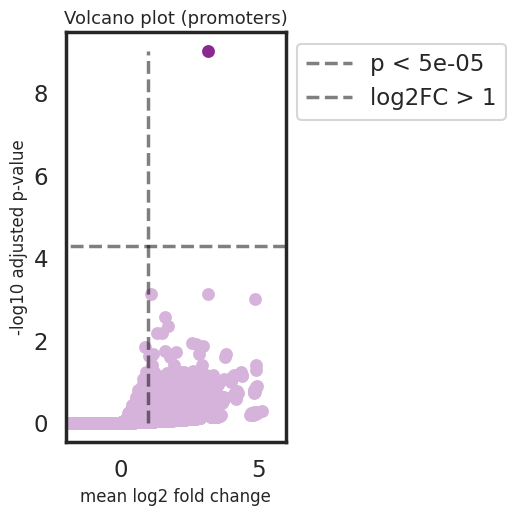

Cutoff: p < 5.00e-05 → -log10(p) = 4.30


In [97]:
import numpy as np
import matplotlib.pyplot as plt

# Copy and prepare data
df = CUTAC_wK4me123_CLP_Enrichments.copy()
log_fold_change_cutoff = 1
pval_cutoff = 0.00005

# Compute -log10 adjusted p-values
df['-log10_pval'] = -np.log10(df['p_values_adjusted_Prom'].clip(lower=1e-300))

# Define enrichment status
df['current_enriched'] = (
    (df['log2_ratio_mean_Prom'] > log_fold_change_cutoff) &
    (df['p_values_adjusted_Prom'] < pval_cutoff)
)

# Report summary
print(f'There are {df.shape[0]:,} peaks.')
print(f"✅ Number of currently enriched CLP promoter peaks: {df['current_enriched'].sum()}")

# Set up plot
plt.figure(figsize=(5.5, 5.5))

# Colors
highlight_color = '#89288F'   # Enriched peaks (deep purple)
background_color = '#D6B3DA'  # Non-enriched peaks (soft lavender)

# Point size
point_size = 60

# Plot non-enriched points
plt.scatter(
    df.loc[~df['current_enriched'], 'log2_ratio_mean_Prom'],
    df.loc[~df['current_enriched'], '-log10_pval'],
    s=point_size,
    color=background_color
)

# Plot enriched points
plt.scatter(
    df.loc[df['current_enriched'], 'log2_ratio_mean_Prom'],
    df.loc[df['current_enriched'], '-log10_pval'],
    s=point_size,
    color=highlight_color
)

# Draw cutoff lines
lb, ub = df['log2_ratio_mean_Prom'].min(), df['log2_ratio_mean_Prom'].max()
plt.hlines(
    -np.log10(pval_cutoff),
    lb,
    ub,
    color='black',
    alpha=0.5,
    linestyles='dashed',
    linewidth=2.5,    # Thicker
    label=f'p < {pval_cutoff:.0e}'
)

plt.vlines(
    log_fold_change_cutoff,
    0,
    df['-log10_pval'].max(),
    color='black',
    alpha=0.5,
    linewidth=2.5,    # Thicker
    linestyles='dashed',
    label=f'log2FC > {log_fold_change_cutoff}'
)

# Formatting
plt.xlim(-2, 6)
plt.xlabel('mean log2 fold change', fontsize=12)
plt.ylabel('-log10 adjusted p-value', fontsize=12)
plt.title('Volcano plot (promoters)', fontsize=13)

# Thicker black outline (axes)
for spine in plt.gca().spines.values():
    spine.set_linewidth(2.5)
    
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()

plt.savefig('CLP_Prom_FC_pvalues_scatterplot.png', dpi=300)

plt.show()

# Report effective cutoff
print(f'Cutoff: p < {pval_cutoff:.2e} → -log10(p) = {-np.log10(pval_cutoff):.2f}')


There are 20,769 peaks.
✅ Number of currently enriched promoter peaks: 6


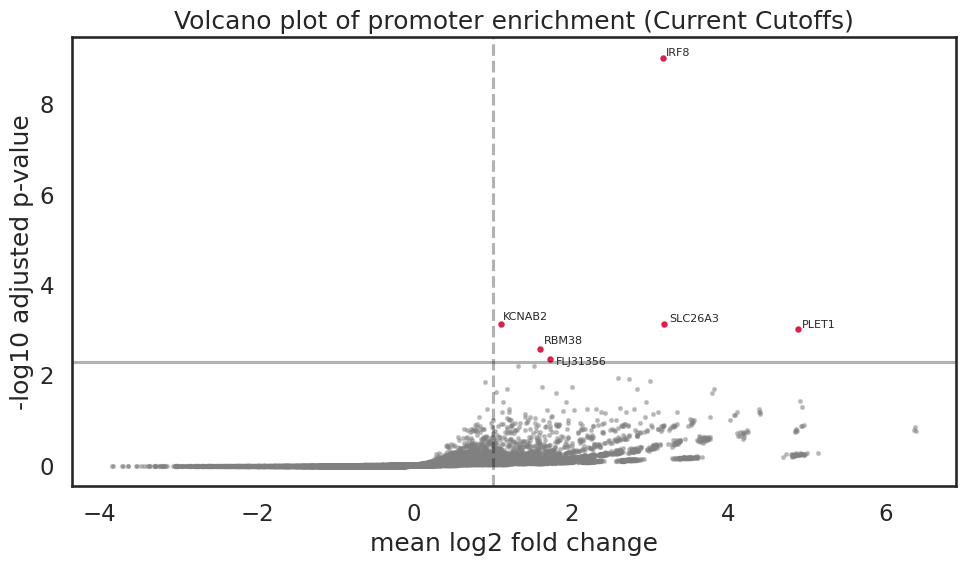

Current p-value threshold drawn at: 5.00e-03 (-log10 = 2.30)


In [98]:
import numpy as np
import matplotlib.pyplot as plt
from adjustText import adjust_text

# Copy base dataframe
df = CUTAC_wK4me123_CLP_Enrichments.copy()
log_fold_change_cutoff = 1
pval_cutoff = 0.005

# Compute -log10 adjusted p-values
df['-log10_pval'] = -np.log10(df['p_values_adjusted_Prom'].clip(lower=1e-300))  # avoid log(0)

# Define enrichment status based on current thresholds
df['current_enriched'] = (df['log2_ratio_mean_Prom'] > log_fold_change_cutoff) & (df['p_values_adjusted_Prom'] < pval_cutoff)

# Report
print(f'There are {df.shape[0]:,} peaks.')
print(f"✅ Number of currently enriched promoter peaks: {df['current_enriched'].sum()}")

# Volcano plot
plt.figure(figsize=(10, 6))

# Plot all
plt.scatter(df.loc[~df['current_enriched'], 'log2_ratio_mean_Prom'],
            df.loc[~df['current_enriched'], '-log10_pval'],
            label='All peaks', s=5, alpha=0.4, color='gray')

# Plot enriched
plt.scatter(df.loc[df['current_enriched'], 'log2_ratio_mean_Prom'],
            df.loc[df['current_enriched'], '-log10_pval'],
            label='Enriched peaks', s=10, alpha=0.9, color='crimson')

# Draw cutoffs
plt.axhline(-np.log10(pval_cutoff), color='black', alpha=.3, label=f'p < {pval_cutoff:.0e}')
plt.axvline(log_fold_change_cutoff, color='black', alpha=.3, linestyle='dashed', label=f'log2FC > {log_fold_change_cutoff}')

# Label enriched genes
texts = []
for _, row in df[df['current_enriched']].iterrows():
    texts.append(plt.text(row['log2_ratio_mean_Prom'], row['-log10_pval'], row['gene'], fontsize=8))

adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))

# Final formatting
plt.xlabel('mean log2 fold change')
plt.ylabel('-log10 adjusted p-value')
plt.title('Volcano plot of promoter enrichment (Current Cutoffs)')
#plt.legend()
plt.tight_layout()
plt.show()

# Report effective cutoff
print(f'Current p-value threshold drawn at: {pval_cutoff:.2e} (-log10 = {-np.log10(pval_cutoff):.2f})')


There are 20,769 peaks.
✅ Number of currently enriched CLP GBody peaks: 2


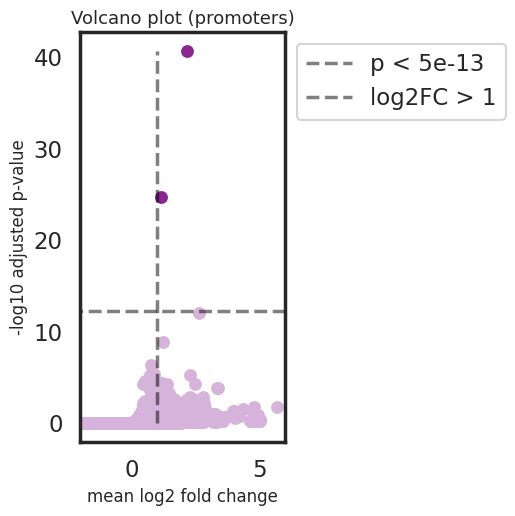

Cutoff: p < 5.00e-13 → -log10(p) = 12.30


In [80]:
import numpy as np
import matplotlib.pyplot as plt

# Copy and prepare data
df = CUTAC_wK4me123_CLP_Enrichments.copy()
log_fold_change_cutoff = 1
pval_cutoff = 5e-11  # very strict cutoff for GBody

# Compute -log10 adjusted p-values
df['-log10_pval'] = -np.log10(df['p_values_adjusted_GBody'].clip(lower=1e-300))

# Define enrichment status
df['current_enriched'] = (
    (df['log2_ratio_mean_GBody'] > log_fold_change_cutoff) &
    (df['p_values_adjusted_GBody'] < pval_cutoff)
)

# Report summary
print(f'There are {df.shape[0]:,} peaks.')
print(f"✅ Number of currently enriched CLP GBody peaks: {df['current_enriched'].sum()}")

# Set up plot
plt.figure(figsize=(5.5, 5.5))

# Colors
highlight_color = '#89288F'   # Enriched peaks (deep purple)
background_color = '#D6B3DA'  # Non-enriched peaks (soft lavender)

# Point size
point_size = 60

# Plot non-enriched points
plt.scatter(
    df.loc[~df['current_enriched'], 'log2_ratio_mean_GBody'],
    df.loc[~df['current_enriched'], '-log10_pval'],
    s=point_size,
    color=background_color
)

# Plot enriched points
plt.scatter(
    df.loc[df['current_enriched'], 'log2_ratio_mean_GBody'],
    df.loc[df['current_enriched'], '-log10_pval'],
    s=point_size,
    color=highlight_color
)

# Draw cutoff lines
lb, ub = df['log2_ratio_mean_Prom'].min(), df['log2_ratio_mean_Prom'].max()
plt.hlines(
    -np.log10(pval_cutoff),
    lb,
    ub,
    color='black',
    alpha=0.5,
    linestyles='dashed',
    linewidth=2.5,    # Thicker
    label=f'p < {pval_cutoff:.0e}'
)

plt.vlines(
    log_fold_change_cutoff,
    0,
    df['-log10_pval'].max(),
    color='black',
    alpha=0.5,
    linewidth=2.5,    # Thicker
    linestyles='dashed',
    label=f'log2FC > {log_fold_change_cutoff}'
)

# Formatting
plt.xlim(-2, 6)
plt.xlabel('mean log2 fold change', fontsize=12)
plt.ylabel('-log10 adjusted p-value', fontsize=12)
plt.title('Volcano plot (promoters)', fontsize=13)

# Thicker black outline (axes)
for spine in plt.gca().spines.values():
    spine.set_linewidth(2.5)
    
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()

plt.savefig('CLP_GBodies_FC_pvalues_scatterplot.png', dpi=300)

plt.show()

# Report effective cutoff
print(f'Cutoff: p < {pval_cutoff:.2e} → -log10(p) = {-np.log10(pval_cutoff):.2f}')


There are 20,769 peaks.
✅ Number of currently enriched promoter peaks: 2


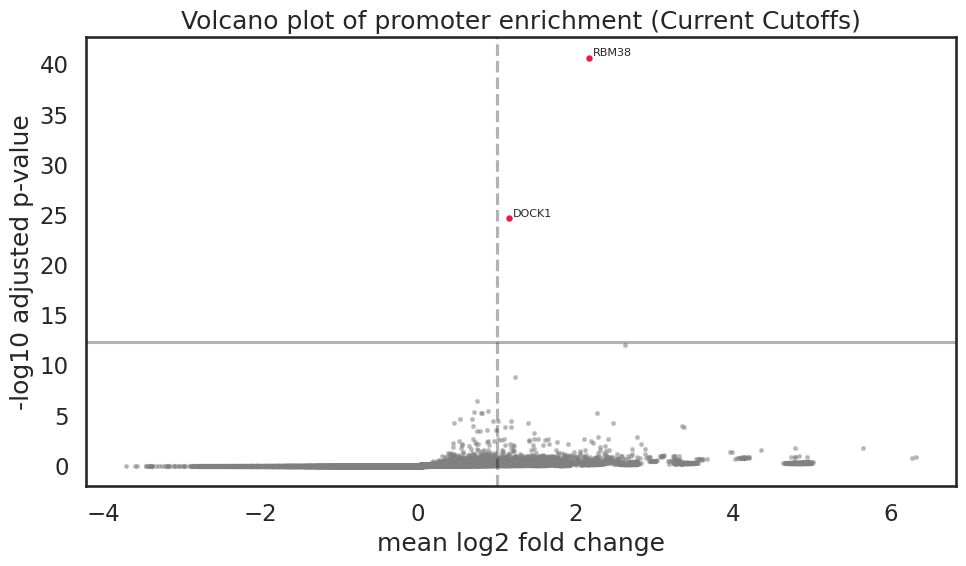

Current p-value threshold drawn at: 5.00e-13 (-log10 = 12.30)


In [100]:
import numpy as np
import matplotlib.pyplot as plt
from adjustText import adjust_text

# Copy base dataframe
df = CUTAC_wK4me123_CLP_Enrichments.copy()
log_fold_change_cutoff = 1
pval_cutoff = 0.0000000000005
#pval_cutoff = 0.0000005

# Compute -log10 adjusted p-values
df['-log10_pval'] = -np.log10(df['p_values_adjusted_GBody'].clip(lower=1e-300))  # avoid log(0)

# Define enrichment status based on current thresholds
df['current_enriched'] = (df['log2_ratio_mean_GBody'] > log_fold_change_cutoff) & (df['p_values_adjusted_GBody'] < pval_cutoff)

# Report
print(f'There are {df.shape[0]:,} peaks.')
print(f"✅ Number of currently enriched promoter peaks: {df['current_enriched'].sum()}")

# Volcano plot
plt.figure(figsize=(10, 6))

# Plot all
plt.scatter(df.loc[~df['current_enriched'], 'log2_ratio_mean_GBody'],
            df.loc[~df['current_enriched'], '-log10_pval'],
            label='All peaks', s=5, alpha=0.4, color='gray')

# Plot enriched
plt.scatter(df.loc[df['current_enriched'], 'log2_ratio_mean_GBody'],
            df.loc[df['current_enriched'], '-log10_pval'],
            label='Enriched peaks', s=10, alpha=0.9, color='crimson')

# Draw cutoffs
plt.axhline(-np.log10(pval_cutoff), color='black', alpha=.3, label=f'p < {pval_cutoff:.0e}')
plt.axvline(log_fold_change_cutoff, color='black', alpha=.3, linestyle='dashed', label=f'log2FC > {log_fold_change_cutoff}')

# Label enriched genes
texts = []
for _, row in df[df['current_enriched']].iterrows():
    texts.append(plt.text(row['log2_ratio_mean_GBody'], row['-log10_pval'], row['gene'], fontsize=8))

adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))

# Final formatting
plt.xlabel('mean log2 fold change')
plt.ylabel('-log10 adjusted p-value')
plt.title('Volcano plot of promoter enrichment (Current Cutoffs)')
#plt.legend()
plt.tight_layout()
plt.show()

# Report effective cutoff
print(f'Current p-value threshold drawn at: {pval_cutoff:.2e} (-log10 = {-np.log10(pval_cutoff):.2f})')


In [82]:
# --- Promoter enrichment reapplication ---
prom_cols = [col for col in CUTAC_wK27me3_HSC_Enrichments.columns if col.endswith('_Prom')] + ['gene']
df_prom = CUTAC_wK27me3_HSC_Enrichments[prom_cols].copy()

# Rename _Prom suffix to match what reapply_cutoffs expects
df_prom.columns = [col.replace('_Prom', '') for col in df_prom.columns]

# Reapply cutoffs
df_prom = reapply_cutoffs(df_prom, log_fold_change_cutoff=1, pval_cutoff=0.05)

# Get enriched promoter genes
enriched_promoter_genes = df_prom.loc[df_prom['enriched'], 'gene'].unique()

# --- GBody enrichment reapplication ---
gbody_cols = [col for col in CUTAC_wK27me3_HSC_Enrichments.columns if col.endswith('_GBody')] + ['gene']
df_gbody = CUTAC_wK27me3_HSC_Enrichments[gbody_cols].copy()

# Rename _GBody suffix to match what reapply_cutoffs expects
df_gbody.columns = [col.replace('_GBody', '') for col in df_gbody.columns]

# Reapply cutoffs
df_gbody = reapply_cutoffs(df_gbody, log_fold_change_cutoff=1, pval_cutoff=0.0000005)

# Get enriched GBody genes
enriched_gbody_genes = df_gbody.loc[df_gbody['enriched'], 'gene'].unique()

# --- Count and print ---
print(f"✅ Genes enriched in promoters (relaxed): {len(enriched_promoter_genes)}")
print(enriched_promoter_genes)

print(f"\n✅ Genes enriched in gene bodies (relaxed): {len(enriched_gbody_genes)}")
print(enriched_gbody_genes)


Found 19 peaks with significant enrichment after reapplying cutoffs.
Found 14 peaks with significant enrichment after reapplying cutoffs.
✅ Genes enriched in promoters (relaxed): 19
['IL20' 'LINC01653' 'KLRF2' 'ZFP36L1' 'LINC02071' 'CHST9' 'CDH7' 'PGPEP1'
 'UPK1A-AS1' 'CD33' 'ZNF581' 'CCDC106' 'TNS1' 'MIR155HG' 'LINC00606'
 'CCDC110' 'GPR150' 'LINC00587' 'LINC01492']

✅ Genes enriched in gene bodies (relaxed): 14
['JUN' 'MIR29B2CHG' 'ATF3' 'DEPP1' 'CA10' 'MIDN' 'ZFP36' 'ERF' 'FOSB'
 'SPACA6P-AS' 'MAFF' 'CRHBP' 'EGR1' 'CD74']


In [47]:
# --- Promoter enrichment reapplication ---
prom_cols = [col for col in CUTAC_wK4me123_MEP_Enrichments.columns if col.endswith('_Prom')] + ['gene']
df_prom = CUTAC_wK4me123_MEP_Enrichments[prom_cols].copy()

# Rename _Prom suffix to match what reapply_cutoffs expects
df_prom.columns = [col.replace('_Prom', '') for col in df_prom.columns]

# Reapply cutoffs
df_prom = reapply_cutoffs(df_prom, log_fold_change_cutoff=1, pval_cutoff=0.00005)

# Get enriched promoter genes
enriched_promoter_genes = df_prom.loc[df_prom['enriched'], 'gene'].unique()

# --- GBody enrichment reapplication ---
gbody_cols = [col for col in CUTAC_wK4me123_MEP_Enrichments.columns if col.endswith('_GBody')] + ['gene']
df_gbody = CUTAC_wK4me123_MEP_Enrichments[gbody_cols].copy()

# Rename _GBody suffix to match what reapply_cutoffs expects
df_gbody.columns = [col.replace('_GBody', '') for col in df_gbody.columns]

# Reapply cutoffs
df_gbody = reapply_cutoffs(df_gbody, log_fold_change_cutoff=1, pval_cutoff=0.00000000005)

# Get enriched GBody genes
enriched_gbody_genes = df_gbody.loc[df_gbody['enriched'], 'gene'].unique()

# --- Count and print ---
print(f"✅ Genes enriched in promoters (relaxed): {len(enriched_promoter_genes)}")
print(enriched_promoter_genes)

print(f"\n✅ Genes enriched in gene bodies (relaxed): {len(enriched_gbody_genes)}")
print(enriched_gbody_genes)


Found 11 peaks with significant enrichment after reapplying cutoffs.
Found 21 peaks with significant enrichment after reapplying cutoffs.
✅ Genes enriched in promoters (relaxed): 11
['NNMT' 'ACSM1' 'SLC38A8' 'PABPN1L' 'LINC00868' 'KLF1' 'NFIX' 'TMEM86B'
 'DNAJB8' 'ANK1' 'GATA1']

✅ Genes enriched in gene bodies (relaxed): 21
['DNAJC6' 'STAM' 'SLC18A2' 'PDZD8' 'MICAL2' 'ZBTB16' 'ABCC4' 'RYR3'
 'RANBP10' 'ZFPM1' 'ANKRD27' 'ZEB2' 'SLC24A3' 'CTNNBL1' 'CSF2RB' 'ARMC8'
 'SLC39A8' 'RNF130' 'VKORC1L1' 'ANK1' 'PVT1']


In [45]:
# --- Promoter enrichment reapplication ---
prom_cols = [col for col in CUTAC_wK4me123_GMP_Enrichments.columns if col.endswith('_Prom')] + ['gene']
df_prom = CUTAC_wK4me123_GMP_Enrichments[prom_cols].copy()

# Rename _Prom suffix to match what reapply_cutoffs expects
df_prom.columns = [col.replace('_Prom', '') for col in df_prom.columns]

# Reapply cutoffs
df_prom = reapply_cutoffs(df_prom, log_fold_change_cutoff=1, pval_cutoff=0.005)

# Get enriched promoter genes
enriched_promoter_genes = df_prom.loc[df_prom['enriched'], 'gene'].unique()

# --- GBody enrichment reapplication ---
gbody_cols = [col for col in CUTAC_wK4me123_GMP_Enrichments.columns if col.endswith('_GBody')] + ['gene']
df_gbody = CUTAC_wK4me123_GMP_Enrichments[gbody_cols].copy()

# Rename _GBody suffix to match what reapply_cutoffs expects
df_gbody.columns = [col.replace('_GBody', '') for col in df_gbody.columns]

# Reapply cutoffs
df_gbody = reapply_cutoffs(df_gbody, log_fold_change_cutoff=1, pval_cutoff=0.0000005)

# Get enriched GBody genes
enriched_gbody_genes = df_gbody.loc[df_gbody['enriched'], 'gene'].unique()

# --- Count and print ---
print(f"✅ Genes enriched in promoters (relaxed): {len(enriched_promoter_genes)}")
print(enriched_promoter_genes)

print(f"\n✅ Genes enriched in gene bodies (relaxed): {len(enriched_gbody_genes)}")
print(enriched_gbody_genes)


Found 7 peaks with significant enrichment after reapplying cutoffs.
Found 3 peaks with significant enrichment after reapplying cutoffs.
✅ Genes enriched in promoters (relaxed): 7
['PTPRE' 'PKD1L2' 'GDF1' 'CERS1' 'TRPM2-AS' 'GPR151' 'CEBPD']

✅ Genes enriched in gene bodies (relaxed): 3
['MIR181A1HG' 'ARHGEF18' 'FNDC3B']


In [46]:
# --- Promoter enrichment reapplication ---
prom_cols = [col for col in CUTAC_wK4me123_CLP_Enrichments.columns if col.endswith('_Prom')] + ['gene']
df_prom = CUTAC_wK4me123_CLP_Enrichments[prom_cols].copy()

# Rename _Prom suffix to match what reapply_cutoffs expects
df_prom.columns = [col.replace('_Prom', '') for col in df_prom.columns]

# Reapply cutoffs
df_prom = reapply_cutoffs(df_prom, log_fold_change_cutoff=1, pval_cutoff=0.00005)

# Get enriched promoter genes
enriched_promoter_genes = df_prom.loc[df_prom['enriched'], 'gene'].unique()

# --- GBody enrichment reapplication ---
gbody_cols = [col for col in CUTAC_wK4me123_CLP_Enrichments.columns if col.endswith('_GBody')] + ['gene']
df_gbody = CUTAC_wK4me123_CLP_Enrichments[gbody_cols].copy()

# Rename _GBody suffix to match what reapply_cutoffs expects
df_gbody.columns = [col.replace('_GBody', '') for col in df_gbody.columns]

# Reapply cutoffs
df_gbody = reapply_cutoffs(df_gbody, log_fold_change_cutoff=1, pval_cutoff=0.0000000000005)

# Get enriched GBody genes
enriched_gbody_genes = df_gbody.loc[df_gbody['enriched'], 'gene'].unique()

# --- Count and print ---
print(f"✅ Genes enriched in promoters (relaxed): {len(enriched_promoter_genes)}")
print(enriched_promoter_genes)

print(f"\n✅ Genes enriched in gene bodies (relaxed): {len(enriched_gbody_genes)}")
print(enriched_gbody_genes)


Found 1 peaks with significant enrichment after reapplying cutoffs.
Found 2 peaks with significant enrichment after reapplying cutoffs.
✅ Genes enriched in promoters (relaxed): 1
['IRF8']

✅ Genes enriched in gene bodies (relaxed): 2
['DOCK1' 'RBM38']


In [57]:
enriched_any = CUTAC_wK4me123_MEP_Enrichments[
    CUTAC_wK4me123_MEP_Enrichments['enriched_Prom'] | CUTAC_wK4me123_MEP_Enrichments['enriched_GBody']
]

print(f"✅ Genes enriched in either Promoters or GBodies: {enriched_any.shape[0]}")
print(enriched_any[['gene', 'enriched_Prom', 'enriched_GBody']])


✅ Genes enriched in either Promoters or GBodies: 23
                  gene  enriched_Prom  enriched_GBody
956          LINC01708           True           False
1468             ITLN2          False            True
3030            OR52A1          False            True
4551            HIGD1C           True           False
6311          MIR381HG          False            True
8404              GJD3           True           False
8416            TMEM99           True           False
8932         LINC00868           True           False
9947         LINC01785          False            True
11478          CFAP221           True           False
12383           BPIFB2           True           False
12534            EPPIN          False            True
12535      EPPIN-WFDC6          False            True
12723       ZBTB46-AS1           True           False
13129        LINC02554          False            True
13171          SEC14L6           True           False
13233  LL22NC01-81G9.3        

In [58]:
enriched_any = CUTAC_wK27me3_MEP_Enrichments[
    CUTAC_wK27me3_MEP_Enrichments['enriched_Prom'] | CUTAC_wK27me3_MEP_Enrichments['enriched_GBody']
]

print(f"✅ Genes enriched in either Promoters or GBodies: {enriched_any.shape[0]}")
print(enriched_any[['gene', 'enriched_Prom', 'enriched_GBody']])

✅ Genes enriched in either Promoters or GBodies: 19
             gene  enriched_Prom  enriched_GBody
193      PRAMEF27          False            True
4012        PDZD3           True           False
4494     C12orf54          False            True
6311     MIR381HG          False            True
6415       GABRA5           True           False
6468    LINC02345           True           False
7232    LINC01177          False            True
8207     MTRNR2L1          False            True
8441        KRT31          False            True
8840    LINC00469          False            True
8925   ST6GALNAC1           True           False
11593   LINC01876           True           False
12382        SUN5           True           False
12533       WFDC6          False            True
15076   LINC00989           True           False
19891        LCN1          False            True
20106      MAGEB2          False            True
20346   PHKA1-AS1           True           False
20509        XACT

In [274]:
gene_rows = CUTAC_wK27me3_MEP_Enrichments[CUTAC_wK27me3_MEP_Enrichments['gene'] == 'KLF1']
gene_rows.head(5)


chrom_Prom  start_Prom  stop_Prom  Cterm_counts_Prom  Nterm_counts_Prom  log2_ratio_mean_Prom  log2_ratio_std_Prom  log2_ratio_zscore_Prom  log2_ratio_pvalue_Prom  null_rejected_Prom  p_values_adjusted_Prom  p_values_adjusted_after_filter_Prom  null_rejected_after_filter_Prom  enriched_Prom  gene Promoter_50 chrom_GBody  start_GBody  stop_GBody  Cterm_counts_GBody  Nterm_counts_GBody  log2_ratio_mean_GBody  log2_ratio_std_GBody  log2_ratio_zscore_GBody  log2_ratio_pvalue_GBody  null_rejected_GBody  p_values_adjusted_GBody  p_values_adjusted_after_filter_GBody  null_rejected_after_filter_GBody  enriched_GBody GBody_50 Gene_Type
9736      chr19    12886201   12888201                 82                 12               0.91901             0.450771                2.038752                0.020737               False                0.378097                                  NaN                            False          False  KLF1          No       chr19     12884423    12886201                 310                  16               -0.74366              0.360747                -2.061445                  0.98037                False                      1.0                                   NaN                             False           False       No      None

In [ ]:
gene_rows = CUTAC_wK27me3_MEP_Enrichments[CUTAC_wK27me3_MEP_Enrichments['gene'] == 'KLF1']
gene_rows.head(5)

In [ ]:
enriched_any = CUTAC_wK4me123_GMP_Enrichments[
    CUTAC_wK4me123_GMP_Enrichments['enriched_Prom'] | CUTAC_wK4me123_GMP_Enrichments['enriched_GBody']
]

print(f"✅ Genes enriched in either Promoters or GBodies: {enriched_any.shape[0]}")
print(enriched_any[['gene', 'enriched_Prom', 'enriched_GBody']])

In [ ]:
enriched_any = CUTAC_wK4me123_CLP_Enrichments[
    CUTAC_wK4me123_CLP_Enrichments['enriched_Prom'] | CUTAC_wK4me123_CLP_Enrichments['enriched_GBody']
]

print(f"✅ Genes enriched in either Promoters or GBodies: {enriched_any.shape[0]}")
print(enriched_any[['gene', 'enriched_Prom', 'enriched_GBody']])

In [9]:
ArchR_hg38_Gene_List =  pd.read_csv('/varidata/research/projects/janssens/Henikoff_Lab_Data/CD34_Experiments/Janssens_Lab_CD34_Data_Processing/Gene_Lists/rowDataGSM_hg38.csv', sep=',')
ArchR_hg38_Gene_List = ArchR_hg38_Gene_List.iloc[:, [1, 2, 3, 4, 5]]
ArchR_hg38_Gene_List.columns = ['chr', 'start', 'stop', 'strand','gene']
ArchR_hg38_Gene_List_1 = ArchR_hg38_Gene_List[ArchR_hg38_Gene_List['strand'].isin([1])]
ArchR_hg38_Gene_List_2 = ArchR_hg38_Gene_List[ArchR_hg38_Gene_List['strand'].isin([2])]
ArchR_hg38_Gene_List_2 = ArchR_hg38_Gene_List_2.iloc[:, [0, 2, 1, 3, 4]]
ArchR_hg38_Gene_List_2.columns = ['chr', 'start', 'stop', 'strand','gene' ]
hg38_Gene_List = pd.concat([ArchR_hg38_Gene_List_1, ArchR_hg38_Gene_List_2])
hg38_Gene_List = hg38_Gene_List.sort_values(['chr', 'start'], ascending = [True, True])
hg38_Gene_List['Real'] = [1 if (x - y)<2500000 else 0 for x,y in zip(hg38_Gene_List['stop'], hg38_Gene_List['start'])]
hg38_Bad_Gene_List = hg38_Gene_List[hg38_Gene_List['Real'].isin([0])]
hg38_Gene_List = hg38_Gene_List[hg38_Gene_List['Real'].isin([1])]

hg38_Gene_List = hg38_Gene_List.iloc[:, [0, 1, 2, 4]]
hg38_Gene_List = hg38_Gene_List.sort_values(by = ['chr', 'start'], ascending = [True, True])
#hg38_Gene_List_bed = BedTool.from_dataframe(hg38_Gene_List_1)

# Add the IL3RA gene
new_row = {
    'chr': 'chrX',
    'start': 1334785,
    'stop': 1384689,
    'gene': 'IL3RA'
}

# Append the new row to the dataframe
hg38_Gene_List = pd.concat([hg38_Gene_List, pd.DataFrame([new_row])], ignore_index=True)


# Sort the dataframe by 'chromosome' and 'start'
hg38_Gene_List = hg38_Gene_List.sort_values(by=['chr', 'start']).reset_index(drop=True)


hg38_Gene_List.head(5)

chr   start    stop          gene
0  chr1   69091   70008         OR4F5
1  chr1  139790  140339     LOC729737
2  chr1  585990  629010  LOC101928626
3  chr1  817371  819837        FAM87B
4  chr1  825138  859446     LINC01128

In [ ]:
import pandas as pd
from pybedtools import BedTool

# --- Step 1: Load all K4me123 BED files ---
k4me123_files = {
    'Rep1': 'Full_hg38_Aligned_BED_Files/Batch_Beds_K4me123/K4me123_Batch1_Full.bed.gz',
    'Rep2': 'Full_hg38_Aligned_BED_Files/Batch_Beds_K4me123/K4me123_Batch2_Full.bed.gz',
    'Rep3': 'Full_hg38_Aligned_BED_Files/Batch_Beds_K4me123/K4me123_Batch3_Full.bed.gz',
    'Rep4': 'Full_hg38_Aligned_BED_Files/Batch_Beds_K4me123/K4me123_Batch4_Full.bed.gz',
    'Rep5': 'Full_hg38_Aligned_BED_Files/Batch_Beds_K4me123/K4me123_Batch5_Full.bed.gz',
    'Rep6': 'Full_hg38_Aligned_BED_Files/Batch_Beds_K4me123/K4me123_Batch6_Full.bed.gz', 
    'Rep7': 'Full_hg38_Aligned_BED_Files/Batch_Beds_K4me123/K4me123_Batch7_2in1_wCUTAC_Full.bed.gz',
    'Rep8': 'Full_hg38_Aligned_BED_Files/Batch_Beds_K4me123/K4me123_Batch8_2in1_wCUTAC_Full.bed.gz', 
    'Rep9': 'Full_hg38_Aligned_BED_Files/Batch_Beds_K4me123/K4me123_Batch9_2in1_wCUTAC_Full.bed.gz', 
    'Rep10': 'Full_hg38_Aligned_BED_Files/Batch_Beds_K4me123/K4me123_Batch10_Full.bed.gz'
}

# Combine into one dataframe
k4me123_df = pd.concat([
    pd.read_csv(path, sep='\t', header=None) for path in k4me123_files.values()
])
k4me123_df.columns = ['chrom', 'start', 'stop', 'barcode']

# --- Step 2: Load cluster barcode annotations ---
cluster_df = pd.read_csv("K4me123_Cluster_Barcodes.csv", names=['barcode', 'cluster'], header=None)

# Map each cluster name to a set of barcodes
barcode_by_cluster = {
    k: set(cluster_df.loc[cluster_df['cluster'] == k, 'barcode'])
    for k in ['HSC', 'MEP', 'GMP', 'CLP']
}

# --- Step 3: Split BED by cell type ---
k4me123_hsc_bed = BedTool.from_dataframe(k4me123_df[k4me123_df['barcode'].isin(barcode_by_cluster['HSC'])].iloc[:, :3])
k4me123_mep_bed = BedTool.from_dataframe(k4me123_df[k4me123_df['barcode'].isin(barcode_by_cluster['MEP'])].iloc[:, :3])
k4me123_gmp_bed = BedTool.from_dataframe(k4me123_df[k4me123_df['barcode'].isin(barcode_by_cluster['GMP'])].iloc[:, :3])
k4me123_clp_bed = BedTool.from_dataframe(k4me123_df[k4me123_df['barcode'].isin(barcode_by_cluster['CLP'])].iloc[:, :3])


In [24]:
import pandas as pd
import numpy as np
from pybedtools import BedTool
from statsmodels.stats.multitest import fdrcorrection
from joblib import Parallel, delayed
from scipy import stats
import matplotlib.pyplot as plt
from adjustText import adjust_text


# Load CUTAC files and combine
cutac_file_paths = {
    'Rep1': 'Full_hg38_Aligned_BED_Files/Batch_Beds_CUTAC_wSplit_Combined/CUTAC_Batch7_2in1_wK4me123_wSplit_Full.bed.gz',
    'Rep2': 'Full_hg38_Aligned_BED_Files/Batch_Beds_CUTAC_wSplit_Combined/CUTAC_Batch8_2in1_wK4me123_wSplit_Full.bed.gz',
    'Rep3': 'Full_hg38_Aligned_BED_Files/Batch_Beds_CUTAC_wSplit_Combined/CUTAC_Batch9_2in1_wK4me123_wSplit_Full.bed.gz',
}

CUTAC_wK4me123_Combined  = pd.concat([
    pd.read_csv(p, sep='\t', header=None) for p in cutac_file_paths.values()
])
CUTAC_wK4me123_Combined.columns = ['chrom', 'start', 'stop', 'barcode']

import pandas as pd
from pybedtools import BedTool

# --- Step 1: Load cluster barcode annotations ---
# If your CSV already has headers, adjust accordingly (e.g. header=0)
cluster_df = pd.read_csv("K4me123_Cluster_Barcodes.csv")

# Make sure we have consistent column names
# (sometimes this file is ['barcode','cluster'], other times ['cluster_name','barcode'])
if 'cluster' in cluster_df.columns:
    barcode_col, cluster_col = 'barcode', 'cluster'
elif 'cluster_name' in cluster_df.columns:
    barcode_col, cluster_col = 'barcode', 'cluster_name'
else:
    raise ValueError("Could not find cluster column in K4me123_Cluster_Barcodes.csv")

# Map each cluster to barcodes
barcode_by_cluster = {
    k: set(cluster_df.loc[cluster_df[cluster_col] == k, barcode_col])
    for k in ['HSC', 'MEP', 'GMP', 'CLP']
}

# --- Step 2: Use your already combined CUTAC dataframe ---
# CUTAC_wK4me123_Combined should already be loaded like:
# CUTAC_wK4me123_Combined = pd.concat([...]) with columns ['chrom','start','stop','barcode']

# --- Step 3: Split CUTAC by cell type ---
CUTAC_hsc_bed = BedTool.from_dataframe(
    CUTAC_wK4me123_Combined[CUTAC_wK4me123_Combined['barcode'].isin(barcode_by_cluster['HSC'])].iloc[:, :3]
)
CUTAC_mep_bed = BedTool.from_dataframe(
    CUTAC_wK4me123_Combined[CUTAC_wK4me123_Combined['barcode'].isin(barcode_by_cluster['MEP'])].iloc[:, :3]
)
CUTAC_gmp_bed = BedTool.from_dataframe(
    CUTAC_wK4me123_Combined[CUTAC_wK4me123_Combined['barcode'].isin(barcode_by_cluster['GMP'])].iloc[:, :3]
)
CUTAC_clp_bed = BedTool.from_dataframe(
    CUTAC_wK4me123_Combined[CUTAC_wK4me123_Combined['barcode'].isin(barcode_by_cluster['CLP'])].iloc[:, :3]
)


In [ ]:
df2 = bed_counts_1.intersect(Sample_bed_2, c=True).to_dataframe()

/tmp/ipykernel_121863/90874148.py:82: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=combined_df, x='group', y='norm',


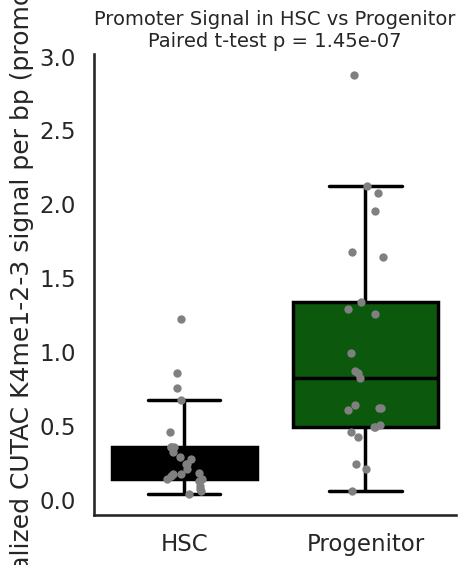

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from pybedtools import BedTool
from scipy.stats import ttest_rel

# --- Setup lineage-specific gene sets ---
gene_sets = {
    "MEP": [
        'DNAJC6', 'STAM', 'SLC18A2', 'PDZD8', 'MICAL2', 'ZBTB16', 'ABCC4', 'RYR3',
        'RANBP10', 'ZFPM1', 'ANKRD27', 'ZEB2', 'SLC24A3', 'CTNNBL1', 'CSF2RB',
        'ARMC8', 'SLC39A8', 'RNF130', 'VKORC1L1', 'ANK1', 'PVT1'
    ],
    "GMP": ["MIR181A1HG", "ARHGEF18", "FNDC3B"],
    "CLP": ["DOCK1"]
}

# --- Load and format promoter intervals ---
promoters = top_CD34_promoters_scaled_ArchR_genes.iloc[:, :4].copy()
promoters.columns = ['chrom', 'start', 'stop', 'gene']

# --- CUTAC bed dictionary (split earlier) ---
bed_dict = {
    "HSC": CUTAC_hsc_bed,
    "MEP": CUTAC_mep_bed,
    "GMP": CUTAC_gmp_bed,
    "CLP": CUTAC_clp_bed
}

# --- General function to quantify normalized CUTAC signal ---
def quantify_signal(intervals_df, genes, bed):
    """
    Quantify CUTAC signal over a set of intervals (e.g., promoters or gene bodies).
    Uses -c to count read overlaps, then normalizes by interval length.
    
    Returns DataFrame with ['gene','norm'].
    """
    subset = intervals_df[intervals_df['gene'].isin(genes)]
    if subset.empty:
        return pd.DataFrame(columns=['gene','norm'])
    
    intervals_bed = BedTool.from_dataframe(subset)
    overlap = intervals_bed.intersect(bed, c=True)  # count overlaps
    df = pd.read_csv(overlap.fn, sep='\t', header=None)
    df.columns = ['chrom', 'start', 'stop', 'gene', 'counts']
    
    df['length'] = df['stop'] - df['start']
    df['norm'] = df['counts'] / df['length'] * 100
    
    return df[['gene','norm']]

# --- Quantify HSC signal for all genes ---
all_genes = sum(gene_sets.values(), [])  # flatten
hsc_df = quantify_signal(promoters, all_genes, bed_dict["HSC"])
hsc_df["group"] = "HSC"

# --- Quantify progenitor signal for lineage-specific genes ---
prog_dfs = []
for lineage, genes in gene_sets.items():
    df = quantify_signal(promoters, genes, bed_dict[lineage])
    if not df.empty:
        df["group"] = "Progenitor"
        prog_dfs.append(df)

prog_df = pd.concat(prog_dfs, ignore_index=True)

# --- Combine HSC + progenitor ---
combined_df = pd.concat([hsc_df, prog_df], ignore_index=True)
CUTAC_PnR_Prom_Combined = combined_df.copy()

# --- Paired t-test (per gene) ---
paired = pd.merge(hsc_df[['gene','norm']],
                  prog_df[['gene','norm']],
                  on='gene', suffixes=('_hsc','_prog'))
stat, pval = ttest_rel(paired['norm_hsc'], paired['norm_prog'])

# --- Plot ---
sns.set(style='white', context='talk')
palette = {'HSC': 'black', 'Progenitor': 'darkgreen'}

fig, ax = plt.subplots(figsize=(5, 6))
sns.boxplot(data=combined_df, x='group', y='norm',
            palette=palette, linewidth=2.5, showfliers=False, ax=ax)
sns.stripplot(data=combined_df, x='group', y='norm',
              color='gray', jitter=True, size=6, ax=ax)

# Style tweaks
for patch in ax.patches:
    patch.set_edgecolor('black')
    patch.set_linewidth(2.5)

ax.set_ylabel("Normalized CUTAC K4me1-2-3 signal per bp (promoters)")
ax.set_xlabel("")
ax.set_title(f"Promoter Signal in HSC vs Progenitor\nPaired t-test p = {pval:.2e}", fontsize=14)

sns.despine()
plt.tight_layout()
plt.savefig("CUTAC_K4me123_Promoter_HSC_vs_Progenitor.png", dpi=300)
plt.show()


/tmp/ipykernel_121863/3990689413.py:82: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=combined_df, x='group', y='norm',


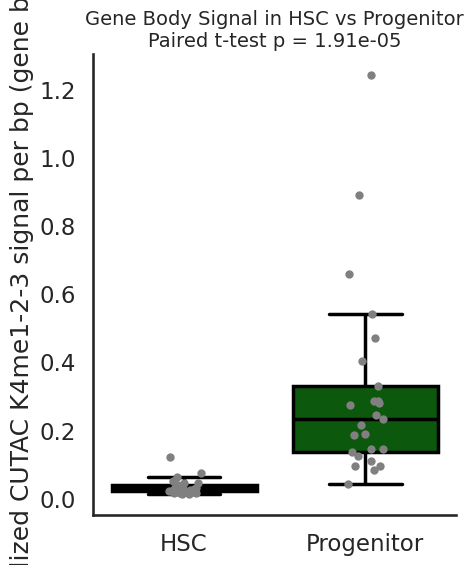

In [60]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from pybedtools import BedTool
from scipy.stats import ttest_rel

# --- Load gene body intervals ---
CD34_GBodies_ArchR_genes = pd.read_csv("CD34_GBodies_ArchR_genes.bed", sep="\t", header=None)
CD34_GBodies_ArchR_genes.columns = ['chrom', 'start', 'stop', 'gene']

# --- Gene sets ---
gene_sets = {
    "MEP": [
        'DNAJC6', 'STAM', 'SLC18A2', 'PDZD8', 'MICAL2', 'ZBTB16', 'ABCC4', 'RYR3',
        'RANBP10', 'ZFPM1', 'ANKRD27', 'ZEB2', 'SLC24A3', 'CTNNBL1', 'CSF2RB',
        'ARMC8', 'SLC39A8', 'RNF130', 'VKORC1L1', 'ANK1', 'PVT1'
    ],
    "GMP": ["MIR181A1HG", "ARHGEF18", "FNDC3B"],
    "CLP": ["DOCK1"]
}

# --- CUTAC bed dictionary (already defined earlier) ---
bed_dict = {
    "HSC": CUTAC_hsc_bed,
    "MEP": CUTAC_mep_bed,
    "GMP": CUTAC_gmp_bed,
    "CLP": CUTAC_clp_bed
}

# --- Function to compute normalized signal per gene body ---
def quantify_gbody_signal(genes, bed, intervals_df):
    """
    Quantify CUTAC signal over gene bodies.
    Uses -c to count read overlaps, then normalizes by interval length.
    """
    subset = intervals_df[intervals_df['gene'].isin(genes)]
    if subset.empty:
        return pd.DataFrame(columns=['gene','norm'])
    
    intervals_bed = BedTool.from_dataframe(subset)
    overlap = intervals_bed.intersect(bed, c=True)  # count overlaps
    df = pd.read_csv(overlap.fn, sep='\t', header=None)
    df.columns = ['chrom', 'start', 'stop', 'gene', 'counts']
    
    df['length'] = df['stop'] - df['start']
    df['norm'] = df['counts'] / df['length'] * 100
    
    return df[['gene','norm']]

# --- Quantify HSC across all lineage-associated genes ---
all_genes = sum(gene_sets.values(), [])
hsc_df = quantify_gbody_signal(all_genes, bed_dict["HSC"], CD34_GBodies_ArchR_genes)
hsc_df["group"] = "HSC"

# --- Quantify progenitors for lineage-specific genes ---
prog_dfs = []
for lineage, genes in gene_sets.items():
    df = quantify_gbody_signal(genes, bed_dict[lineage], CD34_GBodies_ArchR_genes)
    if not df.empty:
        df["group"] = "Progenitor"
        prog_dfs.append(df)

prog_df = pd.concat(prog_dfs, ignore_index=True)

# --- Combine ---
combined_df = pd.concat([hsc_df, prog_df], ignore_index=True)
CUTAC_PnR_GBody_Combined = combined_df.copy()

# --- Paired t-test ---
paired = pd.merge(
    hsc_df[['gene','norm']],
    prog_df[['gene','norm']],
    on='gene', suffixes=('_hsc','_prog')
)
stat, pval = ttest_rel(paired['norm_hsc'], paired['norm_prog'])

# --- Plotting ---
sns.set(style='white', context='talk')
palette = {'HSC': 'black', 'Progenitor': 'darkgreen'}

fig, ax = plt.subplots(figsize=(5, 6))
sns.boxplot(data=combined_df, x='group', y='norm',
            palette=palette, linewidth=2.5, showfliers=False, ax=ax)
sns.stripplot(data=combined_df, x='group', y='norm',
              color='gray', jitter=True, size=6, ax=ax)

# Style
for patch in ax.patches:
    patch.set_edgecolor('black')
    patch.set_linewidth(2.5)

ax.set_ylabel("Normalized CUTAC K4me1-2-3 signal per bp (gene bodies)")
ax.set_xlabel("")
ax.set_title(f"Gene Body Signal in HSC vs Progenitor\nPaired t-test p = {pval:.2e}", fontsize=14)

sns.despine()
plt.tight_layout()
plt.savefig("CUTAC_K4me123_GBody_HSC_vs_Progenitor.png", dpi=300)
plt.show()


/tmp/ipykernel_121863/4015999137.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=combined_df, x='group', y='norm',


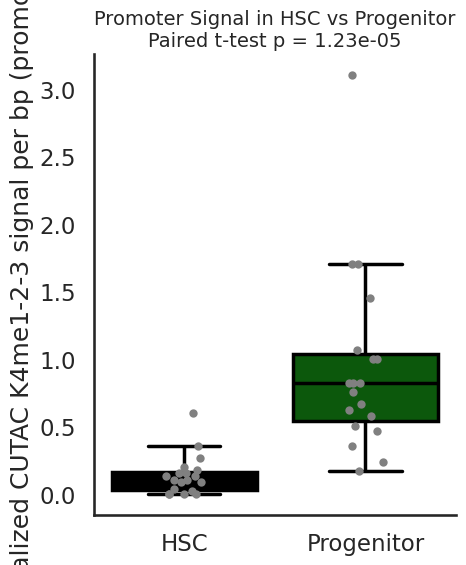

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel
import pandas as pd
from pybedtools import BedTool

# --- InR gene sets ---
gene_sets = {
    "MEP": ['NNMT', 'ACSM1', 'SLC38A8', 'PABPN1L', 'LINC00868',
            'KLF1', 'NFIX', 'TMEM86B', 'DNAJB8', 'ANK1', 'GATA1'],
    "GMP": ['PTPRE', 'PKD1L2', 'GDF1', 'CERS1',
            'TRPM2-AS', 'GPR151', 'CEBPD'],
    "CLP": ['IRF8']
}

# --- Load promoter intervals ---
promoters = top_CD34_promoters_scaled_ArchR_genes.iloc[:, :4].copy()
promoters.columns = ['chrom', 'start', 'stop', 'gene']

# --- CUTAC lineage-split beds ---
bed_dict = {
    "HSC": CUTAC_hsc_bed,
    "MEP": CUTAC_mep_bed,
    "GMP": CUTAC_gmp_bed,
    "CLP": CUTAC_clp_bed
}

# --- Function to quantify normalized signal with -c ---
def quantify_promoter_signal(genes, bed, intervals_df):
    subset = intervals_df[intervals_df['gene'].isin(genes)]
    if subset.empty:
        return pd.DataFrame(columns=['gene', 'norm'])
    
    promoter_bed = BedTool.from_dataframe(subset)
    overlap = promoter_bed.intersect(bed, c=True)   # <- count overlaps
    df = pd.read_csv(overlap.fn, sep='\t', header=None)
    df.columns = ['chrom', 'start', 'stop', 'gene', 'counts']
    
    df['promoter_len'] = df['stop'] - df['start']
    df['norm'] = df['counts'] / df['promoter_len'] * 100
    
    return df[['gene', 'norm']]

# --- HSC signal for all InR genes ---
all_genes = sum(gene_sets.values(), [])
hsc_df = quantify_promoter_signal(all_genes, bed_dict["HSC"], promoters)
hsc_df["group"] = "HSC"

# --- Progenitor signals (lineage-specific) ---
prog_dfs = []
for lineage, genes in gene_sets.items():
    df = quantify_promoter_signal(genes, bed_dict[lineage], promoters)
    if not df.empty:
        df["group"] = "Progenitor"
        prog_dfs.append(df)

prog_df = pd.concat(prog_dfs, ignore_index=True)

# --- Combine ---
combined_df = pd.concat([hsc_df, prog_df], ignore_index=True)
CUTAC_InR_Prom_Combined = combined_df.copy()

# --- Paired t-test ---
paired = pd.merge(
    hsc_df[['gene', 'norm']],
    prog_df[['gene', 'norm']],
    on='gene', suffixes=('_hsc', '_prog')
)
stat, pval = ttest_rel(paired['norm_hsc'], paired['norm_prog'])

# --- Plotting ---
sns.set(style='white', context='talk')
palette = {'HSC': 'black', 'Progenitor': 'darkgreen'}

fig, ax = plt.subplots(figsize=(5, 6))
sns.boxplot(data=combined_df, x='group', y='norm',
            palette=palette, linewidth=2.5, showfliers=False, ax=ax)
sns.stripplot(data=combined_df, x='group', y='norm',
              color='gray', jitter=True, size=6, ax=ax)

# Style
for patch in ax.patches:
    patch.set_edgecolor('black')
    patch.set_linewidth(2.5)

ax.set_ylabel("Normalized CUTAC K4me1-2-3 signal per bp (promoters)")
ax.set_xlabel("")
ax.set_title(
    f"Promoter Signal in HSC vs Progenitor\nPaired t-test p = {pval:.2e}",
    fontsize=14
)

sns.despine()
plt.tight_layout()
plt.savefig("CUTAC_InR_Promoters_HSC_vs_Progenitor.png", dpi=300)
plt.show()


/tmp/ipykernel_121863/4175852985.py:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=combined_df, x='group', y='norm',


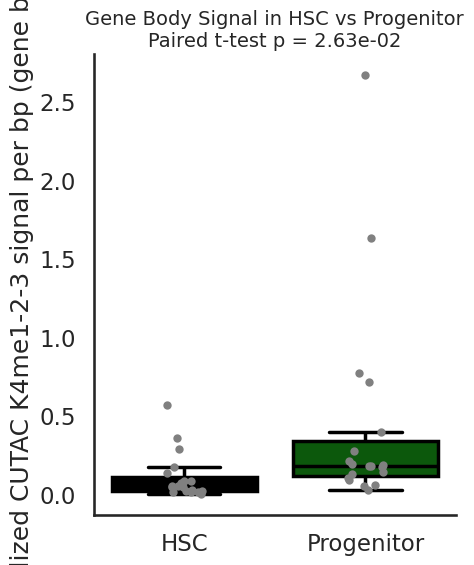

In [62]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel
import pandas as pd
from pybedtools import BedTool

# --- Load InR gene sets ---
gene_sets = {
    "MEP": ['NNMT', 'ACSM1', 'SLC38A8', 'PABPN1L', 'LINC00868',
            'KLF1', 'NFIX', 'TMEM86B', 'DNAJB8', 'ANK1', 'GATA1'],
    "GMP": ['PTPRE', 'PKD1L2', 'GDF1', 'CERS1',
            'TRPM2-AS', 'GPR151', 'CEBPD'],
    "CLP": ['IRF8']
}

# --- Load and format gene body intervals ---
CD34_GBodies_ArchR_genes = pd.read_csv(
    'CD34_GBodies_ArchR_genes.bed', sep='\t', header=None
)
CD34_GBodies_ArchR_genes.columns = ['chrom', 'start', 'stop', 'gene']
gbody_df = CD34_GBodies_ArchR_genes.copy()

# --- CUTAC lineage-split beds ---
bed_dict = {
    "HSC": CUTAC_hsc_bed,
    "MEP": CUTAC_mep_bed,
    "GMP": CUTAC_gmp_bed,
    "CLP": CUTAC_clp_bed
}

# --- Function to compute normalized signal per gene body (with -c) ---
def quantify_gbody_signal(genes, bed, intervals_df):
    subset = intervals_df[intervals_df['gene'].isin(genes)]
    if subset.empty:
        return pd.DataFrame(columns=['gene', 'norm'])
    
    gbody_bed = BedTool.from_dataframe(subset)
    overlap = gbody_bed.intersect(bed, c=True)   # <- count all overlaps
    df = pd.read_csv(overlap.fn, sep='\t', header=None)
    df.columns = ['chrom', 'start', 'stop', 'gene', 'counts']
    
    df['gene_length'] = df['stop'] - df['start']
    df['norm'] = df['counts'] / df['gene_length'] * 100
    
    return df[['gene', 'norm']]

# --- HSC signal across all InR genes ---
all_genes = sum(gene_sets.values(), [])
hsc_df = quantify_gbody_signal(all_genes, bed_dict["HSC"], gbody_df)
hsc_df["group"] = "HSC"

# --- Progenitor signals (lineage-specific) ---
prog_dfs = []
for lineage, genes in gene_sets.items():
    df = quantify_gbody_signal(genes, bed_dict[lineage], gbody_df)
    if not df.empty:
        df["group"] = "Progenitor"
        prog_dfs.append(df)

prog_df = pd.concat(prog_dfs, ignore_index=True)

# --- Combine all ---
combined_df = pd.concat([hsc_df, prog_df], ignore_index=True)
CUTAC_InR_GBody_Combined = combined_df.copy()

# --- Paired t-test ---
paired = pd.merge(
    hsc_df[['gene', 'norm']],
    prog_df[['gene', 'norm']],
    on='gene', suffixes=('_hsc', '_prog')
)
stat, pval = ttest_rel(paired['norm_hsc'], paired['norm_prog'])

# --- Plotting ---
sns.set(style='white', context='talk')
palette = {'HSC': 'black', 'Progenitor': 'darkgreen'}

fig, ax = plt.subplots(figsize=(5, 6))
sns.boxplot(data=combined_df, x='group', y='norm',
            palette=palette, linewidth=2.5, showfliers=False, ax=ax)
sns.stripplot(data=combined_df, x='group', y='norm',
              color='gray', jitter=True, size=6, ax=ax)

# Style tweaks
for patch in ax.patches:
    patch.set_edgecolor('black')
    patch.set_linewidth(2.5)

ax.set_ylabel("Normalized CUTAC K4me1-2-3 signal per bp (gene bodies)")
ax.set_xlabel("")
ax.set_title(
    f"Gene Body Signal in HSC vs Progenitor\nPaired t-test p = {pval:.2e}",
    fontsize=14
)

sns.despine()
plt.tight_layout()
plt.savefig("CUTAC_InR_GBodies_HSC_vs_Progenitor.png", dpi=300)
plt.show()


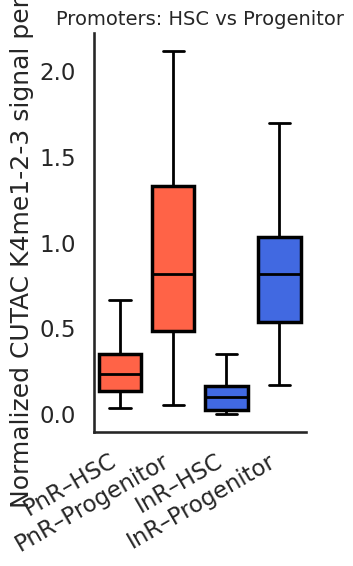

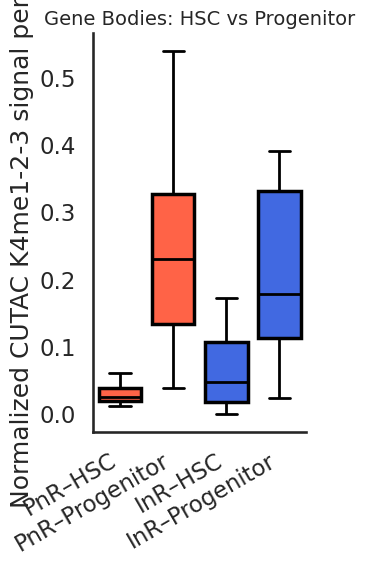

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set(style='white', context='talk')

def plot_region_manual(df, region_name, outfile):
    # Ensure string types
    df["analysis"] = df["analysis"].astype(str)
    df["group"] = df["group"].astype(str)
    df["combo"] = df["analysis"] + "–" + df["group"]

    # Desired order and colors
    combo_order = [
        "PnR–HSC",
        "PnR–Progenitor",
        "InR–HSC",
        "InR–Progenitor"
    ]
    combo_colors = {
        "PnR–HSC": "tomato",
        "PnR–Progenitor": "tomato",
        "InR–HSC": "royalblue",
        "InR–Progenitor": "royalblue"
    }

    fig, ax = plt.subplots(figsize=(3.5, 6))
    sns.boxplot(
        data=df,
        x="combo", y="norm",
        order=combo_order,
        linewidth=2.5,
        showfliers=False,
        ax=ax
    )

    # Manually apply colors and black outlines
    for i, patch in enumerate(ax.patches):
        label = combo_order[i]
        patch.set_facecolor(combo_colors[label])
        patch.set_edgecolor("black")
        patch.set_linewidth(2.5)

    # Black whiskers/medians
    for line in ax.lines:
        line.set_color("black")
        line.set_linewidth(2)

    # Axis styling
    ax.set_ylabel("Normalized CUTAC K4me1-2-3 signal per bp")
    ax.set_xlabel("")
    ax.set_title(f"{region_name}: HSC vs Progenitor", fontsize=14)
    ax.set_xticks(range(len(combo_order)))
    ax.set_xticklabels(combo_order, rotation=30, ha='right')

    if ax.legend_ is not None:
        ax.legend_.remove()

    sns.despine()
    plt.tight_layout()
    plt.savefig(outfile, dpi=300)
    plt.show()


# --- Combine PnR and InR results into Promoter/Gene Body plots ---

# Promoters
promoter_df = pd.concat([
    CUTAC_PnR_Prom_Combined.assign(region="Promoter", analysis="PnR"),
    CUTAC_InR_Prom_Combined.assign(region="Promoter", analysis="InR")
], ignore_index=True)

plot_region_manual(promoter_df, "Promoters", "CUTAC_Promoters_HSC_vs_Progenitor.png")

# Gene Bodies
gbody_df = pd.concat([
    CUTAC_PnR_GBody_Combined.assign(region="Gene Body", analysis="PnR"),
    CUTAC_InR_GBody_Combined.assign(region="Gene Body", analysis="InR")
], ignore_index=True)

plot_region_manual(gbody_df, "Gene Bodies", "CUTAC_GeneBodies_HSC_vs_Progenitor.png")



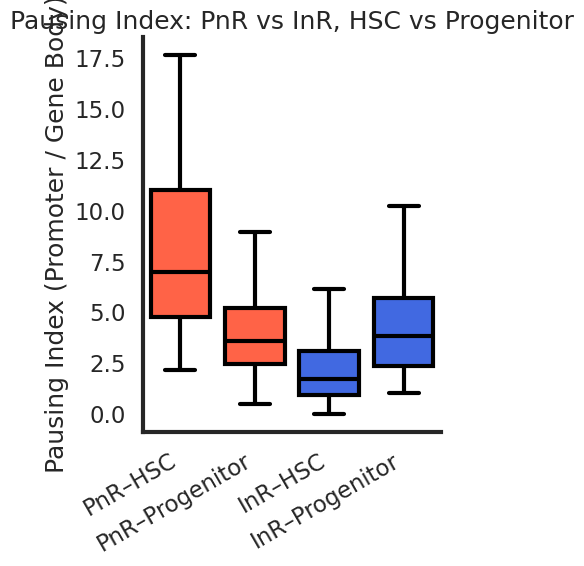

Paired t-test results (HSC vs Progenitor):
  PnR: p = 1.22e-03
  InR: p = 4.58e-01


In [114]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel

sns.set(style="white", context="talk")

# --- Helper: calculate pausing index ---
def compute_pausing_index(promoter_df, gbody_df, gene_sets):
    merged = pd.merge(
        promoter_df[['gene','norm','group','analysis']],
        gbody_df[['gene','norm','group','analysis']],
        on=['gene','group','analysis'],
        suffixes=('_prom','_gbody')
    )
    merged['pausing_index'] = (merged['norm_prom'] + 1e-3) / (merged['norm_gbody'] + 1e-3)
    merged['analysis'] = merged['gene'].apply(
        lambda g: 'PnR' if g in gene_sets['PnR'] else 'InR'
    )
    return merged[['gene','group','analysis','pausing_index']]


# --- Plot only ---
def plot_pausing_index(df, outfile):
    fig, ax = plt.subplots(figsize=(4.5,6))

    # Build combo column
    df = df.copy()
    df["combo"] = df["analysis"] + "–" + df["group"]

    # Explicit order and colors
    combo_order = [
        "PnR–HSC", "PnR–Progenitor",
        "InR–HSC", "InR–Progenitor"
    ]
    combo_colors = {
        "PnR–HSC": "tomato",
        "PnR–Progenitor": "tomato",
        "InR–HSC": "royalblue",
        "InR–Progenitor": "royalblue"
    }

    # Plot
    sns.boxplot(
        data=df, x="combo", y="pausing_index",
        order=combo_order,
        linewidth=3, showfliers=False, ax=ax
    )

    # Recolor boxes and add black outlines
    for i, patch in enumerate(ax.patches):
        label = combo_order[i]
        patch.set_facecolor(combo_colors[label])
        patch.set_edgecolor("black")
        patch.set_linewidth(3)

    # Make whiskers/medians black
    for line in ax.lines:
        line.set_color("black")
        line.set_linewidth(3)

    # Set axis (spine) line widths
    for spine in ax.spines.values():
        spine.set_linewidth(3)

    # Styling
    ax.set_ylabel("Pausing Index (Promoter / Gene Body)")
    ax.set_xlabel("")
    ax.set_title("Pausing Index: PnR vs InR, HSC vs Progenitor")
    ax.set_xticks(range(len(combo_order)))
    ax.set_xticklabels(combo_order, rotation=30, ha="right")

    if ax.legend_:
        ax.legend_.remove()

    sns.despine()
    plt.tight_layout()
    plt.savefig(outfile, dpi=300)
    plt.show()




# --- Separate stats calculation ---
def pausing_index_stats(df):
    stats = {}
    for analysis in ["PnR", "InR"]:
        sub = df[df["analysis"]==analysis]
        sub = sub.groupby(["gene","group"], as_index=False)["pausing_index"].mean()
        pivot = sub.pivot(index="gene", columns="group", values="pausing_index").dropna()
        if "HSC" in pivot.columns and "Progenitor" in pivot.columns:
            stat, pval = ttest_rel(pivot["HSC"], pivot["Progenitor"])
            stats[analysis] = pval
        else:
            stats[analysis] = None

    print("Paired t-test results (HSC vs Progenitor):")
    for analysis, pval in stats.items():
        if pval is not None:
            print(f"  {analysis}: p = {pval:.2e}")
        else:
            print(f"  {analysis}: not enough data")
    return stats


# --- Run them separately ---
plot_pausing_index(pi_df, "PausingIndex_PnRvsInR.png")
stats = pausing_index_stats(pi_df)


In [7]:
import pandas as pd
import numpy as np
from pybedtools import BedTool
from statsmodels.stats.multitest import fdrcorrection
from joblib import Parallel, delayed
from scipy import stats
import matplotlib.pyplot as plt
from adjustText import adjust_text

# --- Extract barcodes by cluster ---
cluster_barcodes = pd.read_csv("K27me3_Cluster_Barcodes.csv")
cluster_barcodes_dict = {
    k: set(cluster_barcodes.loc[cluster_barcodes["cluster_name"] == k, "barcode"])
    for k in ['HSC', 'LMPP', 'MPP', 'MEP']
}

# --- Load and concatenate K27me3 bed files ---
k27me3_file_paths = {
    'Rep1': 'Full_hg38_Aligned_BED_Files/Batch_Beds_K27me3/K27me3_Batch1_Full.bed.gz',
    'Rep2': 'Full_hg38_Aligned_BED_Files/Batch_Beds_K27me3/K27me3_Batch2_Full.bed.gz',
    'Rep3': 'Full_hg38_Aligned_BED_Files/Batch_Beds_K27me3/K27me3_Batch3_Full.bed.gz',
    'Rep4': 'Full_hg38_Aligned_BED_Files/Batch_Beds_K27me3/K27me3_Batch4_2in1_wCUTAC_Full.bed.gz',
    'Rep5': 'Full_hg38_Aligned_BED_Files/Batch_Beds_K27me3/K27me3_Batch7_2in1_wCUTAC_Full.bed.gz',
    'Rep6': 'Full_hg38_Aligned_BED_Files/Batch_Beds_K27me3/K27me3_Batch8_2in1_wCUTAC_Full.bed.gz',
    'Rep7': 'Full_hg38_Aligned_BED_Files/Batch_Beds_K27me3/K27me3_Batch9_2in1_wCUTAC_Full.bed.gz',
    'Rep8': 'Full_hg38_Aligned_BED_Files/Batch_Beds_K27me3/K27me3_Batch10_Full.bed.gz'
}

k27me3_df = pd.concat([pd.read_csv(p, sep='\t', header=None) for p in k27me3_file_paths.values()])
k27me3_df.columns = ['chrom', 'start', 'stop', 'barcode']

# --- Generate BEDTools by cluster ---
hsc_barcodes = cluster_barcodes_dict['HSC']
prog_barcodes = set().union(*[cluster_barcodes_dict[k] for k in ['LMPP', 'MPP', 'MEP']])
mep_barcodes = cluster_barcodes_dict['MEP']

k27me3_hsc_bed = BedTool.from_dataframe(k27me3_df[k27me3_df['barcode'].isin(hsc_barcodes)].iloc[:, :3])
k27me3_prog_bed_no_hsc = BedTool.from_dataframe(k27me3_df[k27me3_df['barcode'].isin(prog_barcodes)].iloc[:, :3])
k27me3_mep_bed = BedTool.from_dataframe(k27me3_df[k27me3_df['barcode'].isin(mep_barcodes)].iloc[:, :3])


PnR vs InR: p = 1.65e-05, n=24, 18
PnR vs HOX: p = 4.54e-09, n=24, 23
InR vs HOX: p = 4.02e-06, n=18, 23


/tmp/ipykernel_121863/1938169860.py:86: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


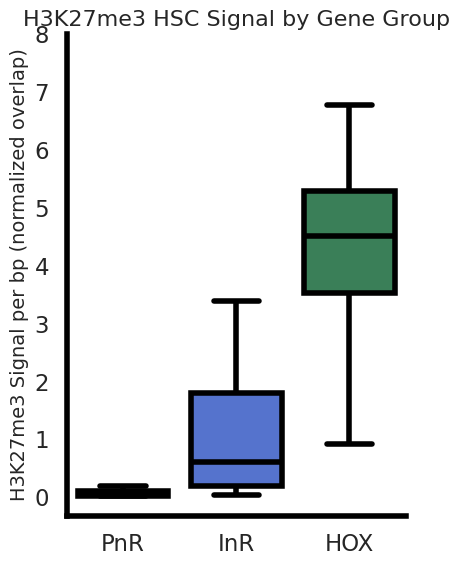

In [125]:
import pandas as pd
from pybedtools import BedTool
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu
import numpy as np

# === Define gene groups ===
PnR_genes = [
    'DNAJC6', 'STAM', 'SLC18A2', 'PDZD8', 'MICAL2', 'ZBTB16', 'ABCC4', 'RYR3',
    'RANBP10', 'ZFPM1', 'ANKRD27', 'ZEB2', 'SLC24A3', 'CTNNBL1', 'CSF2RB', 'ARMC8',
    'SLC39A8', 'RNF130', 'VKORC1L1', 'PVT1', 'MIR181A1HG', 'ARHGEF18',
    'FNDC3B', 'DOCK1'
]

InR_genes = [
    'NNMT', 'ACSM1', 'SLC38A8', 'PABPN1L', 'LINC00868', 'KLF1', 'NFIX', 'TMEM86B',
    'DNAJB8', 'GATA1', 'PTPRE', 'PKD1L2', 'GDF1', 'CERS1', 'TRPM2-AS',
    'GPR151', 'CEBPD', 'IRF8'
]

HOX_genes = [
    'HOXA1', 'HOXA2', 'HOXA11', 'HOXA13',
    'HOXB8', 'HOXB9',  # you have HOXB8 twice, kept as-is
    'HOXC4', 'HOXC5', 'HOXC6', 'HOXC8', 'HOXC9', 'HOXC10', 'HOXC12', 'HOXC13',
    'HOXD1', 'HOXD3', 'HOXD4', 'HOXD8', 'HOXD9', 'HOXD10', 'HOXD11', 'HOXD12', 'HOXD13'
]

# === Filter for target genes ===
target_genes = PnR_genes + InR_genes + HOX_genes
gene_intervals = hg38_Gene_List[hg38_Gene_List['gene'].isin(target_genes)]

# === Load BED file ===
bed_tool = k27me3_hsc_bed

# === Intersect and quantify ===
gene_intervals_bed = BedTool.from_dataframe(gene_intervals)
overlap = gene_intervals_bed.intersect(bed_tool, wao=True)
overlap_df = pd.read_csv(overlap.fn, sep='\t', header=None)

overlap_df.columns = ['chrom', 'start', 'stop', 'gene',
                      'chrom2', 'start2', 'stop2', 'overlap']
overlap_df['counts'] = (overlap_df['overlap'] > 0).astype(int)

# === Summarize and normalize by gene length ===
summarized = overlap_df.groupby(['chrom', 'start', 'stop', 'gene']).agg({'counts': 'sum'}).reset_index()
summarized['gene_length'] = summarized['stop'] - summarized['start']
summarized['norm'] = summarized['counts'] / summarized['gene_length'] * 100

def assign_group(g):
    if g in PnR_genes:
        return 'PnR'
    elif g in InR_genes:
        return 'InR'
    elif g in HOX_genes:
        return 'HOX'
    else:
        return 'Other'

summarized['group'] = summarized['gene'].apply(assign_group)

# === Pairwise Mann–Whitney U tests ===
pnr_vals = summarized[summarized['group'] == 'PnR']['norm']
inr_vals = summarized[summarized['group'] == 'InR']['norm']
hox_vals = summarized[summarized['group'] == 'HOX']['norm']

def mwu_report(a, b, name_a, name_b):
    if len(a) > 0 and len(b) > 0:
        stat, p = mannwhitneyu(a, b, alternative='two-sided')
        print(f"{name_a} vs {name_b}: p = {p:.2e}, n={len(a)}, {len(b)}")
    else:
        print(f"{name_a} vs {name_b}: insufficient data")

mwu_report(pnr_vals, inr_vals, "PnR", "InR")
mwu_report(pnr_vals, hox_vals, "PnR", "HOX")
mwu_report(inr_vals, hox_vals, "InR", "HOX")

# === Plotting ===
palette = {'PnR': "tomato", 'InR': "royalblue", 'HOX': "seagreen"}
sns.set_style('white')
sns.set_context('talk')

fig, ax = plt.subplots(figsize=(4.5, 6))

# Boxplot without fliers
sns.boxplot(
    data=summarized,
    x='group',
    y='norm',
    order=['PnR', 'InR', 'HOX'],
    palette=palette,
    showfliers=False,
    linewidth=3.0,
    ax=ax
)

# Style
ax.grid(False)

# Set box border styling
for patch in ax.patches:
    patch.set_edgecolor('black')
    patch.set_linewidth(4)

# Whiskers/medians black
for line in ax.lines:
    line.set_color('black')
    line.set_linewidth(4)

# Only show bottom and left spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(4)
ax.spines['bottom'].set_linewidth(4)
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')

# Labels and limits
ax.set_xlabel('')
ax.set_ylabel('H3K27me3 Signal per bp (normalized overlap)', fontsize=14)
ax.set_title("H3K27me3 HSC Signal by Gene Group", fontsize=16)
ax.set_ylim(top=8)

plt.tight_layout()
plt.savefig('K27me3_HSC_PnR_InR_HOX.png', dpi=300)
plt.show()




In [126]:
# Split the dataframe by 'group'
pnr_df = summarized[summarized['group'] == 'PnR'].copy()
inr_df = summarized[summarized['group'] == 'InR'].copy()

# Sort each by 'norm' from highest to lowest
pnr_sorted = pnr_df.sort_values(by='norm', ascending=False)
inr_sorted = inr_df.sort_values(by='norm', ascending=False)

# Show top 50 from each
print("🔵 Top 50 PnR:")
print(pnr_sorted.head(50))

print("\n🟢 Top 50 InR:")
print(inr_sorted.head(50))


🔵 Top 50 PnR:
    chrom      start       stop        gene  counts  gene_length      norm  \
3   chr10  117241093  117279430     SLC18A2     102        38337  0.266062   
7   chr11   12094008   12263789      MICAL2     424       169781  0.249733   
47  chr20   19212646   19722937     SLC24A3    1023       510291  0.200474   
5   chr10  126905409  127452517       DOCK1     832       547108  0.152072   
54   chr4  102251041  102431258     SLC39A8     229       180217  0.127069   
35  chr19   32597007   32676597     ANKRD27     100        79590  0.125644   
50  chr22   36913628   36940449      CSF2RB      28        26821  0.104396   
0    chr1   65248219   65415869      DNAJC6     160       167650  0.095437   
19  chr15   33310945   33866121        RYR3     516       555176  0.092943   
8   chr11  114059593  114250676      ZBTB16     173       191083  0.090537   
25  chr16   88453317   88537016       ZFPM1      66        83699  0.078854   
63   chr8  127794533  128101253        PVT1     24

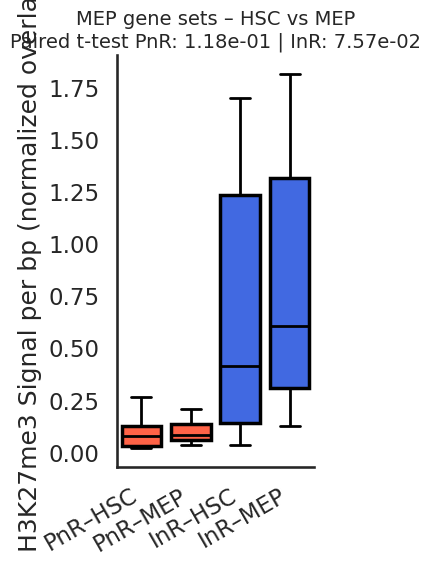

In [73]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pybedtools import BedTool
from scipy.stats import ttest_rel

# --- MEP-specific gene sets ---
MEP_PnR_genes = [
    'DNAJC6', 'STAM', 'SLC18A2', 'PDZD8', 'MICAL2', 'ZBTB16', 'ABCC4', 'RYR3',
    'RANBP10', 'ZFPM1', 'ANKRD27', 'ZEB2', 'SLC24A3', 'CTNNBL1', 'CSF2RB', 'ARMC8',
    'SLC39A8', 'RNF130', 'VKORC1L1', 'ANK1', 'PVT1'
]
MEP_InR_genes = [
    'NNMT', 'ACSM1', 'SLC38A8', 'PABPN1L', 'LINC00868', 'KLF1', 'NFIX', 'TMEM86B',
    'DNAJB8', 'ANK1', 'GATA1'
]

# --- Combine only the MEP-specific genes ---
target_genes = MEP_PnR_genes + MEP_InR_genes

# --- Filter gene intervals ---
gene_intervals = hg38_Gene_List[hg38_Gene_List['gene'].isin(target_genes)].copy()
gene_intervals_bed = BedTool.from_dataframe(gene_intervals.iloc[:, :4])

# --- Function to quantify signal ---
def quantify_signal(bed, lineage_label):
    overlap = gene_intervals_bed.intersect(bed, wao=True)
    df = pd.read_csv(overlap.fn, sep='\t', header=None)
    df.columns = ['chrom', 'start', 'stop', 'gene', 'chrom2', 'start2', 'stop2', 'overlap']
    df['counts'] = (df['overlap'] > 0).astype(int)
    summarized = df.groupby(['chrom', 'start', 'stop', 'gene']).agg({'counts': 'sum'}).reset_index()
    summarized['gene_length'] = summarized['stop'] - summarized['start']
    summarized['norm'] = summarized['counts'] / summarized['gene_length'] * 100
    summarized['analysis'] = summarized['gene'].apply(
        lambda x: 'PnR' if x in MEP_PnR_genes else 'InR'
    )
    summarized['group'] = lineage_label
    summarized['combo'] = summarized['analysis'] + "–" + summarized['group']
    return summarized[['gene', 'norm', 'analysis', 'group', 'combo']]

# --- Quantify and combine ---
hsc_df = quantify_signal(k27me3_hsc_bed, "HSC")
mep_df = quantify_signal(k27me3_mep_bed, "MEP")
combined = pd.concat([hsc_df, mep_df], ignore_index=True)

# --- Paired t-tests ---
def paired_t_test(df, label):
    pivot = df[df['analysis'] == label].pivot(index='gene', columns='group', values='norm').dropna()
    stat, pval = ttest_rel(pivot['HSC'], pivot['MEP'])
    return pval

pnr_pval = paired_t_test(combined, 'PnR')
inr_pval = paired_t_test(combined, 'InR')

# --- Manual Plotting ---
sns.set(style='white', context='talk')

combo_order = [
    "PnR–HSC", "PnR–MEP",
    "InR–HSC", "InR–MEP"
]

combo_colors = {
    "PnR–HSC": "tomato",
    "PnR–MEP": "tomato",
    "InR–HSC": "royalblue",
    "InR–MEP": "royalblue"
}

fig, ax = plt.subplots(figsize=(3.5, 6))
sns.boxplot(
    data=combined,
    x="combo", y="norm",
    order=combo_order,
    linewidth=2.5,
    showfliers=False,
    ax=ax
)

# Set box face colors and black outlines
for i, patch in enumerate(ax.patches):
    label = combo_order[i]
    patch.set_facecolor(combo_colors[label])
    patch.set_edgecolor("black")
    patch.set_linewidth(2.5)

# Set whiskers, medians, caps to black
for line in ax.lines:
    line.set_color("black")
    line.set_linewidth(2)

# Final axis styling
ax.set_ylabel("H3K27me3 Signal per bp (normalized overlap)")
ax.set_xlabel("")
ax.set_title(
    f"MEP gene sets – HSC vs MEP\n"
    f"Paired t-test PnR: {pnr_pval:.2e} | InR: {inr_pval:.2e}",
    fontsize=14
)
ax.set_xticks(range(len(combo_order)))
ax.set_xticklabels(combo_order, rotation=30, ha='right')

# Remove legend if exists
if ax.legend_:
    ax.legend_.remove()

sns.despine()
plt.tight_layout()
plt.savefig("K27me3_HSC_vs_MEP_MEPgenes_PnR_InR.png", dpi=300)
plt.show()


In [75]:
import pandas as pd
from pybedtools import BedTool

# --- Step 1: Load all K4me123 BED files ---
k4me123_files = {
    'Rep1': 'Full_hg38_Aligned_BED_Files/Batch_Beds_K4me123/K4me123_Batch1_Full.bed.gz',
    'Rep2': 'Full_hg38_Aligned_BED_Files/Batch_Beds_K4me123/K4me123_Batch2_Full.bed.gz',
    'Rep3': 'Full_hg38_Aligned_BED_Files/Batch_Beds_K4me123/K4me123_Batch3_Full.bed.gz',
    'Rep4': 'Full_hg38_Aligned_BED_Files/Batch_Beds_K4me123/K4me123_Batch4_Full.bed.gz',
    'Rep5': 'Full_hg38_Aligned_BED_Files/Batch_Beds_K4me123/K4me123_Batch5_Full.bed.gz',
    'Rep6': 'Full_hg38_Aligned_BED_Files/Batch_Beds_K4me123/K4me123_Batch6_Full.bed.gz', 
    'Rep7': 'Full_hg38_Aligned_BED_Files/Batch_Beds_K4me123/K4me123_Batch7_2in1_wCUTAC_Full.bed.gz',
    'Rep8': 'Full_hg38_Aligned_BED_Files/Batch_Beds_K4me123/K4me123_Batch8_2in1_wCUTAC_Full.bed.gz', 
    'Rep9': 'Full_hg38_Aligned_BED_Files/Batch_Beds_K4me123/K4me123_Batch9_2in1_wCUTAC_Full.bed.gz', 
    'Rep10': 'Full_hg38_Aligned_BED_Files/Batch_Beds_K4me123/K4me123_Batch10_Full.bed.gz'
}

# Combine into one dataframe
k4me123_df = pd.concat([
    pd.read_csv(path, sep='\t', header=None) for path in k4me123_files.values()
])
k4me123_df.columns = ['chrom', 'start', 'stop', 'barcode']

# --- Step 2: Load cluster barcode annotations ---
cluster_df = pd.read_csv("K4me123_Cluster_Barcodes.csv", names=['barcode', 'cluster'], header=None)

# Map each cluster name to a set of barcodes
barcode_by_cluster = {
    k: set(cluster_df.loc[cluster_df['cluster'] == k, 'barcode'])
    for k in ['HSC', 'MEP', 'GMP', 'CLP']
}

# --- Step 3: Split BED by cell type ---
k4me123_hsc_bed = BedTool.from_dataframe(k4me123_df[k4me123_df['barcode'].isin(barcode_by_cluster['HSC'])].iloc[:, :3])
k4me123_mep_bed = BedTool.from_dataframe(k4me123_df[k4me123_df['barcode'].isin(barcode_by_cluster['MEP'])].iloc[:, :3])
k4me123_gmp_bed = BedTool.from_dataframe(k4me123_df[k4me123_df['barcode'].isin(barcode_by_cluster['GMP'])].iloc[:, :3])
k4me123_clp_bed = BedTool.from_dataframe(k4me123_df[k4me123_df['barcode'].isin(barcode_by_cluster['CLP'])].iloc[:, :3])


In [76]:
top_CD34_promoters_scaled_ArchR_genes.head(5)

chrom   start    stop       gene  norm_counts
0  chr1   64419   66419      OR4F5    96.666667
1  chr1  816371  818371     FAM87B   483.333333
2  chr1  822138  828138  LINC01128  1916.666667
3  chr1  826522  828522  LINC00115  1841.666667
4  chr1  869201  871201     FAM41C   651.666667

/tmp/ipykernel_121863/408048990.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=combined_df, x='group', y='norm', palette=palette, linewidth=2.5, showfliers=False, ax=ax)


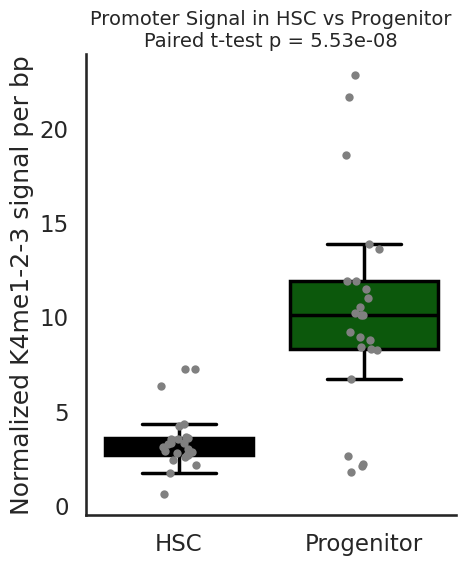

In [127]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from pybedtools import BedTool
from scipy.stats import ttest_rel

# --- Setup ---
gene_sets = {
    "MEP": ['DNAJC6', 'STAM', 'SLC18A2', 'PDZD8', 'MICAL2', 'ZBTB16', 'ABCC4', 'RYR3',
            'RANBP10', 'ZFPM1', 'ANKRD27', 'ZEB2', 'SLC24A3', 'CTNNBL1', 'CSF2RB',
            'ARMC8', 'SLC39A8', 'RNF130', 'VKORC1L1', 'PVT1'],
    "GMP": ["MIR181A1HG", "ARHGEF18", "FNDC3B"],
    "CLP": ["DOCK1"]
}

# --- Load and format promoters ---
promoters = top_CD34_promoters_scaled_ArchR_genes.iloc[:, :4].copy()
promoters.columns = ['chrom', 'start', 'stop', 'gene']

# --- BED file mapping ---
bed_dict = {
    "HSC": k4me123_hsc_bed,
    "MEP": k4me123_mep_bed,
    "GMP": k4me123_gmp_bed,
    "CLP": k4me123_clp_bed
}

# --- Function to get normalized signal per gene ---
def quantify_promoter_signal(genes, bed):
    subset = promoters[promoters['gene'].isin(genes)]
    promoter_bed = BedTool.from_dataframe(subset)
    overlap = promoter_bed.intersect(bed, wao=True)
    df = pd.read_csv(overlap.fn, sep='\t', header=None)
    df.columns = ['chrom', 'start', 'stop', 'gene', 'chrom2', 'start2', 'stop2', 'overlap']
    df['counts'] = (df['overlap'] > 0).astype(int)
    df['gene_length'] = df['stop'] - df['start']
    df['norm'] = df['counts'] / df['gene_length'] * 100
    return df.groupby('gene')['norm'].sum().reset_index()

# --- Collect HSC signal for all genes ---
all_genes = sum(gene_sets.values(), [])  # flatten all gene lists
hsc_df = quantify_promoter_signal(all_genes, bed_dict["HSC"])
hsc_df["group"] = "HSC"

# --- Collect progenitor signal for matching lineage-specific genes ---
prog_dfs = []
for lineage, genes in gene_sets.items():
    df = quantify_promoter_signal(genes, bed_dict[lineage])
    df["group"] = "Progenitor"
    prog_dfs.append(df)

prog_df = pd.concat(prog_dfs, ignore_index=True)

# --- Combine all ---
combined_df = pd.concat([hsc_df, prog_df], ignore_index=True)
K4me123_PnR_Prom_Combined = combined_df.copy()

# --- Paired t-test ---
# Ensure same gene order
paired = pd.merge(hsc_df[['gene', 'norm']], prog_df[['gene', 'norm']], on='gene', suffixes=('_hsc', '_prog'))

# Perform paired t-test
stat, pval = ttest_rel(paired['norm_hsc'], paired['norm_prog'])

# --- Plot ---
sns.set(style='white', context='talk')
palette = {'HSC': 'black', 'Progenitor': 'darkgreen'}

fig, ax = plt.subplots(figsize=(5, 6))
sns.boxplot(data=combined_df, x='group', y='norm', palette=palette, linewidth=2.5, showfliers=False, ax=ax)
sns.stripplot(data=combined_df, x='group', y='norm', color='gray', jitter=True, size=6, ax=ax)

# Style
for patch in ax.patches:
    patch.set_edgecolor('black')
    patch.set_linewidth(2.5)

ax.set_ylabel("Normalized K4me1-2-3 signal per bp")
ax.set_xlabel("")
ax.set_title(f"Promoter Signal in HSC vs Progenitor\nPaired t-test p = {pval:.2e}", fontsize=14)

sns.despine()
plt.tight_layout()
plt.savefig("K4me123_Combined_Lineage_vs_HSC_ttest.png", dpi=300)
plt.show()


In [128]:
# --- Ranked summary of promoter signal per gene ---

# Split into HSC and Progenitor groups
hsc_ranked = combined_df[combined_df['group'] == 'HSC'].copy()
prog_ranked = combined_df[combined_df['group'] == 'Progenitor'].copy()

# Sort from highest to lowest signal
hsc_ranked = hsc_ranked.sort_values(by='norm', ascending=False)
prog_ranked = prog_ranked.sort_values(by='norm', ascending=False)

# Print summaries
print("🖤 Top Promoter-Enriched Genes in HSC:")
print(hsc_ranked[['gene', 'norm']].head(50))

print("\n💚 Top Promoter-Enriched Genes in Progenitor Lineages:")
print(prog_ranked[['gene', 'norm']].head(50))


🖤 Top Promoter-Enriched Genes in HSC:
          gene      norm
23       ZFPM1  7.183333
1      ANKRD27  7.183333
21      ZBTB16  6.283333
11       PDZD8  4.300000
13     RANBP10  4.166667
15        RYR3  3.616667
17     SLC24A3  3.533333
18     SLC39A8  3.516667
14      RNF130  3.500000
2     ARHGEF18  3.300000
22        ZEB2  3.266667
19        STAM  3.233333
12        PVT1  3.050000
7        DOCK1  2.983333
0        ABCC4  2.850000
9       MICAL2  2.816667
3        ARMC8  2.733333
16     SLC18A2  2.666667
5      CTNNBL1  2.633333
6       DNAJC6  2.516667
8       FNDC3B  2.383333
4       CSF2RB  2.100000
20    VKORC1L1  1.683333
10  MIR181A1HG  0.583333

💚 Top Promoter-Enriched Genes in Progenitor Lineages:
          gene       norm
43       ZFPM1  22.816667
25     ANKRD27  21.666667
41      ZBTB16  18.583333
31       PDZD8  13.866667
30      MICAL2  13.566667
33     RANBP10  11.900000
35        RYR3  11.900000
37     SLC24A3  11.483333
32        PVT1  10.966667
38     SLC39A8  10.516

/tmp/ipykernel_121863/1219576447.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=combined_df, x='group', y='norm', palette=palette, linewidth=2.5, showfliers=False, ax=ax)


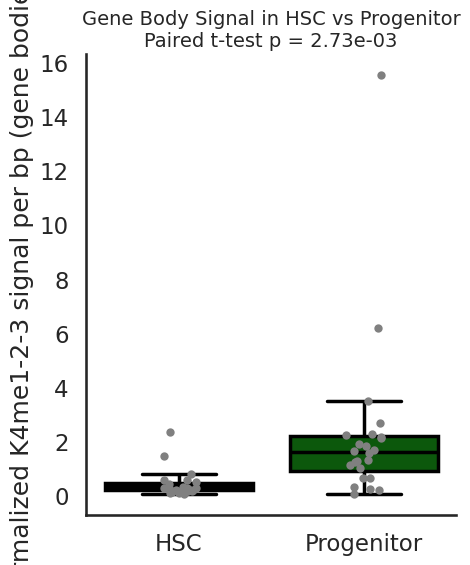

In [129]:
CD34_GBodies_ArchR_genes =  pd.read_csv('CD34_GBodies_ArchR_genes.bed', sep='\t', header=None)

#top_CD34_promoters_scaled_ArchR_genes = pd.read_csv(top_CD34_promoters_scaled_ArchR_genes.fn, sep='\t', header=None)
CD34_GBodies_ArchR_genes.columns = 'chrom', 'start', 'stop', 'gene'

# --- Setup gene sets ---
gene_sets = {
    "MEP": ['DNAJC6', 'STAM', 'SLC18A2', 'PDZD8', 'MICAL2', 'ZBTB16', 'ABCC4', 'RYR3',
            'RANBP10', 'ZFPM1', 'ANKRD27', 'ZEB2', 'SLC24A3', 'CTNNBL1', 'CSF2RB',
            'ARMC8', 'SLC39A8', 'RNF130', 'VKORC1L1', 'PVT1'],
    "GMP": ["MIR181A1HG", "ARHGEF18", "FNDC3B"],
    "CLP": ["DOCK1"]
}

# --- Load and format gene body intervals ---
gbody_df = CD34_GBodies_ArchR_genes.iloc[:, :4].copy()
gbody_df.columns = ['chrom', 'start', 'stop', 'gene']

# --- BED file mapping ---
bed_dict = {
    "HSC": k4me123_hsc_bed,
    "MEP": k4me123_mep_bed,
    "GMP": k4me123_gmp_bed,
    "CLP": k4me123_clp_bed
}

# --- Function to compute normalized signal per gene body ---
def quantify_gbody_signal(genes, bed):
    subset = gbody_df[gbody_df['gene'].isin(genes)]
    gbody_bed = BedTool.from_dataframe(subset)
    overlap = gbody_bed.intersect(bed, wao=True)
    df = pd.read_csv(overlap.fn, sep='\t', header=None)
    df.columns = ['chrom', 'start', 'stop', 'gene', 'chrom2', 'start2', 'stop2', 'overlap']
    df['counts'] = (df['overlap'] > 0).astype(int)
    df['gene_length'] = df['stop'] - df['start']
    df['norm'] = df['counts'] / df['gene_length'] * 100
    return df.groupby('gene')['norm'].sum().reset_index()

# --- Quantify HSC signal across all genes ---
all_genes = sum(gene_sets.values(), [])  # Flatten list
hsc_df = quantify_gbody_signal(all_genes, bed_dict["HSC"])
hsc_df["group"] = "HSC"

# --- Quantify signal in lineage-specific beds for matching gene groups ---
prog_dfs = []
for lineage, genes in gene_sets.items():
    df = quantify_gbody_signal(genes, bed_dict[lineage])
    df["group"] = "Progenitor"
    prog_dfs.append(df)

prog_df = pd.concat(prog_dfs, ignore_index=True)

# --- Combine all ---
combined_df = pd.concat([hsc_df, prog_df], ignore_index=True)


K4me123_PnR_GBody_Combined= combined_df.copy()

# --- Paired t-test ---
# Ensure same gene order
paired = pd.merge(hsc_df[['gene', 'norm']], prog_df[['gene', 'norm']], on='gene', suffixes=('_hsc', '_prog'))

# Perform paired t-test
stat, pval = ttest_rel(paired['norm_hsc'], paired['norm_prog'])


# --- Plotting ---
sns.set(style='white', context='talk')
palette = {'HSC': 'black', 'Progenitor': 'darkgreen'}

fig, ax = plt.subplots(figsize=(5, 6))
sns.boxplot(data=combined_df, x='group', y='norm', palette=palette, linewidth=2.5, showfliers=False, ax=ax)
sns.stripplot(data=combined_df, x='group', y='norm', color='gray', jitter=True, size=6, ax=ax)

# Style
for patch in ax.patches:
    patch.set_edgecolor('black')
    patch.set_linewidth(2.5)

ax.set_ylabel("Normalized K4me1-2-3 signal per bp (gene bodies)")
ax.set_xlabel("")
ax.set_title(f"Gene Body Signal in HSC vs Progenitor\nPaired t-test p = {pval:.2e}", fontsize=14)

sns.despine()
plt.tight_layout()
plt.savefig("K4me123_GBody_Combined_Lineage_vs_HSC.png", dpi=300)
plt.show()


In [130]:
# --- Ranked summary of normalized gene body signal ---

# Split by group
hsc_ranked = combined_df[combined_df['group'] == 'HSC'].copy()
prog_ranked = combined_df[combined_df['group'] == 'Progenitor'].copy()

# Sort from highest to lowest signal
hsc_ranked = hsc_ranked.sort_values(by='norm', ascending=False)
prog_ranked = prog_ranked.sort_values(by='norm', ascending=False)

# Print summaries
print("🖤 Top HSC Genes by Gene Body Signal:")
print(hsc_ranked[['gene', 'norm']].head(50))

print("\n💚 Top Progenitor Genes by Gene Body Signal:")
print(prog_ranked[['gene', 'norm']].head(50))



🖤 Top HSC Genes by Gene Body Signal:
          gene      norm
23       ZFPM1  2.326131
21      ZBTB16  1.448874
22        ZEB2  0.788121
11       PDZD8  0.565775
9       MICAL2  0.563253
19        STAM  0.513357
0        ABCC4  0.431417
12        PVT1  0.315084
8       FNDC3B  0.290134
13     RANBP10  0.288371
16     SLC18A2  0.263337
17     SLC24A3  0.259218
5      CTNNBL1  0.254713
14      RNF130  0.238153
6       DNAJC6  0.219056
18     SLC39A8  0.208567
15        RYR3  0.203751
3        ARMC8  0.192356
7        DOCK1  0.167062
1      ANKRD27  0.162364
20    VKORC1L1  0.108052
10  MIR181A1HG  0.084300
2     ARHGEF18  0.083421
4       CSF2RB  0.063143

💚 Top Progenitor Genes by Gene Body Signal:
          gene       norm
43       ZFPM1  15.501735
41      ZBTB16   6.191903
30      MICAL2   3.487373
42        ZEB2   2.671235
32        PVT1   2.265214
31       PDZD8   2.243995
33     RANBP10   2.171481
36     SLC18A2   2.132178
27      CSF2RB   1.900612
28     CTNNBL1   1.829251
39     

In [131]:
#MEP_Genes
#PnR_genes = ['DNAJC6', 'STAM', 'SLC18A2', 'PDZD8', 'MICAL2', 'ZBTB16', 'ABCC4', 'RYR3',
# 'RANBP10', 'ZFPM1', 'ANKRD27', 'ZEB2', 'SLC24A3', 'CTNNBL1', 'CSF2RB', 'ARMC8',
# 'SLC39A8', 'RNF130', 'VKORC1L1', 'ANK1', 'PVT1']
#InR_genes = []

#GMP_Genes

#PnR_genes = ['MIR181A1HG', 'ARHGEF18', 'FNDC3B']
#InR_genes = ['PTPRE', 'PKD1L2', 'GDF1', 'CERS1', 'TRPM2-AS', 'GPR151', 'CEBPD']

#CLP_Genes

#PnR_genes = ['DOCK1'] #, 'RBM38'
#InR_genes = ['IRF8']

/tmp/ipykernel_121863/3246599312.py:71: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=combined_df, x='group', y='norm', palette=palette, linewidth=2.5, showfliers=False, ax=ax)


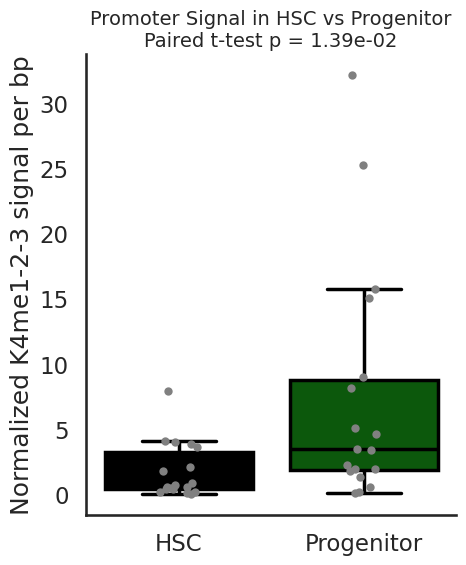

In [132]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
import pandas as pd
from pybedtools import BedTool

# --- Setup ---
gene_sets = {
    "MEP": ['NNMT', 'ACSM1', 'SLC38A8', 'PABPN1L', 'LINC00868', 'KLF1', 'NFIX', 'TMEM86B','DNAJB8', 'GATA1'],
    "GMP": ['PTPRE', 'PKD1L2', 'GDF1', 'CERS1', 'TRPM2-AS', 'GPR151', 'CEBPD'],
    "CLP": ['IRF8']
}

# --- Load and format promoters ---
promoters = top_CD34_promoters_scaled_ArchR_genes.iloc[:, :4].copy()
promoters.columns = ['chrom', 'start', 'stop', 'gene']

# --- BED file mapping ---
bed_dict = {
    "HSC": k4me123_hsc_bed,
    "MEP": k4me123_mep_bed,
    "GMP": k4me123_gmp_bed,
    "CLP": k4me123_clp_bed
}

# --- Function to get normalized signal per gene ---
def quantify_promoter_signal(genes, bed):
    subset = promoters[promoters['gene'].isin(genes)]
    promoter_bed = BedTool.from_dataframe(subset)
    overlap = promoter_bed.intersect(bed, wao=True)
    df = pd.read_csv(overlap.fn, sep='\t', header=None)
    df.columns = ['chrom', 'start', 'stop', 'gene', 'chrom2', 'start2', 'stop2', 'overlap']
    df['counts'] = (df['overlap'] > 0).astype(int)
    df['gene_length'] = df['stop'] - df['start']
    df['norm'] = df['counts'] / df['gene_length'] * 100
    return df.groupby('gene')['norm'].sum().reset_index()

# --- Collect HSC signal for all genes ---
all_genes = sum(gene_sets.values(), [])  # flatten all gene lists
hsc_df = quantify_promoter_signal(all_genes, bed_dict["HSC"])
hsc_df["group"] = "HSC"

# --- Collect progenitor signal for matching lineage-specific genes ---
prog_dfs = []
for lineage, genes in gene_sets.items():
    df = quantify_promoter_signal(genes, bed_dict[lineage])
    df["group"] = "Progenitor"
    prog_dfs.append(df)

prog_df = pd.concat(prog_dfs, ignore_index=True)

# --- Combine all ---
combined_df = pd.concat([hsc_df, prog_df], ignore_index=True)

K4me123_InR_Prom_Combined= combined_df.copy()

# --- Wilcoxon signed-rank test ---
# --- Paired t-test ---
# Ensure same gene order
paired = pd.merge(hsc_df[['gene', 'norm']], prog_df[['gene', 'norm']], on='gene', suffixes=('_hsc', '_prog'))

# Perform paired t-test
stat, pval = ttest_rel(paired['norm_hsc'], paired['norm_prog'])


# --- Plot ---
sns.set(style='white', context='talk')
palette = {'HSC': 'black', 'Progenitor': 'darkgreen'}

fig, ax = plt.subplots(figsize=(5, 6))
sns.boxplot(data=combined_df, x='group', y='norm', palette=palette, linewidth=2.5, showfliers=False, ax=ax)
sns.stripplot(data=combined_df, x='group', y='norm', color='gray', jitter=True, size=6, ax=ax)

# Style
for patch in ax.patches:
    patch.set_edgecolor('black')
    patch.set_linewidth(2.5)

ax.set_ylabel("Normalized K4me1-2-3 signal per bp")
ax.set_xlabel("")
ax.set_title(f"Promoter Signal in HSC vs Progenitor\nPaired t-test p = {pval:.2e}", fontsize=14)

sns.despine()
plt.tight_layout()
plt.savefig("K4me123_Combined_Lineage_vs_HSC.png", dpi=300)
plt.show()


/tmp/ipykernel_121863/2104474314.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=combined_df, x='group', y='norm', palette=palette, linewidth=2.5, showfliers=False, ax=ax)


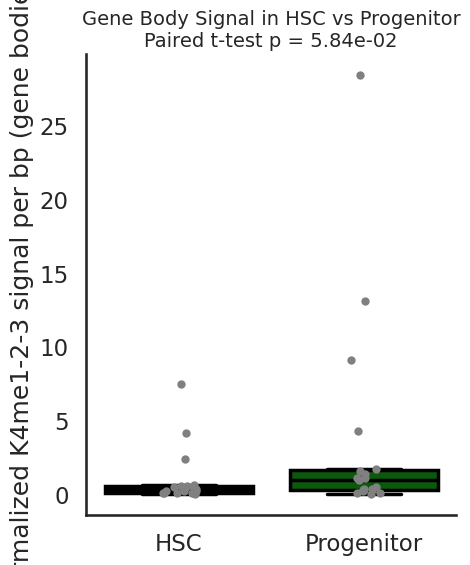

In [133]:
CD34_GBodies_ArchR_genes =  pd.read_csv('CD34_GBodies_ArchR_genes.bed', sep='\t', header=None)

#top_CD34_promoters_scaled_ArchR_genes = pd.read_csv(top_CD34_promoters_scaled_ArchR_genes.fn, sep='\t', header=None)
CD34_GBodies_ArchR_genes.columns = 'chrom', 'start', 'stop', 'gene'

# --- Setup gene sets ---
gene_sets = {
    "MEP": ['NNMT', 'ACSM1', 'SLC38A8', 'PABPN1L', 'LINC00868', 'KLF1', 'NFIX', 'TMEM86B','DNAJB8', 'ANK1', 'GATA1'],
    "GMP": ['PTPRE', 'PKD1L2', 'GDF1', 'CERS1', 'TRPM2-AS', 'GPR151', 'CEBPD'],
    "CLP": ['IRF8']
}

# --- Load and format gene body intervals ---
gbody_df = CD34_GBodies_ArchR_genes.iloc[:, :4].copy()
gbody_df.columns = ['chrom', 'start', 'stop', 'gene']

# --- BED file mapping ---
bed_dict = {
    "HSC": k4me123_hsc_bed,
    "MEP": k4me123_mep_bed,
    "GMP": k4me123_gmp_bed,
    "CLP": k4me123_clp_bed
}

# --- Function to compute normalized signal per gene body ---
def quantify_gbody_signal(genes, bed):
    subset = gbody_df[gbody_df['gene'].isin(genes)]
    gbody_bed = BedTool.from_dataframe(subset)
    overlap = gbody_bed.intersect(bed, wao=True)
    df = pd.read_csv(overlap.fn, sep='\t', header=None)
    df.columns = ['chrom', 'start', 'stop', 'gene', 'chrom2', 'start2', 'stop2', 'overlap']
    df['counts'] = (df['overlap'] > 0).astype(int)
    df['gene_length'] = df['stop'] - df['start']
    df['norm'] = df['counts'] / df['gene_length'] * 100
    return df.groupby('gene')['norm'].sum().reset_index()

# --- Quantify HSC signal across all genes ---
all_genes = sum(gene_sets.values(), [])  # Flatten list
hsc_df = quantify_gbody_signal(all_genes, bed_dict["HSC"])
hsc_df["group"] = "HSC"

# --- Quantify signal in lineage-specific beds for matching gene groups ---
prog_dfs = []
for lineage, genes in gene_sets.items():
    df = quantify_gbody_signal(genes, bed_dict[lineage])
    df["group"] = "Progenitor"
    prog_dfs.append(df)

prog_df = pd.concat(prog_dfs, ignore_index=True)

# --- Combine all ---
combined_df = pd.concat([hsc_df, prog_df], ignore_index=True)

K4me123_InR_GBody_Combined= combined_df.copy()

# --- Paired t-test ---
# Ensure same gene order
paired = pd.merge(hsc_df[['gene', 'norm']], prog_df[['gene', 'norm']], on='gene', suffixes=('_hsc', '_prog'))

# Perform paired t-test
stat, pval = ttest_rel(paired['norm_hsc'], paired['norm_prog'])


# --- Plotting ---
sns.set(style='white', context='talk')
palette = {'HSC': 'black', 'Progenitor': 'darkgreen'}

fig, ax = plt.subplots(figsize=(5, 6))
sns.boxplot(data=combined_df, x='group', y='norm', palette=palette, linewidth=2.5, showfliers=False, ax=ax)
sns.stripplot(data=combined_df, x='group', y='norm', color='gray', jitter=True, size=6, ax=ax)

# Style
for patch in ax.patches:
    patch.set_edgecolor('black')
    patch.set_linewidth(2.5)

ax.set_ylabel("Normalized K4me1-2-3 signal per bp (gene bodies)")
ax.set_xlabel("")
ax.set_title(f"Gene Body Signal in HSC vs Progenitor\nPaired t-test p = {pval:.2e}", fontsize=14)

sns.despine()
plt.tight_layout()
plt.savefig("K4me123_GBody_Combined_Lineage_vs_HSC.png", dpi=300)
plt.show()


In [134]:
# Add labels to each DataFrame
K4me123_PnR_Prom_Combined["analysis"] = "PnR"
K4me123_PnR_Prom_Combined["region"] = "Promoter"

K4me123_PnR_GBody_Combined["analysis"] = "PnR"
K4me123_PnR_GBody_Combined["region"] = "Gene Body"

K4me123_InR_Prom_Combined["analysis"] = "InR"
K4me123_InR_Prom_Combined["region"] = "Promoter"

K4me123_InR_GBody_Combined["analysis"] = "InR"
K4me123_InR_GBody_Combined["region"] = "Gene Body"

# Combine all into one
all_combined = pd.concat([
    K4me123_PnR_Prom_Combined,
    K4me123_PnR_GBody_Combined,
    K4me123_InR_Prom_Combined,
    K4me123_InR_GBody_Combined
], ignore_index=True)


In [135]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style='white', context='talk')

def plot_region_manual(df, region_name, outfile):
    # Create combined category (ensure string type)
    df["analysis"] = df["analysis"].astype(str)
    df["group"] = df["group"].astype(str)
    df["combo"] = df["analysis"] + "–" + df["group"]

    # Desired box order and colors
    combo_order = [
        "PnR–HSC",
        "PnR–Progenitor",
        "InR–HSC",
        "InR–Progenitor"
    ]
    combo_colors = {
        "PnR–HSC": "tomato",
        "PnR–Progenitor": "tomato",
        "InR–HSC": "royalblue",
        "InR–Progenitor": "royalblue"
    }

    fig, ax = plt.subplots(figsize=(3.5, 6))
    sns.boxplot(
        data=df,
        x="combo", y="norm",
        order=combo_order,
        linewidth=2.5,
        showfliers=False,
        ax=ax
    )

    # Manually apply box fill color and black outlines
    for i, patch in enumerate(ax.patches):
        label = combo_order[i]
        patch.set_facecolor(combo_colors[label])
        patch.set_edgecolor("black")
        patch.set_linewidth(2.5)

    # Color whiskers, caps, medians black
    for line in ax.lines:
        line.set_color("black")
        line.set_linewidth(2)

    # Axis styling
    ax.set_ylabel("Normalized K4me1-2-3 signal per bp")
    ax.set_xlabel("")
    ax.set_title(f"{region_name}: HSC vs Progenitor", fontsize=14)

    # Ensure tick labels match
    ax.set_xticks(range(len(combo_order)))
    ax.set_xticklabels(combo_order, rotation=30, ha='right')

    # Remove legend if exists
    if ax.legend_ is not None:
        ax.legend_.remove()

    sns.despine()
    plt.tight_layout()
    plt.savefig(outfile, dpi=300)
    plt.show()


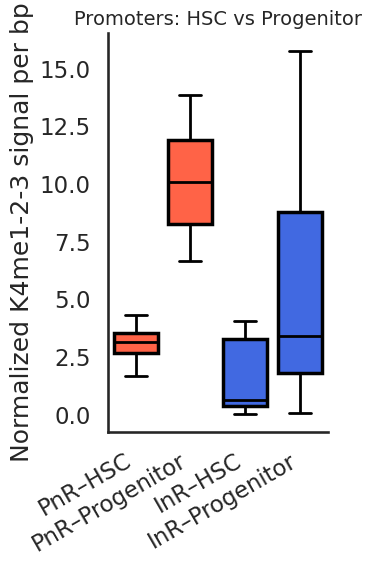

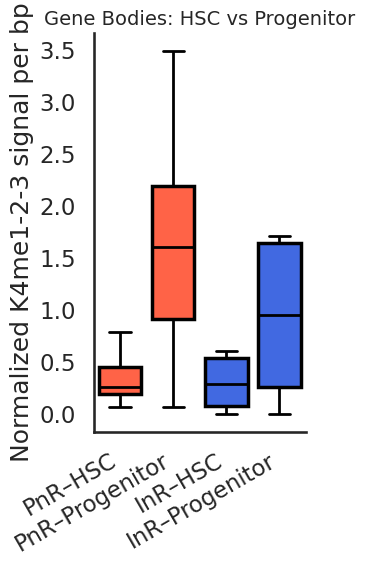

In [139]:
# Promoter
promoter_df = pd.concat([
    K4me123_PnR_Prom_Combined.assign(region="Promoter"),
    K4me123_InR_Prom_Combined.assign(region="Promoter")
], ignore_index=True)
plot_region_manual(promoter_df, "Promoters", "K4me123_Promoters_HSC_vs_Progenitor.png")

# Gene Body
gbody_df = pd.concat([
    K4me123_PnR_GBody_Combined.assign(region="Gene Body"),
    K4me123_InR_GBody_Combined.assign(region="Gene Body")
], ignore_index=True)
plot_region_manual(gbody_df, "Gene Bodies", "K4me123_GeneBodies_HSC_vs_Progenitor.png")


# This section quantifies signal over the Immediate Early Genes

In [222]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from pybedtools import BedTool
from scipy.stats import zscore, ttest_ind
from statsmodels.stats.multitest import multipletests

# ------------------------------
# 1. Define Gene Intervals (IEGs)
# ------------------------------
IEG_Genes = [
    {'chrom': 'chr1', 'start': 58780788, 'stop': 58785327, 'label': 'JUN'},
    {'chrom': 'chr19', 'start': 45466995, 'stop': 45475179, 'label': 'FOSB'},
    {'chrom': 'chr14', 'start': 75277000, 'stop': 75282230, 'label': 'FOS'},
    {'chrom': 'chr5', 'start': 138464000, 'stop': 138475000, 'label': 'EGR1'},
    {'chrom': 'chr19', 'start': 16323817, 'stop': 16327874, 'label': 'KLF2'},
    {'chrom': 'chr1', 'start': 212564334, 'stop': 212620777, 'label': 'ATF3'},
    {'chrom': 'chr12', 'start': 52020832, 'stop': 52059507, 'label': 'NR4A1'},
    {'chrom': 'chr18', 'start': 79385000, 'stop': 79529325, 'label': 'NFATC1'},
    {'chrom': 'chr5', 'start': 172762000, 'stop': 172773000, 'label': 'DUSP1'},
    {'chrom': 'chr5', 'start': 150401637, 'stop': 150413929, 'label': 'CD74'},
    {'chrom': 'chr19', 'start': 1247553, 'stop': 1259140, 'label': 'MIDN'}
]

# ------------------------------
# 2. Format Replicates from Split BEDs
# ------------------------------
def format_split_batches_for_processing(split_batches):
    bed_files_with_names = []
    for rep, groups in split_batches.items():
        for group, df in groups.items():
            bed_path = f"temp_{group}_{rep}.bed"
            df.to_csv(bed_path, sep='\t', header=False, index=False)
            bed_files_with_names.append((group, rep, bed_path))
    return bed_files_with_names

# ------------------------------
# 3. Process Z-scored BED Overlaps
# ------------------------------
def process_datasets_with_zscore(peak_intervals, bed_files_with_names):
    peak_intervals_df = pd.DataFrame(peak_intervals)
    peak_intervals_bed = BedTool.from_dataframe(peak_intervals_df)
    cluster_dataframes = []
    print("Processing bed files...")
    for dataset_label, replicate_label, bed_file in tqdm(bed_files_with_names):
        bed_tool = BedTool(bed_file)
        cluster_count = len(bed_tool)
        overlap = peak_intervals_bed.intersect(bed_tool, wao=True)
        overlap_df = pd.read_csv(overlap.fn, sep='\t', header=None)
        overlap_df.columns = ['chrom', 'start', 'stop', 'label', 'chrom2', 'start2', 'stop2', 'barcode', 'overlap']
        overlap_df['counts'] = (overlap_df['overlap'] > 0).astype(int)
        summarized = overlap_df.groupby(['chrom', 'start', 'stop']).agg({'counts': 'sum'}).reset_index()
        summarized['_norm'] = (summarized['counts'] / cluster_count) * 100000
        summarized['dataset'] = dataset_label
        summarized['replicate'] = replicate_label
        cluster_dataframes.append(summarized[['chrom', 'start', 'stop', '_norm', 'dataset', 'replicate']])
    merged_df = pd.concat(cluster_dataframes, ignore_index=True)
    merged_df['zscore'] = merged_df.groupby(['chrom', 'start', 'stop'])['_norm'].transform(zscore)
    return merged_df

# ------------------------------
# 4. Plotting
# ------------------------------
def plot_boxplot(merged_df, value_column='_norm', output_path=None):
    interval_to_label = {f"{row['chrom']}:{row['start']}-{row['stop']}": row['label'] for row in IEG_Genes}
    melted_df = merged_df.melt(id_vars=['chrom', 'start', 'stop', 'dataset', 'replicate'],
                               value_vars=[value_column], var_name='measure', value_name='norm_value')
    melted_df['interval'] = melted_df.apply(lambda row: f"{row['chrom']}:{row['start']}-{row['stop']}", axis=1)
    melted_df['interval'] = melted_df['interval'].map(interval_to_label)
    melted_df = melted_df.dropna(subset=['interval'])
    interval_order = [gene['label'] for gene in IEG_Genes]
    custom_colors = ["#D51F26", "black"]
    color_palette = {dataset: custom_colors[i % len(custom_colors)] for i, dataset in enumerate(melted_df['dataset'].unique())}
    plt.figure(figsize=(10, 6))
    ax = sns.boxplot(data=melted_df, x='interval', y='norm_value', hue='dataset', showfliers=False,
                     palette=color_palette, linewidth=3.0, order=interval_order)
    for patch in ax.patches:
        patch.set_edgecolor('black')
        patch.set_linewidth(3.0)
    for line in ax.lines:
        line.set_color('black')
        line.set_linewidth(3.0)
    for spine in ax.spines.values():
        spine.set_linewidth(3.0)
    ax.set_ylim(-2, 3.5)
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.xlabel("Gene")
    plt.ylabel(f"{value_column} Value")
    plt.title(f"Comparison of HSC and No_HSC Across Gene Intervals ({value_column})", fontsize=14)
    plt.legend(title="Dataset", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
    plt.tight_layout()
    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        print(f"Boxplot saved to {output_path}")
    else:
        plt.show()

# ------------------------------
# 5. Statistics
# ------------------------------
def run_one_sided_statistical_tests(merged_df, value_column='zscore', output_path=None):
    from scipy.stats import ttest_ind
    from statsmodels.stats.multitest import multipletests

    # Create a mapping from intervals to gene labels
    interval_to_label = {
        f"{row['chrom']}:{row['start']}-{row['stop']}": row['label'] 
        for row in IEG_Genes
    }

    # ✅ Updated comparison pair
    comparison_pairs = [("HSC", "Prog_Cell")]

    stats_results = []

    # Group by genomic interval
    for (chrom, start, stop), interval_df in merged_df.groupby(['chrom', 'start', 'stop']):
        interval_key = f"{chrom}:{start}-{stop}"
        gene_label = interval_to_label.get(interval_key, interval_key)

        for group1_label, group2_label in comparison_pairs:
            group1 = interval_df[interval_df['dataset'] == group1_label][value_column]
            group2 = interval_df[interval_df['dataset'] == group2_label][value_column]

            n1, n2 = len(group1), len(group2)
            if n1 < 2 or n2 < 2:
                continue  # Skip if not enough replicates

            # Perform two-sided t-test
            t_stat, p_value = ttest_ind(group1, group2, nan_policy='omit')

            # One-sided p-value (testing if group1 < group2)
            one_sided_pval = p_value / 2 if t_stat < 0 else 1

            stats_results.append({
                "Gene": gene_label,
                "Comparison": f"{group1_label} vs {group2_label}",
                "N1": n1,
                "N2": n2,
                "t-statistic": t_stat,
                "One-sided p-value": one_sided_pval
            })

    stats_df = pd.DataFrame(stats_results)

    if stats_df.empty:
        print("⚠️ No statistical comparisons could be performed (check dataset names and replicate counts).")
        return stats_df

    # Apply Bonferroni correction
    p_values = stats_df['One-sided p-value'].tolist()
    reject, pvals_corrected, _, _ = multipletests(p_values, method='bonferroni')
    stats_df['Corrected p-value'] = pvals_corrected
    stats_df['Reject Null Hypothesis'] = reject

    # Order results by IEG list
    ordered_labels = [row['label'] for row in IEG_Genes]
    stats_df['Order'] = stats_df['Gene'].apply(lambda x: ordered_labels.index(x) if x in ordered_labels else len(ordered_labels))
    stats_df = stats_df.sort_values('Order').drop(columns=['Order'])

    if output_path:
        stats_df.to_csv(output_path, index=False)
        print(f"✅ Statistical results saved to {output_path}")
    else:
        print(stats_df)

    return stats_df



In [224]:
import pandas as pd

# ------------------------------
# 1. Load the barcode annotation table
# ------------------------------
cluster_barcodes = pd.read_csv("K27me3_Cluster_Barcodes.csv")

# ------------------------------
# 2. Define barcode groups
# ------------------------------
hsc_barcodes = cluster_barcodes.loc[cluster_barcodes["cluster_name"] == "HSC", "barcode"].unique()
prog_cell_barcodes = cluster_barcodes.loc[
    cluster_barcodes["cluster_name"].isin(["LMPP", "MPP", "MEP"]),
    "barcode"
].unique()

# Convert to sets for fast lookup
hsc_barcodes = set(hsc_barcodes)
prog_cell_barcodes = set(prog_cell_barcodes)

# ------------------------------
# 3. Define batch file paths
# ------------------------------
rep1_parts = [
    'Full_hg38_Aligned_BED_Files/Batch_Beds_K27me3/K27me3_Batch1_Full.bed.gz',
    'Full_hg38_Aligned_BED_Files/Batch_Beds_K27me3/K27me3_Batch2_Full.bed.gz',
    'Full_hg38_Aligned_BED_Files/Batch_Beds_K27me3/K27me3_Batch3_Full.bed.gz'
]

other_reps = {
    'Rep2': 'Full_hg38_Aligned_BED_Files/Batch_Beds_K27me3/K27me3_Batch4_2in1_wCUTAC_Full.bed.gz',
    'Rep3': 'Full_hg38_Aligned_BED_Files/Batch_Beds_K27me3/K27me3_Batch7_2in1_wCUTAC_Full.bed.gz',
    'Rep4': 'Full_hg38_Aligned_BED_Files/Batch_Beds_K27me3/K27me3_Batch8_2in1_wCUTAC_Full.bed.gz',
    'Rep5': 'Full_hg38_Aligned_BED_Files/Batch_Beds_K27me3/K27me3_Batch9_2in1_wCUTAC_Full.bed.gz',
    'Rep6': 'Full_hg38_Aligned_BED_Files/Batch_Beds_K27me3/K27me3_Batch10_Full.bed.gz'
}

# ------------------------------
# 4. Function to split a BED dataframe
# ------------------------------
def split_bed_by_barcodes(bed_df, hsc_barcodes, prog_cell_barcodes):
    bed_df.columns = ['chrom', 'start', 'end', 'barcode']
    hsc_df = bed_df[bed_df['barcode'].isin(hsc_barcodes)].copy()
    prog_df = bed_df[bed_df['barcode'].isin(prog_cell_barcodes)].copy()
    return hsc_df, prog_df

# ------------------------------
# 5. Process all batches
# ------------------------------
split_batches = {}

# Rep1 (concatenated from 3 parts)
rep1_df = pd.concat([pd.read_csv(f, sep='\t', header=None, compression='gzip') for f in rep1_parts], ignore_index=True)
hsc, prog = split_bed_by_barcodes(rep1_df, hsc_barcodes, prog_cell_barcodes)
split_batches['Rep1'] = {'HSC': hsc, 'Prog_Cell': prog}

# Other reps
for rep_name, filepath in other_reps.items():
    rep_df = pd.read_csv(filepath, sep='\t', header=None, compression='gzip')
    hsc, prog = split_bed_by_barcodes(rep_df, hsc_barcodes, prog_cell_barcodes)
    split_batches[rep_name] = {'HSC': hsc, 'Prog_Cell': prog}

# ------------------------------
# 6. (Optional) Save or inspect results
# ------------------------------
# Example: check number of reads in Rep2 Prog_Cell
print("Rep2 Prog_Cell reads:", len(split_batches['Rep2']['Prog_Cell']))

# Example: save a file if you want
# split_batches['Rep2']['HSC'].to_csv("Rep2_HSC.bed.gz", sep='\t', header=False, index=False, compression='gzip')


Rep2 Prog_Cell reads: 43191986


In [225]:
K27me3_bed_files_with_names = format_split_batches_for_processing(split_batches)

In [226]:
IEG_K27me3_HSC_Exit_df = process_datasets_with_zscore(IEG_Genes, K27me3_bed_files_with_names)

Processing bed files...


100%|██████████| 12/12 [15:33<00:00, 77.79s/it]


Boxplot saved to IEG_HSC_Exit_K27me3_Boxplot.png


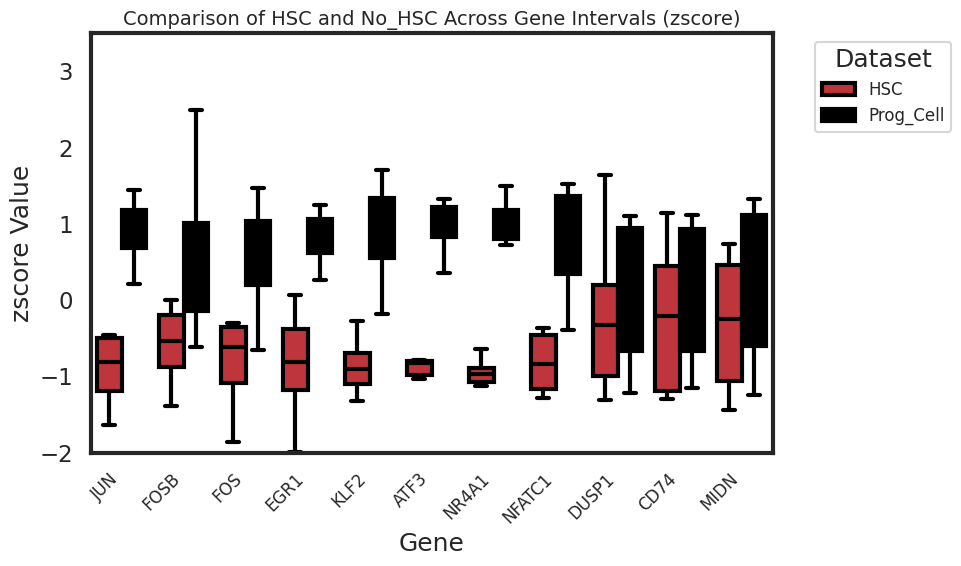

In [227]:
plot_boxplot(
    IEG_K27me3_HSC_Exit_df,
    value_column='zscore',
    output_path="IEG_HSC_Exit_K27me3_Boxplot.png"
)


In [228]:
df_stats = run_one_sided_statistical_tests(
    IEG_K27me3_HSC_Exit_df,
    value_column='zscore',
    output_path="IEG_HSC_Exit_K27me3_Stats.csv"
)
print(df_stats)

✅ Statistical results saved to IEG_HSC_Exit_K27me3_Stats.csv
      Gene        Comparison  N1  N2  t-statistic  One-sided p-value  Corrected p-value  Reject Null Hypothesis
0      JUN  HSC vs Prog_Cell   6   6    -6.729364       2.586315e-05           0.000284                    True
7     FOSB  HSC vs Prog_Cell   6   6    -2.311562       2.169592e-02           0.238655                   False
3      FOS  HSC vs Prog_Cell   6   6    -2.218209       2.542434e-02           0.279668                   False
8     EGR1  HSC vs Prog_Cell   6   6    -5.046389       2.509494e-04           0.002760                    True
6     KLF2  HSC vs Prog_Cell   6   6    -5.427906       1.448756e-04           0.001594                    True
1     ATF3  HSC vs Prog_Cell   6   6   -10.341100       5.839375e-07           0.000006                    True
2    NR4A1  HSC vs Prog_Cell   6   6    -9.389146       1.411854e-06           0.000016                    True
4   NFATC1  HSC vs Prog_Cell   6   6    -4.

In [151]:
import pandas as pd

# ------------------------------
# 1. Load barcode annotations
# ------------------------------
cluster_barcodes = pd.read_csv("K27me3_Cluster_Barcodes.csv")

hsc_barcodes = set(cluster_barcodes.loc[cluster_barcodes["cluster_name"] == "HSC", "barcode"].unique())
prog_cell_barcodes = set(cluster_barcodes.loc[
    cluster_barcodes["cluster_name"].isin(["LMPP", "MPP", "MEP"]), "barcode"
].unique())

# ------------------------------
# 2. Define CUTAC file paths
# ------------------------------
cutac_file_paths = {
    'Rep2': 'Full_hg38_Aligned_BED_Files/Batch_Beds_CUTAC_wSplit_Combined/CUTAC_Batch4_2in1_wK27me3_wSplit_Full.bed.gz',
    'Rep3': 'Full_hg38_Aligned_BED_Files/Batch_Beds_CUTAC_wSplit_Combined/CUTAC_Batch7_2in1_wK27me3_wSplit_Full.bed.gz',
    'Rep4': 'Full_hg38_Aligned_BED_Files/Batch_Beds_CUTAC_wSplit_Combined/CUTAC_Batch8_2in1_wK27me3_wSplit_Full.bed.gz',
    'Rep5': 'Full_hg38_Aligned_BED_Files/Batch_Beds_CUTAC_wSplit_Combined/CUTAC_Batch9_2in1_wK27me3_wSplit_Full.bed.gz'
}

# ------------------------------
# 3. Function to split a BED dataframe
# ------------------------------
def split_bed_by_barcodes(bed_df, hsc_barcodes, prog_cell_barcodes):
    bed_df.columns = ['chrom', 'start', 'end', 'barcode']
    hsc_df = bed_df[bed_df['barcode'].isin(hsc_barcodes)].copy()
    prog_df = bed_df[bed_df['barcode'].isin(prog_cell_barcodes)].copy()
    return hsc_df, prog_df

# ------------------------------
# 4. Load and split each CUTAC batch
# ------------------------------
split_cutac_batches = {}

for rep_name, filepath in cutac_file_paths.items():
    rep_df = pd.read_csv(filepath, sep='\t', header=None, compression='gzip')
    hsc_df, prog_df = split_bed_by_barcodes(rep_df, hsc_barcodes, prog_cell_barcodes)
    split_cutac_batches[rep_name] = {
        'HSC': hsc_df,
        'Prog_Cell': prog_df
    }

# ------------------------------
# 5. (Optional) Inspect or Save Results
# ------------------------------
print("Rep3 HSC CUTAC reads:", len(split_cutac_batches['Rep3']['HSC']))

# Optional: Save results
# split_cutac_batches['Rep3']['HSC'].to_csv("CUTAC_Rep3_HSC.bed.gz", sep='\t', index=False, header=False, compression='gzip')
# split_cutac_batches['Rep3']['Prog_Cell'].to_csv("CUTAC_Rep3_Prog_Cell.bed.gz", sep='\t', index=False, header=False, compression='gzip')


Rep3 HSC CUTAC reads: 446967


In [152]:
cutac_bed_files_with_names = format_split_batches_for_processing(split_cutac_batches)

In [153]:
IEG_CUTAC_HSC_Exit_df = process_datasets_with_zscore(IEG_Genes, cutac_bed_files_with_names)

Processing bed files...


100%|██████████| 8/8 [02:22<00:00, 17.77s/it]


Boxplot saved to IEG_HSC_Exit_CUTAC_Boxplot.png


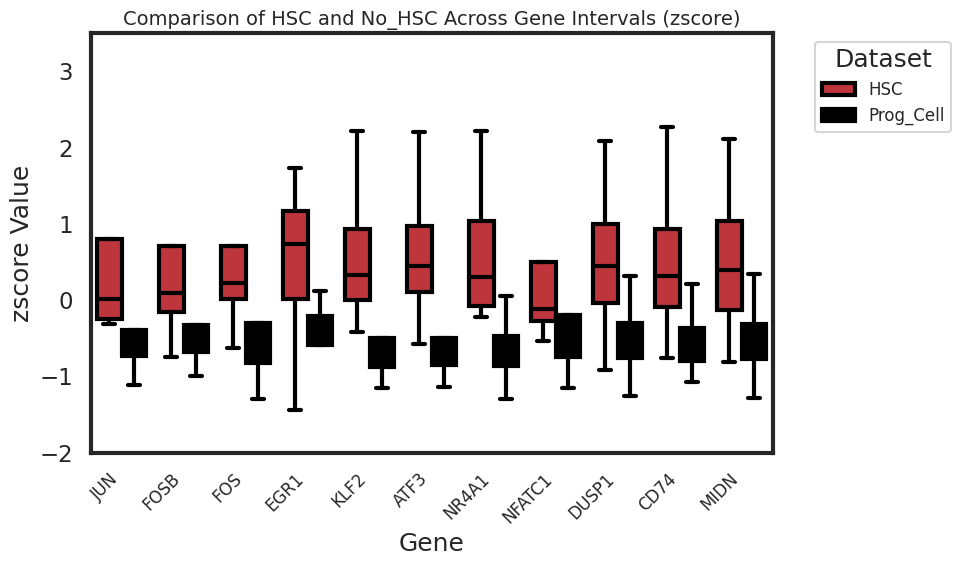

In [172]:
plot_boxplot(
    IEG_CUTAC_HSC_Exit_df,
    value_column='zscore',
    output_path="IEG_HSC_Exit_CUTAC_Boxplot.png"
)


In [201]:
def run_one_sided_hsc_greater_tests(merged_df, value_column='zscore', output_path=None):
    from scipy.stats import ttest_ind
    from statsmodels.stats.multitest import multipletests

    # Define gene interval labels
    IEG_Genes = [
        {'chrom': 'chr1', 'start': 58780788, 'stop': 58785327, 'label': 'JUN'},
        {'chrom': 'chr19', 'start': 45466995, 'stop': 45475179, 'label': 'FOSB'},
        {'chrom': 'chr14', 'start': 75277000, 'stop': 75282230, 'label': 'FOS'},
        {'chrom': 'chr5', 'start': 138464000, 'stop': 138475000, 'label': 'EGR1'},
        {'chrom': 'chr19', 'start': 16323817, 'stop': 16327874, 'label': 'KLF2'},
        {'chrom': 'chr1', 'start': 212564334, 'stop': 212620777, 'label': 'ATF3'},
        {'chrom': 'chr12', 'start': 52020832, 'stop': 52059507, 'label': 'NR4A1'},
        {'chrom': 'chr18', 'start': 79385000, 'stop': 79529325, 'label': 'NFATC1'},
        {'chrom': 'chr5', 'start': 172762000, 'stop': 172773000, 'label': 'DUSP1'},
        {'chrom': 'chr5', 'start': 150401637, 'stop': 150413929, 'label': 'CD74'},
        {'chrom': 'chr19', 'start': 1247553, 'stop': 1259140, 'label': 'MIDN'}
    ]

    # Map interval to gene name
    interval_to_label = {
        f"{row['chrom']}:{row['start']}-{row['stop']}": row['label']
        for row in IEG_Genes
    }

    comparison_pairs = [("HSC", "Prog_Cell")]
    stats_results = []

    # Group and compare
    for (chrom, start, stop), interval_df in merged_df.groupby(['chrom', 'start', 'stop']):
        interval_key = f"{chrom}:{start}-{stop}"
        gene_label = interval_to_label.get(interval_key, interval_key)

        for group1_label, group2_label in comparison_pairs:
            group1 = interval_df[interval_df['dataset'] == group1_label][value_column]
            group2 = interval_df[interval_df['dataset'] == group2_label][value_column]

            n1, n2 = len(group1), len(group2)
            if n1 < 2 or n2 < 2:
                continue

            t_stat, p_value = ttest_ind(group1, group2, nan_policy='omit')

            # One-sided test: HSC > Prog_Cell
            one_sided_pval = p_value / 2 if t_stat > 0 else 1

            stats_results.append({
                "Gene": gene_label,
                "Comparison": f"{group1_label} > {group2_label}",
                "N1": n1,
                "N2": n2,
                "t-statistic": t_stat,
                "One-sided p-value": one_sided_pval
            })

    stats_df = pd.DataFrame(stats_results)

    if stats_df.empty:
        print("⚠️ No statistical comparisons could be performed (check dataset names and replicate counts).")
        return stats_df

    # Bonferroni correction
    p_values = stats_df['One-sided p-value'].tolist()
    reject, pvals_corrected, _, _ = multipletests(p_values, method='bonferroni')
    stats_df['Corrected p-value'] = pvals_corrected
    stats_df['Reject Null Hypothesis'] = reject

    # Sort by gene list
    ordered_labels = [row['label'] for row in IEG_Genes]
    stats_df['Order'] = stats_df['Gene'].apply(lambda x: ordered_labels.index(x) if x in ordered_labels else len(ordered_labels))
    stats_df = stats_df.sort_values('Order').drop(columns=['Order'])

    if output_path:
        stats_df.to_csv(output_path, index=False)
        print(f"✅ Statistical results saved to {output_path}")
    else:
        print(stats_df)

    return stats_df


In [174]:
df_stats_cutac = run_one_sided_hsc_greater_tests(
    IEG_CUTAC_HSC_Exit_df,
    value_column='zscore',
    output_path="IEG_HSC_Exit_CUTAC_Stats.csv"
)
print(df_stats_cutac)

✅ Statistical results saved to IEG_HSC_Exit_CUTAC_Stats.csv
      Gene       Comparison  N1  N2  t-statistic  One-sided p-value  Corrected p-value  Reject Null Hypothesis
0      JUN  HSC > Prog_Cell   4   4     1.545095           0.086639           0.953024                   False
7     FOSB  HSC > Prog_Cell   4   4     1.271963           0.125230           1.000000                   False
3      FOS  HSC > Prog_Cell   4   4     1.415634           0.103317           1.000000                   False
8     EGR1  HSC > Prog_Cell   4   4     1.212406           0.135463           1.000000                   False
6     KLF2  HSC > Prog_Cell   4   4     1.895553           0.053413           0.587546                   False
1     ATF3  HSC > Prog_Cell   4   4     1.994872           0.046543           0.511970                   False
2    NR4A1  HSC > Prog_Cell   4   4     2.108390           0.039775           0.437523                   False
4   NFATC1  HSC > Prog_Cell   4   4     0.905873    

In [233]:
import pandas as pd

# ------------------------------
# 1. Load barcode annotations
# ------------------------------
cluster_barcodes = pd.read_csv("K4me123_Cluster_Barcodes.csv")

hsc_barcodes = set(cluster_barcodes.loc[cluster_barcodes["cluster_name"] == "HSC", "barcode"].unique())
prog_cell_barcodes = set(cluster_barcodes.loc[
    cluster_barcodes["cluster_name"].isin(["LMPP", "MPP", "MEP", "GMP", "CLP"]), "barcode"
].unique())

# ------------------------------
# 2. Load all K4me123 batches
# ------------------------------
batch_paths = {
    'Batch1': 'Full_hg38_Aligned_BED_Files/Batch_Beds_K4me123/K4me123_Batch1_Full.bed.gz',
    'Batch2': 'Full_hg38_Aligned_BED_Files/Batch_Beds_K4me123/K4me123_Batch2_Full.bed.gz',
    'Batch3': 'Full_hg38_Aligned_BED_Files/Batch_Beds_K4me123/K4me123_Batch3_Full.bed.gz',
    'Batch4': 'Full_hg38_Aligned_BED_Files/Batch_Beds_K4me123/K4me123_Batch4_Full.bed.gz',
    'Batch5': 'Full_hg38_Aligned_BED_Files/Batch_Beds_K4me123/K4me123_Batch5_Full.bed.gz',
    'Batch6': 'Full_hg38_Aligned_BED_Files/Batch_Beds_K4me123/K4me123_Batch6_Full.bed.gz',
    'Rep3':  'Full_hg38_Aligned_BED_Files/Batch_Beds_K4me123/K4me123_Batch7_2in1_wCUTAC_Full.bed.gz',
    'Rep4':  'Full_hg38_Aligned_BED_Files/Batch_Beds_K4me123/K4me123_Batch8_2in1_wCUTAC_Full.bed.gz',
    'Rep5':  'Full_hg38_Aligned_BED_Files/Batch_Beds_K4me123/K4me123_Batch9_2in1_wCUTAC_Full.bed.gz',
    'Rep6':  'Full_hg38_Aligned_BED_Files/Batch_Beds_K4me123/K4me123_Batch10_Full.bed.gz',
}

# ------------------------------
# 3. Function to split a BED dataframe
# ------------------------------
def split_bed_by_barcodes(bed_df, hsc_barcodes, prog_cell_barcodes):
    bed_df.columns = ['chrom', 'start', 'end', 'barcode']
    hsc_df = bed_df[bed_df['barcode'].isin(hsc_barcodes)].copy()
    prog_df = bed_df[bed_df['barcode'].isin(prog_cell_barcodes)].copy()
    return hsc_df, prog_df

# ------------------------------
# 4. Load and group batches into reps
# ------------------------------
reps = {}

# Rep1 = Batch1 + Batch2 + Batch3
rep1_df = pd.concat([
    pd.read_csv(batch_paths['Batch1'], sep='\t', header=None, compression='gzip'),
    pd.read_csv(batch_paths['Batch2'], sep='\t', header=None, compression='gzip'),
    pd.read_csv(batch_paths['Batch3'], sep='\t', header=None, compression='gzip'),
], ignore_index=True)
reps['Rep1'] = rep1_df

# Rep2 = Batch4 + Batch5 + Batch6
rep2_df = pd.concat([
    pd.read_csv(batch_paths['Batch4'], sep='\t', header=None, compression='gzip'),
    pd.read_csv(batch_paths['Batch5'], sep='\t', header=None, compression='gzip'),
    pd.read_csv(batch_paths['Batch6'], sep='\t', header=None, compression='gzip'),
], ignore_index=True)
reps['Rep2'] = rep2_df

# Reps 3–6 = single batches
for rep_name in ['Rep3', 'Rep4', 'Rep5', 'Rep6']:
    reps[rep_name] = pd.read_csv(batch_paths[rep_name], sep='\t', header=None, compression='gzip')

# ------------------------------
# 5. Split all reps into HSC and Prog_Cell
# ------------------------------
split_k4me123_batches = {}
for rep_name, df in reps.items():
    hsc_df, prog_df = split_bed_by_barcodes(df, hsc_barcodes, prog_cell_barcodes)
    split_k4me123_batches[rep_name] = {'HSC': hsc_df, 'Prog_Cell': prog_df}

# ------------------------------
# 6. Inspect or Save
# ------------------------------
print("✅ Rep2 Prog_Cell read count:", len(split_k4me123_batches['Rep2']['Prog_Cell']))

# Optional: Save one example to file
# split_k4me123_batches['Rep2']['HSC'].to_csv("K4me123_Rep2_HSC.bed.gz", sep='\t', index=False, header=False, compression='gzip')
# split_k4me123_batches['Rep2']['Prog_Cell'].to_csv("K4me123_Rep2_Prog_Cell.bed.gz", sep='\t', index=False, header=False, compression='gzip')


✅ Rep2 Prog_Cell read count: 53445758


In [234]:
k4me123_bed_files_with_names = format_split_batches_for_processing(split_k4me123_batches)

In [218]:
IEG_K4me123_HSC_Exit_df = process_datasets_with_zscore(IEG_Genes, k4me123_bed_files_with_names)

Processing bed files...


100%|██████████| 12/12 [11:15<00:00, 56.26s/it]


Boxplot saved to IEG_HSC_Exit_K4me123_Boxplot.png


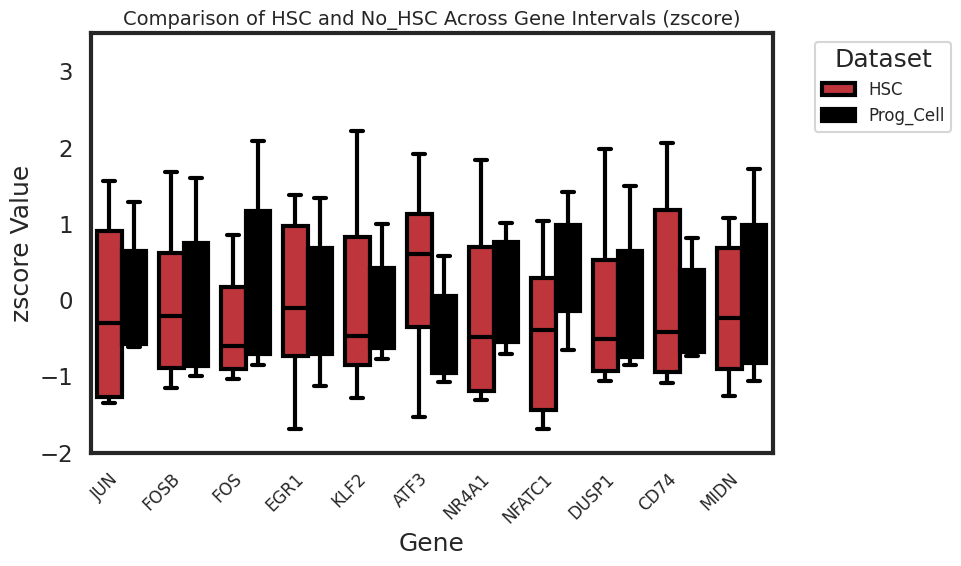

In [219]:
plot_boxplot(
    IEG_K4me123_HSC_Exit_df,
    value_column='zscore',
    output_path="IEG_HSC_Exit_K4me123_Boxplot.png"
)


In [221]:
df_stats_K4me123 = run_one_sided_hsc_greater_tests(
    IEG_K4me123_HSC_Exit_df,
    value_column='zscore',
    output_path="IEG_HSC_Exit_K4me123_Stats.csv"
)
print(df_stats_K4me123)

✅ Statistical results saved to IEG_HSC_Exit_K4me123_Stats.csv
      Gene       Comparison  N1  N2  t-statistic  One-sided p-value  Corrected p-value  Reject Null Hypothesis
0      JUN  HSC > Prog_Cell   6   6    -0.364779           1.000000                1.0                   False
7     FOSB  HSC > Prog_Cell   6   6    -0.058324           1.000000                1.0                   False
3      FOS  HSC > Prog_Cell   6   6    -1.094622           1.000000                1.0                   False
8     EGR1  HSC > Prog_Cell   6   6    -0.072094           1.000000                1.0                   False
6     KLF2  HSC > Prog_Cell   6   6     0.137783           0.446573                1.0                   False
1     ATF3  HSC > Prog_Cell   6   6     1.273665           0.115795                1.0                   False
2    NR4A1  HSC > Prog_Cell   6   6    -0.411953           1.000000                1.0                   False
4   NFATC1  HSC > Prog_Cell   6   6    -1.602500  

## Combine CUTAC with Reps form K27me3 and K4me123

In [196]:
import pandas as pd

# ------------------------------
# 1. Load cluster barcode tables
# ------------------------------
# K27me3 clusters
k27_barcodes = pd.read_csv("K27me3_Cluster_Barcodes.csv")
k27_hsc_barcodes = set(k27_barcodes.loc[k27_barcodes["cluster_name"] == "HSC", "barcode"])
k27_prog_barcodes = set(k27_barcodes.loc[
    k27_barcodes["cluster_name"].isin(["LMPP", "MPP", "MEP"]), "barcode"
])

# K4me123 clusters
k4me_barcodes = pd.read_csv("K4me123_Cluster_Barcodes.csv")
k4me_cluster_dict = {
    k: set(k4me_barcodes.loc[k4me_barcodes["cluster_name"] == k, "barcode"])
    for k in ['HSC', 'LMPP', 'MPP', 'MEP', 'GMP', 'CLP']
}
k4me_hsc_barcodes = k4me_cluster_dict['HSC']
k4me_prog_barcodes = set().union(*[k4me_cluster_dict[k] for k in ['LMPP', 'MPP', 'MEP', 'GMP', 'CLP']])

# ------------------------------
# 2. Define CUTAC file paths
# ------------------------------
k27_cutac_files = {
    'Rep2': 'Full_hg38_Aligned_BED_Files/Batch_Beds_CUTAC_wSplit_Combined/CUTAC_Batch4_2in1_wK27me3_wSplit_Full.bed.gz',
    'Rep3': 'Full_hg38_Aligned_BED_Files/Batch_Beds_CUTAC_wSplit_Combined/CUTAC_Batch7_2in1_wK27me3_wSplit_Full.bed.gz',
    'Rep4': 'Full_hg38_Aligned_BED_Files/Batch_Beds_CUTAC_wSplit_Combined/CUTAC_Batch8_2in1_wK27me3_wSplit_Full.bed.gz',
    'Rep5': 'Full_hg38_Aligned_BED_Files/Batch_Beds_CUTAC_wSplit_Combined/CUTAC_Batch9_2in1_wK27me3_wSplit_Full.bed.gz'
}

k4me_cutac_files = {
    'Rep1': 'Full_hg38_Aligned_BED_Files/Batch_Beds_CUTAC_wSplit_Combined/CUTAC_Batch7_2in1_wK4me123_wSplit_Full.bed.gz',
    'Rep2': 'Full_hg38_Aligned_BED_Files/Batch_Beds_CUTAC_wSplit_Combined/CUTAC_Batch8_2in1_wK4me123_wSplit_Full.bed.gz',
    'Rep3': 'Full_hg38_Aligned_BED_Files/Batch_Beds_CUTAC_wSplit_Combined/CUTAC_Batch9_2in1_wK4me123_wSplit_Full.bed.gz',
}

# ------------------------------
# 3. Define the splitting function
# ------------------------------
def split_bed_by_barcodes(bed_df, hsc_barcodes, prog_barcodes):
    bed_df.columns = ['chrom', 'start', 'end', 'barcode']
    hsc_df = bed_df[bed_df['barcode'].isin(hsc_barcodes)].copy()
    prog_df = bed_df[bed_df['barcode'].isin(prog_barcodes)].copy()
    return hsc_df, prog_df

# ------------------------------
# 4. Load and split all batches
# ------------------------------
split_all_cutac = {
    'K27me3': {},
    'K4me123': {}
}

# Process K27me3 CUTAC
for rep, path in k27_cutac_files.items():
    df = pd.read_csv(path, sep='\t', header=None, compression='gzip')
    hsc_df, prog_df = split_bed_by_barcodes(df, k27_hsc_barcodes, k27_prog_barcodes)
    split_all_cutac['K27me3'][rep] = {'HSC': hsc_df, 'Prog_Cell': prog_df}

# Process K4me123 CUTAC
for rep, path in k4me_cutac_files.items():
    df = pd.read_csv(path, sep='\t', header=None, compression='gzip')
    hsc_df, prog_df = split_bed_by_barcodes(df, k4me_hsc_barcodes, k4me_prog_barcodes)
    split_all_cutac['K4me123'][rep] = {'HSC': hsc_df, 'Prog_Cell': prog_df}

# ------------------------------
# 5. Example: View HSC read count from Rep2 in K27me3
# ------------------------------
print("Rep2 HSC K27me3 reads:", len(split_all_cutac['K27me3']['Rep2']['HSC']))


Rep2 HSC K27me3 reads: 108618


In [4]:
import pandas as pd

# Define paths for selected files
selected_cutac_files = {
    "K27me3_Rep3": "Full_hg38_Aligned_BED_Files/Batch_Beds_CUTAC_wSplit_Combined/CUTAC_Batch7_2in1_wK27me3_wSplit_Full.bed.gz",
    "K27me3_Rep4": "Full_hg38_Aligned_BED_Files/Batch_Beds_CUTAC_wSplit_Combined/CUTAC_Batch8_2in1_wK27me3_wSplit_Full.bed.gz",
    "K4me123_Rep1": "Full_hg38_Aligned_BED_Files/Batch_Beds_CUTAC_wSplit_Combined/CUTAC_Batch7_2in1_wK4me123_wSplit_Full.bed.gz",
    "K4me123_Rep2": "Full_hg38_Aligned_BED_Files/Batch_Beds_CUTAC_wSplit_Combined/CUTAC_Batch8_2in1_wK4me123_wSplit_Full.bed.gz",
}

# Initialize a set to hold all unique barcodes
all_unique_barcodes = set()

# Load each file and extract barcodes
for label, path in selected_cutac_files.items():
    df = pd.read_csv(path, sep='\t', header=None, compression='gzip')
    df.columns = ['chrom', 'start', 'end', 'barcode']
    barcodes = set(df['barcode'].unique())
    all_unique_barcodes.update(barcodes)
    print(f"{label}: {len(barcodes):,} unique barcodes")

# Final total
print(f"\nTotal unique barcodes across selected files: {len(all_unique_barcodes):,}")


K27me3_Rep3: 7,844 unique barcodes
K27me3_Rep4: 7,928 unique barcodes
K4me123_Rep1: 4,283 unique barcodes
K4me123_Rep2: 4,465 unique barcodes

Total unique barcodes across selected files: 24,520


In [5]:
import pandas as pd

# Load the CUTAC cluster barcode file used in ArchR project
cutac_cluster_df = pd.read_csv("CUTAC_Cluster_Barcodes.csv")

# Sanity check: should contain at least 'barcode' and 'cluster_name' columns
assert 'barcode' in cutac_cluster_df.columns, "Missing 'barcode' column in CUTAC_Cluster_Barcodes.csv"
assert 'cluster_name' in cutac_cluster_df.columns, "Missing 'cluster_name' column in CUTAC_Cluster_Barcodes.csv"

# Extract unique barcodes
cutac_cluster_barcodes = set(cutac_cluster_df['barcode'].unique())

# Output how many there are
print(f"Total unique barcodes in CUTAC_Cluster_Barcodes.csv: {len(cutac_cluster_barcodes):,}")


Total unique barcodes in CUTAC_Cluster_Barcodes.csv: 33,638


In [6]:
# For example, compare overlap with the previous set from CUTAC .bed.gz files
intersection = all_unique_barcodes & cutac_cluster_barcodes
only_in_cluster = cutac_cluster_barcodes - all_unique_barcodes
only_in_bedfiles = all_unique_barcodes - cutac_cluster_barcodes

print(f"Barcodes in both .bed.gz and CUTAC_Cluster_Barcodes.csv: {len(intersection):,}")
print(f"Barcodes only in CUTAC_Cluster_Barcodes.csv: {len(only_in_cluster):,}")
print(f"Barcodes only in .bed.gz files: {len(only_in_bedfiles):,}")


Barcodes in both .bed.gz and CUTAC_Cluster_Barcodes.csv: 11,809
Barcodes only in CUTAC_Cluster_Barcodes.csv: 21,829
Barcodes only in .bed.gz files: 12,711


In [3]:
# Define paths for selected files
selected_cutac_files = {
    'Rep1': 'Full_hg38_Aligned_BED_Files/Batch_Beds_K27me3/K27me3_Batch7_2in1_wCUTAC_Full.bed.gz',
    'Rep2': 'Full_hg38_Aligned_BED_Files/Batch_Beds_K27me3/K27me3_Batch8_2in1_wCUTAC_Full.bed.gz',
    'Rep3':  'Full_hg38_Aligned_BED_Files/Batch_Beds_K4me123/K4me123_Batch7_2in1_wCUTAC_Full.bed.gz',
    'Rep4':  'Full_hg38_Aligned_BED_Files/Batch_Beds_K4me123/K4me123_Batch8_2in1_wCUTAC_Full.bed.gz',
}

# Initialize a set to hold all unique barcodes
all_unique_barcodes = set()

# Load each file and extract barcodes
for label, path in selected_cutac_files.items():
    df = pd.read_csv(path, sep='\t', header=None, compression='gzip')
    df.columns = ['chrom', 'start', 'end', 'barcode']
    barcodes = set(df['barcode'].unique())
    all_unique_barcodes.update(barcodes)
    print(f"{label}: {len(barcodes):,} unique barcodes")

# Final total
print(f"\nTotal unique barcodes across selected files: {len(all_unique_barcodes):,}")

Rep1: 19,630 unique barcodes
Rep2: 19,428 unique barcodes
Rep3: 16,491 unique barcodes
Rep4: 16,820 unique barcodes

Total unique barcodes across selected files: 72,369


In [198]:
renamed_k27 = {f'K27_{k}': v for k, v in split_all_cutac['K27me3'].items()}
renamed_k4 = {f'K4_{k}': v for k, v in split_all_cutac['K4me123'].items()}
split_cutac_batches = {**renamed_k27, **renamed_k4}


In [199]:
cutac_bed_files_with_names = format_split_batches_for_processing(split_cutac_batches)


In [200]:
IEG_CUTAC_HSC_Exit_df = process_datasets_with_zscore(IEG_Genes, cutac_bed_files_with_names)


Processing bed files...


100%|██████████| 14/14 [03:57<00:00, 16.95s/it]


Boxplot saved to IEG_HSC_Exit_CUTAC_Boxplot.png


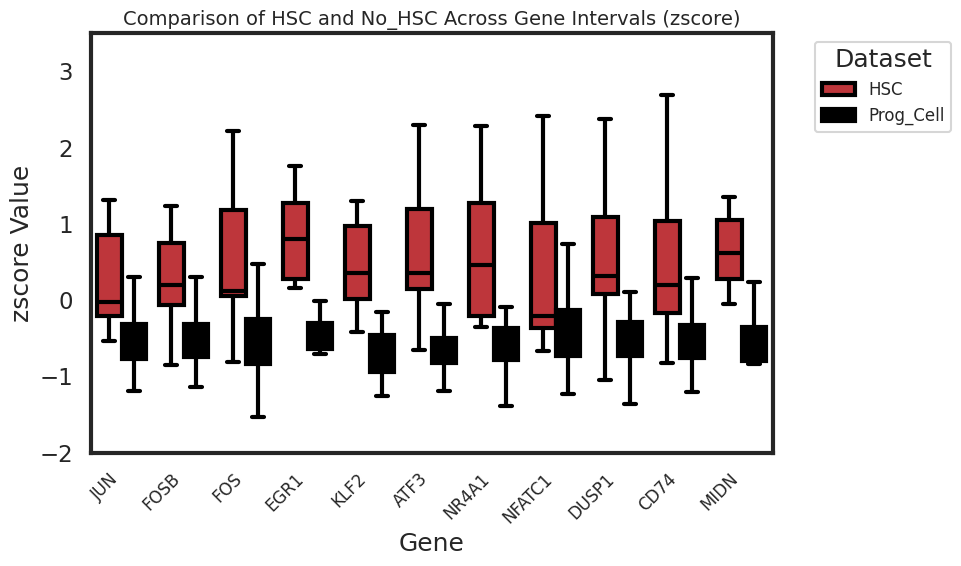

In [202]:
plot_boxplot(
    IEG_CUTAC_HSC_Exit_df,
    value_column='zscore',
    output_path="IEG_HSC_Exit_CUTAC_Boxplot.png"
)


In [203]:
df_stats_CUTAC = run_one_sided_hsc_greater_tests(
    IEG_CUTAC_HSC_Exit_df,
    value_column='zscore',
    output_path="IEG_HSC_Exit_CUTAC_Stats.csv"
)
print(df_stats_CUTAC)

✅ Statistical results saved to IEG_HSC_Exit_CUTAC_Stats.csv
      Gene       Comparison  N1  N2  t-statistic  One-sided p-value  Corrected p-value  Reject Null Hypothesis
0      JUN  HSC > Prog_Cell   7   7     2.104280           0.028555           0.314101                   False
7     FOSB  HSC > Prog_Cell   7   7     2.075164           0.030068           0.330747                   False
3      FOS  HSC > Prog_Cell   7   7     2.409607           0.016468           0.181150                   False
8     EGR1  HSC > Prog_Cell   7   7     2.354085           0.018221           0.200426                   False
6     KLF2  HSC > Prog_Cell   7   7     2.913635           0.006497           0.071462                   False
1     ATF3  HSC > Prog_Cell   7   7     3.118105           0.004443           0.048873                    True
2    NR4A1  HSC > Prog_Cell   7   7     2.937370           0.006216           0.068379                   False
4   NFATC1  HSC > Prog_Cell   7   7     1.527332    

# RUN with IEGs that define Type II HSCs in Zeng et al. Identification of human hematopoietic stem cell subset

In [215]:
# ------------------------------
# 1. Define Gene Intervals (IEGs)
# ------------------------------
IEG_Genes_2 = [
    {'chrom': 'chr19', 'start': 12788270, 'stop': 12795139, 'label': 'JUNB'},
    {'chrom': 'chr19', 'start': 18277387, 'stop': 18283295, 'label': 'JUND'},
    {'chrom': 'chr22', 'start': 38200637, 'stop': 38217261, 'label': 'MAFF'},
    {'chrom': 'chr11', 'start': 65889866, 'stop': 65901361, 'label': 'FOSL1'},
    {'chrom': 'chr2', 'start': 28390858, 'stop': 28419317, 'label': 'FOSL2'},
    {'chrom': 'chr4', 'start': 102499359, 'stop': 102619302, 'label': 'NFKB1'},
    {'chrom': 'chr2', 'start': 60879574, 'stop': 60933612, 'label': 'REL'},
    {'chrom': 'chr5', 'start': 143275934, 'stop': 143405686, 'label': 'NR3C1'},
    {'chrom': 'chr15', 'start': 67063602, 'stop': 67197169, 'label': 'SMAD3'}]


In [216]:
IEG_CUTAC_HSC_Exit_df_2 = process_datasets_with_zscore(IEG_Genes_2, cutac_bed_files_with_names)

Processing bed files...


100%|██████████| 14/14 [03:55<00:00, 16.83s/it]


In [217]:
def plot_boxplot_2(merged_df, value_column='_norm', output_path=None):
    interval_to_label = {f"{row['chrom']}:{row['start']}-{row['stop']}": row['label'] for row in IEG_Genes_2}
    melted_df = merged_df.melt(id_vars=['chrom', 'start', 'stop', 'dataset', 'replicate'],
                               value_vars=[value_column], var_name='measure', value_name='norm_value')
    melted_df['interval'] = melted_df.apply(lambda row: f"{row['chrom']}:{row['start']}-{row['stop']}", axis=1)
    melted_df['interval'] = melted_df['interval'].map(interval_to_label)
    melted_df = melted_df.dropna(subset=['interval'])
    interval_order = [gene['label'] for gene in IEG_Genes_2]
    custom_colors = ["#D51F26", "black"]
    color_palette = {dataset: custom_colors[i % len(custom_colors)] for i, dataset in enumerate(melted_df['dataset'].unique())}
    plt.figure(figsize=(10, 6))
    ax = sns.boxplot(data=melted_df, x='interval', y='norm_value', hue='dataset', showfliers=False,
                     palette=color_palette, linewidth=3.0, order=interval_order)
    for patch in ax.patches:
        patch.set_edgecolor('black')
        patch.set_linewidth(3.0)
    for line in ax.lines:
        line.set_color('black')
        line.set_linewidth(3.0)
    for spine in ax.spines.values():
        spine.set_linewidth(3.0)
    ax.set_ylim(-2, 3.5)
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.xlabel("Gene")
    plt.ylabel(f"{value_column} Value")
    plt.title(f"Comparison of HSC and No_HSC Across Gene Intervals ({value_column})", fontsize=14)
    plt.legend(title="Dataset", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
    plt.tight_layout()
    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        print(f"Boxplot saved to {output_path}")
    else:
        plt.show()

def run_one_sided_hsc_greater_tests_2(merged_df, value_column='zscore', output_path=None):
    from scipy.stats import ttest_ind
    from statsmodels.stats.multitest import multipletests

    # Define gene interval labels
    IEG_Genes_2 = [
    {'chrom': 'chr19', 'start': 12788270, 'stop': 12795139, 'label': 'JUNB'},
    {'chrom': 'chr19', 'start': 18277387, 'stop': 18283295, 'label': 'JUND'},
    {'chrom': 'chr22', 'start': 38200637, 'stop': 38217261, 'label': 'MAFF'},
    {'chrom': 'chr11', 'start': 65889866, 'stop': 65901361, 'label': 'FOSL1'},
    {'chrom': 'chr2', 'start': 28390858, 'stop': 28419317, 'label': 'FOSL2'},
    {'chrom': 'chr4', 'start': 102499359, 'stop': 102619302, 'label': 'NFKB1'},
    {'chrom': 'chr2', 'start': 60879574, 'stop': 60933612, 'label': 'REL'},
    {'chrom': 'chr5', 'start': 143275934, 'stop': 143405686, 'label': 'NR3C1'},
    {'chrom': 'chr15', 'start': 67063602, 'stop': 67197169, 'label': 'SMAD3'}]

    # Map interval to gene name
    interval_to_label = {
        f"{row['chrom']}:{row['start']}-{row['stop']}": row['label']
        for row in IEG_Genes_2
    }

    comparison_pairs = [("HSC", "Prog_Cell")]
    stats_results = []

    # Group and compare
    for (chrom, start, stop), interval_df in merged_df.groupby(['chrom', 'start', 'stop']):
        interval_key = f"{chrom}:{start}-{stop}"
        gene_label = interval_to_label.get(interval_key, interval_key)

        for group1_label, group2_label in comparison_pairs:
            group1 = interval_df[interval_df['dataset'] == group1_label][value_column]
            group2 = interval_df[interval_df['dataset'] == group2_label][value_column]

            n1, n2 = len(group1), len(group2)
            if n1 < 2 or n2 < 2:
                continue

            t_stat, p_value = ttest_ind(group1, group2, nan_policy='omit')

            # One-sided test: HSC > Prog_Cell
            one_sided_pval = p_value / 2 if t_stat > 0 else 1

            stats_results.append({
                "Gene": gene_label,
                "Comparison": f"{group1_label} > {group2_label}",
                "N1": n1,
                "N2": n2,
                "t-statistic": t_stat,
                "One-sided p-value": one_sided_pval
            })

    stats_df = pd.DataFrame(stats_results)

    if stats_df.empty:
        print("⚠️ No statistical comparisons could be performed (check dataset names and replicate counts).")
        return stats_df

    # Bonferroni correction
    p_values = stats_df['One-sided p-value'].tolist()
    reject, pvals_corrected, _, _ = multipletests(p_values, method='bonferroni')
    stats_df['Corrected p-value'] = pvals_corrected
    stats_df['Reject Null Hypothesis'] = reject

    # Sort by gene list
    ordered_labels = [row['label'] for row in IEG_Genes_2]
    stats_df['Order'] = stats_df['Gene'].apply(lambda x: ordered_labels.index(x) if x in ordered_labels else len(ordered_labels))
    stats_df = stats_df.sort_values('Order').drop(columns=['Order'])

    if output_path:
        stats_df.to_csv(output_path, index=False)
        print(f"✅ Statistical results saved to {output_path}")
    else:
        print(stats_df)

    return stats_df


Boxplot saved to IEG_2_HSC_Exit_CUTAC_Boxplot.png


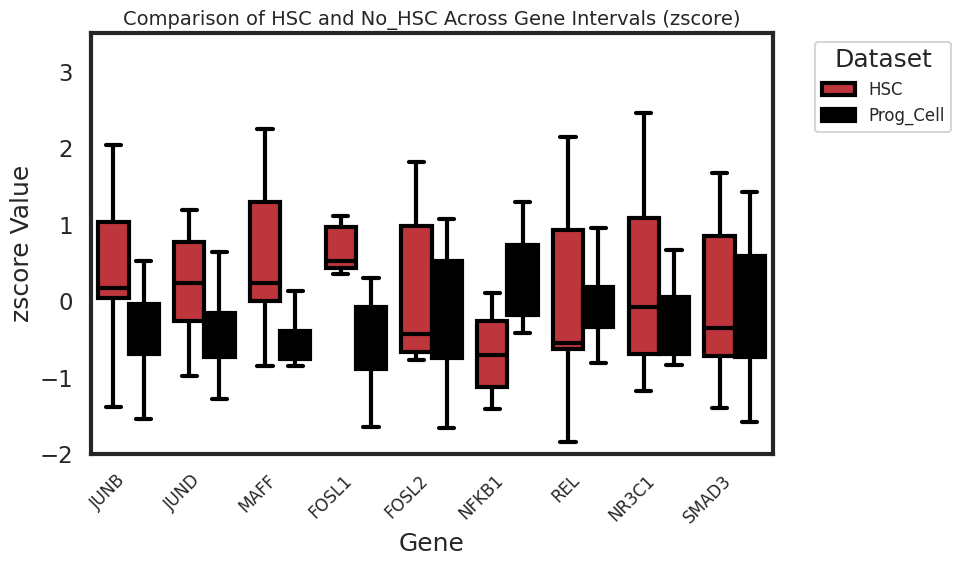

In [220]:
plot_boxplot_2(
    IEG_CUTAC_HSC_Exit_df_2,
    value_column='zscore',
    output_path="IEG_2_HSC_Exit_CUTAC_Boxplot.png"
)


In [221]:
df_stats_CUTAC = run_one_sided_hsc_greater_tests_2(
    IEG_CUTAC_HSC_Exit_df_2,
    value_column='zscore',
    output_path="IEG_2_HSC_Exit_CUTAC_Stats.csv"
)
print(df_stats_CUTAC)

✅ Statistical results saved to IEG_2_HSC_Exit_CUTAC_Stats.csv
    Gene       Comparison  N1  N2  t-statistic  One-sided p-value  Corrected p-value  Reject Null Hypothesis
2   JUNB  HSC > Prog_Cell   7   7     1.631733           0.064341           0.579073                   False
3   JUND  HSC > Prog_Cell   7   7     1.654618           0.061951           0.557556                   False
6   MAFF  HSC > Prog_Cell   7   7     2.626239           0.011064           0.099579                   False
0  FOSL1  HSC > Prog_Cell   7   7     2.394371           0.016932           0.152390                   False
4  FOSL2  HSC > Prog_Cell   7   7     0.620063           0.273405           1.000000                   False
7  NFKB1  HSC > Prog_Cell   7   7    -1.406045           1.000000           1.000000                   False
5    REL  HSC > Prog_Cell   7   7     0.173695           0.432500           1.000000                   False
8  NR3C1  HSC > Prog_Cell   7   7     1.021711           0.163537 

In [235]:
IEG_K4me123_HSC_Exit_df_2 = process_datasets_with_zscore(IEG_Genes_2, k4me123_bed_files_with_names)

Processing bed files...


100%|██████████| 12/12 [11:21<00:00, 56.82s/it]


Boxplot saved to IEG_2_HSC_Exit_K4me123_Boxplot.png


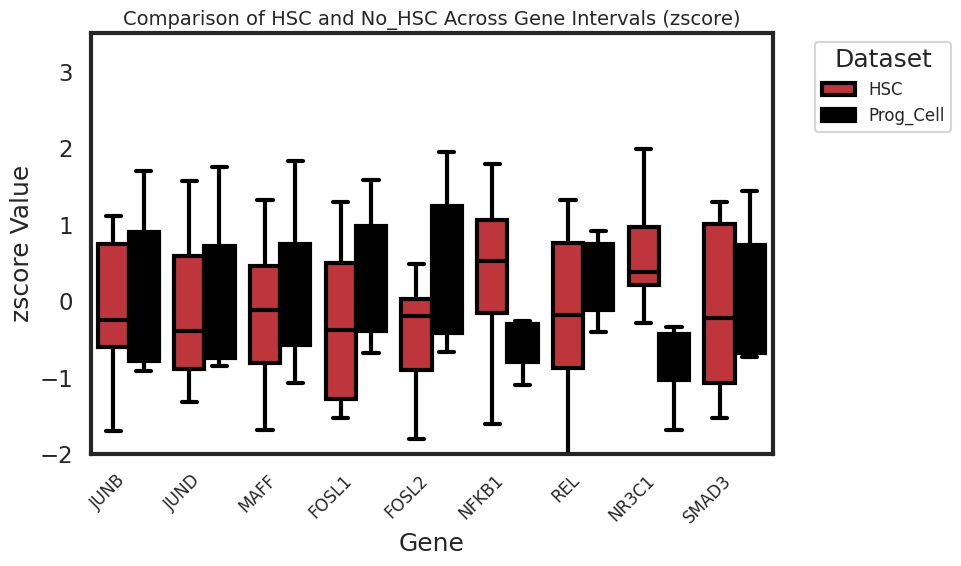

In [236]:
plot_boxplot_2(
    IEG_K4me123_HSC_Exit_df_2,
    value_column='zscore',
    output_path="IEG_2_HSC_Exit_K4me123_Boxplot.png"
)


In [237]:
df_stats_K4me123 = run_one_sided_hsc_greater_tests_2(
    IEG_K4me123_HSC_Exit_df_2,
    value_column='zscore',
    output_path="IEG_2_HSC_Exit_K4me123_Stats.csv"
)
print(df_stats_K4me123)

✅ Statistical results saved to IEG_2_HSC_Exit_K4me123_Stats.csv
    Gene       Comparison  N1  N2  t-statistic  One-sided p-value  Corrected p-value  Reject Null Hypothesis
2   JUNB  HSC > Prog_Cell   6   6    -0.382810           1.000000           1.000000                   False
3   JUND  HSC > Prog_Cell   6   6    -0.348612           1.000000           1.000000                   False
6   MAFF  HSC > Prog_Cell   6   6    -0.521145           1.000000           1.000000                   False
0  FOSL1  HSC > Prog_Cell   6   6    -0.980783           1.000000           1.000000                   False
4  FOSL2  HSC > Prog_Cell   6   6    -1.629543           1.000000           1.000000                   False
7  NFKB1  HSC > Prog_Cell   6   6     1.183600           0.131972           1.000000                   False
5    REL  HSC > Prog_Cell   6   6    -0.844669           1.000000           1.000000                   False
8  NR3C1  HSC > Prog_Cell   6   6     2.569172           0.01396

In [229]:
IEG_K27me3_HSC_Exit_df_2 = process_datasets_with_zscore(IEG_Genes_2, K27me3_bed_files_with_names)

Processing bed files...


100%|██████████| 12/12 [15:38<00:00, 78.24s/it]


Boxplot saved to IEG_2_HSC_Exit_K27me3_Boxplot.png


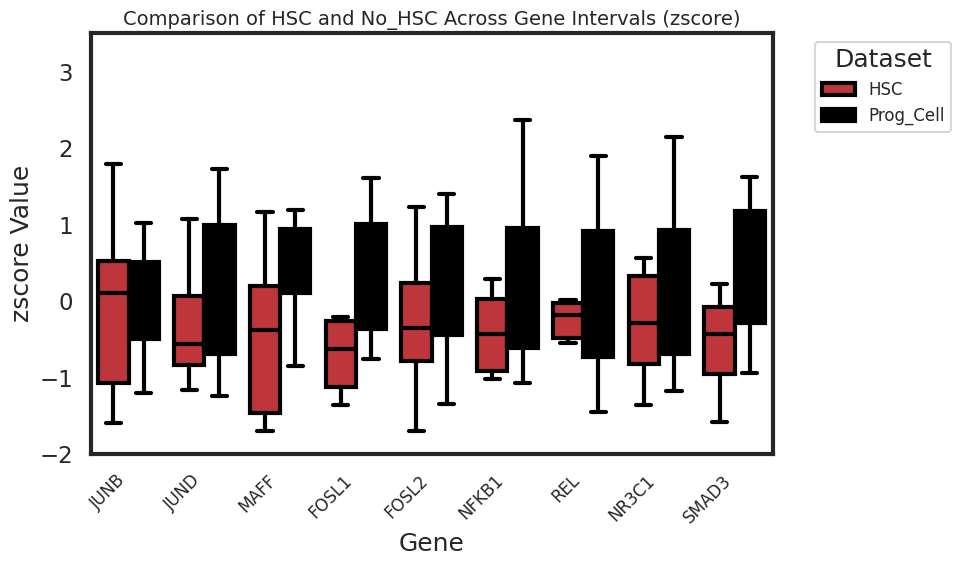

In [231]:
plot_boxplot_2(
    IEG_K27me3_HSC_Exit_df_2,
    value_column='zscore',
    output_path="IEG_2_HSC_Exit_K27me3_Boxplot.png"
)

In [238]:
# ------------------------------
# 5. Statistics
# ------------------------------
def run_one_sided_statistical_tests_2(merged_df, value_column='zscore', output_path=None):
    from scipy.stats import ttest_ind
    from statsmodels.stats.multitest import multipletests
    
    # Define gene interval labels
    IEG_Genes_2 = [
    {'chrom': 'chr19', 'start': 12788270, 'stop': 12795139, 'label': 'JUNB'},
    {'chrom': 'chr19', 'start': 18277387, 'stop': 18283295, 'label': 'JUND'},
    {'chrom': 'chr22', 'start': 38200637, 'stop': 38217261, 'label': 'MAFF'},
    {'chrom': 'chr11', 'start': 65889866, 'stop': 65901361, 'label': 'FOSL1'},
    {'chrom': 'chr2', 'start': 28390858, 'stop': 28419317, 'label': 'FOSL2'},
    {'chrom': 'chr4', 'start': 102499359, 'stop': 102619302, 'label': 'NFKB1'},
    {'chrom': 'chr2', 'start': 60879574, 'stop': 60933612, 'label': 'REL'},
    {'chrom': 'chr5', 'start': 143275934, 'stop': 143405686, 'label': 'NR3C1'},
    {'chrom': 'chr15', 'start': 67063602, 'stop': 67197169, 'label': 'SMAD3'}]

    # Map interval to gene name
    interval_to_label = {
        f"{row['chrom']}:{row['start']}-{row['stop']}": row['label']
        for row in IEG_Genes_2
    }

    comparison_pairs = [("HSC", "Prog_Cell")]
    stats_results = []

    # ✅ Updated comparison pair
    comparison_pairs = [("HSC", "Prog_Cell")]

    stats_results = []

    # Group by genomic interval
    for (chrom, start, stop), interval_df in merged_df.groupby(['chrom', 'start', 'stop']):
        interval_key = f"{chrom}:{start}-{stop}"
        gene_label = interval_to_label.get(interval_key, interval_key)

        for group1_label, group2_label in comparison_pairs:
            group1 = interval_df[interval_df['dataset'] == group1_label][value_column]
            group2 = interval_df[interval_df['dataset'] == group2_label][value_column]

            n1, n2 = len(group1), len(group2)
            if n1 < 2 or n2 < 2:
                continue  # Skip if not enough replicates

            # Perform two-sided t-test
            t_stat, p_value = ttest_ind(group1, group2, nan_policy='omit')

            # One-sided p-value (testing if group1 < group2)
            one_sided_pval = p_value / 2 if t_stat < 0 else 1

            stats_results.append({
                "Gene": gene_label,
                "Comparison": f"{group1_label} vs {group2_label}",
                "N1": n1,
                "N2": n2,
                "t-statistic": t_stat,
                "One-sided p-value": one_sided_pval
            })

    stats_df = pd.DataFrame(stats_results)

    if stats_df.empty:
        print("⚠️ No statistical comparisons could be performed (check dataset names and replicate counts).")
        return stats_df

    # Apply Bonferroni correction
    p_values = stats_df['One-sided p-value'].tolist()
    reject, pvals_corrected, _, _ = multipletests(p_values, method='bonferroni')
    stats_df['Corrected p-value'] = pvals_corrected
    stats_df['Reject Null Hypothesis'] = reject

    # Order results by IEG list
    ordered_labels = [row['label'] for row in IEG_Genes_2]
    stats_df['Order'] = stats_df['Gene'].apply(lambda x: ordered_labels.index(x) if x in ordered_labels else len(ordered_labels))
    stats_df = stats_df.sort_values('Order').drop(columns=['Order'])

    if output_path:
        stats_df.to_csv(output_path, index=False)
        print(f"✅ Statistical results saved to {output_path}")
    else:
        print(stats_df)

    return stats_df

In [239]:
df_stats_K27me3_2 = run_one_sided_statistical_tests_2(
    IEG_K27me3_HSC_Exit_df_2,
    value_column='zscore',
    output_path="IEG_2_HSC_Exit_K27me3_Stats.csv"
)
print(df_stats_K27me3_2)

✅ Statistical results saved to IEG_2_HSC_Exit_K27me3_Stats.csv
    Gene        Comparison  N1  N2  t-statistic  One-sided p-value  Corrected p-value  Reject Null Hypothesis
2   JUNB  HSC vs Prog_Cell   6   6    -0.201575           0.422145           1.000000                   False
3   JUND  HSC vs Prog_Cell   6   6    -1.025913           0.164554           1.000000                   False
6   MAFF  HSC vs Prog_Cell   6   6    -1.610316           0.069203           0.622829                   False
0  FOSL1  HSC vs Prog_Cell   6   6    -1.653568           0.064610           0.581489                   False
4  FOSL2  HSC vs Prog_Cell   6   6    -0.901162           0.194345           1.000000                   False
7  NFKB1  HSC vs Prog_Cell   6   6    -1.431031           0.091460           0.823143                   False
5    REL  HSC vs Prog_Cell   6   6    -0.918137           0.190080           1.000000                   False
8  NR3C1  HSC vs Prog_Cell   6   6    -1.012382          

In [ ]:
Top_HSC_II_Regulators: 'JUNB', 'JUND', 'MAFF', 'KLF2', 'FOS', 'FOSB', 'FOSL1', 'FOSL2', 'NFKB1', 'REL', 'NR3C1', 'SMAD3'
IEGs_GCSF_Mobilized_HSCs:  'JUN', 'FOSB', 'FOS', 'EGR1', 'KLF2', 'ATF3', 'NR4A1', 'NFATC1', 'DUSP1', 'CD74','MIDN', 'MAFF', 'FOSL1'


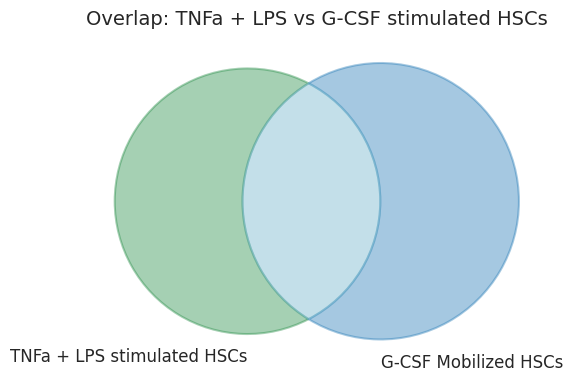

In [127]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

# Define your lists
TNFa_LPS_stimulated_HSCs = {
    'JUNB', 'JUND', 'MAFF', 'KLF2', 'FOS', 'FOSB', 'FOSL1', 'FOSL2',
    'NFKB1', 'REL', 'NR3C1', 'SMAD3'
}

GCSF_Mobilized_HSCs = {
    'JUN', 'FOSB', 'FOS', 'EGR1', 'KLF2', 'ATF3', 'NR4A1', 'NFATC1',
    'DUSP1', 'CD74', 'MIDN', 'MAFF', 'FOSL1'
}

# Create venn diagram
plt.figure(figsize=(6,6))
venn = venn2(
    [TNFa_LPS_stimulated_HSCs, GCSF_Mobilized_HSCs],
    set_labels=("TNFa + LPS stimulated HSCs", "G-CSF Mobilized HSCs")
)

# Color the circles
venn.get_patch_by_id('10').set_color('#208A42')  # Green
venn.get_patch_by_id('01').set_color('#1f77b4')  # Blue
venn.get_patch_by_id('11').set_color('#6BB1C9')  # Overlap

# Remove counts (subset labels)
for text in venn.subset_labels:
    if text:
        text.set_text("")

# Style
for text in venn.set_labels:
    text.set_fontsize(12)

plt.title("Overlap: TNFa + LPS vs G-CSF stimulated HSCs", fontsize=14)
plt.savefig("Overlap_TNFa_LPS_vs_GCSF_stimulated_HSCs", dpi=300)
plt.show()


## This section quantifies signal over defined intervals across the HSC to MEP lineage Trajectory¶

In [157]:
import pandas as pd

# ------------------------------
# 1. Load the barcode annotation table
# ------------------------------
cluster_barcodes = pd.read_csv("K27me3_MEP_Traj_Cluster_Barcodes.csv")

# Create barcode groups as sets for fast lookup
cluster_groups = {
    "HSC": set(cluster_barcodes.loc[cluster_barcodes["cluster_name"] == "HSC", "barcode"]),
    "MPP_early": set(cluster_barcodes.loc[cluster_barcodes["cluster_name"] == "MPP_early", "barcode"]),
    "MPP_late": set(cluster_barcodes.loc[cluster_barcodes["cluster_name"] == "MPP_late", "barcode"]),
    "MEP": set(cluster_barcodes.loc[cluster_barcodes["cluster_name"] == "MEP", "barcode"])
}

# ------------------------------
# 2. Define batch file paths
# ------------------------------
rep1_parts = [
    'Full_hg38_Aligned_BED_Files/Batch_Beds_K27me3/K27me3_Batch1_Full.bed.gz',
    'Full_hg38_Aligned_BED_Files/Batch_Beds_K27me3/K27me3_Batch2_Full.bed.gz',
    'Full_hg38_Aligned_BED_Files/Batch_Beds_K27me3/K27me3_Batch3_Full.bed.gz'
]

other_reps = {
    'Rep2': 'Full_hg38_Aligned_BED_Files/Batch_Beds_K27me3/K27me3_Batch4_2in1_wCUTAC_Full.bed.gz',
    'Rep3': 'Full_hg38_Aligned_BED_Files/Batch_Beds_K27me3/K27me3_Batch7_2in1_wCUTAC_Full.bed.gz',
    'Rep4': 'Full_hg38_Aligned_BED_Files/Batch_Beds_K27me3/K27me3_Batch8_2in1_wCUTAC_Full.bed.gz',
    'Rep5': 'Full_hg38_Aligned_BED_Files/Batch_Beds_K27me3/K27me3_Batch9_2in1_wCUTAC_Full.bed.gz',
    'Rep6': 'Full_hg38_Aligned_BED_Files/Batch_Beds_K27me3/K27me3_Batch10_Full.bed.gz'
}

# ------------------------------
# 3. Function to split a BED dataframe by cluster groups
# ------------------------------
def split_bed_by_clusters(bed_df, cluster_groups):
    bed_df.columns = ['chrom', 'start', 'end', 'barcode']
    split = {}
    for cluster, barcodes in cluster_groups.items():
        split[cluster] = bed_df[bed_df['barcode'].isin(barcodes)].copy()
    return split

# ------------------------------
# 4. Process all batches
# ------------------------------
split_batches = {}

# Rep1 (concatenated from 3 parts)
rep1_df = pd.concat([pd.read_csv(f, sep='\t', header=None, compression='gzip') for f in rep1_parts], ignore_index=True)
split_batches['Rep1'] = split_bed_by_clusters(rep1_df, cluster_groups)

# Other reps
for rep_name, filepath in other_reps.items():
    rep_df = pd.read_csv(filepath, sep='\t', header=None, compression='gzip')
    split_batches[rep_name] = split_bed_by_clusters(rep_df, cluster_groups)

# ------------------------------
# 5. Inspect or save results
# ------------------------------
# Example: number of reads in Rep3 MPP_late
print("Rep3 MPP_late reads:", len(split_batches['Rep3']['MPP_late']))

# Example: save Rep2 HSC to file
# split_batches['Rep2']['HSC'].to_csv("Rep2_HSC.bed.gz", sep='\t', header=False, index=False, compression='gzip')


Rep3 MPP_late reads: 4951661


In [242]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from pybedtools import BedTool
from scipy.stats import zscore, ttest_ind
from statsmodels.stats.multitest import multipletests

# ------------------------------
# 1. Define MECOM K27me3 Intervals
# ------------------------------
MECOM_K27me3_Peaks = [
    {'chrom': 'chr3', 'start': 169224000, 'stop': 169238000},
    {'chrom': 'chr3', 'start': 169239500, 'stop': 169247000},
    {'chrom': 'chr3', 'start': 169657500, 'stop': 169659100},
    {'chrom': 'chr3', 'start': 169660775, 'stop': 169666775}
]

# ------------------------------
# 2. Format Replicates from Split BEDs
# ------------------------------
def format_split_batches_for_processing(split_batches):
    bed_files_with_names = []
    for rep, groups in split_batches.items():
        for group, df in groups.items():
            bed_path = f"temp_{group}_{rep}.bed"
            df.to_csv(bed_path, sep='\t', header=False, index=False)
            bed_files_with_names.append((group, rep, bed_path))
    return bed_files_with_names

# ------------------------------
# 3. Process Z-scored BED Overlaps
# ------------------------------
def process_datasets_with_zscore(peak_intervals, bed_files_with_names):
    peak_intervals_df = pd.DataFrame(peak_intervals)
    peak_intervals_bed = BedTool.from_dataframe(peak_intervals_df)
    cluster_dataframes = []
    print("Processing bed files...")
    for dataset_label, replicate_label, bed_file in tqdm(bed_files_with_names):
        bed_tool = BedTool(bed_file)
        cluster_count = len(bed_tool)
        overlap = peak_intervals_bed.intersect(bed_tool, wao=True)
        overlap_df = pd.read_csv(overlap.fn, sep='\t', header=None)
        overlap_df.columns = ['chrom', 'start', 'stop', 'chrom2', 'start2', 'stop2', 'barcode', 'overlap']
        overlap_df['counts'] = (overlap_df['overlap'] > 0).astype(int)
        summarized = overlap_df.groupby(['chrom', 'start', 'stop']).agg({'counts': 'sum'}).reset_index()
        summarized['_norm'] = (summarized['counts'] / cluster_count) * 100000
        summarized['dataset'] = dataset_label
        summarized['replicate'] = replicate_label
        cluster_dataframes.append(summarized[['chrom', 'start', 'stop', '_norm', 'dataset', 'replicate']])
    merged_df = pd.concat(cluster_dataframes, ignore_index=True)
    merged_df['zscore'] = merged_df.groupby(['chrom', 'start', 'stop'])['_norm'].transform(zscore)
    return merged_df

# ------------------------------
# 4. Boxplot
# ------------------------------
def plot_boxplot(merged_df, value_column='_norm', output_path=None, interval_order=None):
    melted_df = merged_df.melt(
        id_vars=['chrom', 'start', 'stop', 'dataset', 'replicate'],
        value_vars=[value_column],
        var_name='measure',
        value_name='norm_value'
    )
    melted_df['interval'] = melted_df.apply(lambda row: f"{row['chrom']}:{row['start']}-{row['stop']}", axis=1)

    if interval_order is not None:
        interval_order_labels = [f"{peak['chrom']}:{peak['start']}-{peak['stop']}" for peak in interval_order]
        melted_df['interval'] = pd.Categorical(melted_df['interval'], categories=interval_order_labels, ordered=True)

    custom_colors = ["#440154", "#32678B", "#4AB670", "#fde725"]
    unique_datasets = melted_df['dataset'].unique()
    color_palette = {dataset: custom_colors[i % len(custom_colors)] for i, dataset in enumerate(unique_datasets)}

    print("Generating boxplot...")
    plt.figure(figsize=(10, 8))
    ax = sns.boxplot(
        data=melted_df,
        x='interval',
        y='norm_value',
        hue='dataset',
        showfliers=False,
        palette=color_palette,
        linewidth=5.0
    )
    for patch in ax.patches:
        patch.set_edgecolor('black')
        patch.set_linewidth(5.0)
    for line in ax.lines:
        line.set_color('black')
        line.set_linewidth(5.0)
    for spine in ax.spines.values():
        spine.set_linewidth(5.0)

    ax.set_ylim(-2, 3.5)
    plt.xticks(rotation=45, ha='right')
    plt.xlabel("Genomic Interval")
    plt.ylabel(f"{value_column} Value")
    plt.title(f"Comparison of Datasets Across Peaks ({value_column})")
    plt.legend(title="Dataset", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()

    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        print(f"✅ Boxplot saved to {output_path}")
    else:
        plt.show()

# ------------------------------
# 5. Statistics
# ------------------------------
def run_statistical_tests(merged_df, value_column='zscore', output_path=None):
    comparison_pairs = [
        ('HSC', 'MPP_early'),
        ('MPP_early', 'MPP_late'),
        ('MPP_late', 'MEP')
    ]

    stats_results = []

    for (chrom, start, stop), interval_df in merged_df.groupby(['chrom', 'start', 'stop']):
        for group1_label, group2_label in comparison_pairs:
            group1 = interval_df[interval_df['dataset'] == group1_label][value_column]
            group2 = interval_df[interval_df['dataset'] == group2_label][value_column]
            n1, n2 = len(group1), len(group2)
            if n1 < 2 or n2 < 2:
                continue
            t_stat, p_value = ttest_ind(group1, group2, nan_policy='omit')
            stats_results.append({
                "Interval": f"{chrom}:{start}-{stop}",
                "Comparison": f"{group1_label} vs {group2_label}",
                "N1": n1,
                "N2": n2,
                "t-statistic": t_stat,
                "p-value": p_value
            })

    stats_df = pd.DataFrame(stats_results)
    if not stats_df.empty:
        reject, pvals_corrected, _, _ = multipletests(stats_df['p-value'].tolist(), method='bonferroni')
        stats_df['Corrected p-value'] = pvals_corrected
        stats_df['Reject Null Hypothesis'] = reject

    if output_path:
        stats_df.to_csv(output_path, index=False)
        print(f"✅ Statistical results saved to {output_path}")
    else:
        print(stats_df)

    return stats_df


def run_one_sided_increase_tests(merged_df, value_column='zscore', output_path=None):
    """
    One-sided t-tests looking for a decrease from group1 to group2 across genomic intervals.
    """
    comparison_pairs = [
        ('HSC', 'MPP_early'),
        ('HSC', 'MPP_late'),
        ('HSC', 'MEP'),
        ('MPP_early', 'MPP_late'),
        ('MPP_early', 'MEP'),
        ('MPP_late', 'MEP')
    ]

    stats_results = []

    for (chrom, start, stop), interval_df in merged_df.groupby(['chrom', 'start', 'stop']):
        for group1_label, group2_label in comparison_pairs:
            group1 = interval_df[interval_df['dataset'] == group1_label][value_column]
            group2 = interval_df[interval_df['dataset'] == group2_label][value_column]
            n1, n2 = len(group1), len(group2)

            if n1 < 2 or n2 < 2:
                continue  # Not enough replicates

            t_stat, p_value = ttest_ind(group1, group2, nan_policy='omit')

            # One-sided p-value (testing if group1 < group2)
            one_sided_p = p_value / 2 if t_stat < 0 else 1

            stats_results.append({
                "Interval": f"{chrom}:{start}-{stop}",
                "Comparison": f"{group1_label} < {group2_label} (increase)",
                "N1": n1,
                "N2": n2,
                "t-statistic": t_stat,
                "One-sided p-value": one_sided_p
            })

    stats_df = pd.DataFrame(stats_results)

    # Bonferroni correction
    if not stats_df.empty:
        reject, pvals_corrected, _, _ = multipletests(stats_df['One-sided p-value'].tolist(), method='bonferroni')
        stats_df['Corrected p-value'] = pvals_corrected
        stats_df['Reject Null Hypothesis'] = reject

    if output_path:
        stats_df.to_csv(output_path, index=False)
        print(f"✅ Statistical results saved to {output_path}")
    else:
        print(stats_df)

    return stats_df

def run_one_sided_decrease_tests(merged_df, value_column='zscore', output_path=None):
    """
    One-sided t-tests looking for an increase from group1 to group2 across genomic intervals.
    """
    comparison_pairs = [
        ('HSC', 'MPP_early'),
        ('HSC', 'MPP_late'),
        ('HSC', 'MEP'),
        ('MPP_early', 'MPP_late'),
        ('MPP_early', 'MEP'),
        ('MPP_late', 'MEP')
    ]

    stats_results = []

    for (chrom, start, stop), interval_df in merged_df.groupby(['chrom', 'start', 'stop']):
        for group1_label, group2_label in comparison_pairs:
            group1 = interval_df[interval_df['dataset'] == group1_label][value_column]
            group2 = interval_df[interval_df['dataset'] == group2_label][value_column]
            n1, n2 = len(group1), len(group2)

            if n1 < 2 or n2 < 2:
                continue  # Not enough replicates

            t_stat, p_value = ttest_ind(group1, group2, nan_policy='omit')

            # One-sided p-value (testing if group2 > group1)
            one_sided_p = p_value / 2 if t_stat > 0 else 1

            stats_results.append({
                "Interval": f"{chrom}:{start}-{stop}",
                "Comparison": f"{group1_label} > {group2_label} (decrease)",
                "N1": n1,
                "N2": n2,
                "t-statistic": t_stat,
                "One-sided p-value": one_sided_p
            })

    stats_df = pd.DataFrame(stats_results)

    # Bonferroni correction
    if not stats_df.empty:
        reject, pvals_corrected, _, _ = multipletests(stats_df['One-sided p-value'].tolist(), method='bonferroni')
        stats_df['Corrected p-value'] = pvals_corrected
        stats_df['Reject Null Hypothesis'] = reject

    if output_path:
        stats_df.to_csv(output_path, index=False)
        print(f"✅ Statistical results saved to {output_path}")
    else:
        print(stats_df)

    return stats_df




In [ ]:
# Use the formatter to generate temporary BED files from your split_batches
bed_files_with_names = format_split_batches_for_processing(split_batches)

In [160]:
# Define your peak list (already sorted from before)
MECOM_K27me3_Peaks = [
    {'chrom': 'chr3', 'start': 169224000, 'stop': 169238000},
    {'chrom': 'chr3', 'start': 169239500, 'stop': 169247000},
    {'chrom': 'chr3', 'start': 169657500, 'stop': 169659100},
    {'chrom': 'chr3', 'start': 169660775, 'stop': 169666775}
]

# Run the overlap & z-scoring
MECOM_K27me3_df_results = process_datasets_with_zscore(MECOM_K27me3_Peaks, bed_files_with_names)


Processing bed files...


100%|██████████| 24/24 [05:51<00:00, 14.65s/it]


Generating boxplot...
✅ Boxplot saved to MECOM_MEP_Traj_K27me3_Interval_Comparison_Boxplot_REV.png


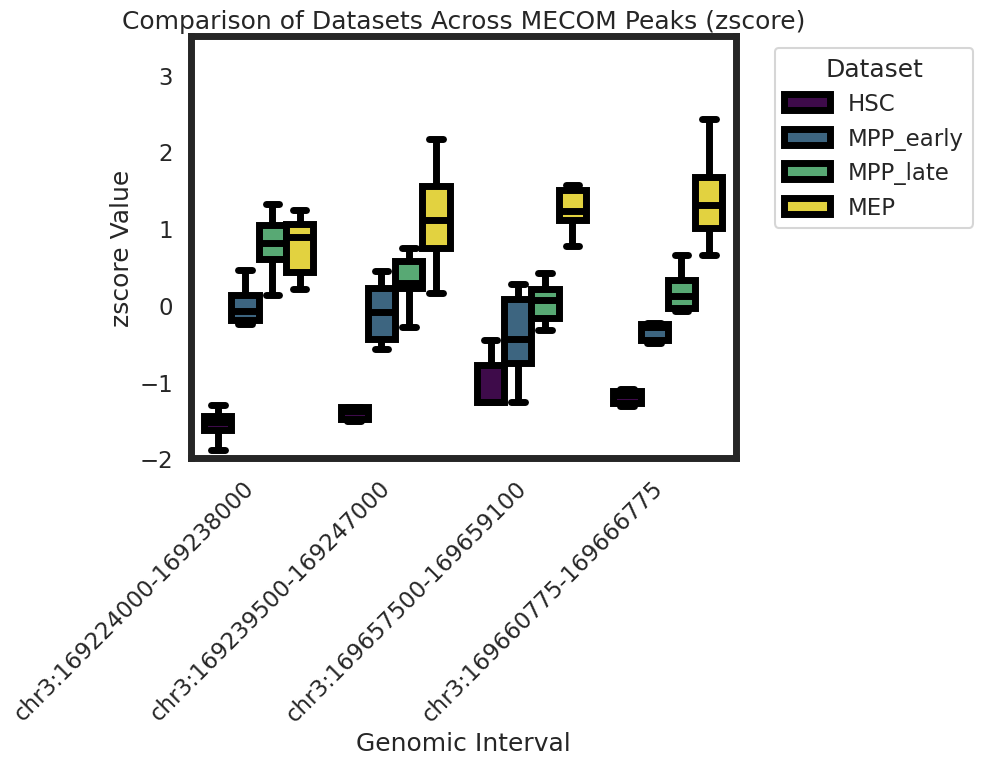

In [182]:
output_plot = "MECOM_MEP_Traj_K27me3_Interval_Comparison_Boxplot_REV.png"

plot_boxplot(MECOM_K27me3_df_results, value_column='zscore', output_path=output_plot, interval_order=MECOM_K27me3_Peaks)


In [204]:
output_stats = "MECOM_MEP_Traj_K27me3_Interval_Stats.csv"

MECOM_K27me3_stats_df = run_statistical_tests(MECOM_K27me3_df_results, value_column='zscore', output_path=output_stats)

print(MECOM_K27me3_stats_df)


✅ Statistical results saved to MECOM_MEP_Traj_K27me3_Interval_Stats.csv
                    Interval             Comparison  N1  N2  t-statistic       p-value  Corrected p-value  Reject Null Hypothesis
0   chr3:169224000-169238000       HSC vs MPP_early   6   6   -11.269959  5.259607e-07           0.000006                    True
1   chr3:169224000-169238000  MPP_early vs MPP_late   6   6    -3.815277  3.399722e-03           0.040797                    True
2   chr3:169224000-169238000        MPP_late vs MEP   6   6     0.069681  9.458215e-01           1.000000                   False
3   chr3:169239500-169247000       HSC vs MPP_early   6   6    -6.752083  5.029209e-05           0.000604                    True
4   chr3:169239500-169247000  MPP_early vs MPP_late   6   6    -1.761913  1.085666e-01           1.000000                   False
5   chr3:169239500-169247000        MPP_late vs MEP   6   6    -2.495778  3.167513e-02           0.380102                   False
6   chr3:169657500

In [167]:
# Define your peak list (already sorted from before)
PRDM16_K27me3_Peaks = [
        {'chrom': 'chr1', 'start': 3066197, 'stop': 3072197}, #, 'label': 'PRDM16 Promoter'
        {'chrom': 'chr1', 'start': 3072197, 'stop': 3075200}, #, 'label': 'PRDM16 DE1'
        {'chrom': 'chr1', 'start': 3162800, 'stop': 3163400}, #, 'label': 'PRDM16 DE2'
        {'chrom': 'chr1', 'start': 3245500, 'stop': 3249500}, #, 'label': 'PRDM16 DE3'
        {'chrom': 'chr1', 'start': 3391500, 'stop': 3396200} #, 'label': 'PRDM16 DE4'
    ]

# Run the overlap & z-scoring
PRDM16_K27me3_df_results = process_datasets_with_zscore(PRDM16_K27me3_Peaks, bed_files_with_names)


Processing bed files...


100%|██████████| 24/24 [05:52<00:00, 14.67s/it]


Generating boxplot...
✅ Boxplot saved to PRDM16_MEP_Traj_K27me3_Interval_Comparison_Boxplot_REV.png


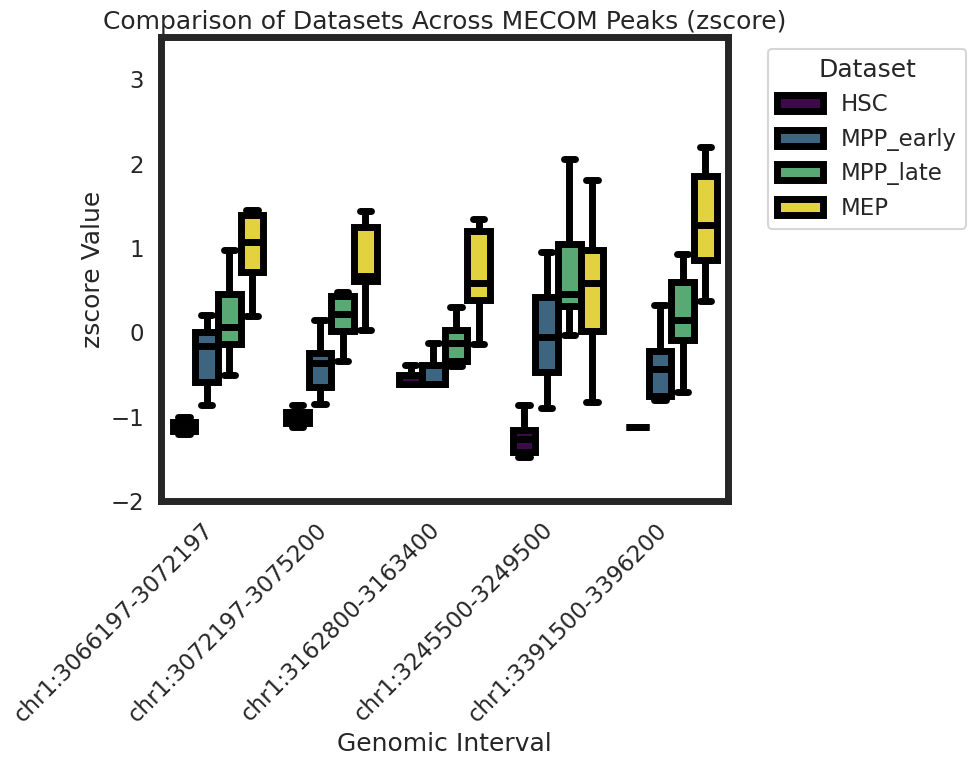

In [183]:
output_plot = "PRDM16_MEP_Traj_K27me3_Interval_Comparison_Boxplot_REV.png"

plot_boxplot(PRDM16_K27me3_df_results, value_column='zscore', output_path=output_plot, interval_order=PRDM16_K27me3_Peaks)


In [169]:
output_stats = "PRDM16_MEP_Traj_K27me3_Interval_Stats.csv"

PRDM16_K27me3_stats_df = run_statistical_tests(PRDM16_K27me3_df_results, value_column='zscore', output_path=output_stats)

print(PRDM16_K27me3_stats_df)


✅ Statistical results saved to PRDM16_MEP_Traj_K27me3_Interval_Stats.csv
                Interval             Comparison  N1  N2  t-statistic   p-value  Corrected p-value  Reject Null Hypothesis
0   chr1:3066197-3072197       HSC vs MPP_early   6   6    -4.794701  0.000729           0.010941                    True
1   chr1:3066197-3072197  MPP_early vs MPP_late   6   6    -1.578877  0.145444           1.000000                   False
2   chr1:3066197-3072197        MPP_late vs MEP   6   6    -2.407284  0.036854           0.552811                   False
3   chr1:3072197-3075200       HSC vs MPP_early   6   6    -3.964887  0.002665           0.039979                    True
4   chr1:3072197-3075200  MPP_early vs MPP_late   6   6    -2.669940  0.023495           0.352424                   False
5   chr1:3072197-3075200        MPP_late vs MEP   6   6    -1.621696  0.135935           1.000000                   False
6   chr1:3162800-3163400       HSC vs MPP_early   6   6    -0.729320  0.4

In [249]:
# Define your peak list (already sorted from before)
ZFPM1_K4me123_Peaks = [
    {'chrom': 'chr16', 'start': 88452317, 'stop': 88454317},
    {'chrom': 'chr16', 'start': 88490500, 'stop': 88493500},
    {'chrom': 'chr16', 'start': 88502000, 'stop': 88516000},
    {'chrom': 'chr16', 'start': 88532500, 'stop': 88533750}
]

# Run the overlap & z-scoring
ZFPM1_K27me3_df_results = process_datasets_with_zscore(ZFPM1_K4me123_Peaks, bed_files_with_names)

Processing bed files...


100%|██████████| 24/24 [02:42<00:00,  6.79s/it]


Generating boxplot...
✅ Boxplot saved to ZFPM1_MEP_Traj_K27me3_Interval_Comparison_Boxplot_REV.png


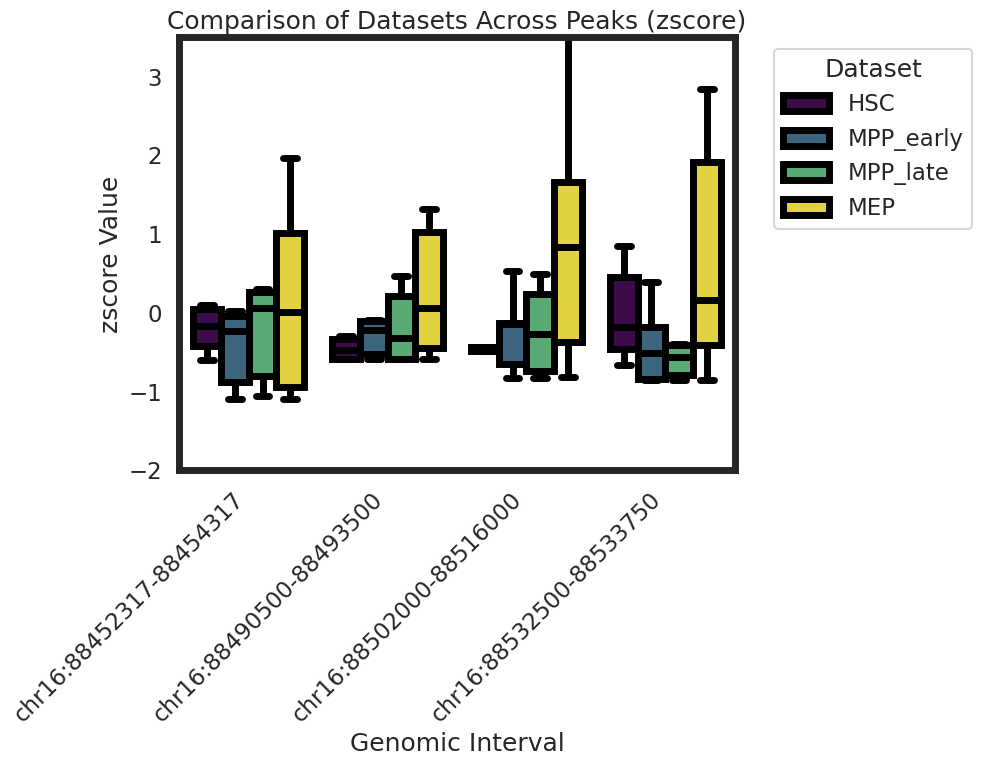

In [253]:
output_plot = "ZFPM1_MEP_Traj_K27me3_Interval_Comparison_Boxplot_REV.png"

plot_boxplot(ZFPM1_K27me3_df_results, value_column='zscore', output_path=output_plot, interval_order=ZFPM1_K4me123_Peaks)


In [254]:
output_stats = "ZFPM1_MEP_Traj_K27me3_Interval_Stats.csv"

ZFPM1_K27me3_stats_df = run_statistical_tests(ZFPM1_K27me3_df_results, value_column='zscore', output_path=output_stats)

print(ZFPM1_K27me3_stats_df)


✅ Statistical results saved to ZFPM1_MEP_Traj_K27me3_Interval_Stats.csv
                   Interval             Comparison  N1  N2  t-statistic   p-value  Corrected p-value  Reject Null Hypothesis
0   chr16:88452317-88454317       HSC vs MPP_early   6   6    -0.299702  0.770541                1.0                   False
1   chr16:88452317-88454317  MPP_early vs MPP_late   6   6    -0.183546  0.858038                1.0                   False
2   chr16:88452317-88454317        MPP_late vs MEP   6   6    -0.114287  0.911272                1.0                   False
3   chr16:88490500-88493500       HSC vs MPP_early   6   6    -1.375498  0.199003                1.0                   False
4   chr16:88490500-88493500  MPP_early vs MPP_late   6   6     0.201902  0.844042                1.0                   False
5   chr16:88490500-88493500        MPP_late vs MEP   6   6    -1.190915  0.261188                1.0                   False
6   chr16:88502000-88516000       HSC vs MPP_early   

In [255]:
# Define your peak list (already sorted from before)
GATA1_K4me123_Peaks = [
    {'chrom': 'chrX', 'start': 48782600, 'stop': 48783250},
    {'chrom': 'chrX', 'start': 48785554, 'stop': 48787554},
    {'chrom': 'chrX', 'start': 48789400, 'stop': 48790000},
    {'chrom': 'chrX', 'start': 48794000, 'stop': 48795400} 
]

# Run the overlap & z-scoring
GATA1_K27me3_df_results = process_datasets_with_zscore(GATA1_K4me123_Peaks, bed_files_with_names)

Processing bed files...


100%|██████████| 24/24 [02:41<00:00,  6.74s/it]


Generating boxplot...
✅ Boxplot saved to GATA1_MEP_Traj_K27me3_Interval_Comparison_Boxplot_REV.png


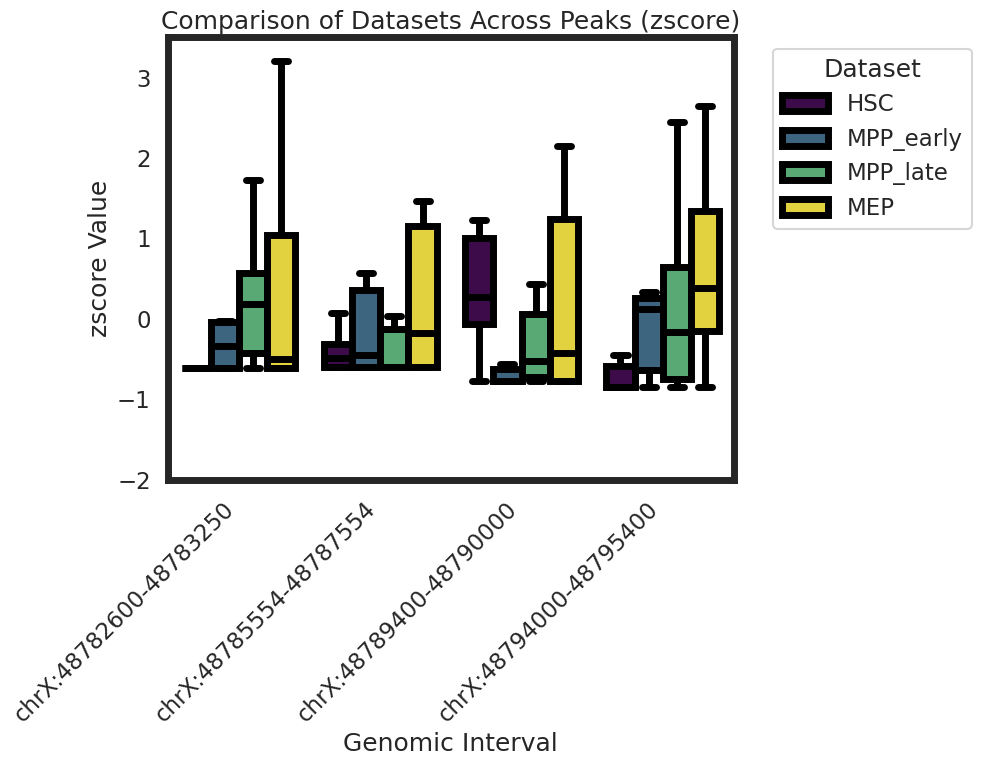

In [256]:
output_plot = "GATA1_MEP_Traj_K27me3_Interval_Comparison_Boxplot_REV.png"

plot_boxplot(GATA1_K27me3_df_results, value_column='zscore', output_path=output_plot, interval_order=GATA1_K4me123_Peaks)


In [257]:
output_stats = "GATA1_MEP_Traj_K27me3_Interval_Stats.csv"

GATA1_K27me3_stats_df = run_statistical_tests(GATA1_K27me3_df_results, value_column='zscore', output_path=output_stats)

print(GATA1_K27me3_stats_df)


✅ Statistical results saved to GATA1_MEP_Traj_K27me3_Interval_Stats.csv
                  Interval             Comparison  N1  N2  t-statistic   p-value  Corrected p-value  Reject Null Hypothesis
0   chrX:48782600-48783250       HSC vs MPP_early   6   6    -1.603044  0.140007           1.000000                   False
1   chrX:48782600-48783250  MPP_early vs MPP_late   6   6    -0.654506  0.527551           1.000000                   False
2   chrX:48782600-48783250        MPP_late vs MEP   6   6    -0.205447  0.841345           1.000000                   False
3   chrX:48785554-48787554       HSC vs MPP_early   6   6    -1.085639  0.303116           1.000000                   False
4   chrX:48785554-48787554  MPP_early vs MPP_late   6   6     0.668749  0.518795           1.000000                   False
5   chrX:48785554-48787554        MPP_late vs MEP   6   6    -0.744149  0.473910           1.000000                   False
6   chrX:48789400-48790000       HSC vs MPP_early   6   6   

/home/derek.janssens/jupyter_bbc2_python3_python-3.11.3_/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:573: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


In [184]:
import pandas as pd

# ------------------------------
# 1. Load the barcode annotation table
# ------------------------------
cluster_barcodes = pd.read_csv("K27me3_MEP_Traj_Cluster_Barcodes.csv")

# Create barcode groups as sets for fast lookup
cluster_groups = {
    "HSC": set(cluster_barcodes.loc[cluster_barcodes["cluster_name"] == "HSC", "barcode"]),
    "MPP_early": set(cluster_barcodes.loc[cluster_barcodes["cluster_name"] == "MPP_early", "barcode"]),
    "MPP_late": set(cluster_barcodes.loc[cluster_barcodes["cluster_name"] == "MPP_late", "barcode"]),
    "MEP": set(cluster_barcodes.loc[cluster_barcodes["cluster_name"] == "MEP", "barcode"])
}

# ------------------------------
# 2. Define CUTAC file paths
# ------------------------------
cutac_file_paths = {
    'Rep2': 'Full_hg38_Aligned_BED_Files/Batch_Beds_CUTAC_wSplit_Combined/CUTAC_Batch4_2in1_wK27me3_wSplit_Full.bed.gz',
    'Rep3': 'Full_hg38_Aligned_BED_Files/Batch_Beds_CUTAC_wSplit_Combined/CUTAC_Batch7_2in1_wK27me3_wSplit_Full.bed.gz',
    'Rep4': 'Full_hg38_Aligned_BED_Files/Batch_Beds_CUTAC_wSplit_Combined/CUTAC_Batch8_2in1_wK27me3_wSplit_Full.bed.gz',
    'Rep5': 'Full_hg38_Aligned_BED_Files/Batch_Beds_CUTAC_wSplit_Combined/CUTAC_Batch9_2in1_wK27me3_wSplit_Full.bed.gz'
}

# ------------------------------
# 3. Function to split a BED dataframe by cluster groups
# ------------------------------
def split_bed_by_clusters(bed_df, cluster_groups):
    bed_df.columns = ['chrom', 'start', 'end', 'barcode']
    split = {}
    for cluster, barcodes in cluster_groups.items():
        split[cluster] = bed_df[bed_df['barcode'].isin(barcodes)].copy()
    return split

# ------------------------------
# 4. Process all CUTAC reps
# ------------------------------
split_cutac_batches = {}

for rep_name, filepath in cutac_file_paths.items():
    print(f"📂 Processing {rep_name}: {filepath}")
    rep_df = pd.read_csv(filepath, sep='\t', header=None, compression='gzip')
    split_cutac_batches[rep_name] = split_bed_by_clusters(rep_df, cluster_groups)

# ------------------------------
# 5. Inspect or save results
# ------------------------------
# Example: number of reads in Rep3 MPP_early
print("Rep3 MPP_early reads:", len(split_cutac_batches['Rep3']['MPP_early']))

# Example: save Rep4 MEP reads
# split_cutac_batches['Rep4']['MEP'].to_csv("Rep4_MEP_CUTAC.bed.gz", sep='\t', header=False, index=False, compression='gzip')


📂 Processing Rep2: Full_hg38_Aligned_BED_Files/Batch_Beds_CUTAC_wSplit_Combined/CUTAC_Batch4_2in1_wK27me3_wSplit_Full.bed.gz
📂 Processing Rep3: Full_hg38_Aligned_BED_Files/Batch_Beds_CUTAC_wSplit_Combined/CUTAC_Batch7_2in1_wK27me3_wSplit_Full.bed.gz
📂 Processing Rep4: Full_hg38_Aligned_BED_Files/Batch_Beds_CUTAC_wSplit_Combined/CUTAC_Batch8_2in1_wK27me3_wSplit_Full.bed.gz
📂 Processing Rep5: Full_hg38_Aligned_BED_Files/Batch_Beds_CUTAC_wSplit_Combined/CUTAC_Batch9_2in1_wK27me3_wSplit_Full.bed.gz
Rep3 MPP_early reads: 414388


In [185]:
cutac_bed_files_with_names = format_split_batches_for_processing(split_cutac_batches)

In [190]:
# Define your peak list (already sorted from before)
MECOM_CUTAC_Peaks = [
    {'chrom': 'chr3', 'start': 169083499, 'stop': 169660775}, #, 'label': 'MECOM Gene Body'    
    {'chrom': 'chr3', 'start': 169660775, 'stop': 169666775}, #, 'label': 'MECOM Promoter'   
    ]

# Run the overlap & z-scoring
MECOM_CUTAC_df_results = process_datasets_with_zscore(MECOM_CUTAC_Peaks, cutac_bed_files_with_names)


Processing bed files...


100%|██████████| 16/16 [00:47<00:00,  2.98s/it]


Generating boxplot...
✅ Boxplot saved to MECOM_MEP_Traj_CUTAC_Prom_GBody_Boxplot_REV.png


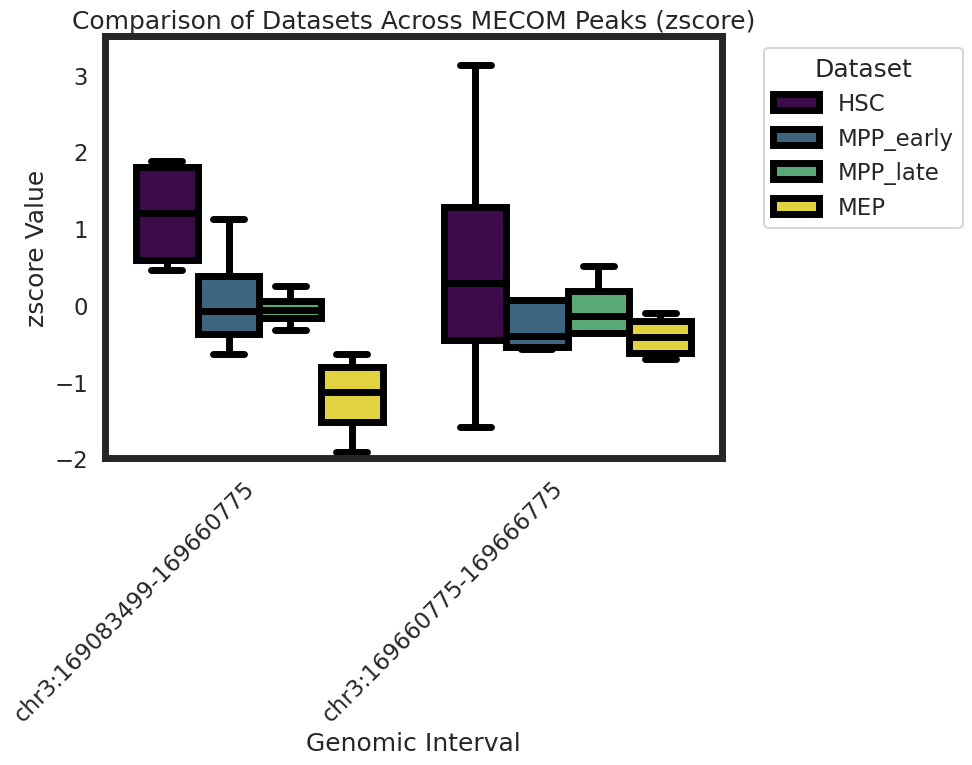

In [191]:
output_plot = "MECOM_MEP_Traj_CUTAC_Prom_GBody_Boxplot_REV.png"

plot_boxplot(MECOM_CUTAC_df_results, value_column='zscore', output_path=output_plot, interval_order=MECOM_CUTAC_Peaks)


In [211]:
output_stats = "MECOM_MEP_Traj_CUTAC_Prom_GBody_Stats.csv"

MECOM_CUTAC_stats_df = run_one_sided_decrease_tests(MECOM_CUTAC_df_results, value_column='zscore', output_path=output_stats)

print(MECOM_CUTAC_stats_df)


✅ Statistical results saved to MECOM_MEP_Traj_CUTAC_Prom_GBody_Stats.csv
                    Interval                       Comparison  N1  N2  t-statistic  One-sided p-value  Corrected p-value  Reject Null Hypothesis
0   chr3:169083499-169660775       HSC > MPP_early (decrease)   4   4     2.077080           0.041535           0.498418                   False
1   chr3:169083499-169660775        HSC > MPP_late (decrease)   4   4     3.171996           0.009635           0.115620                   False
2   chr3:169083499-169660775             HSC > MEP (decrease)   4   4     5.092603           0.001119           0.013426                    True
3   chr3:169083499-169660775  MPP_early > MPP_late (decrease)   4   4     0.331515           0.375764           1.000000                   False
4   chr3:169083499-169660775       MPP_early > MEP (decrease)   4   4     2.698237           0.017830           0.213957                   False
5   chr3:169083499-169660775        MPP_late > MEP (decre

In [193]:
PRDM16_CUTAC_Peaks = [
     {'chrom': 'chr1', 'start': 3066197, 'stop': 3072197}, #, 'label': 'PRDM16 Promoter'
    {'chrom': 'chr1', 'start': 3072197, 'stop': 3438621	}, #, 'label': 'PRDM16 Gene Body'
]

# Run the overlap & z-scoring
PRDM16_CUTAC_df_results = process_datasets_with_zscore(PRDM16_CUTAC_Peaks, cutac_bed_files_with_names)

Processing bed files...


100%|██████████| 16/16 [00:47<00:00,  2.95s/it]


Generating boxplot...
✅ Boxplot saved to PRDM16_MEP_Traj_CUTAC_Prom_GBody_Boxplot_REV.png


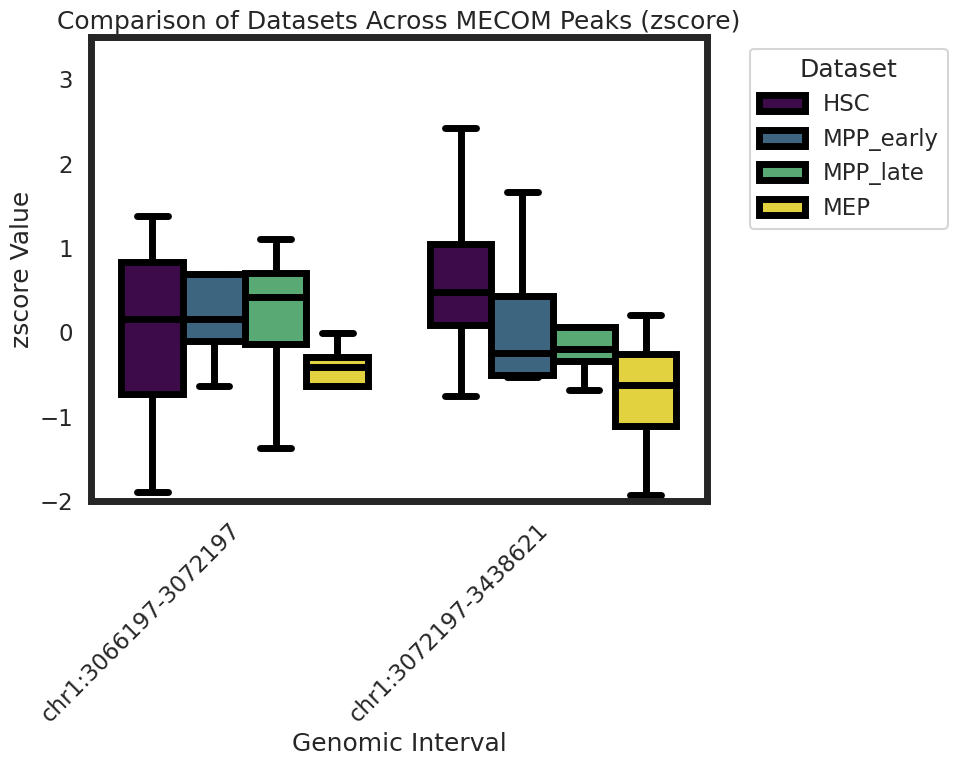

In [194]:
output_plot = "PRDM16_MEP_Traj_CUTAC_Prom_GBody_Boxplot_REV.png"

plot_boxplot(PRDM16_CUTAC_df_results, value_column='zscore', output_path=output_plot, interval_order=PRDM16_CUTAC_Peaks)

In [212]:
output_stats = "PRDM16_MEP_Traj_CUTAC_Prom_GBody_Stats.csv"

PRDM16_CUTAC_stats_df = run_one_sided_decrease_tests(PRDM16_CUTAC_df_results, value_column='zscore', output_path=output_stats)

print(PRDM16_CUTAC_stats_df)

✅ Statistical results saved to PRDM16_MEP_Traj_CUTAC_Prom_GBody_Stats.csv
                Interval                       Comparison  N1  N2  t-statistic  One-sided p-value  Corrected p-value  Reject Null Hypothesis
0   chr1:3066197-3072197       HSC > MPP_early (decrease)   4   4    -0.523029           1.000000             1.0000                   False
1   chr1:3066197-3072197        HSC > MPP_late (decrease)   4   4    -0.220501           1.000000             1.0000                   False
2   chr1:3066197-3072197             HSC > MEP (decrease)   4   4     0.625816           0.277239             1.0000                   False
3   chr1:3066197-3072197  MPP_early > MPP_late (decrease)   4   4     0.358599           0.366088             1.0000                   False
4   chr1:3066197-3072197       MPP_early > MEP (decrease)   4   4     1.526113           0.088916             1.0000                   False
5   chr1:3066197-3072197        MPP_late > MEP (decrease)   4   4     1.125272  

## This one compares CUTAC reps over PRDM16 from both K27me3 and K4me123 in HSCs and MEPs

In [251]:
import pandas as pd

# ------------------------------
# 1. Load cluster barcode tables (HSC + MEP only)
# ------------------------------

# K27me3 clusters
k27_barcodes = pd.read_csv("K27me3_Cluster_Barcodes.csv")
k27_hsc_barcodes = set(k27_barcodes.loc[k27_barcodes["cluster_name"] == "HSC", "barcode"])
k27_mep_barcodes = set(k27_barcodes.loc[k27_barcodes["cluster_name"] == "MEP", "barcode"])

# K4me123 clusters
k4me_barcodes = pd.read_csv("K4me123_Cluster_Barcodes.csv")
k4me_hsc_barcodes = set(k4me_barcodes.loc[k4me_barcodes["cluster_name"] == "HSC", "barcode"])
k4me_mep_barcodes = set(k4me_barcodes.loc[k4me_barcodes["cluster_name"] == "MEP", "barcode"])

# ------------------------------
# 2. Define CUTAC file paths
# ------------------------------

k27_cutac_files = {
    'Rep2': 'Full_hg38_Aligned_BED_Files/Batch_Beds_CUTAC_wSplit_Combined/CUTAC_Batch4_2in1_wK27me3_wSplit_Full.bed.gz',
    'Rep3': 'Full_hg38_Aligned_BED_Files/Batch_Beds_CUTAC_wSplit_Combined/CUTAC_Batch7_2in1_wK27me3_wSplit_Full.bed.gz',
    'Rep4': 'Full_hg38_Aligned_BED_Files/Batch_Beds_CUTAC_wSplit_Combined/CUTAC_Batch8_2in1_wK27me3_wSplit_Full.bed.gz',
    'Rep5': 'Full_hg38_Aligned_BED_Files/Batch_Beds_CUTAC_wSplit_Combined/CUTAC_Batch9_2in1_wK27me3_wSplit_Full.bed.gz'
}

k4me_cutac_files = {
    'Rep1': 'Full_hg38_Aligned_BED_Files/Batch_Beds_CUTAC_wSplit_Combined/CUTAC_Batch7_2in1_wK4me123_wSplit_Full.bed.gz',
    'Rep2': 'Full_hg38_Aligned_BED_Files/Batch_Beds_CUTAC_wSplit_Combined/CUTAC_Batch8_2in1_wK4me123_wSplit_Full.bed.gz',
    'Rep3': 'Full_hg38_Aligned_BED_Files/Batch_Beds_CUTAC_wSplit_Combined/CUTAC_Batch9_2in1_wK4me123_wSplit_Full.bed.gz',
}

# ------------------------------
# 3. Splitting function for HSC and MEP
# ------------------------------

def split_hsc_mep(bed_df, hsc_barcodes, mep_barcodes):
    bed_df.columns = ['chrom', 'start', 'end', 'barcode']
    hsc_df = bed_df[bed_df['barcode'].isin(hsc_barcodes)].copy()
    mep_df = bed_df[bed_df['barcode'].isin(mep_barcodes)].copy()
    return hsc_df, mep_df

# ------------------------------
# 4. Process all batches
# ------------------------------

split_all_cutac_HSC_MEP = {
    'K27me3': {},
    'K4me123': {}
}

# Process K27me3
for rep, path in k27_cutac_files.items():
    df = pd.read_csv(path, sep='\t', header=None, compression='gzip')
    hsc_df, mep_df = split_hsc_mep(df, k27_hsc_barcodes, k27_mep_barcodes)
    split_all_cutac_HSC_MEP['K27me3'][rep] = {'HSC': hsc_df, 'MEP': mep_df}

# Process K4me123
for rep, path in k4me_cutac_files.items():
    df = pd.read_csv(path, sep='\t', header=None, compression='gzip')
    hsc_df, mep_df = split_hsc_mep(df, k4me_hsc_barcodes, k4me_mep_barcodes)
    split_all_cutac_HSC_MEP['K4me123'][rep] = {'HSC': hsc_df, 'MEP': mep_df}

# ------------------------------
# 5. Sanity check
# ------------------------------

print("✅ Rep2 HSC K27me3 reads:", len(split_all_cutac_HSC_MEP['K27me3']['Rep2']['HSC']))
print("✅ Rep2 MEP K27me3 reads:", len(split_all_cutac_HSC_MEP['K27me3']['Rep2']['MEP']))
print("✅ Rep1 HSC K4me123 reads:", len(split_all_cutac_HSC_MEP['K4me123']['Rep1']['HSC']))
print("✅ Rep1 MEP K4me123 reads:", len(split_all_cutac_HSC_MEP['K4me123']['Rep1']['MEP']))


✅ Rep2 HSC K27me3 reads: 108618
✅ Rep2 MEP K27me3 reads: 279203
✅ Rep1 HSC K4me123 reads: 368159
✅ Rep1 MEP K4me123 reads: 855603


In [252]:
renamed_k27 = {f'K27_{k}': v for k, v in split_all_cutac_HSC_MEP['K27me3'].items()}
renamed_k4 = {f'K4_{k}': v for k, v in split_all_cutac_HSC_MEP['K4me123'].items()}
split_cutac_HSC_MEP_batches = {**renamed_k27, **renamed_k4}


In [253]:
# Use the formatter to generate temporary BED files from your split_batches
split_cutac_HSC_MEP_bed_files_with_names = format_split_batches_for_processing(split_cutac_HSC_MEP_batches)

In [254]:
print(split_cutac_HSC_MEP_bed_files_with_names)


[('HSC', 'K27_Rep2', 'temp_HSC_K27_Rep2.bed'), ('MEP', 'K27_Rep2', 'temp_MEP_K27_Rep2.bed'), ('HSC', 'K27_Rep3', 'temp_HSC_K27_Rep3.bed'), ('MEP', 'K27_Rep3', 'temp_MEP_K27_Rep3.bed'), ('HSC', 'K27_Rep4', 'temp_HSC_K27_Rep4.bed'), ('MEP', 'K27_Rep4', 'temp_MEP_K27_Rep4.bed'), ('HSC', 'K27_Rep5', 'temp_HSC_K27_Rep5.bed'), ('MEP', 'K27_Rep5', 'temp_MEP_K27_Rep5.bed'), ('HSC', 'K4_Rep1', 'temp_HSC_K4_Rep1.bed'), ('MEP', 'K4_Rep1', 'temp_MEP_K4_Rep1.bed'), ('HSC', 'K4_Rep2', 'temp_HSC_K4_Rep2.bed'), ('MEP', 'K4_Rep2', 'temp_MEP_K4_Rep2.bed'), ('HSC', 'K4_Rep3', 'temp_HSC_K4_Rep3.bed'), ('MEP', 'K4_Rep3', 'temp_MEP_K4_Rep3.bed')]


In [255]:
PRDM16_CUTAC_Peaks = [
     {'chrom': 'chr1', 'start': 3066197, 'stop': 3072197}, #, 'label': 'PRDM16 Promoter'
    {'chrom': 'chr1', 'start': 3072197, 'stop': 3438621	}, #, 'label': 'PRDM16 Gene Body'
]

# Run the overlap & z-scoring
PRDM16_CUTAC_HSC_MEP_df_results = process_datasets_with_zscore(PRDM16_CUTAC_Peaks, split_cutac_HSC_MEP_bed_files_with_names)

Processing bed files...


100%|██████████| 14/14 [00:34<00:00,  2.44s/it]


In [261]:
def plot_boxplot_HSC_MEP(merged_df, value_column='_norm', output_path=None, interval_order=None):
    melted_df = merged_df.melt(
        id_vars=['chrom', 'start', 'stop', 'dataset', 'replicate'],
        value_vars=[value_column],
        var_name='measure',
        value_name='norm_value'
    )
    melted_df['interval'] = melted_df.apply(lambda row: f"{row['chrom']}:{row['start']}-{row['stop']}", axis=1)

    if interval_order is not None:
        interval_order_labels = [f"{peak['chrom']}:{peak['start']}-{peak['stop']}" for peak in interval_order]
        melted_df['interval'] = pd.Categorical(melted_df['interval'], categories=interval_order_labels, ordered=True)

    custom_colors = ["#440154", "#fde725"]
    unique_datasets = melted_df['dataset'].unique()
    color_palette = {dataset: custom_colors[i % len(custom_colors)] for i, dataset in enumerate(unique_datasets)}

    print("Generating boxplot...")
    plt.figure(figsize=(6, 8))
    ax = sns.boxplot(
        data=melted_df,
        x='interval',
        y='norm_value',
        hue='dataset',
        showfliers=False,
        palette=color_palette,
        linewidth=5.0
    )
    for patch in ax.patches:
        patch.set_edgecolor('black')
        patch.set_linewidth(5.0)
    for line in ax.lines:
        line.set_color('black')
        line.set_linewidth(5.0)
    for spine in ax.spines.values():
        spine.set_linewidth(5.0)

    ax.set_ylim(-2, 3.5)
    plt.xticks(rotation=45, ha='right')
    plt.xlabel("Genomic Interval")
    plt.ylabel(f"{value_column} Value")
    plt.title(f"Comparison of Datasets Across Peaks ({value_column})")
    plt.legend(title="Dataset", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()

    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        print(f"✅ Boxplot saved to {output_path}")
    else:
        plt.show()

Generating boxplot...
✅ Boxplot saved to PRDM16_MEP_Traj_CUTAC_Prom_GBody_Boxplot_K4me123_K27me3_Combined.png


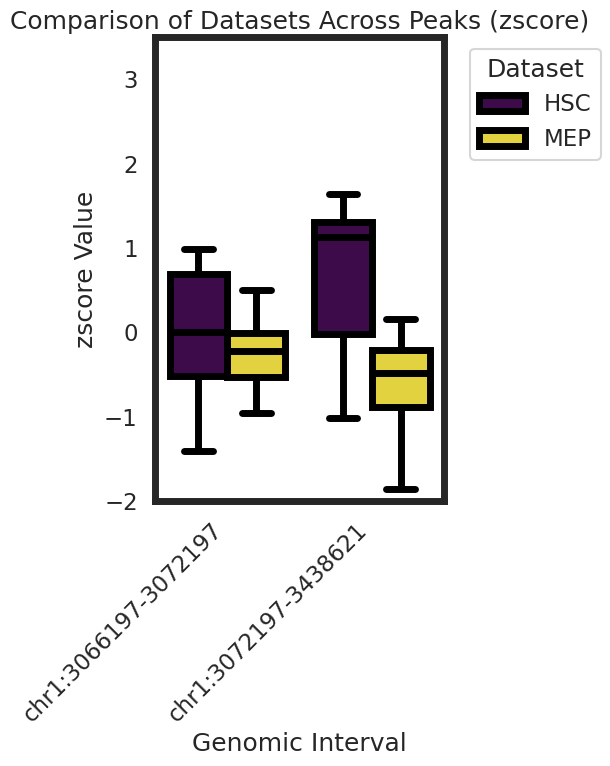

In [262]:
output_plot = "PRDM16_MEP_Traj_CUTAC_Prom_GBody_Boxplot_K4me123_K27me3_Combined.png"

plot_boxplot_HSC_MEP(PRDM16_CUTAC_HSC_MEP_df_results, value_column='zscore', output_path=output_plot, interval_order=PRDM16_CUTAC_Peaks)

In [263]:
output_stats = "PRDM16_MEP_Traj_CUTAC_Prom_GBody_Stats_K4me123_K27me3_Combined.csv"

PRDM16_CUTAC_stats_df = run_one_sided_decrease_tests(PRDM16_CUTAC_HSC_MEP_df_results, value_column='zscore', output_path=output_stats)

print(PRDM16_CUTAC_stats_df)

✅ Statistical results saved to PRDM16_MEP_Traj_CUTAC_Prom_GBody_Stats_K4me123_K27me3_Combined.csv
               Interval            Comparison  N1  N2  t-statistic  One-sided p-value  Corrected p-value  Reject Null Hypothesis
0  chr1:3066197-3072197  HSC > MEP (decrease)   7   7     0.895539           0.194055           0.388110                   False
1  chr1:3072197-3438621  HSC > MEP (decrease)   7   7     2.749236           0.008814           0.017627                    True


In [222]:
import pandas as pd

# ------------------------------
# 1. Load barcode annotations for MEP trajectory
# ------------------------------
cluster_barcodes = pd.read_csv("K4me123_MEP_Traj_Cluster_Barcodes.csv")

cluster_names = ["HSC", "MPP", "MEP_early", "MEP_mid", "MEP_late"]

cluster_groups = {
    cluster: set(cluster_barcodes.loc[cluster_barcodes["cluster_name"] == cluster, "barcode"].unique())
    for cluster in cluster_names
}

# ------------------------------
# 2. Define batch file paths
# ------------------------------
batch_paths = {
    'Batch1': 'Full_hg38_Aligned_BED_Files/Batch_Beds_K4me123/K4me123_Batch1_Full.bed.gz',
    'Batch2': 'Full_hg38_Aligned_BED_Files/Batch_Beds_K4me123/K4me123_Batch2_Full.bed.gz',
    'Batch3': 'Full_hg38_Aligned_BED_Files/Batch_Beds_K4me123/K4me123_Batch3_Full.bed.gz',
    'Batch4': 'Full_hg38_Aligned_BED_Files/Batch_Beds_K4me123/K4me123_Batch4_Full.bed.gz',
    'Batch5': 'Full_hg38_Aligned_BED_Files/Batch_Beds_K4me123/K4me123_Batch5_Full.bed.gz',
    'Batch6': 'Full_hg38_Aligned_BED_Files/Batch_Beds_K4me123/K4me123_Batch6_Full.bed.gz',
    'Rep3':  'Full_hg38_Aligned_BED_Files/Batch_Beds_K4me123/K4me123_Batch7_2in1_wCUTAC_Full.bed.gz',
    'Rep4':  'Full_hg38_Aligned_BED_Files/Batch_Beds_K4me123/K4me123_Batch8_2in1_wCUTAC_Full.bed.gz',
    'Rep5':  'Full_hg38_Aligned_BED_Files/Batch_Beds_K4me123/K4me123_Batch9_2in1_wCUTAC_Full.bed.gz',
    'Rep6':  'Full_hg38_Aligned_BED_Files/Batch_Beds_K4me123/K4me123_Batch10_Full.bed.gz',
}

# ------------------------------
# 3. Function to split BED by clusters
# ------------------------------
def split_bed_by_clusters(bed_df, cluster_groups):
    bed_df.columns = ['chrom', 'start', 'end', 'barcode']
    return {
        cluster: bed_df[bed_df['barcode'].isin(barcodes)].copy()
        for cluster, barcodes in cluster_groups.items()
    }

# ------------------------------
# 4. Load batches and assign to reps
# ------------------------------
reps = {}

# Rep1 = Batch1 + Batch2 + Batch3
rep1_df = pd.concat([
    pd.read_csv(batch_paths['Batch1'], sep='\t', header=None, compression='gzip'),
    pd.read_csv(batch_paths['Batch2'], sep='\t', header=None, compression='gzip'),
    pd.read_csv(batch_paths['Batch3'], sep='\t', header=None, compression='gzip'),
], ignore_index=True)
reps['Rep1'] = rep1_df

# Rep2 = Batch4 + Batch5 + Batch6
rep2_df = pd.concat([
    pd.read_csv(batch_paths['Batch4'], sep='\t', header=None, compression='gzip'),
    pd.read_csv(batch_paths['Batch5'], sep='\t', header=None, compression='gzip'),
    pd.read_csv(batch_paths['Batch6'], sep='\t', header=None, compression='gzip'),
], ignore_index=True)
reps['Rep2'] = rep2_df

# Reps 3–6 = single batches
for rep_name in ['Rep3', 'Rep4', 'Rep5', 'Rep6']:
    reps[rep_name] = pd.read_csv(batch_paths[rep_name], sep='\t', header=None, compression='gzip')

# ------------------------------
# 5. Split each rep into 5 clusters
# ------------------------------
split_k4me123_batches = {}
for rep_name, df in reps.items():
    split_k4me123_batches[rep_name] = split_bed_by_clusters(df, cluster_groups)

# ------------------------------
# 6. Inspect or Save
# ------------------------------
print("✅ Rep2 MEP_mid read count:", len(split_k4me123_batches['Rep2']['MEP_mid']))

# Optional save:
# split_k4me123_batches['Rep2']['HSC'].to_csv("K4me123_Rep2_HSC.bed.gz", sep='\t', index=False, header=False, compression='gzip')


✅ Rep2 MEP_mid read count: 3543651


In [270]:
# ------------------------------
# 4. Boxplot
# ------------------------------
def plot_boxplot(merged_df, value_column='_norm', output_path=None, interval_order=None):
    melted_df = merged_df.melt(
        id_vars=['chrom', 'start', 'stop', 'dataset', 'replicate'],
        value_vars=[value_column],
        var_name='measure',
        value_name='norm_value'
    )
    melted_df['interval'] = melted_df.apply(lambda row: f"{row['chrom']}:{row['start']}-{row['stop']}", axis=1)

    if interval_order is not None:
        interval_order_labels = [f"{peak['chrom']}:{peak['start']}-{peak['stop']}" for peak in interval_order]
        melted_df['interval'] = pd.Categorical(melted_df['interval'], categories=interval_order_labels, ordered=True)

    custom_colors = ["#440154", "#3b528b", "#21918c", "#5ec962", "#fde725"]
    unique_datasets = melted_df['dataset'].unique()
    color_palette = {dataset: custom_colors[i % len(custom_colors)] for i, dataset in enumerate(unique_datasets)}

    print("Generating boxplot...")
    plt.figure(figsize=(10, 8))
    ax = sns.boxplot(
        data=melted_df,
        x='interval',
        y='norm_value',
        hue='dataset',
        showfliers=False,
        palette=color_palette,
        linewidth=5.0
    )
    for patch in ax.patches:
        patch.set_edgecolor('black')
        patch.set_linewidth(5.0)
    for line in ax.lines:
        line.set_color('black')
        line.set_linewidth(5.0)
    for spine in ax.spines.values():
        spine.set_linewidth(5.0)

    ax.set_ylim(-2, 3.5)
    plt.xticks(rotation=45, ha='right')
    plt.xlabel("Genomic Interval")
    plt.ylabel(f"{value_column} Value")
    plt.title(f"Comparison of Datasets Across Peaks ({value_column})")
    plt.legend(title="Dataset", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()

    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        print(f"✅ Boxplot saved to {output_path}")
    else:
        plt.show()

# ------------------------------
# 5. Statistics
# ------------------------------
def run_statistical_tests(merged_df, value_column='zscore', output_path=None):
    comparison_pairs = [
        ('HSC', 'MPP'),
        ('MPP', 'MEP_early'),
        ('MEP_early', 'MEP_mid'),
        ('MEP_mid', 'MEP_late')
    ]

    
    stats_results = []

    for (chrom, start, stop), interval_df in merged_df.groupby(['chrom', 'start', 'stop']):
        for group1_label, group2_label in comparison_pairs:
            group1 = interval_df[interval_df['dataset'] == group1_label][value_column]
            group2 = interval_df[interval_df['dataset'] == group2_label][value_column]
            n1, n2 = len(group1), len(group2)
            if n1 < 2 or n2 < 2:
                continue
            t_stat, p_value = ttest_ind(group1, group2, nan_policy='omit')
            stats_results.append({
                "Interval": f"{chrom}:{start}-{stop}",
                "Comparison": f"{group1_label} vs {group2_label}",
                "N1": n1,
                "N2": n2,
                "t-statistic": t_stat,
                "p-value": p_value
            })

    stats_df = pd.DataFrame(stats_results)
    if not stats_df.empty:
        reject, pvals_corrected, _, _ = multipletests(stats_df['p-value'].tolist(), method='bonferroni')
        stats_df['Corrected p-value'] = pvals_corrected
        stats_df['Reject Null Hypothesis'] = reject

    if output_path:
        stats_df.to_csv(output_path, index=False)
        print(f"✅ Statistical results saved to {output_path}")
    else:
        print(stats_df)

    return stats_df


def run_one_sided_increase_tests(merged_df, value_column='zscore', output_path=None):
    """
    One-sided t-tests looking for a decrease from group1 to group2 across genomic intervals.
    """
    comparison_pairs = [
        ('HSC', 'MPP'),
        ('MPP', 'MEP_early'),
        ('MEP_early', 'MEP_mid'),
        ('MEP_mid', 'MEP_late')
    ]

    stats_results = []

    for (chrom, start, stop), interval_df in merged_df.groupby(['chrom', 'start', 'stop']):
        for group1_label, group2_label in comparison_pairs:
            group1 = interval_df[interval_df['dataset'] == group1_label][value_column]
            group2 = interval_df[interval_df['dataset'] == group2_label][value_column]
            n1, n2 = len(group1), len(group2)

            if n1 < 2 or n2 < 2:
                continue  # Not enough replicates

            t_stat, p_value = ttest_ind(group1, group2, nan_policy='omit')

            # One-sided p-value (testing if group1 < group2)
            one_sided_p = p_value / 2 if t_stat < 0 else 1

            stats_results.append({
                "Interval": f"{chrom}:{start}-{stop}",
                "Comparison": f"{group1_label} < {group2_label} (increase)",
                "N1": n1,
                "N2": n2,
                "t-statistic": t_stat,
                "One-sided p-value": one_sided_p
            })

    stats_df = pd.DataFrame(stats_results)

    # Bonferroni correction
    if not stats_df.empty:
        reject, pvals_corrected, _, _ = multipletests(stats_df['One-sided p-value'].tolist(), method='bonferroni')
        stats_df['Corrected p-value'] = pvals_corrected
        stats_df['Reject Null Hypothesis'] = reject

    if output_path:
        stats_df.to_csv(output_path, index=False)
        print(f"✅ Statistical results saved to {output_path}")
    else:
        print(stats_df)

    return stats_df

def run_one_sided_decrease_tests(merged_df, value_column='zscore', output_path=None):
    """
    One-sided t-tests looking for an increase from group1 to group2 across genomic intervals.
    """
    comparison_pairs = [
        ('HSC', 'MPP'),
        ('MPP', 'MEP_early'),
        ('MEP_early', 'MEP_mid'),
        ('MEP_mid', 'MEP_late')
    ]

    stats_results = []

    for (chrom, start, stop), interval_df in merged_df.groupby(['chrom', 'start', 'stop']):
        for group1_label, group2_label in comparison_pairs:
            group1 = interval_df[interval_df['dataset'] == group1_label][value_column]
            group2 = interval_df[interval_df['dataset'] == group2_label][value_column]
            n1, n2 = len(group1), len(group2)

            if n1 < 2 or n2 < 2:
                continue  # Not enough replicates

            t_stat, p_value = ttest_ind(group1, group2, nan_policy='omit')

            # One-sided p-value (testing if group2 > group1)
            one_sided_p = p_value / 2 if t_stat > 0 else 1

            stats_results.append({
                "Interval": f"{chrom}:{start}-{stop}",
                "Comparison": f"{group1_label} > {group2_label} (decrease)",
                "N1": n1,
                "N2": n2,
                "t-statistic": t_stat,
                "One-sided p-value": one_sided_p
            })

    stats_df = pd.DataFrame(stats_results)

    # Bonferroni correction
    if not stats_df.empty:
        reject, pvals_corrected, _, _ = multipletests(stats_df['One-sided p-value'].tolist(), method='bonferroni')
        stats_df['Corrected p-value'] = pvals_corrected
        stats_df['Reject Null Hypothesis'] = reject

    if output_path:
        stats_df.to_csv(output_path, index=False)
        print(f"✅ Statistical results saved to {output_path}")
    else:
        print(stats_df)

    return stats_df




In [234]:
# Use the formatter to generate temporary BED files from your split_batches
k4me123_bed_files_with_names = format_split_batches_for_processing(split_k4me123_batches)


KeyboardInterrupt: 

In [ ]:

# Define your peak list (already sorted from before)
MECOM_K27me3_Peaks = [
    {'chrom': 'chr3', 'start': 169224000, 'stop': 169238000},
    {'chrom': 'chr3', 'start': 169239500, 'stop': 169247000},
    {'chrom': 'chr3', 'start': 169657500, 'stop': 169659100},
    {'chrom': 'chr3', 'start': 169660775, 'stop': 169666775}
]

# Run the overlap & z-scoring
MECOM_K4me123_df_results = process_datasets_with_zscore(MECOM_K27me3_Peaks, k4me123_bed_files_with_names)

Generating boxplot...
✅ Boxplot saved to MECOM_MEP_Traj_K4me123_Interval_Comparison_Boxplot_REV.png


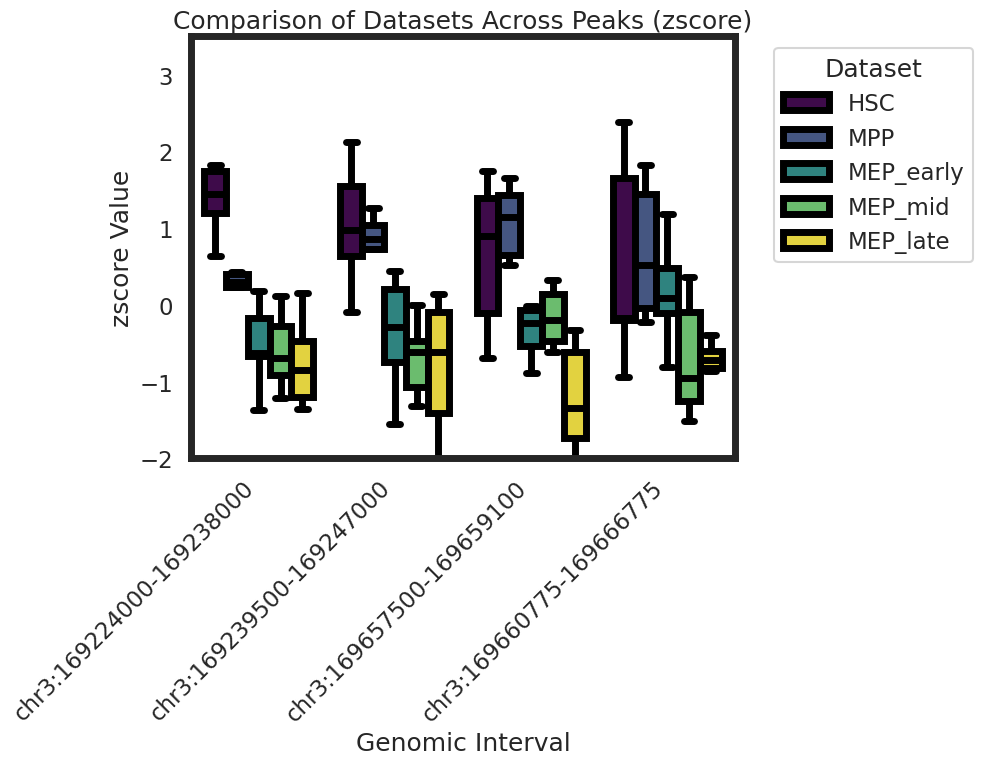

In [235]:
output_plot = "MECOM_MEP_Traj_K4me123_Interval_Comparison_Boxplot_REV.png"

plot_boxplot(MECOM_K4me123_df_results, value_column='zscore', output_path=output_plot, interval_order=MECOM_K27me3_Peaks)


In [236]:
output_stats = "MECOM_MEP_Traj_K4me123_Interval_Stats.csv"

MECOM_K4me123_stats_df = run_statistical_tests(MECOM_K4me123_df_results, value_column='zscore', output_path=output_stats)

print(MECOM_K4me123_stats_df)

✅ Statistical results saved to MECOM_MEP_Traj_K4me123_Interval_Stats.csv
                    Interval            Comparison  N1  N2  t-statistic   p-value  Corrected p-value  Reject Null Hypothesis
0   chr3:169224000-169238000            HSC vs MPP   6   6     3.788314  0.003553           0.056851                   False
1   chr3:169224000-169238000      MPP vs MEP_early   6   6     3.426476  0.006477           0.103627                   False
2   chr3:169224000-169238000  MEP_early vs MEP_mid   6   6     0.241430  0.814100           1.000000                   False
3   chr3:169224000-169238000   MEP_mid vs MEP_late   6   6     0.521082  0.613652           1.000000                   False
4   chr3:169239500-169247000            HSC vs MPP   6   6     0.618497  0.550075           1.000000                   False
5   chr3:169239500-169247000      MPP vs MEP_early   6   6     3.391305  0.006871           0.109932                   False
6   chr3:169239500-169247000  MEP_early vs MEP_mid  

In [237]:
# Define your peak list (already sorted from before)
PRDM16_K27me3_Peaks = [
        {'chrom': 'chr1', 'start': 3066197, 'stop': 3072197}, #, 'label': 'PRDM16 Promoter'
        {'chrom': 'chr1', 'start': 3072197, 'stop': 3075200}, #, 'label': 'PRDM16 DE1'
        {'chrom': 'chr1', 'start': 3162800, 'stop': 3163400}, #, 'label': 'PRDM16 DE2'
        {'chrom': 'chr1', 'start': 3245500, 'stop': 3249500}, #, 'label': 'PRDM16 DE3'
        {'chrom': 'chr1', 'start': 3391500, 'stop': 3396200} #, 'label': 'PRDM16 DE4'
    ]

# Run the overlap & z-scoring
PRDM16_K4me123_df_results = process_datasets_with_zscore(PRDM16_K27me3_Peaks, k4me123_bed_files_with_names)


Processing bed files...


100%|██████████| 30/30 [03:25<00:00,  6.86s/it]


Generating boxplot...
✅ Boxplot saved to PRDM16_MEP_Traj_K4me123_Interval_Comparison_Boxplot_REV.png


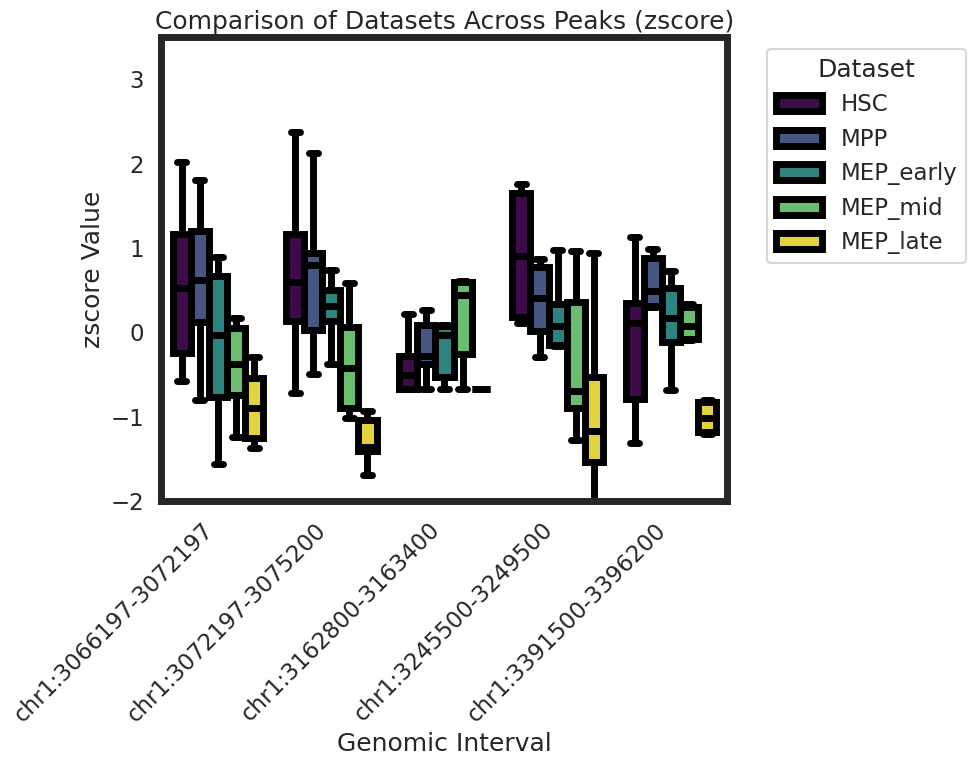

In [239]:
output_plot = "PRDM16_MEP_Traj_K4me123_Interval_Comparison_Boxplot_REV.png"

plot_boxplot(PRDM16_K4me123_df_results, value_column='zscore', output_path=output_plot, interval_order=PRDM16_K27me3_Peaks)


In [240]:
output_stats = "PRDM16_MEP_Traj_K4me123_Interval_Stats.csv"

PRDM16_K4me123_stats_df = run_statistical_tests(PRDM16_K4me123_df_results, value_column='zscore', output_path=output_stats)

print(PRDM16_K4me123_stats_df)

✅ Statistical results saved to PRDM16_MEP_Traj_K4me123_Interval_Stats.csv
                Interval            Comparison  N1  N2  t-statistic   p-value  Corrected p-value  Reject Null Hypothesis
0   chr1:3066197-3072197            HSC vs MPP   6   6    -0.071686  0.944266           1.000000                   False
1   chr1:3066197-3072197      MPP vs MEP_early   6   6     1.313300  0.218416           1.000000                   False
2   chr1:3066197-3072197  MEP_early vs MEP_mid   6   6     0.012821  0.990023           1.000000                   False
3   chr1:3066197-3072197   MEP_mid vs MEP_late   6   6     1.559166  0.150017           1.000000                   False
4   chr1:3072197-3075200            HSC vs MPP   6   6     0.057038  0.955639           1.000000                   False
5   chr1:3072197-3075200      MPP vs MEP_early   6   6     0.945544  0.366668           1.000000                   False
6   chr1:3072197-3075200  MEP_early vs MEP_mid   6   6     2.033920  0.069349  

In [241]:
# Define your peak list (already sorted from before)
ZFPM1_K4me123_Peaks = [
    {'chrom': 'chr16', 'start': 88452317, 'stop': 88454317},
    {'chrom': 'chr16', 'start': 88490500, 'stop': 88493500},
    {'chrom': 'chr16', 'start': 88502000, 'stop': 88516000},
    {'chrom': 'chr16', 'start': 88532500, 'stop': 88533750}
]

# Run the overlap & z-scoring
ZFPM1_K4me123_df_results = process_datasets_with_zscore(ZFPM1_K4me123_Peaks, k4me123_bed_files_with_names)

Processing bed files...


100%|██████████| 30/30 [03:27<00:00,  6.91s/it]


Generating boxplot...
✅ Boxplot saved to ZFPM1_MEP_Traj_K4me123_Interval_Comparison_Boxplot_REV.png


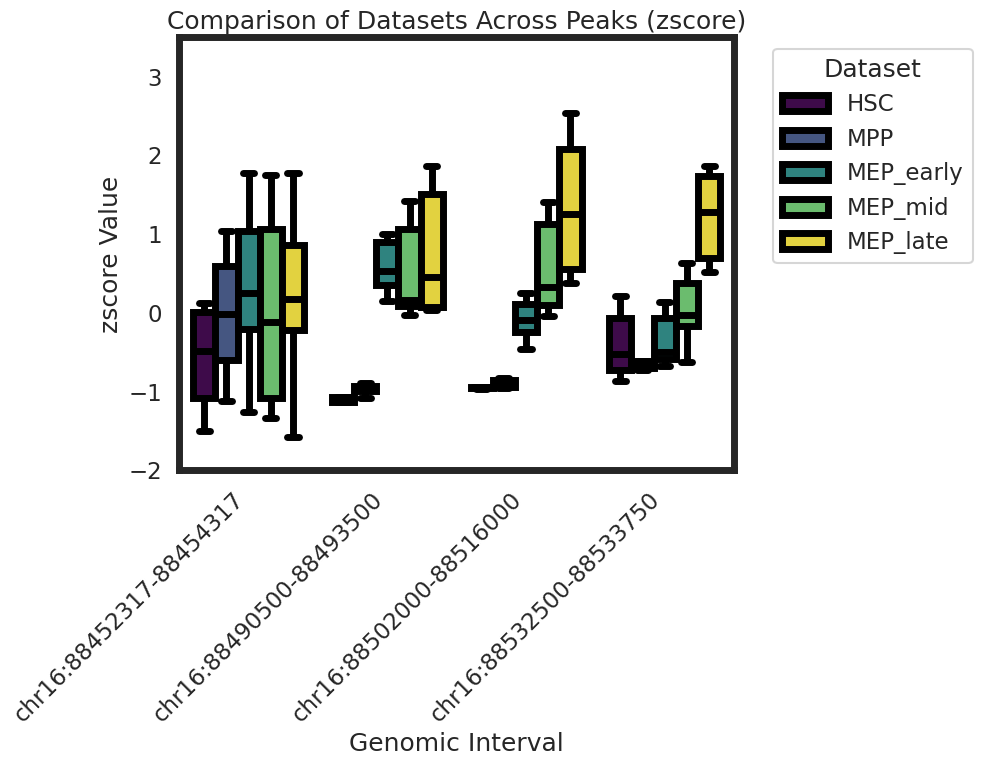

In [242]:
output_plot = "ZFPM1_MEP_Traj_K4me123_Interval_Comparison_Boxplot_REV.png"

plot_boxplot(ZFPM1_K4me123_df_results, value_column='zscore', output_path=output_plot, interval_order=ZFPM1_K4me123_Peaks)


In [243]:
output_stats = "ZFPM1_MEP_Traj_K4me123_Interval_Stats.csv"

ZFPM1_K4me123_stats_df = run_statistical_tests(ZFPM1_K4me123_df_results, value_column='zscore', output_path=output_stats)

print(ZFPM1_K4me123_stats_df)

✅ Statistical results saved to ZFPM1_MEP_Traj_K4me123_Interval_Stats.csv
                   Interval            Comparison  N1  N2  t-statistic   p-value  Corrected p-value  Reject Null Hypothesis
0   chr16:88452317-88454317            HSC vs MPP   6   6    -1.253407  0.238570           1.000000                   False
1   chr16:88452317-88454317      MPP vs MEP_early   6   6    -0.608591  0.556367           1.000000                   False
2   chr16:88452317-88454317  MEP_early vs MEP_mid   6   6     0.409351  0.690912           1.000000                   False
3   chr16:88452317-88454317   MEP_mid vs MEP_late   6   6    -0.248459  0.808807           1.000000                   False
4   chr16:88490500-88493500            HSC vs MPP   6   6    -4.411064  0.001312           0.020996                    True
5   chr16:88490500-88493500      MPP vs MEP_early   6   6    -6.004452  0.000131           0.002101                    True
6   chr16:88490500-88493500  MEP_early vs MEP_mid   6   6  

In [244]:
# Define your peak list (already sorted from before)
GATA1_K4me123_Peaks = [
    {'chrom': 'chrX', 'start': 48782600, 'stop': 48783250},
    {'chrom': 'chrX', 'start': 48785554, 'stop': 48787554},
    {'chrom': 'chrX', 'start': 48789400, 'stop': 48790000},
    {'chrom': 'chrX', 'start': 48794000, 'stop': 48795400} 
]

# Run the overlap & z-scoring
GATA1_K4me123_df_results = process_datasets_with_zscore(GATA1_K4me123_Peaks, k4me123_bed_files_with_names)

Processing bed files...


100%|██████████| 30/30 [03:26<00:00,  6.90s/it]


Generating boxplot...
✅ Boxplot saved to GATA1_MEP_Traj_K4me123_Interval_Comparison_Boxplot_REV.png


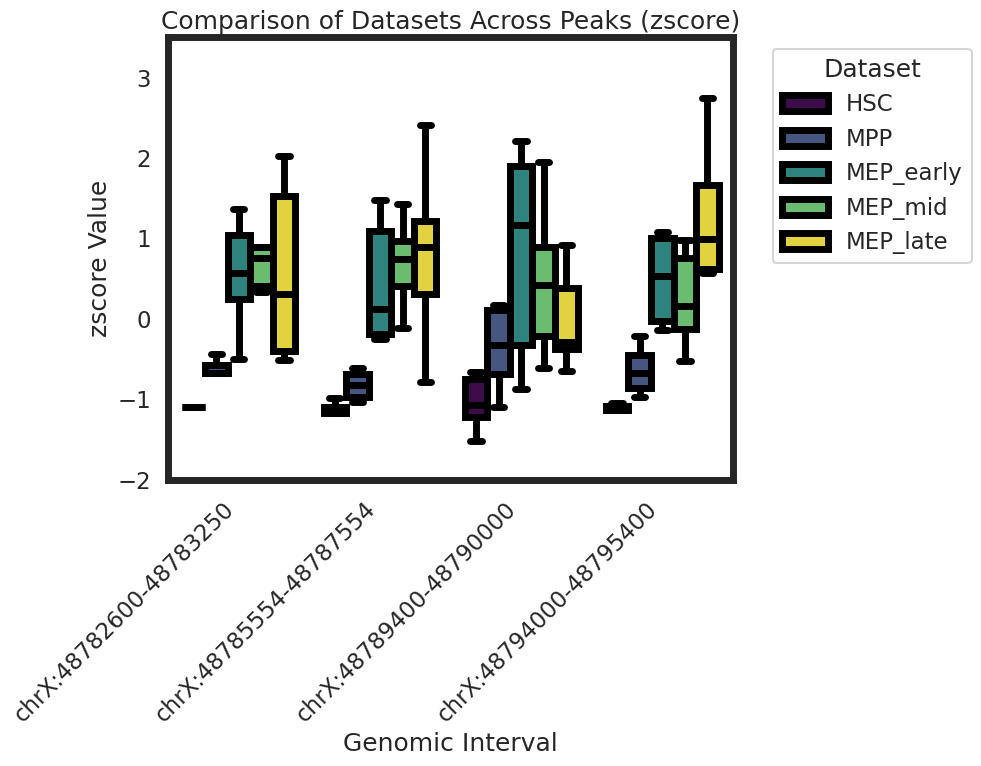

In [247]:
output_plot = "GATA1_MEP_Traj_K4me123_Interval_Comparison_Boxplot_REV.png"

plot_boxplot(GATA1_K4me123_df_results, value_column='zscore', output_path=output_plot, interval_order=GATA1_K4me123_Peaks)


In [248]:
output_stats = "GATA1_MEP_Traj_K4me123_Interval_Stats.csv"

GATA1_K4me123_stats_df = run_statistical_tests(GATA1_K4me123_df_results, value_column='zscore', output_path=output_stats)

print(GATA1_K4me123_stats_df)

✅ Statistical results saved to GATA1_MEP_Traj_K4me123_Interval_Stats.csv
                  Interval            Comparison  N1  N2  t-statistic   p-value  Corrected p-value  Reject Null Hypothesis
0   chrX:48782600-48783250            HSC vs MPP   6   6    -6.960398  0.000039           0.000624                    True
1   chrX:48782600-48783250      MPP vs MEP_early   6   6    -4.233500  0.001734           0.027747                    True
2   chrX:48782600-48783250  MEP_early vs MEP_mid   6   6    -0.112237  0.912857           1.000000                   False
3   chrX:48782600-48783250   MEP_mid vs MEP_late   6   6     0.072484  0.943646           1.000000                   False
4   chrX:48785554-48787554            HSC vs MPP   6   6    -3.694069  0.004149           0.066382                   False
5   chrX:48785554-48787554      MPP vs MEP_early   6   6    -3.797946  0.003498           0.055961                   False
6   chrX:48785554-48787554  MEP_early vs MEP_mid   6   6    -0.648

/home/derek.janssens/jupyter_bbc2_python3_python-3.11.3_/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:573: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


In [260]:
import pandas as pd

# ------------------------------
# 1. Load barcode annotations for MEP trajectory
# ------------------------------
cluster_barcodes = pd.read_csv("K4me123_MEP_Traj_Cluster_Barcodes.csv")

cluster_names = ["HSC", "MPP", "MEP_early", "MEP_mid", "MEP_late"]

cluster_groups = {
    cluster: set(cluster_barcodes.loc[cluster_barcodes["cluster_name"] == cluster, "barcode"].unique())
    for cluster in cluster_names
}

# ------------------------------
# 2. Define CUTAC file paths
# ------------------------------
cutac_file_paths = {
    'Rep1': 'Full_hg38_Aligned_BED_Files/Batch_Beds_K4me123/K4me123_Batch7_2in1_wCUTAC_Full.bed.gz',
    'Rep2': 'Full_hg38_Aligned_BED_Files/Batch_Beds_K4me123/K4me123_Batch8_2in1_wCUTAC_Full.bed.gz',
    'Rep3': 'Full_hg38_Aligned_BED_Files/Batch_Beds_K4me123/K4me123_Batch9_2in1_wCUTAC_Full.bed.gz',
}

# ------------------------------
# 3. Function to split BED by clusters
# ------------------------------
def split_bed_by_clusters(bed_df, cluster_groups):
    bed_df.columns = ['chrom', 'start', 'end', 'barcode']
    return {
        cluster: bed_df[bed_df['barcode'].isin(barcodes)].copy()
        for cluster, barcodes in cluster_groups.items()
    }

# ------------------------------
# 4. Load and split CUTAC replicates
# ------------------------------
split_cutac_batches = {}

for rep_name, filepath in cutac_file_paths.items():
    df = pd.read_csv(filepath, sep='\t', header=None, compression='gzip')
    split_cutac_batches[rep_name] = split_bed_by_clusters(df, cluster_groups)

# ------------------------------
# 5. Inspect
# ------------------------------
print("✅ Rep3 MEP_late read count:", len(split_cutac_batches['Rep3']['MEP_late']))

# ------------------------------
# 6. Optional: Save one example
# ------------------------------
# split_cutac_batches['Rep2']['HSC'].to_csv("CUTAC_Rep2_HSC.bed.gz", sep='\t', index=False, header=False, compression='gzip')
# split_cutac_batches['Rep2']['MEP_mid'].to_csv("CUTAC_Rep2_MEP_mid.bed.gz", sep='\t', index=False, header=False, compression='gzip')


✅ Rep3 MEP_late read count: 473721


In [262]:

cutac_wK4me123_bed_files_with_names = format_split_batches_for_processing(split_cutac_batches)

In [264]:
ZFPM1_CUTAC_Peaks = [
    {'chrom': 'chr16', 'start': 88452317, 'stop': 88454317},
    {'chrom': 'chr16', 'start': 88454317, 'stop': 88537016}
]

# Run the overlap & z-scoring
ZFPM1_CUTAC_wK4me123_df_results = process_datasets_with_zscore(ZFPM1_CUTAC_Peaks, cutac_wK4me123_bed_files_with_names)

Processing bed files...


100%|██████████| 15/15 [01:02<00:00,  4.18s/it]


Generating boxplot...
✅ Boxplot saved to ZFPM1_MEP_Traj_CUTAC_Prom_GBody_Boxplot_REV.png


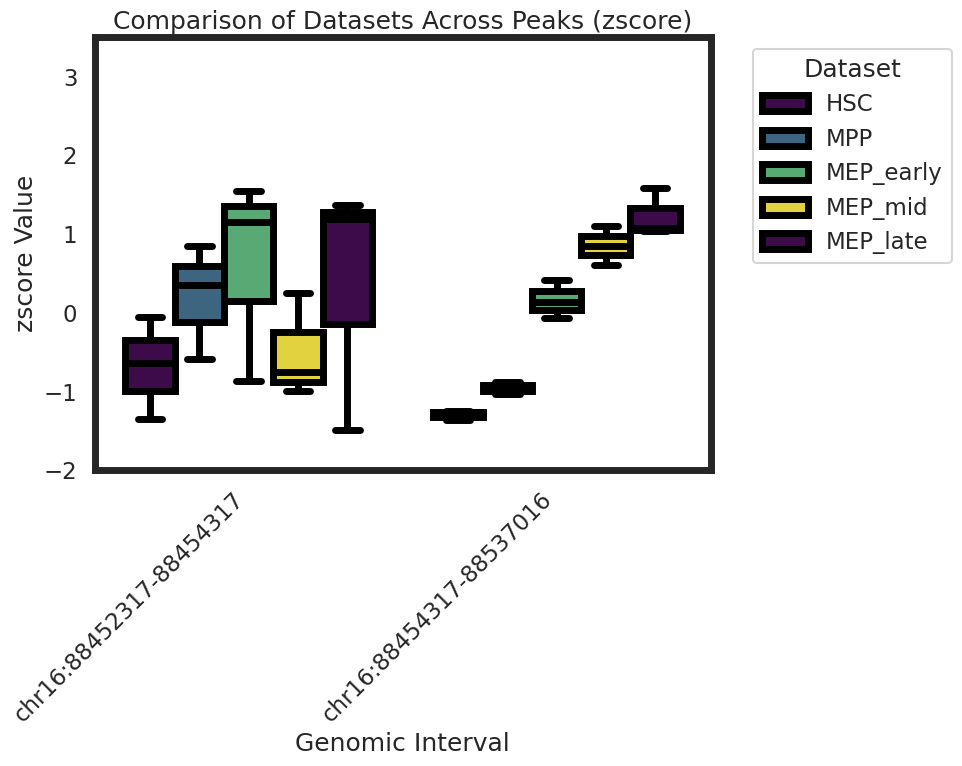

In [268]:

output_plot = "ZFPM1_MEP_Traj_CUTAC_Prom_GBody_Boxplot_REV.png"

plot_boxplot(ZFPM1_CUTAC_wK4me123_df_results, value_column='zscore', output_path=output_plot, interval_order=ZFPM1_CUTAC_Peaks)


In [272]:
output_stats = "ZFPM1_MEP_Traj_CUTAC_Prom_GBody_Stats.csv"

ZFPM1_CUTAC_stats_df = run_one_sided_increase_tests(ZFPM1_CUTAC_wK4me123_df_results, value_column='zscore', output_path=output_stats)

print(ZFPM1_CUTAC_stats_df)

✅ Statistical results saved to ZFPM1_MEP_Traj_CUTAC_Prom_GBody_Stats.csv
                  Interval                      Comparison  N1  N2  t-statistic  One-sided p-value  Corrected p-value  Reject Null Hypothesis
0  chr16:88452317-88454317            HSC < MPP (increase)   3   3    -1.573759           0.095328           0.762622                   False
1  chr16:88452317-88454317      MPP < MEP_early (increase)   3   3    -0.479226           0.328400           1.000000                   False
2  chr16:88452317-88454317  MEP_early < MEP_mid (increase)   3   3     1.321000           1.000000           1.000000                   False
3  chr16:88452317-88454317   MEP_mid < MEP_late (increase)   3   3    -0.857250           0.219815           1.000000                   False
4  chr16:88454317-88537016            HSC < MPP (increase)   3   3    -6.407375           0.001524           0.012192                    True
5  chr16:88454317-88537016      MPP < MEP_early (increase)   3   3    -7.58

In [273]:
GATA1_CUTAC_Peaks = [
    {'chrom': 'chrX', 'start': 48785554, 'stop': 48787554},
    {'chrom': 'chrX', 'start': 48787554, 'stop': 48794311}
]

# Run the overlap & z-scoring
GATA1_CUTAC_wK4me123_df_results = process_datasets_with_zscore(GATA1_CUTAC_Peaks, cutac_wK4me123_bed_files_with_names)

Processing bed files...


100%|██████████| 15/15 [01:03<00:00,  4.20s/it]


In [ ]:

GATA1_CUTAC_Peaks = [
    {'chrom': 'chrX', 'start': 48785554, 'stop': 48787554},
    {'chrom': 'chrX', 'start': 48787554, 'stop': 48794311}
]


Generating boxplot...
✅ Boxplot saved to GATA1_MEP_Traj_CUTAC_Prom_GBody_Boxplot_REV.png


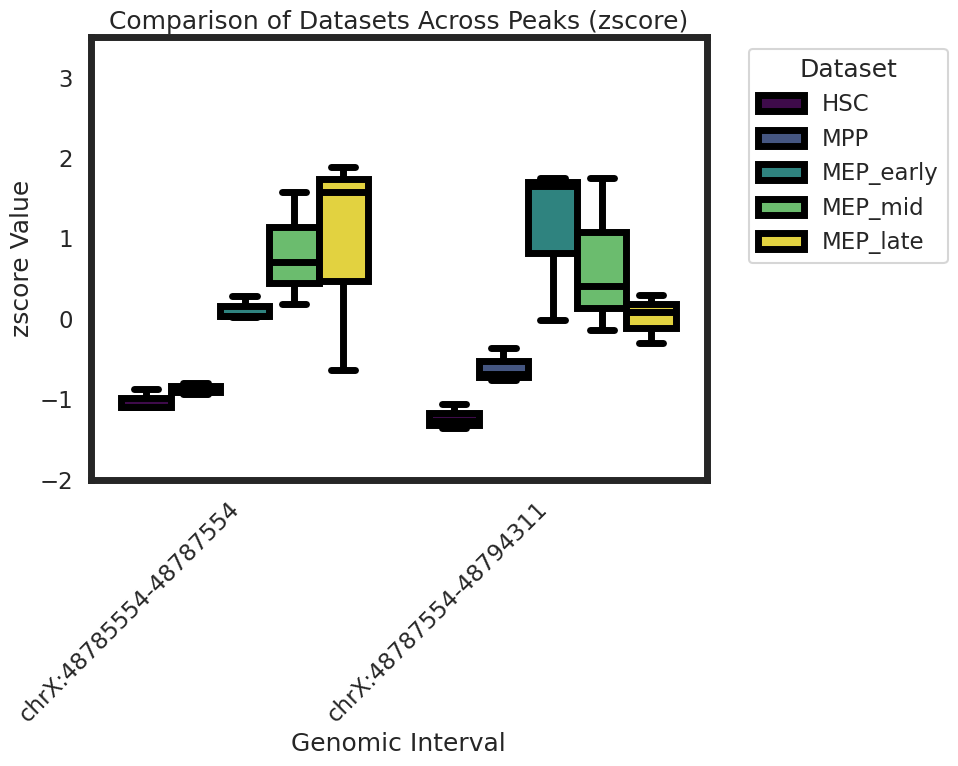

In [274]:

output_plot = "GATA1_MEP_Traj_CUTAC_Prom_GBody_Boxplot_REV.png"

plot_boxplot(GATA1_CUTAC_wK4me123_df_results, value_column='zscore', output_path=output_plot, interval_order=GATA1_CUTAC_Peaks)


In [276]:
output_stats = "GATA1_MEP_Traj_CUTAC_Prom_GBody_Stats.csv"

GATA1_CUTAC_stats_df = run_one_sided_increase_tests(GATA1_CUTAC_wK4me123_df_results, value_column='zscore', output_path=output_stats)

print(GATA1_CUTAC_stats_df)

✅ Statistical results saved to GATA1_MEP_Traj_CUTAC_Prom_GBody_Stats.csv
                 Interval                      Comparison  N1  N2  t-statistic  One-sided p-value  Corrected p-value  Reject Null Hypothesis
0  chrX:48785554-48787554            HSC < MPP (increase)   3   3    -1.853780           0.068693           0.549546                   False
1  chrX:48785554-48787554      MPP < MEP_early (increase)   3   3   -10.743618           0.000213           0.001702                    True
2  chrX:48785554-48787554  MEP_early < MEP_mid (increase)   3   3    -1.715101           0.080737           0.645893                   False
3  chrX:48785554-48787554   MEP_mid < MEP_late (increase)   3   3    -0.138942           0.448105           1.000000                   False
4  chrX:48787554-48794311            HSC < MPP (increase)   3   3    -4.075779           0.007575           0.060603                   False
5  chrX:48787554-48794311      MPP < MEP_early (increase)   3   3    -2.948620   